In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

# set the graphs to show in the jupyter notebook
%matplotlib inline

# set seaborn graphs to a better style
sns.set(style="ticks")
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from livelossplot import PlotLossesKeras
np.random.seed(7)
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from gensim.models import Word2Vec, KeyedVectors, word2vec
import gensim
from gensim.utils import simple_preprocess
from keras.utils import to_categorical
import pickle
import h5py
from time import time

E:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
import json
import csv
import tweepy as tw
import re
%config Completer.use_jedi = False
import sys
import pandas as pd

In [4]:
file = open("apis.txt")
lines = file.readlines()

consumer_key = lines[1][:-1]
consumer_secret = lines[3][:-1]
access_token = lines[7][:-1]
access_token_secret = lines[9]

In [5]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit = True)

In [6]:
def get_replies(screen_name, no_of_tweets, no_of_replies):

    replies=[]
    reply_to = []
    non_bmp_map = dict.fromkeys(range(0x10000, sys.maxunicode + 1), 0xfffd)

    for full_tweets in tw.Cursor(api.user_timeline, 
                                 screen_name = screen_name, 
                                 include_rts = 'False', 
                                 exclude_replies=True, 
                                 timeout=999999).items(no_of_tweets):

        for tweet in tw.Cursor(api.search, 
                             q='to:'+ screen_name, 
                             result_type='recent', 
                             timeout=999999,
                            tweet_mode='extended').items(no_of_replies):

            if hasattr(tweet, 'in_reply_to_status_id_str'):

                if (tweet.in_reply_to_status_id_str == full_tweets.id_str):
                    replies.append((tweet.full_text, tweet.author.name, tweet.in_reply_to_status_id_str))

        reply_to.append((full_tweets.id_str, full_tweets.text.translate(non_bmp_map)))
        
    originals = pd.DataFrame(reply_to, columns = ('id','text'))    
    data = pd.DataFrame(replies, columns=('text', 'author', 'in_reply_to'))
        
    return(data, originals)

In [7]:
def frame_the_tweets(tweets):
    download = []

    for tweet in tweets:
    
        download.append((tweet.author.name, tweet.text, tweet.truncated, tweet.favorite_count, tweet.id, tweet.retweet_count))
        
        data = pd.DataFrame(download, columns=('User_Name', 'Text', 'Truncated', 'Fav','id', 'ret_count'))
    return(data)

In [ ]:
politician_screen_names = ('KosiniakKamysz',
                           'DariuszKlimczak',
                           'trzaskowski_',
                           'szymon_holownia',
                           'HannaGillPiatek',
                           'krzysztofbosak',
                           'GrzegorzBraun_',
                           'RobertBiedron',
                           'K_Smiszek',
                           'AndrzejDuda',
                           'Macierewicz_A',
                           'ZandbergRAZEM',
                           'bbudka')


dfs_names = ('kosiniak_tweets',
             'klimaczak_tweets',
             'trzaskowski_tweets',
             'holownia_tweets',
             'gillpiatek_tweets',
             'bosak_tweets',
             'braun_tweets',
             'biedron_tweets',
             'smiszek_tweets',
             'duda_tweets',
             'macierewicz_tweets',
             'zandberg_tweets',
             'budka_tweets')

In [20]:
politician_screen_names2 = (
                           'GrzegorzBraun_',
                           'RobertBiedron',
                           'K_Smiszek',
                           'AndrzejDuda',
                           'Macierewicz_A',
                           'ZandbergRAZEM',
                           'bbudka')

dfs_names2 = (
             'braun_tweets',
             'biedron_tweets',
             'smiszek_tweets',
             'duda_tweets',
             'macierewicz_tweets',
             'zandberg_tweets',
             'budka_tweets')

In [15]:
(data, posts) = get_replies('KosiniakKamysz', 10, 10)

In [16]:
data

,text,author,in_reply_to
0,@KosiniakKamysz Napisz jak z PO chciałeś rząd ...,GCC🇵🇱🇵🇱🇵🇱,1396454637872484352
1,@KosiniakKamysz KOŚNIAK TY TO TAKA ZWYKŁA KURWA!,Artur,1396454637872484352
2,@KosiniakKamysz @nowePSL Czyli której?,Marek Krol,1396454637872484352
3,@KosiniakKamysz Wy macie tyle wspólnego z Lude...,Jerzy Weglarz,1396454637872484352
4,@KosiniakKamysz A gdzie masz tęczową flagę???N...,Tomasz 🇵🇱🇵🇱🇵🇱serce prawostronne.,1396390746845032450
5,@KosiniakKamysz @nowePSL 🍀🍀🍀🇵🇱🇵🇱🇵🇱,Paweł Gancarz,1396390746845032450
6,@KosiniakKamysz WYPIERDALAJ KURWO!,Artur,1396390746845032450
7,@KosiniakKamysz @AnetaPatrycja Ten sam Duch Św...,dir_ekt,1396390746845032450
8,@KosiniakKamysz PSL to ciekawa partia. Taka be...,Tomasz Wisniewski,1396390746845032450


In [30]:
tweets = {}
retweets = {}
for i in range(0,13):
    try:
        print(politician_screen_names[i])
        (data, posts) = get_replies(politician_screen_names[i], 10, 100)
        tweets[dfs_names[i]] = posts
        retweets[dfs_names[i]] = data
        print('done')
    except:
        pass

KosiniakKamysz
DariuszKlimczak
done
trzaskowski_
done
szymon_holownia
done
HannaGillPiatek
krzysztofbosak
done
GrzegorzBraun_
done
RobertBiedron
K_Smiszek
done
AndrzejDuda
done
Macierewicz_A
ZandbergRAZEM
done
bbudka
done


In [28]:
for i in range(0,13):
    print(politician_screen_names[i])

KosiniakKamysz
DariuszKlimczak
trzaskowski_
szymon_holownia
HannaGillPiatek
krzysztofbosak
GrzegorzBraun_
RobertBiedron
K_Smiszek
AndrzejDuda
Macierewicz_A
ZandbergRAZEM
bbudka


In [ ]:
tweets2 = {}
retweets2 = {}
for i in range(3,8):
    print(politician_screen_names[i])
    (data, posts) = get_replies(politician_screen_names[i], 10, 100)
    tweets2[dfs_names[i]] = posts
    retweets2[dfs_names[i]] = data

HannaGillPiatek
krzysztofbosak
RobertBiedron


In [44]:
pd.options.display.max_colwidth = 280

In [40]:
retweets['kosiniak_tweets']['text'] = retweets['kosiniak_tweets']['text'].apply(lambda x: x.strip("@KosiniakKamysz"))

In [62]:
retweets['kosiniak_tweets']['sentiment'] = np.nan

In [83]:
sent = []
for index, row in retweets['kosiniak_tweets'].iterrows():
    print(row['text'])
    sent.append(input())

 W 1992r szef PSL brał udział w obaleniu rzadu Olszewskiego i za to został premierem przez 33 dni... w 2021roku szef PSL aspólnie z KO podobno próbował obalić rząd Morawieckiego ale się nie udało zostać premierem.Pawlak górą...


 0


 Wladku pamiętamy twoja pomoc.  Nam się to po nocach ś


 0


 Panie Władeczku. To jakie były ustalenia ws. obalenia rządu? Najpierw obaliliście w parku na ławce z okolicznym menelstwem flaszkę jabola truskawkowego? stąd taki posrany pomysł? He he dwóch nieudaczników.


 -1


 Ty zielona szmxxx! https://t.co/s2Am092qEX


 -1


 Nigdy nie ma zadowolenia w waszej partii sami chcieliscie emerytury bez podatku teraz brak reakcji tylko dokopac rzadowi ....


 -1


 W latach pięćdziesiątych XXw za wrogów klasowych i pijawki uważano  bogatych chłopów zwanych "kułakami", więc zniszczono całe rolnictwo.
Dzisiejsza władza za krwiopijców ma przedsiębiorców. Finał będzie  podobny.


 0


 A pan pokazuje pazurki ? Tylko bla bla bla i nic więcej . Chociaż jedno dobre słowo byście powiedzieli o rządzie , bo coś tam napewno zasługuje na pochwale .A wy wiecznie tylko narzekacie ludzie was już maja dość tej całej waszej nienawiści i zazdrości bo dużo udało zrobić PISow


 -1


 Zamilcz pajacu, mieliście swoją szansę zamiast tego od 40 lat nas w chuja robicie. PO PiS PSL SLD wszyscy Wypi....ać


 -1


 Władek a czy nie ty podniosłeś mojej żonie wiek emerytalny o 12 lat ty nigdy nie będziesz miał szacunku.


 -1


 Wypowiedział się Ten, który dbał przez lata rządów o przedsiębiorców 😂😂😂


 -1


 To nie wspierajcie pisu w głosowaniach, żeby rozjebali 770 mld z Unii.


 0


 Bo przedsiębiorcy to nie jest elektorat PiSu, co pokazują badania. Ich zwolennicy są słabo wykształceni i mniej zarabiający oraz bezrobotni, czyli beneficjencji socjalu. Oni doceniają swoich...


 1


 Panie zmien se pan nazwisko na Kłamisz i wszyscy bo i tak wszyscy wiedzą kim pan jest
Ale tych co pana dopiero poznaja przedstawiając się już pan ich ostrzeże


 -1


 Pamiętasz? https://t.co/rSKQylU6bd


 0


 @AKossut O czym ty gościu piszesz? Za waszych rządów ludzie zapierdalali za 1350 zł na łapę u tych biednych przedsiębiorców. Czas spłacić dlug


 -1


 A od czego są samorządy? Domagają się pieniędzy, niech za nie, pomagają przedsiębiorcom.


 0


 https://t.co/UpUOaw5Glg


 0


 Człowieczku, to co daliście Polakom to płacę 5 zł/h, wieczną biedę i 250 mld zajumanego Vatu więc wypad z polityki!


 -1


 Władysławie, poparłeśPiSowaką opcję głosowania nad finansami, bez ustawowego ustalenia sposobu rozdysponowania środków, a teraz płaczesz, że coś jest nie tak? Który to już raz postąpiłeś wbrew ustaleniom?🤔


 -1


 Te Wladek ,jak to leciało ????
TYGRYSKU ,czy OGRYZKU...
bo żem siem POgubił ... https://t.co/BUZ5D4GZS1


 -1


 Kamysz ty przecież jesteś zwykły chłop z Krakowa, co to wie o ziemi tyle co widzi w doniczkach na oknach.


 -1


 Tygrys 🐯 co Ty gadasz feke 😁


 -1


 A kysz do kanalu😂


 -1


 Ja jestem przedsiębiorcą od ponad 20 lat,a pan?Proszę nie mówić za mnie.Oświadczam że za mojego życia nie było lepszego zarządzenia krajem jaki jest teraz.Uczciwi przedsiębiorcy nie zatrzewienieni politycznie to potwierdzą.


 -1


 🔴Zero szacunków to było przy niewolniczym, ➡️podniesieniu wieku emerytalnego, 
➡️kradzieży naszych Polaków pieniędzy z OFE, 
➡️jakiś portal dla bezdomnych za 49 mln zł. 
    a pod tym wszystkim 
              podpis Władysław Kosiniak-Kamysz, 
WSTYD Panie Kosiniak i obłuda ‼️


 -1


 Tygrysku!!! Przeszarżowałeś.


 -1


 Może zainteresujesz się tymi którym ukradłeś pieniądze z OFE i kazałeś dłużej pracować.


 -1


 I nawet bym dał lajka gdyby nie ta cholerna pamięć:) A coś Pan zrobił kiedy dla przedsiębiorców? Coś Pan zrobił dla zwykłego Polaka? Podniósł wiek emerytalny?:)


 -1


 https://t.co/rqzPiP6l4O


 0


 😂😂😂😂
Tęczowy kalosz po pandemi gdyby rządził dałby ulotkę LGBT i talon na darmową zupę w MOPSie dla pracodawców.
Glupich wśród wyznawców szukajcie.


 -1


 Ludzie...
Dajcie mu spokój...
Nie hejtujcie...!!!
Tak nie godzi się traktować niepełnosprawnych umysłow


 -1


 Sio.


 -1


 Abyście razem koperciarzem mogli to zrobić, wtedy ci przesiebiorcy,by dostali guzik,pieniędzy z UE budżetowych. Tak by było jak przy budowie autostrad przez wasz,kupa małych firm bankrutami,wy kieszenie pełne od łapówek,taka wasza troska o firmy Polskie tylko upadłość chamie oj.


 -1


 Tak twój ZSL chciał od nowa wprowadzić śrubę dla Polaków wnosząc poprawkę o finansach z UE, by nie zwracać kasy niezgodnie wydanych przez wasze samorządy KO,2050. Tak byście wyprowadzili kasę te 770 miliardów zł, jak Opolu kurs na telefon 11tys zł, dlatego było te dwa tygodnie.


 -1


 Kamysz a ty zajmij się rolnikami a nie lewicą


 0


 😅😅😅😅😅


 -1


 Mówisz o Waszym wyschnięty korycie?? 😂😂😂😂😂😁😁😁😁😂😂😂😁😂😁😂😁🤣🤣🤣😄😄😄😄🤣🤣😄🤣🤣


 -1


 Przestań udawać mądrzejszego niż jesteś 🤯


 -1


 Waldek przestań. Nie masz prawa wypowiadać się w tej kwestii - to Ty podniosłeś wiek emerytalny! Ku przypomnieniu!


 0


 Realne wsparcie ta ty tygrysie im zagwarantujesz wsparcie🤦‍♂️


 -1


 Władek ty za to wykazałeź ogromny szacunek do ciężkiej pracy dociskając kolanem podniesienie wieku emerytalnego o szacunku do kobiet przy tej okazji już nawet nie wspomnę. Idź w (wiadomo gdzie) koślawy nierobie. Nawet dnia uczciwe nie przerobiłeś hieno.


 -1


 Czego piszczysz 🤣 jedyne na co było ciebie stać to na podniesienie wieku emerytalnego.


 -1


 No widzi Pan? Gdyby się Pan nie odezwał, to by się Pan nie dowiedział, co ludzi o Panu myślą, a nie myślą dobrze. Ciekawe, co Pan zrobi z tą wiedzą?


 0


 Jak byłeś w rządzie, to te twoje idiotyczne pomysły tylko szkodziły Polakom.
Dlaczego dopiero teraz zrobiłeś się taki troskliwy❓
Twoja nienawiść do PiS odebrała ci resztki rozumu...
Wypad❗❗❗


 -1


 Debil


 -1


 Nigdy nie będziesz premierem bo jesteś stronniczy. To nie ten poziom koleś. Nie dasz rady.


 -1


 Wreszcie zdjął maskę...


 -1


 A kiedy tygrysek weźmie się do uczciwej pracy? 👍😎🐯


 -1


 Dał głos "rolnik..." zatroskany o przedsiębiorców. Dziękuję za pracę do 67. Hipokryci!


 -1


 Zero zawsze zerem zostanie - to koniec Twojego kołchozu 🤷‍♂️


 -1


 bedziemy przenosic nasze firmy do Czech,i tyle w temacie.,


 0


 Czy na nic innego PSL nie stać oprócz powielania narracji PO?


 0


 Dlaczego balansujecie na granicy progu wyborczego? Warto sobie odpowiedzieć.


 0


 A jego syn też był taki porządny ...???


 0


 https://t.co/LCKN76tXHY


 0


 https://t.co/LCKN76tXHY


 0


 Pamiętamy też o zamachu na rząd Olszewskieg


 0


 https://t.co/LCKN76tXHY


 0


In [85]:
retweets['kosiniak_tweets']['sentiment'] = sent

In [103]:
for i in range (11,12):
    retweets[dfs_names[i]]['text'] = retweets[dfs_names[i]]['text'].apply(lambda x: x.strip("@"+politician_screen_names[i]))
    retweets[dfs_names[i]]['sentiment'] = np.nan

    sent = []
    for index, row in retweets[dfs_names[i]].iterrows():
        print(row['text'])
        sent.append(input())
        
    retweets[dfs_names[i]]['sentiment'] = sent

 @Bartek93794875 Odpoczywaj w pokoju 🙏✝️🕯


 0


 @Czarek62266946 R.I.P


 0


 R.I.P.


 0


 🙏


 0


 Panie Antoni. Źle to wszystko wygląda z PiSem ostatnio. Oddają suwerenność do UE, oddają suwerenność energetyczną, nie leczą Polaków, blokują amantadynę, podnoszą podatki pod pozorem podnoszenia składki zdrowotnej, telewizja to propaganda, piątka dla zwierząt czeka itd, itd. Źle.


 -1


 🙏🙏


 -1


 😢🙏🏻


 -1


 🙏🙏🙏😔😔


 0


 @BasiaPL1 🙏😥👍


 0


 🙏🙏


 0


 🙏🇵🇱✝️🇵🇱


 0


 Pies go jebał. Pana z resztą też.


 -1


 Wieczny odpoczynek racz Mu dać Panie…


 0


 [*]

Bracie Antoni winno być: 

Jednodniowy marszałek senior Sejmu RP.


 0


 🙏🙏🙏


 0


 A to nie Piotrowicz prowadził wówczas śledztwo?


 0


 R.I.P. 🙏


 0


 Wieczne Odpoczywanie Racz Mu Dac Panie....


 0


 R.I.P. 🙏


 0


 A pana tzw. eksperci odchodzą do więzienia ...


 -1


 RIP


 0


 🙏🙏🙏


 0


 🙏🙏🙏


 0


 R.I.P.


 0


 A Antoni nic nie dodanie siebie o Romanie Kryże, Andrzeju i PiS?


 -1


 Synusia jego kata, Andrzeja Kryże, robiącego błyskotliwą karierę w PRL-owskim sądownictwie do końca także w PZPR wzięliście na sekretarza stanu w Ministerstwie SPRAWIEDLIWOŚCI. Dziękuję, skończyłem.


 -1


 Za twoją działaność na rzecz zniszczenia wojska polskiego, służb i te smoleńskie brednie zasługujesz na to samo


 -1


 Część i chwała bohaterom.


 0


 #ChwałaBohaterom


 0


 A w PiS w ministerstwie sprawiedliwości pracował jego syn ,dziecko resortowe i co wy na to ? Córka Jaruzelskiego nie miała prawa do niczego ,a syn kata Rotmistrza w ministerstwie sprawiedliwoś


 -1


 Przemówił patopatryjot


 -1


 Weź spierydajjaj.


 -1


 #wypierdalaj ś


 -1


 Pilecki zginął bo  nie chciał  kolaborować z komunistami ... Lata minęły i dzisiaj już się patrzy inaczej na taka współpracę ... Wiem , wiem przecież trzeba jakoś żyć . A Pilecki ? Postawi mu się pomnik..


 0


 No i dlatego Gliński dał na film o Zenku, a o Pileckim nie. Od razu widać jakie dziedzictwo narodowe jest dla was ważne.


 -1


 Nie to co ty ruski szpiegu!


 -1


 A czy przypadkiem ojciec Jarosława K. Nie był też komunistą...


 -1


 Wyrok wydał Kryże tatuś twojego kumpla z pisowskiego rządu.
Sądzi Kryże będą krzyże. Tak wówczas mówiono. Co zrobiłeś żeby zbrodniarze z UB zostali ukarani?
Dlatego nie wycieraj sobie gęby rotmistrzem


 -1


 Pamiętamy. Cześć i chwała Bohaterowi ❤❤🇵🇱🇵🇱🇵🇱🇵🇱


 1


 Od Rotmistrza Pileckiego WON Zdrajco 🤢 sprzedaliście Polskę razem z tymi którzy go zamordowali po wojnie a dla tych którzy go probowali zamordować w trakcie wojny 🤢🤢oby wam piekło podziękowalo bo "patryjoci " za pincest do ostatniej miski ryżu będą w was wierzyć 🤢🤢🤢


 -1


 Antek, weź lepiej powiedz ile kasy przewaliłeś w komisji, a nie pierdol o Pileckim


 -1


 Wariatkowo czek


 -1


 @MarcCoufal I skazywał go ojciec sekretarza stanu w Min.Sprawiedliwosci rzadów PiS - Roman Kryże. Wszyscy jesteście kryptokomunistami, Pan w szczególnosci.


 -1


 Antoni gdzie wrak? Gdzie raport? Oddaj kasę która ukradłeś złodzieju ruski!


 -1


 Jaka jest różnica między komunistami z ZSRR a tymi z Chin z którymi współpracujecie? 


 -1


 Cześć i Chwała Bohaterom.


 1


 Gdybyś żył w jego czasach, musiałbyś spierdalac na Kamczatkę.


 -1


 Dziś z potomkami tej ideologi pis układa się, by szkodzić wolności o którą Rotmistrz walczył


 -1


 Pilecki nacharał by ryj wariatowi smoleńskiemu


 -1


 Tosiek, to ty łachudro jeszcze żyjesz? https://t.co/YCQcY2FNhb


 -1


 I Żydo-Komuna mordowała nam najlepszych Synów i Córy Ojczyzny 😩😪😠


 -1


 A srasz?


 -1


 Antoni Psychopata od balonów dmuchanych 🤦🤦🤦🤦


 -1


 Kryże sędzia.


 0


 Godzina świetlicy w Tworkach? Kiedy raport?


 -1


 Gęby sobie Pileckim nie wycieraj. 
Co raportem?


 -1


 Antoni Antoni wzywa do broni. Lecz się psycholu.


 -1


 https://t.co/aAnsfNpAYb


 0


 Ty sobie Antoś ryja nimi nie wycieraj bo przewracaja się w grobie jak widzą co robicie teraz z Polska.


 -1


 A Ten swoje, polegli a zginęli to jednak różnica. Szkoda wszystkich.


 -1


 Pan według mnie udaje kogoś innego niż Pan jest


 -1


 https://t.co/95QGFssMXd


 0


 Nie polegli tylko zginęli a Ty byłeś tak blisko i spieprzałeś do Polski po obiedzie żeby dalej robić krecią robotę sowiecki agen


 -1


 Miliony złotych zmarnowane żeby ustalić że zgineliO  nad Smoleńskiem a nie pod


 -1


 Jak to możliwe że w jednym wypadku na 96 osób dwoje poległo a 94 zginęło


 -1


 Debil jesteś


 -1


 Antek nie polegli tylko umarli w wypadku samolotowym !!!!!!!!!!!!!!!!!!!!!!!!!!. obejrzyj program katastrofy w przestworzach.jet odcinek o tym.


 -1


 Kiedy będą akty oskarżenia dla winnych katastrofy nad smoleńskiem ?


 -1


 Zginęli a nie polegli.


 0


 Zgineli śmiercią tragiczną z waszej winy, a Ty nawiałeś pk obiedzie do Warszawy niszczyć dokumenty https://t.co/fMEt2N4OMp


 -1


 nie polegli, bo nie walczyli na polu bitwy. Pan jako były minister obrony powinien o tym wiedzieć


 -1


 Pojeb się kurwa ocknął...


 -1


 to na jasnej górze też lądowali ? o jprdl 🤣


 -1


 Zginęli w katastrofie lotniczej na skutek błędów organizacyjnych. Ze strony kancelarii prezydenta za organizację odpowiadał Sasin i Duda. Nie dziękuj. Gdzie jest kurwa wrak!!!


 -1


 Psychopata się ożywił


 -1


 Nie możliwe zdjęli ci Kaftan?


 -1


 Antek!Idioto!Mierzi mnie twój bełkot.Powiedz gdzie są te."trzy osoby, które z pewnością przeżyły".,o których z perorowałeś na spotkaniach sekty kaczyńskiego i rydzyka?
Ten bełkot zleciła ci ruska centrala? Od ilu lat prowadzisz Balbinę?
Płacą ci w $$$ czy może w rublach?


 -1


 Wstydź się pan ! Tak nie postępuje Polski Patriota! Można się różnić lecz coś pan uczynił  z tą katastrofą to wstyd dla całej pańskiej kariery politycznej!


 -1


 😂😂😂😂 polegli ? Najwyższy czas zacząć się leczyć...


 -1


 Pierdoli.z waść. Polec można tylko na wojnie a oni zginęli w katastrofie lotniczej.


 -1


 A gdzie wrak? #wypierdal


 -1


 Za mało tabletek, sen się pogorszył...


 -1


 https://t.co/Px70U8HiS4


 0


In [109]:
data = pd.DataFrame()

In [114]:
frames = [retweets['kosiniak_tweets'], 
          retweets['klimaczak_tweets'], 
          retweets['trzaskowski_tweets'], 
          retweets['tusk_tweets'], 
          retweets['holownia_tweets'], 
          retweets['gillpiatek_tweets'], 
          retweets['bosak_tweets'], 
          retweets['braun_tweets'], 
          retweets['biedron_tweets'], 
          retweets['smiszek_tweets'], 
          retweets['duda_tweets'], 
          retweets['macierewicz_tweets']]

In [117]:
data = pd.concat(frames)

In [131]:
data = data.reset_index()

In [134]:
data = data.drop(columns=['index'])

In [136]:
data.to_csv('manual_sentiment_1.csv')

<AxesSubplot:>

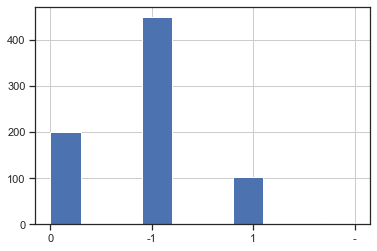

In [138]:
data.sentiment.hist()

# 24

In [47]:
for i in range (12,13):
    retweets[dfs_names[i]]['text'] = retweets[dfs_names[i]]['text'].apply(lambda x: x.strip("@"+politician_screen_names[i]))
    retweets[dfs_names[i]]['sentiment'] = np.nan

    sent = []
    for index, row in retweets[dfs_names[i]].iterrows():
        print(row['text'])
        sent.append(input())
        
    retweets[dfs_names[i]]['sentiment'] = sent

 Borys, dawaj jeszcze jedna fotkę z naszym Prezesem.....prędko!! Widzisz...11%, 10%..iii...lecisz!👏👏👏👇👇👇 https://t.co/3SfW3mFmlv


 -1


 Był konkurs na najgorszą grafikę, czy zamówienie wprost od Przewodniczącego?


 -1


 6 godzi za zamkniętymi drzwiami Platforma O. radziła, konsultowała, wsłuchiwała się  w głos swoich członków. Wszystko, by zatrzymać odpływ elektoratu. I uradzili: "totalna opozycja for ever". 👍


 -1


 Borys, a odrobiłeś matmę? Bo jutro pani ma pytać z tabliczki mnożenia.


 -1


 No tak - za waszych rzadow relacje z Bialorusia i Rosja faktycznie byly lepsze. Za to z Ukraina i Litwa gorsze. Co kto lubi.


 -1


 a wy debilomatołki


 -1


 Dyplomatołek z PO,fan UE https://t.co/pEgyPqTA96


 -1


 https://t.co/SNKGrT1I7K


 0


 Borys Twój czas się kończy jako szefa PO i mam nadzieję iż kończy się również istnienie platformy obywatelskiej co byłoby dobre dla PL


 -1


 Takie kraje jak Rosją i Niemcy chcą widzieć Polskę uległą, jak to miało miejsce za rządów PO PSL, obecna PL przeszkadza obu tym krajom w podporządkowaniu sobie choćby Europy wsch. Uległość rządu platformy obywatelskiej dawała złudne poczucie szanowania i poważania PL


 -1


 Tez skrócili nas wewnętrznie tez!


 -1


 Jestescie towarzyszu Gomółka najlepszym dowodem na to, że tylko rząd PiS jest w stanie przeprowadzić Polskę przez trudne czasy.

#patooPOzycja https://t.co/Kco0j9YiW


 -1


 https://t.co/i2sxKOXXCC


 0


 Kaczyński modlił się o tępą opozycję.
Ale Bóg tym razem przesadził .
Grubo przesadził 😁😂😁


 -1


 @Platforma_org https://t.co/YcDw7EYB1W


 0


 @Platforma_org https://t.co/WkKOnBJ7UX


 0


 @Platforma_org https://t.co/oKKkHAf0Pt


 0


 13% i ciągle spada. Pozdro dziku.


 -1


 Ty byś wszystkim rowa lizał, wiemy


 -1


 Człowieku, ile Ty masz lat?! Jak Cie traktować poważnie?


 -1


 Pierdolony PiS


 -1


 Borys, partia ci się rozbierdala, a ty się Kaczorem zajmujesz, trzynastoprocebtowcu.


 -1


 Napisał człowiek, który chciał odrzucić fundusze Unii Europejskiej, pogłębiające integrację krajów w UE.


 -1


 Rosji nie nawiedzimy , Niemcy to wogóle, Czesi do sądu nas . Kaczyński niszczy Polskę do upadłego


 -1


 Bałtyk na szczęście jeszcze jakoś nas toleruje...


 0


 1. Dzień po Majdanie
2. Wiadomo
3. Dyplomacja level expert https://t.co/h0AH7UNV18


 0


 Pan jest liderem opozycji? Szacun za merytoryke, powagę i jakość przekazu. Jak dzieciak z gimnazjum. 😂


 -1


 Jprdl szef opozycji memy wrzuca, Pan do kabaretu się zapisz i taki ktoś miałby mieć coś dopowiedzenie w sprawach Polski 🤦‍♀️


 -1


 https://t.co/kmKVAjUHY9


 0


 https://t.co/MNnbfhNot4


 0


 Wy za to lizaliście dupy wszystkim...


 -1


 https://t.co/U8GfdE5utD


 0


 Jak to, przecież otwieramy się na Bałtyk!


 0


 Czubek jesteś


 -1


 Borysek przypomnij  mi ile procent macie poparcia teraz? 🤣🤣


 -1


 Bez piosenki się nie liczy. Proszę zaśpiewać np. "Another brick in the wall". Ze Zbigniewem Hołdysem.


 0


 Bardzo wysoki poziom Pan reprezentujesz..coś na wysokości łodygi buraka 🤦‍♀️


 -1


 A tam, jeszcze Baltyk nam został 🤣


 0


 Ty poważnie?!! https://t.co/PT2LbHAZjS


 -1


 @Platforma_org według PO https://t.co/5G8dk9DAYY


 0


 Panie Budka, pańskie „postrzeganie rzeczywistości” wymaga zdecydowanie analiz lekarza specjalisty. Pański kompleks Kaczyńskiego wyraźnie wskazuje na zmiany w osobowości. Pan wie i czuje, że PJK robi was jak chce a wy, chłopcy z piaskownicy, potraficie sypać tylko piaskiem w oczy.


 -1


 Światły umysł się qrwa odezwał🤣


 -1


 Sami się skluciliscie POstkomunisci. Brak dostępu do koryta odkrył wasze prawdziwe intencje.


 -1


 No i gitara #Wielkomatołki POległe bawią się w kreskówki.Wazelinować swoim chlebodawcą.


 -1


 @EwaZamojska Z Bałykiem nie jesteśmy skłóceni. Na razie


 0


 Dyplomacja według PO.
#Dyplosługusy https://t.co/8BlBGASu8


 -1


 A teraz wypowiedzą wojne po kolei: Czechom, Białorusi….UE nie bo czekają na kasę…


 0


 Panie Borysie ! Gdy został zmuszony samolot Ryanair zarej. w Polsce do przym. lądowania w Mińsku to krzyczeliście, że to wina Polski, rządu itd.
A dzisiaj został zmu. do lądowania samolot niemieckiej Lufthansy. Jakoś Pan skrytykuję Niemiecki rząd za to ? 🤔


 -1


 Pały platformiane


 -1


 Spieprzaj buszmenie.


 -1


 Jasne. Nikt nie potrafi łączyć tak jak Wy, towarzyszu Borysie. #budkomatołki


 -1


 @polskawruinie2 Piasku w tej kuwecie brakuje


 -1


 Budka , ale z ciebie huj.......ty hujowy dyplomato, ty !!!


 -1


 Łukaszenka Ci podesłał tą grafikę? A może Putin?


 -1


 Ach były czasy, gdy wasz guru Tusk był dymany... wróć... sorry... "doceniany" we wszystkich kierunkach https://t.co/RLDce8XHNI


 -1


 @Platforma_org Hahahaha patrząc na to co się w sejmie dzieje i np Sławek się lansuje to chyba wy to zrobiliście


 -1


 Borys, co tweet to kompromitacja ❗🤦‍♂️🤣


 -1


 Dobrosąsiedzkie stosunki nie polegają na włażeniu wszystkim okolicznym w tyłek -herr Budka. Taka lekcja. Teraz smarka proszę obetrzeć i szelki podciągnąć.


 -1


 infantylna oPOzycja - żałosne


 -1


 Ty matole


 -1


 no i wyciszam tego kieszonkowego lidera bo nic konstruktywnego od niego usłyszeć nie można a człowiek się tylko irytuje


 -1


 #patoOpozycj


 -1


 https://t.co/pXjI2qSdVi


 0


 Borysomatolek dał czadu🤣
Ty wesoły chłopak jesteś .
Co powiesz to się z Ciebie wszyscy śmieją 😅😅


 -1


 Wincyj, wincyj a 10% poparcia już niedługo.


 -1


 Weź z Jachirą załóż teatrzyk i bawcie się do woli.
Nie wiem jak to nazwać, infantylizm, analfabetyzm wtórny, czy totalne zidiocenie.
Może wszystko na raz 🤦


 -1


 Ten kot Prezesa swoim intelektem bije cię na głowę człowieczku mizerny☝


 -1


 You said this .


 0


 myśli    🤔 a że przewód myślowy długi....


 -1


 Czy B.B. już  powiedział coś więcej ponad lamenty na nieudolność rządu?


 -1


 Niech Pan zapyta swojego mentora Tuskam , ma doświadczenie z wypadkiem.


 -1


 @patrick4096 A czy polska mogła na to reagować. Nie, bo znajduje się w geopolitycznej kanapce, a Rosja z nią graniczy.


 0


 Panie Budka , gdzie p. był .....Ja już po porwaniu widziałam reakcję polskich Władz , a p. bzdury wypisuje . Zero mądrości w PO


 -1


 Borys obudź się, zesrałeś się. Ale spokojnie to wina pisu, nie Twoja.


 -1


 Jes chory człowieku z nienawiści.


 -1


 Znowu kłamiesz Borysie, znowu... W domu też tak kłamiesz, czy masz moment oddechu.


 -1


 Borys powinien się zabrać do roboty polecieć do Białorusi i protestować tam


 -1


 Powiedz coś tej Gasiuk i Lubnauer bo kompromitują PO.


 -1


 @lewy_official @bbudka konto na TT ktoś ci przejął!


 -1


 @lewy_official Mam pytanie a pan na jakiej pozycji gra? https://t.co/kjDp2D2ARn


 0


 @lewy_official butka ma malego fiut


 -1


In [48]:
frames = [#retweets['kosiniak_tweets'], 
          retweets['klimaczak_tweets'], 
          retweets['trzaskowski_tweets'], 
          #retweets['tusk_tweets'], 
          retweets['holownia_tweets'], 
          #retweets['gillpiatek_tweets'], 
          retweets['bosak_tweets'], 
          retweets['braun_tweets'], 
          #retweets['biedron_tweets'], 
          retweets['smiszek_tweets'], 
          retweets['duda_tweets'], 
          #retweets['macierewicz_tweets']
          retweets['zandberg_tweets'], 
          retweets['budka_tweets']]

In [49]:
data = pd.concat(frames)
data = data.reset_index()
data = data.drop(columns=['index'])
data.to_csv('manual_sentiment_2.csv')

<AxesSubplot:>

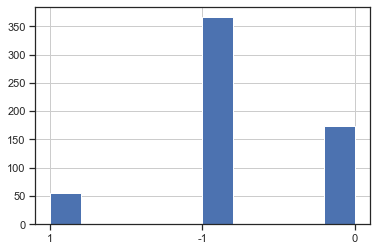

In [50]:
data.sentiment.hist()

## 07.06

In [10]:
tweets = {}
retweets = {}
for i in range(0,13):
    try:
        print(politician_screen_names[i])
        (data, posts) = get_replies(politician_screen_names[i], 10, 100)
        tweets[dfs_names[i]] = posts
        retweets[dfs_names[i]] = data
        print('done')
    except:
        print('ERROR')
        pass

KosiniakKamysz
done
DariuszKlimczak
done
trzaskowski_
done
szymon_holownia
ERROR
HannaGillPiatek
done
krzysztofbosak
done
GrzegorzBraun_
done
RobertBiedron
ERROR
K_Smiszek
done
AndrzejDuda
done
Macierewicz_A
done
ZandbergRAZEM
done
bbudka
done


In [15]:
politician_screen_names = ('KosiniakKamysz',
                           'DariuszKlimczak',
                           'trzaskowski_',
                           #'szymon_holownia',
                           'HannaGillPiatek',
                           'krzysztofbosak',
                           'GrzegorzBraun_',
                           #'RobertBiedron',
                           'K_Smiszek',
                           'AndrzejDuda',
                           'Macierewicz_A',
                           'ZandbergRAZEM',
                           'bbudka')

dfs_names = ('kosiniak_tweets',
             'klimaczak_tweets',
             'trzaskowski_tweets',
            # 'holownia_tweets',
             'gillpiatek_tweets',
             'bosak_tweets',
             'braun_tweets',
             #'biedron_tweets',
             'smiszek_tweets',
             'duda_tweets',
             'macierewicz_tweets',
             'zandberg_tweets',
             'budka_tweets')

In [17]:
for i in range (0,11):
    retweets[dfs_names[i]]['text'] = retweets[dfs_names[i]]['text'].apply(lambda x: x.strip("@"+politician_screen_names[i]))
    retweets[dfs_names[i]]['sentiment'] = np.nan

    sent = []
    for index, row in retweets[dfs_names[i]].iterrows():
        print(row['text'])
        sent.append(input())
        
    retweets[dfs_names[i]]['sentiment'] = sent

 @nowePSL Pan ich dopiero docenił jak był ministrem pracy. Moją żonę wtedy właśnie zwolnili z Pogotowia Ratunkowego, po przepracowaniu 36 lat musiała iść na "pomostówkę" i Pan coś jeszcze ma do powiedzenia??? #JaCieNieMoge


 -1


 @nowePSL Uważam, że jedyne co może pomoc szpitalom to ich prywatyzacja. Pielęgniarki pracują za grosze i maja nadmiar roboty i musza pomagać również tym, którzy tej pomocy nie powinni otrzymywać.


 0


 Tygrysek papierowy premier znowu się odzywa,tylko jak miał coś do powiedzenia tej materii, to tym pielęgniarkom podniósł wiek ile mają pracować do 67 lat. Ten sposób ZSL I POchcieli rozwiązać problem braku pielęgniarek, tak to wyglądało teraz wielki obrońca, likwidował szkoły ww.


 -1


 A Ty co zrobiłeś z Tuskiem dobrego dla tych pielęgniarek, żeby im żyło się lepiej, może jeden przykład.


 -1


 Wasz rząd był głuchy na wszystko. Trzeba było reformować służbę zdrowia już za waszej kadencji. Teraz cudzymi łapskami chcecie prawić o jakiś postulatach i czegoś rządać. Wasz czas już minął, więc raczcie nie przeszkadzać i zamknijcie te kłamliwe, zrzędliwe buźki.


 -1


 Już reformowaliście razem z PO. 8 lat stracone ! Niedługo na politycznym aucie będziecie Polacy pamiętają rządy wasze rządy, rządy PO-PSL.


 -1


 wy tylko macie w głowach zaprogramowaną mamonę !!


 -1


 Koryto śni się po nocach?


 -1


 .. Do kogo się przykleisz pijawko, żeby wejść do Sejmu?


 -1


 Każdy rząd był i jest głuchy na "wołania" o godne zarobki dla pielęgniarek. Pan też był w rządzie i też pielęgniarki protestowały ( białe miasteczko). Cóż i przy władzy i w opozycji efekty mierne.


 -1


 Tu wprawdzie nauczyciele ale przez 8 lat nic. 
Wypad oszuści. https://t.co/Aesz0rLcjS


 -1


 Władziu sam sp... na łatwiejszą posadkę do sejmu! Pomijając to że wasz cudny antyrząd rozwalił służbę zdrowia na wiele lat! Przypomnij kto likwidował szkoły pielęgniarskie? A te 50 milionów na portal dla bezdomnych można było wpompować w służbę zdrowia!!! Co nie?


 -1


 Twój czas, tygrysku, już minął. 
Dałeś się poznać jako rasowy reformator więc zmilcz i schowaj ogon pod siebie. 

Ponieważ NIE UWAŻAM cię za idiotę - spraw bym w tym postrzeganiu się utwierdził. Bo granica niepokojąco się kurczy.... 

Nawet jak szczekasz - już nikt nie słucha.


 -1


 Jesteś lekarzem,dlaczego nie pracujesz w zawodzie,w jakim szpitalu byłeś rezydentem,dlaczego jesteś wart 2 %.???


 -1


 Tygrys ty też byłeś w Rządzie PO/PSL i co zrobiłeś w tym kierunku, no kur...a co? Podpowiem ci, nic, kur...a nic, a przepraszam zrównaliście wiek emerytalny kobiet i mężczyzn, jednocześnie podnosząc go do 67 lat. Ty chcesz kogoś pouczać? Nie ty. Tak więc morda w kubeł tygrysku.


 -1


 Władek jaka systemowa zmiana? nie myl czekolady ze stolcem, który proponujesz  "Potrzebne są zarówno podwyżki wynagrodzeń jak i poprawa warunków pracy" Pogięło Cię? Systemowa to by była gdyby było np. to coś takiego https://t.co/xQ0xqF2vkJ


 -1


 Zna Pan tego noblistę ?
https://t.co/JVyfcr9tNq


 0


 Rozumiem,że gdy Pan współrządził to pielęgniarki i inni ich koledzy, koleżanki żyli jak w raju ?


 -1


 TY GLUPKU.   Zniknij z polityki no kurde TY BYLES W RZADZIE GDZIE LUDZIE nic nir mieli.  Nawet pochować. A nie mówiąc i płacy 3.50.  No ty szkodniku. https://t.co/Pu9iDf1wa3


 -1


 Dziwię się, że przez tyle lat nie pomogłeś koleżankom i kolegom. Dzisiaj masz czelność ujadac na coś czego sam nie zrobiłeś. Trochę samokrytyki ci nie zaszkodzi.


 -1


 Od 30 lat to samo mówicie, wszyscy od prawa do lewa i nic z tym nie robicie.


 -1


 Co zrobiłeś do tej pory dla służy zdrowia?


 0


 Władek, gadasz i gadasz i gadasz... to samo od lat i co ? JAJCO


 -1


 Gdzie Pan był parę lat temu ? Przypadkiem nie w rządzie ?


 -1


 Miałeś 8 lat co zrobiłeś ???🤦🏼‍♂️🤦🏼‍♂️


 -1


 A ileż to pan przepracował, że się wypowiada? Ani lekarz ani polityk.


 -1


 No ja myślę, że wiek emerytalny im trzeba podwyższyć 😂😂😂 hipokryto...


 -1


 Podwyższyć im wiek emerytalny tygrysku? https://t.co/IMN44RclGv


 -1


 a może by tak z podwyżką wynagrodzeń i poprawy warunków pracy żądać również jakości świadczonych usług przez te osoby, może niech przestaną traktować pacjentów jak śmieci?


 -1


 Wy wszyscy robicie reformy od dziesięcioleci i jak byliśmy w czarnej dupie ze służbą zdrowia tak jesteśmy.


 -1


 @nowePSL Błędna diagnoza.
Potrzebne jest zupełnie co innego.


 -1


 A gdzie byłaś przez 8 lat jak byłeś przy korycie? Podnosiłeś im wiek emerytalny o 7 lat ty hipokryto.


 -1


 @nowePSL Bardzo Pana szanuje, jednak problem z pielęgniarkami problem mieli wszyscy rządzący, nawet za Pana czasów...


 0


 OPZZ. GDXIE POZOSTALE ZWIAZKI?


 0


 Skończ pierdolić


 -1


 Gdzie qwa byłeś przez 8 lat


 -1


 Jest pokłosiem waszych rządów, to wy  zamykaliście szkoły i wygoniliście Polaków za pracą.
Hipokryci i obłudnicy to wy opozycjo.


 -1


 Kosiniak 8 lat straciłeś Więc teraz ty akurat nie masz nic do powiedze


 -1


 Takim wpisem nie poprawisz swoich notowań
Wszyscy pamiętają twoje zaniedbania w tym kierunku Dzisiaj są problemy o których piszesz
tylko nie zaznaczasz że to jest wina rządu PO PSL


 -1


 Nie zapomnijcie o innych zawodach medycznych, które zarabiają o wiele mniej niż pielęgniarki.


 0


 Ty to masz tupet!!! Za waszych rządów @Platforma_org @nowePSL pielęgniarki z 20 letnim stażem, zarabiały najniższą krajową.
Dlatego zamknij ryj świnio, która zmusiła pielęgniarki do pracy dłużej o 7 lat. Chciałeś zmuszać 70 letnie kobiety do ciężkiej pracy fizycznej!!!


 -1


 Trzeba im podnieść również wiek emerytalny, powiedzmy tak do 67 roku życia...Tygryski to wiedzą...


 -1


 @TrompBK Przywrócić licea medyczne? 🤔


 0


 Dziś międzynarodowy dzień seksu - nie ma to jak popierdolić


 -1


 Tygrysek sypnie swoim pieniądzem, czy zachęca nas do kolejnych danin, po to by gonić podwyżkami inflację?


 -1


 No przecież mieliście czas na taką reformę, co się stało?


 -1


 Rząd, rząd, rząd... To Kaczyński musi usłyszeć bo to on pociąga za wszystkie sznurki!


 0


 No Tygrysek za Waszych czasow to pielgniarki mialy cud ,miód ,malina 😊


 -1


 Podaj kwote na slube zdrowia w budzecie na 2008 rok, w budzecie na 2015 rok i w budzecie na 2021 rok. SZYBCIUTKO.


 -1


 Osiem  straconych lat


 -1


 Mieliście 8 lat na taką reformę. Zamiast tego bawiliście się w prywatyzację szpitali. Zamilcz człowieku.


 -1


 Co Pan zrobił w tej dziedzinie? Podniósł wiek emerytal


 -1


 Ty już jesteś poniżej progiem 5%
😀😀😀🤣🤣🤣🤣🙉🙉🙉🤡🤡🤡


 -1


 ❤️❤️🤪 https://t.co/64c9Oetf6Y


 0


 Popieram pana Terleckiego ma rację.


 1


 @nowePSL KK oszust chciał obalac rząd jak w nocnej zmianie najpierw Pawlaczek a teraz Kosiniak premierem rząd tymczasow


 -1


 A chuj z tą Białorusią.


 -1


 Mam nadzieje że podczas posiedzenia Sejmu gdy będzie prowadził Marszałek Terlecki każdy uczciwy Posłe wyjdzie z sali Sejmu .


 1


 Kamyszek zawsze w gotowości.Cwaniaczek.


 -1


 @MarioRebeliant Ale on tego nie zrozumie, nie ma szans! Spustoszenie, jakie ciężkie życie poczyniło w jego organizmie skutecznie uniemożliwia trzeźwe spojrzenie, jasną ocenę i rzeczowy komentarz.


 0


 👏👏👏


 1


 Wsparcie dla opozycji korzystnej dla Polski... Dla innej nie...


 1


 Polskiej dyplomacji już nie ma. Pozostały tylko dyplomatoły.


 1


 Wymowne. Robisz karierę z PIS? Wchodzisz w du*ę prezesowi. On to lubi. Wiemy to. Lata ćwiczeń. Zobacz jednak jak to się skończy. https://t.co/Szgb1UVZx5


 -1


 @TGiebien Dlatego nawet mysl o kolaboracji z reżimem PIS nie powinna wam w głowach zawitać.


 0


 KOŚNIAK JAK TAKI Z CIEBIE BOHATER TO JEDŹ NA BIAŁORUŚ DEBILU.


 -1


 A to jest jeszcze co rujnować?


 0


 Panie Władku, po wodzą Raua nie ma polskiej dyplomacji... To jakby knur udawał wierzchowca.😛


 0


 To my mamy jeszcze dyplomację ?
Raczej jakieś przypadkowe osoby zatrudnione z programu nepotyzm+


 0


 Jakiej dyplomacji? Jej od kilku lat nie ma 🤷‍♂️


 0


 Polskiego czego? 🥴


 0


 Czy Pan wie co to interes narodowy???Czy Pan wali pod sondaże?


 -1


 @justi_justyna Jeżu, ciągle nie rozumiecie, że właśnie o tworzenie i utrwalanie podziału tu chodzi.
Podzielonym społeczeństwem rządzi się łatwiej. A PiS jest naprawdę dobry w tworzeniu podziałów.


 0


 Stare ale jare i prawdziwe


 1


 @SzumowskiLukasz Tu mam ogromny problem - bo rzeczywiście są miejsca takie jak Tarnobrzeg czy takie jak moje okoliczne przychodnie w Bydgoszczy.

Ale dostęp do narzędzi wszyscy dostali taki sam. Niektórzy z nich nie korzystają, ale to już nie wina systemu (dał bardzo dobre warunki przychodniom).


 0


 @nowePSL @SzumowskiLukasz Tak. Pomnik i jeszcze opisać jego czyn w podręcznikach do historii 🤣🤣


 0


 @nowePSL @SzumowskiLukasz I flagę na partyjnych masztach,  albo chorągwie!


 0


 Brawo dla Mistrza Polski Urzędów Marszałkowskich ⚽👍🙂


 1


 @GrzegKrychowiak Celia by nie pozwoliła :)


 1


 @GrzegKrychowiak Okropne. Skojarzenie z kelnerami 


 -1


 Nic się Państwo nie zmieniacie ☺️


 0


 👌🙂👍


 1


 wstydu nie masz modląc się znalazł a oszust fałsz to kipi podjudzacz pod stołem chciałeś obalac rząd do spowiedzi 


 -1


 @SawickiMarek Rzymskokatolicy mają kolejną okazję aby w trakcie swych ulicznych manifestacji religijnych podzielić się uwagami na temat ZŁA panującego w Kościele rzymskokatolickim w wydaniu polskim
@Pontifex_pl
@prymasowska
@EpiskopatNews
@JasnaGoraNews
@RadioMaryja
@ArchKrakowska
@ArchPoznan


 0


 https://t.co/S5GXHWEq


 0


 @MorawieckiM Daruś, ekonomista z Ciebie jak z koziej dupy torb


 -1


 @MorawieckiM Bo tylko głupi przeżera nadwyżkę. Jednorazowy potężny strzał jest dobry w piłce nożnej, nie w dofinansowywaniu służby zdrowia. Mamy kryzys, to pójdzie na inwestycje, albo na obsługę długu po waszych kaprawych rządach.


 -1


 @MorawieckiM a ja się nie zgadzam żeby na służbę zdrowia najpierw zlikwidować gabinety prywatne a lekarze w szpitalu pracować i w przychodniach i nigdzie więcej


 0


 @MorawieckiM Bo może.


 0


 @MorawieckiM TO wy likwidowaliscie Z PO  SZPITALE.


 -1


 @nowePSL @MorawieckiM bo to zapewne kreatywna księgowość bez pokrycia w rzeczywistości... 🤷‍♀️🤬😱🤬🤦‍♀️


 -1


 @nowePSL @MorawieckiM żeby zrobić wrażenie na ludziach mniej "wyrobionych" ekonomicznie, skompromitował się Pan, tym wpisem, w oczach tych bardziej świadomych, warto takie świadectwo sobie wystawiać ?


 -1


 @MorawieckiM Trochę powagi pani pośle. Gdy jednorazowo dostanie pan od marszałek sejmu, nagrodę pieniężna to biegnie pan do banku, by na to konto wziąć regularne, comiesięczne zobowiązanie w postaci kredytu?


 -1


 @nowePSL @MorawieckiM Bez kropki po ZŁ... ;)


 0


 Orły rosną, jak na drożdżach 🦅⚽❗ Uściski dla całej rodzinki Panie Pośle 😍🤩


 1


 @tvp3_lodz Wy juz ZA burt


 -1


 @warszawa @WTP_Warszawa Panu to się podoba? Przecież to jest gówno. Tyle że nie płynące Wisłą.


 -1


 @warszawa @WTP_Warszawa Niezle maja posrane w glowach w Warszawie.


 -1


 @warszawa @WTP_Warszawa Czy to te kupione za 1/3 ceny takich samych kupionych do Warszawy???


 0


 @warszawa @WTP_Warszawa My jesteśmy przedszkolaczki hop sa sa...
Gościu zajmij się rozwiązaniem skrajnie niesprawiedliwej sytuacji spółdzielców mieszkających na tzw. nieuregulowanych gruntach. Do których NIE MA roszczeń, a burmistrzowie blokują uwłaszczenie. Bo sie szykuja skargi do Tryb. Miedzynarod.


 -1


 @warszawa @WTP_Warszawa https://t.co/HWy9yXD58


 0


 @warszawa @WTP_Warszawa SUPER❤️


 1


 @warszawa @WTP_Warszawa Czyli jak skwer z palet ... wyglada super do pierwszego deszczu lub pierwszego błota ;)


 -1


 @warszawa @WTP_Warszawa 👏👏👏👏👏👏👏❣


 1


 @warszawa @WTP_Warszawa "Zobaczcie na to" - w jakim to języku? Czy to język Tenkraju?


 0


 @warszawa @WTP_Warszawa Ty tak na poważnie, czy włam na konto?


 -1


 @warszawa @WTP_Warszawa Na Szmulkach takie rzeczy ? Kiedyś tam panowały inne klimaty:)


 1


 @warszawa @WTP_Warszawa Ja tam wole jak kredkami Maluja😷 jakieś fotki? https://t.co/8unhC84mN9


 1


 @warszawa @WTP_Warszawa "Zobaczcie na to?!" Dlaczego nie umiesz mówić po polsku?


 -1


 @warszawa @WTP_Warszawa Dopóki wandale nie postanowią zmodernizować coś pięknego taka też będzie długość życia tego artu, niestety


 0


 @warszawa @WTP_Warszawa Nie wyniosłeś pan form grzecznościowych z domu?


 -1


 @warszawa @WTP_Warszawa Rafau, chłopie wysoki, jak żeś mi teraz zaimponował... Masz rację. Są sprawy ważne i ważniejsze. Chooj tam zasrana Wisła, chooj tam stawki na śmieci, chooj tam wszystko inne. Owijanie słupków włóczką to priorytet urzędującego wysokiej wysokości "prezedęta". 
Brawo. Szapoba.


 -1


 @warszawa @WTP_Warszawa Zamiast zajmować się kolorowymi pierdułkami, weź się pan za robotę. Bo Polacy w Warszawie co m-c płacą panu pensję. Buduj podziemne parkingi. W-wa jest dużym grajdołem. Takie ozdóbki, wiejski wyrób pań z Koła Gospodyń Wiejskich akurat pasuje do warszawskiego grajdołka.


 -1


 @warszawa @WTP_Warszawa Moja dzielnica, urodzony 50m od słupków, a obok szkoła muzyczna:) i zajezdnia. Oj zmieniają się Szmulki :)


 1


 @warszawa @WTP_Warszawa Strachy na wróble się pojawiły


 1


 @warszawa @WTP_Warszawa Piękny pomysł . Te kolory napawają optymizmem . Moje oczy się uśmiechają serdecznie . Brawo 💙


 1


 @warszawa @WTP_Warszawa Nie ma innych problemów w tym mieście ?


 0


 @warszawa @WTP_Warszawa Drobna wskazówka: włóczki mają zakryć brzydotę, którą sprowadziłeś na warszawskie chodniki. 

Może skorzystasz.


 -1


 @warszawa @WTP_Warszawa Niby Szmulki, ale to chyba na granicy. Bo reszta Szmulek to ruina i nie jeździ tam żaden tramwaj


 -1


 @warszawa @WTP_Warszawa Panie Prezydencie, zobaczyć coś, patrzeć na coś.


 0


 @warszawa @WTP_Warszawa #fajnopolak ale


 1


 @warszawa @WTP_Warszawa To wcale nie Szmulki, a Michałów Panie Prezydencie... W A R S Z A W Y. 😎


 -1


 @warszawa @WTP_Warszawa a widziales Wisle przyozdobiona gownem?


 -1


 @warszawa @WTP_Warszawa Entuzjazm a la Trzaskowski - to się nazywa childish 😁


 -1


 @warszawa @WTP_Warszawa Chcieliśmy pomalować w naszej wsi słupy elektryczne w street art, ale nie dostaliśmy funduszy.


 0


 @warszawa @WTP_Warszawa Przyozdabia włóczką słupek,
Rafał to jest niezły... gałganiarz... 😎


 -1


 @warszawa @WTP_Warszawa Imponujące!!!


 1


 @warszawa @WTP_Warszawa robi się  "tandetna" warszawka !! coraz większe bezguście  zamiast wielkomiejski szyk !!!!


 -1


 @warszawa @WTP_Warszawa Super to wygląda dopóki pisowska hołota tego nie zniszczy


 1


 @warszawa @WTP_Warszawa Tak, to zdecydowanie najpilniejsza rzecz do załatwienia w Warszawie, priorytetowa można by rzec, zwłaszcza dla prezydenta 😂🤦‍♀️


 -1


 @warszawa @WTP_Warszawa https://t.co/mw5mawq3aV


 0


 @warszawa @WTP_Warszawa W lewackiej Warszawie rządzonej przez arcylewaka kolory mogą być co najwyżej... tęczowe aby promować zboczenie i dewiacje..


 -1


 @warszawa @WTP_Warszawa Chciałem poczytać program partii Platforma Obywatelska na ich stronie internetowej, a tu.. klops.
Wyprzedaż adresu internetowego trwa. 
Czy już się likwidują? https://t.co/BUoQPE2wFT


 -1


 @warszawa @WTP_Warszawa Widzimy to od kilku lat w Lublinie🙂Pozdrowienia dla Warszawy.


 1


 @warszawa @WTP_Warszawa Londyn https://t.co/lKUzbrRt4


 0


 @warszawa @WTP_Warszawa zajmij się chłopie ściekami z Czajki, zakorkowanymi ulicami, budową parkingów, budową metra, a nie duperelami, straszny badziewiarz jesteś, i leniuch...do roboty!!!


 -1


 @warszawa @WTP_Warszawa Jakie pjenkne Rafau ku 🤗🤗🤗


 -1


 @warszawa @WTP_Warszawa Znaki na jezdniach, niech malują dzieci z przedszkola kredkami, będzie jeszcze ładniej.


 0


 @warszawa @WTP_Warszawa Za robotę byś sie pan wziął


 -1


 @warszawa @WTP_Warszawa To było godne twojego tweeta. Se


 -1


 @warszawa @WTP_Warszawa Pan pomyśli jak zamaskować smród z rury Trzaskowskiego na Bielanach. Śmierdzi tak, że na Tarchominie pomidorki zdychają na parapecie.


 -1


 @warszawa @WTP_Warszawa Rewelacja!


 1


 @warszawa @WTP_Warszawa Świetne bo nie za wasze pieniądze i te nieszczęsne ławki co dałeś grubą kasę


 -1


 @warszawa @WTP_Warszawa Kocham Warszawę.  Nie rozumiem pana potrzeby, aby było brzydka…


 1


 @warszawa @WTP_Warszawa osłupkować tak całą Warszawę...


 1


 @warszawa @WTP_Warszawa A włóczkę pewnie niemiecką bo trwalsza i wyrazista.


 0


 @warszawa @WTP_Warszawa Cieszy ten minimalizm.
Gigantomanii mówimy stanowcze nie !!!😂


 0


 @warszawa @WTP_Warszawa Bycie prezydentem stolicy to taka poważna funkcja. 😂


 -1


 @warszawa @WTP_Warszawa Jakie ładne 👍


 1


 @warszawa @WTP_Warszawa ja jestem ofiara braku parkingu przy PKP Płudy. nie ma gdzie zostawić auta, za to straz miejska swietnie potrafi ukarać, za to, ze rezygnujac z auta przesiadam sie na komunikacje miejska. 
jak dlugo ten biznes bedzie jeszcze sie krecił?


 -1


 @warszawa @WTP_Warszawa 🤣🤣🤣 https://t.co/BGefCwDj6


 -1


 @warszawa @WTP_Warszawa Z Warszawy robisz cyrk -.-


 -1


 @warszawa @WTP_Warszawa 🤦🏼‍♀️🤦🏼‍♀️🤦🏼‍♀️ Na placu zabaw tak, jadnak na ulicy wyglądają jak słupki ostrzegawcze (gdzie są odpowiedzialne służby?)


 -1


 @warszawa @WTP_Warszawa Super! Będzie się milej w korkach stało i w smrodzie!


 -1


 @warszawa @WTP_Warszawa Super, lubie 


 1


 @warszawa @WTP_Warszawa Kwaśne deszcze,w tym psie świetnie zakonserwują ubranka dla słupków.
Siedlisko bakterii,a Pan to w czasie pandemii-chwali.
Zabroni Pan psom sikać,jak Warszawiakom grillować?


 -1


 @warszawa @WTP_Warszawa Sam pomysł świetny! Należałoby może jednak zastanowić się dlaczego słupki są tak szpetne, że trzeba uciekać się do takich metod.


 0


 @warszawa @WTP_Warszawa U Nas to dostaniesz za to 500pln mandatu....ta władza i policja  ma różne skojarzenia 😉


 0


 @warszawa @WTP_Warszawa tfoja sztuka jest nie do pobicia debilizm `{👺} https://t.co/u2C6jhO3rq


 -1


 @Ewa33872319 @warszawa @WTP_Warszawa Super kol


 1


 @warszawa @WTP_Warszawa Sukces na miarę kierownika przedszkola.


 -1


 @warszawa @WTP_Warszawa W wolnych chwilach między obijaniem się a nicnierobieniem proszę sięgnąć po podręcznik do nauki języka polskiego (obce już Pan zna, teraz pora na język ojczysty). Popatrzcie NA TO,  spójrzcie NA TO  albo ZOBACZCIE bez przyimka.


 -1


 @warszawa @WTP_Warszawa Panie kochany, ludkowie drodzy ze Szmulek, zostawcie te słupki w spokoju!!! Dziergajcie odzież dla ludzi!!!


 1


 @warszawa @WTP_Warszawa Pachołków do przybrania w Warszawie mnogo i jeszcze przybywa. Tak jak coraz węższych ulic i zakazów parkowania. Dobrze, że moje dzieci mieszkają na Ursynowie, odwiedzając ich mam jeszcze gdzie zaparkować samochód.


 -1


 @warszawa @WTP_Warszawa No nareszcie coś zrealizowałeś ze swojego programu. Włóczką se słupki owinąłeś.
W przyszłym tygodniu przykryj kołdrą z wielbłąda wyremontowany stadion Skry.


 -1


 @warszawa @WTP_Warszawa Pan likwiduje słupki, a nie cieszy się dzierganiem!!


 0


 @warszawa @WTP_Warszawa Ja bym pomalował twoje buty na koturnach na żół


 -1


 @warszawa @WTP_Warszawa Krasnoludek czadowy 😆


 1


 @warszawa @WTP_Warszawa Przecież to są jakieś genderowe stwory... Niebywały skandal i deprawacja.


 -1


 @warszawa @WTP_Warszawa Nie chciałbym się czepiać, ale czy to nie władze Warszawy stawiają te słupki? Może warto postawić takie, których nie trzeba będzie ozdabiać?


 0


 @warszawa @WTP_Warszawa Ty weź się do roboty lepiej


 -1


 @warszawa @WTP_Warszawa Wodogrzmoty warszawskie. Cechują się barwami we wszelakich odcieniach brązu i bardzo intensywną wonią. https://t.co/AMWJrkK2vh


 -1


 @warszawa @WTP_Warszawa Świetna inicjatywa,dech zapiera !


 1


 @warszawa @WTP_Warszawa moi koledzy z WTK są twórcami ulicznej sztuki.
Z osiągnięć wybitnych, np. jako pierwsi zbombili metro warszawskie (pozdro Filip).
Niestety Pan i służby tego nie doceniają, a za zdjęcia prac próbują wyciągać konsekwencje karne ;)


 -1


 @warszawa @WTP_Warszawa Supe


 1


 @warszawa @WTP_Warszawa Jaki prezydent takie pomysły na rozwój  miasta 🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️


 -1


 @warszawa @WTP_Warszawa Nie w Warszawie, ale tez ładnie.  https://t.co/qEMZEf1c2y


 1


 @warszawa @WTP_Warszawa Rabieja posadź na każdym słupku, będzie śmiesznie.


 -1


 @warszawa @WTP_Warszawa Masakra. Wygląda śmieszne, a po kilku deszczach będzie wyglądało tragicznie. Zrozumiałbym tylko jakby to było tymczasowe w ramach jakieś terapii albo konkurs dla dzieci.


 -1


 Jak zawsze.


 0


 Popyt rodzi podaż 🤗


 1


 Chów klatkowy... Jak ludzie mogą tak mieszkać?


 0


 A próba stanięcia na własne nogi w swoim M obarczona jest koniecznością związania się z bankiem na długie 


 0


 @michaldworczyk Może być i głębszy poddtekst. A jak min. MD ma nie polskie pochodzenie to czy nie denerwują to po prostu polskie aspiracje do samodzielności?


 0


 @michaldworczyk Ja z innej beczki.

Jeżeli twierdzi pan że szczepienia to idiotyzm to z jakiego powodu i po co nosi Pan maseczkę?


 -1


 @michaldworczyk E tam, @MatkaTwitera celniej go określą.


 0


 Pytanie czy dzisiejsi Talibowie to ci sami co kiedyś.


 0


 Pocieszająca konstatacja- można być największym imperium na świecie, dysponować olbrzymia przewagą technologiczną ale na koniec dnia liczy sie to kto zarządza ludźmi na miejscu.
Dlatego Talibowie wygrali.
Tylko ofiar szkoda.


 0


 Talibowie wybrani demokratycznie. Proszę mnie poprawić jeśli się mylę.


 0


 5 zdań i już problem z logiką. https://t.co/KY5hCOg3


 -1


 Mam w Brukseli przyjaciółkę, dziennikarkę z Afganistanu. Jest przygnębiona tym, że znów się wzmacnia talibów, którzy znowu odpłacą się tak jak przed laty. Chore


 0


 Taka jest oficjalna wersj


 0


 Ben nie ibn

I Laďa a nie Ladin

Alladin


 0


 Panie Krzysztofie - jako że nie wiem, co pan Szewko napisał, bo lata temu mnie zbanował - chciałbym tylko odnieść się do Pana wpisu

Zasadniczo zgoda, ale w Afganistanie talibowie nie rządzą. Kontrolują część kraju i są w natarciu - fakt. Ale nie rządzą https://t.co/tgQMUO9X3q


 0


 Nawet jesli przewidywali ten ruch, to co maja oficjalnie powiedziec? "Acha, luz, robcie sobie z Rosja interesy a nami sie nie przejmujcie?" To chyba dosc oczywiste ze beda teraz powtarzac ze nie na to sie z US umawiali i ze ten ruch zdestabilizuje sytuacje w calym regionie.


 0


 Ciekawe. A podobno kontakty Dep. Stanu  z Ukrainą od inauguracji Bidena były b. intensywne. I Amerykanie nie poinformowali o tym swoich ukraińskich partnerów?


 0


 Sklerotyk Biden nie wie co czyni.


 -1


 Przeciez to było wiadome Rosja moze sobie budować i robic co chce a reszta świata będzie się tylko przyglądać i straszyć sankcjami , taka jest rzeczywistość. Za wiele państw ma wspólne interesy z komuchami żeby wojować z nimi.w mediach straszyc sobie mogą ale to tyle.


 0


 Trudno uwierzyć, ale klasa polityczna na UA jest jeszcze bardziej badziewna, niż w PL.


 0


 A co tu się dzieje? Mam bana od Pana Mateckiego i nie widzę twee


 0


 Nigdy nie będziesz szła sama jeżeli zdecydujesz się na dziecko z wybranym mężczyzną .


 0


 Hiszpania znalazła się w miejscu, w którym jest obecnie - dominacji radykalnej lewicy, bowiem od śmierci F. Franco, a nawet przed pozwolono lewicy dominować w świecie szeroko pojętej kultury, sztuki i nauki. 
My idziemy podobną drogą.


 0


 Panie Krzysztofie, jednak za duzo slońca w weekend. Prosze nastepnym razem zadbac o nakrycie glowy.


 -1


 3 tysiące mieszkańców miasta wsparło inicjatywę Pilnuj Budżetu, która dotyczy kwestii finansowania z budżetu miasta skrajnie lewicowych organizacji parakulturalnych.

https://t.co/7j3AroqzR


 0


 A teraz wyobraźmy sobie taki plakat z falangą ONRu i reakcję medialną na to:
https://t.co/ZzXUujsPmj


 0


 https://t.co/ZZvM3OYoXD


 0


 Krzysiu Bosak jak zawsze z rigczem


 1


 Jestem ciekawa czy tak samo by Pan uważał gdyby otwarto wystawę na temat Marszu Niepodległości. Zdjęcia,  pamiątki,  hasł


 0


 Te tabliczki nie są sztuką ale są dość ciekawą dokumentacją swojego czasu.

Dyskusja o nakładach jest dość ryzykowna zważywszy na ilość finansowanych przez państwo lub samorządy  pomników Jana Pawła II, muzeów papieskich itd…


 0


 😂😂😂


 -1


 @DariuszMatecki A może podesłać więcej.? Czemu tylko umiarkowane?


 0


 Ej, panowie, zamknijcie galerię. Krzysztof mówi że to jednak nie sztuka...


 -1


 Taki wielki „wolnorynkowiec” a chce decydować co jest sztuką. A może niech popyt zdecyduje?


 -1


 A tu się nie zgodzę. To był ogromny zryw Polaków i wielka energia na ulicach. Dlaczego tego nie udekumentować? To obraz naszych czasów.


 -1


 Ech, cudze chwalicie...
Gdańsk Przymorze. 1792 mieszkania. Wybitna urbanistyczna patologia. https://t.co/8DYCUpW57A


 -1


 @JotPaolo Słabo. 1793 mieszkania : https://t.co/qicBaUANqC


 -1


 Współczuję kurierom i dostawcom pi


 0


 Ciekawostki z Krzysiem


 0


 Brześć, Białoruś https://t.co/kl8aL9PysB


 0


 Tylko wcześniej trzeba zaorać ten episkop


 0


 Segregacja sanitarna https://t.co/zpTSBOTBuc


 -1


 Proszę uchylić rąbka tajemnicy, jakie propozycje zostały przedstawione, jakie problemy poruszone. My nie gawiedź. 😉😇


 1


 @GrzegorzBraun_ Czyli można obrzucać gównem każdego, bo to jest wolność słowa ?


 -1


 @GrzegorzBraun_ Nie ośmieszaj się!!


 -1


 @GrzegorzBraun_ Sugeruje Pan #Poseł, że wykluczenie z programu uczestnika naruszającego #ładPubliczny, uniemożliwia ocenę tego #polityk'a przez #elektorat?

Nie jest odwrotnie, że wydarzenie takie inicjuje dyskusję wyborców o dopuszczalnych granicach naruszania #dobraOsobiste #oponent'ów...?


 -1


 @GrzegorzBraun_ Nie widzisz różnicy pomiędzy chamstwem a wolnością wypowiedzi?


 -1


 @GrzegorzBraun_ Acha. To następnym razem kiedy bedę w studio, powiem że Bosak i jego banda to faszyści.
Wyborcy ocenią czy mam rację czy nie.


 -1


 @GrzegorzBraun_ Szanowny Panie. Jeśli w takiej dabacie nazwałbym Pana - za przeproszeniem - "kutasem" to byłyby to kontrowersyjne słowa do oceny wyborców czy prostackie chamstwo?


 -1


 @GrzegorzBraun_ XD


 -1


 @dariuszplawecki @GrzegorzBraun_ Prowadzący i jego stacja biorą kasę od grupy zainteresowanej wygraniem wyborów poprzez ogłupienie wyborców, więc po co to zdziwienie?


 -1


 @GrzegorzBraun_ Tak działa wolny rynek a wolność słowa nie oznacza prawa do bycia wysłuchanym.


 0


 @GrzegorzBraun_ Brauna usunąć nie można, ale już flagę LGBT np. można?


 -1


 @GrzegorzBraun_ Myli się Pan - właśnie na tym polega demokracja.


 -1


 @GrzegorzBraun_ Upominany wielokrotnie przez prowadzącego miał czas ochłonąć. Nabrać dystansu. Jednak brnął dalej...

Nie w debacie a w pokazówce siły chciał uczestniczyć i się przeliczył...


 -1


 @GrzegorzBraun_ Słuszna decyzja. Promowanie w mediach dewiantów intelektualnych pokroju towarzysza Brauna nie powinno mieć miejsca, a zdec. reakcja redaktora jest wręcz wskazana. Swoją drogą, gdy w obliczu tej sytuacji towarzystwo konfedetatów powołuje się na wolność słowa,to już niemal grote


 1


 @GrzegorzBraun_ A gdyby tak ktoś mówił w TV że ktoś jest rasistą, nazistą, faszystą nawet jeśli ma tylko bardzo podobne poglądy, to prowadzący  powinien reagować czy pozostawić to do oceny widzom 🤔❓


 -1


 @GrzegorzBraun_ Prowadzący jest moderatorem rozmowy jeśli jest nie zgodna z społecznymi normami ma prawo dokonywać takich decyzji jakie w danej chwili uważa za stosowne.


 0


 @GrzegorzBraun_ Daj spokój, szkoda że jeszcze nie wyskoczył z książka jak to miało miejsce na antenie jednej stacji. Gość odleciał, odnoszę wrażenie ze przyjął taktykę nie ważne co mówią byle by gadali…


 -1


 @GrzegorzBraun_ też tak uważam, skoro pozwalają kłamać to czemu nie pozwalają sie kompromitować,


 -1


 @GrzegorzBraun_ Krzysiek, faszyzmu nie powinno się promować nigdzie i nigdy. Brawo dla prowadzącego.


 1


 @GrzegorzBraun_ Wiekszosc konfederatow powinno sie usunac z mediów


 1


 @GrzegorzBraun_ Czy można usunąć z debaty w mediach prywatnych posła/kandydata w wyborach? https://t.co/o5lHRwdEbn


 0


 @Laweta2 @GrzegorzBraun_ pieprzyć demokrację


 -1


 @GrzegorzBraun_ Pudrujesz nienawiść słowem "kontrowersyjne". 
To byl bardzo dobry ruch Prowadzącego, szkoda że tak późno ktoś się na to zdecydował. Politycy stali się bezkarni i polują na zainteresowanie coraz bardziej obrzydliwymi wypowiedziami. Czas z tym skończyć.


 -1


 @GrzegorzBraun_ Spadki słuchalności i oglądalności mediów mainstreamu są katastrofalne, nawet lemingi przestają im wierzyć.


 0


 https://t.co/ASum6JLXgO


 0


 Spokojnie.. podobno niebawem wybory na mera Petersburga... Braun startuje wszędzie i we wszystkim , więc może i tam się pokusić o laury...wszak konfederacja łasi się na wschód...


 0


 Pan jest pierdolnięty na głowe, pewnie dlatego 😉


 -1


 LUDZIE: NIEwykluczanie Brauna z debaty - atak na rozum, przyzwoitość i poczucie estetyki.


 -1


 W takim razie art. 216 Kodeksu Karnego to ustawowy atak na wolność słowa i debatę publiczną.


 0


 Zaprawdę, zaiste, jednakowoż wystaczy RAZ się pochwalić tym "osiągnięciem"...Chyba , że to wszystko celowo i skutek ZADOWALA.


 0


 Atak na podstawę demokracji.


 -1


 Jak słyszę od kogoś takiego jak Pan, Szczęść Boże, to zaraz przypomina mi się obrazek Hitlera wychodzącego z kościoła. https://t.co/yfMbBrlq9


 -1


 Bardzo fajna postać ten Fijołek. Radny Rzeszowa od 1998 roku. Jak by nie wygrał tych wyborów, to mogło by się mocno namieszać. Dlatego przekaziory się zesrali, bo ten nadgorliwy dziennikarzyna, przysporzył panu sporo sympatii.


 -1


 i te Twoje "Szczęść Boże"... 🤢


 -1


 Good riddance, raczej.


 0


 Strasznie agencyjny się zrobił pan Braun. Dużo krzyczy, dużo afer robi


 0


 Boją się. Już są niewolnikami.


 1


 Szczęść Boże na cały nowy tydzień 💪♥️🇵🇱


 1


 Miłego dzionka i smacznej kawusi


 1


 Wyłączyli i włączyli, to zawsze działa ;)


 1


 Pani Grzegorzu od zawsze czekałem na  follow. 

I póki co doczekać się nie mogę. 

Może w końcu się uda. 

Pozdrawiam i czekam


 0


 Widząc Pana zachowanie mam wrażenie, że nie zależy Panu na zwycięstwie w czymkolwiek tylko na robieniu show. Prowadzi Pan jakąś dziwną i bezcelową krucjatę.


 -1


 Stream El Diablo 😈


 1


 +100000 do respekt


 1


 Tu "Szczęść Boże", a tu wyzywanie innych od psychopatów i dewiantów. Co religia robi z człowieka...🤦🤦


 -1


 @jzpinski Hmmm... skoro tak...to mam szukać innej częstotliwości...


 0


 Niewidzialna cenzorska ręką Twitt


 0


 Jak Szanowny Pan Poseł wyjaśni ten błąd? :) https://t.co/Rcwjm0lGj


 0


 Takie błędy się nie zdarzają. To albo kreatywna kampania reklamowa, albo jakoś nadgorliwy pracownik ;)


 0


 Szczęść Boże!


 1


 Elegancko;) do przodu Panie 


 1


 Musze pana rozczarowac... Pisza to fakt, ale jeszcze chyba wazne jest co piszą... A efekt arogancji i chamstwa zobaczysz pan juz niedlugo.


 -1


 Nas kiedyś też towarzysze chcieli zakneblować, dycham do dziś dni


 0


 chłop zrobił z siebie pośmiewisko i sam sobie klaszcze XD


 -1


 @Stopikowski Myli się pan. Dotychczas szanowałem pana , po tym "występie" w mojej klasyfikacji umiejscawiam pana obok Lempart.


 -1


 I dalej piętnować psychopatów, socjopatów etc. Tego schować do szuflady z aneksem się nie da... https://t.co/K6xuDAD3c


 -1


 Brawo Panie  Grzegorzu! Którz jak Bóg! Alleluja i do przodu! https://t.co/cyHmYYhyqw


 1


 Jak się Pan sprawdzi w Rzeszowie, to zrobimy Pana Królem naszej Najjaśniejszej Rzeczypospolitej🙂


 1


 Naiwnych nigdy nie brakuje.


 -1


 Zwyczajnie boja się Konfederacji, nawet sondaze sa zaklamywane zeby pokazac ze to niszowa partia
Wszyscy dobrze wiedza ze wynik wyborów dzis moglby bys dwucyfrowy, a Holownia lansowany moglby znowu plakac ze kredytow nabral...


 1


 Mentalność Kalego.


 -1


 Bo to brukowiec


 -1


 O Newsweek to szmatławiec jak i ludzie co go reprezentują


 -1


 Bolszewicy na całym świecie narzucają "cancel culture".
Trump również padł tego ofiarą.


 -1


 Panie Pośle, to pokazuje ile wśród osób związanych z „opozycją” to kryptopisiory...


 0


 @BartStaszewski niech przeprasza 
https://t.co/h8KPCp7YFf


 -1


 Bart @BartStaszewski , wyrzuć siebie za kłamstwa o strefach, Lepmartową za "jebać psy", polityków za akceptację niszczenia kościołów, itd itp


 -1


 🔥


 1


 Nie można nikogo wykluczać z debaty publicznej zabierać głosu ,ma głos Bart powinien mieć i 


 1


 @RyszardTerlecki @tzimoch @__Lewica @PL_2050 @wiosnabiedronia Cha, cha, cha... Ocknęliście się po trzech dniach.


 -1


 @__Lewica @RyszardTerlecki @tzimoch @PL_2050 @wiosnabiedronia A zrobić laskę Amerykanom?


 -1


 @RyszardTerlecki @tzimoch @__Lewica @PL_2050 @wiosnabiedronia Ojej, znowu was ta zła PO ubiegła. Długo myśleliście z Hołownią, czy poprzeć PO czy samemu zrobić przedstawienie. https://t.co/LvN50S4OV


 -1


 @RyszardTerlecki @tzimoch @__Lewica @PL_2050 @wiosnabiedronia Jesteście żałośni, zamiast dogadać się z całą opozycją to wolicie iść na wyścigi z KO. Oni zapowiadali że złożą to wy lecicie pierwsi zamiast się dogadać. Z taką opozycją to PiS będzie rządził wiecznie. #piaskownica


 -1


 @__Lewica @RyszardTerlecki @tzimoch @PL_2050 @wiosnabiedronia Populizm robicie to dla robienia bo i tak się dogadaliście z pisem a Terlecki jest z pis, jeśli nie wiecie jeszcze o tym.


 -1


 @RyszardTerlecki @tzimoch @__Lewica @PL_2050 @wiosnabiedronia @Platforma_org złożyła juz taki wnio


 0


 @RyszardTerlecki @tzimoch @__Lewica @PL_2050 @wiosnabiedronia Nuda. Po co wy w ogóle jesteście w polskim sejmie?


 -1


 @RyszardTerlecki @tzimoch @__Lewica @PL_2050 @wiosnabiedronia Terlecki to cham i prostak, ale ty obłudniku maseczkowy też przekraczasz granice śmieszności. Przeproś @GrzegorzBraun_ https://t.co/bahoZGV2pP


 -1


 .. a niby co takiego powiedział, że aż skazali go na śmierć Twitterową! 🙄


 0


 To nie wolny rynek tylko Główny Urząd Kontroli Prasy, Publikacji i Widowisk.


 0


 https://t.co/9RrpBTTCbV


 0


 Wolność słowa i demokracja pełną gębą :)


 1


 To jest właśnie ,, wolność słowa"


 -1


 Nie został zablokowany


 0


 Nie wolny rynek tylko twitter.


 0


 Doszło do tego, że blokuje się ludzi którzy publicznie twierdzą, że sodomia jest anomalią, dewiacją i wynaturzeniem. Boże, widzisz a nie grzmisz!


 0


 O tym zidioceniu należy zawsze mówić prawdę. Propagatorzy zidiocenia totalnego. https://t.co/i7bXiz1WZO


 -1


 Czyli "sąd sądem, ale sprawiedliwość musi być po naszej stronie"


 -1


 wolność słowa i wolność prywatnych przedsiębiorstw się gryzą? nowe, nie znał


 -1


 Jak widać o wolnym rynku masz takie samo pojęcie jak o tolerancji.


 -1


 Dyskryminacja zwierzęcego LGBT też podlega blokadzie. Co pan poseł egoista zrobił aby kochające inaczej zwierzątka mogły czuć się równouprawnione? Nic. A brak promocji takich ślubów to nie dyskryminacja "kochających inaczej"? https://t.co/AZlHowQzz5


 -1


 Tylko lewicowy dzban może być dumny z bolszewizmu w działaniu. Sosnierza uważam za połgłowka, ale to wcale nie czyni z Pana mniej  bolszewika. Dobrze, ze rozstrzeliwanie jest nielegalne.


 -1


 Wolność słowa lewactwa
Po katolikach można jechać jak z kalacha 
LGTB ? O  nie my nietykalni
Lenin by Ci brawo bił .


 -1


 Lepiej być zablokowanym za mówienie rzeczy mądrych jak w przypadku Sośnierza niż za gadanie propagandowych ideologicznych bzdur 😀


 -1


 Wolność słowa już jest bee ?


 -1


 xD


 -1


 Bardzo dobra informacja. W kolejce czekają profile połowy PiSu i całej Konfederacji + ich satelity, jak np. @Supermeming 🙄


 1


 as he should


 0


 DOBROMIRA nie na już z nami, miał piękny pogrzeb


 0


 Piękna wolność słowa i ciekawe że Prawnik obrońca demokracji z tego się cieszy


 -1


 Napisał coś, co było dla jednych oczywiste, dla innych wątpliwe, a dla jeszcze innych kompletną bzdurę. Można to oceniać, komentować, nabijać się. Pan natomiast jest dumny, że kogoś zakneblowano, a to właśnie na tym, co napisałem wyżej polega wolność słowa. Czego Pan nie rozumie?


 -1


 Dziękuję, że wspiera pan przedsiębiorców w tym komu świadczą usługi. Jedni tort albo pokój, inni tłitki.


 -1


 Nie wiem co napisał pan sosnierz ale faktem jest ze homoseksualiści w większości maja skłonności pedofilskie. Mam nadzieje ze pan n


 -1


 Czyli wolność słowa ma się bardzo dobrze……..


 -1


 @__Lewica @RobertBiedron @JoankaSW @ObazRobert2 @KUeberhan Siewcy śmierci.


 -1


 @__Lewica @RobertBiedron @JoankaSW @ObazRobert2 @KUeberhan Uśmiechem to wsparcie czy bardziej konkretnie?


 -1


 @__Lewica @RobertBiedron @JoankaSW @ObazRobert2 @KUeberhan Nie... no fakt zajebany robotą byłeś. Delegalizacja lewactwa natychmiast.


 -1


 @__Lewica @RobertBiedron @JoankaSW @ObazRobert2 @KUeberhan Hipokryci. Gdzie kagańce?


 -1


 @JoankaSW @__Lewica @RobertBiedron @ObazRobert2 @KUeberhan Jak widac na spotkania ze zdrajcami raczej garstka ludzi przyszlo.I tylu tez zaglosuje za zdradziecka partnia.


 -1


 @__Lewica @RobertBiedron @JoankaSW @ObazRobert2 @KUeberhan Tłumy... więcej ludzi w kolejce pod kebem w Kutnie czeka niz na Waszych fotach ;)


 -1


 @JoankaSW @__Lewica @RobertBiedron @ObazRobert2 @KUeberhan Kurwa, jeśli Śmiszek się zabrał za głoszenie dobrej nowiny to czas pakować manele .


 -1


 @__Lewica @JoankaSW Druga Białoruś formalnie ;-)


 -1


 @__Lewica @JoankaSW Widocznie @__Lewica zrobili Iuz wszystko i mogą beztrosko odpoczywać


 -1


 @__Lewica @JoankaSW Lewy PiS a nie lewica!!! Podajecie błędne info!


 -1


 @__Lewica @JoankaSW No to se piknikujcie, larum grają a wy ....... piknikujecie.


 -1


 @__Lewica @JoankaSW W kurwizji są z was dumni!
#LewicoWypierdalajWiosnąRAZEMzPiSem
https://t.co/nWj0s7MjeV


 -1


 @__Lewica @JoankaSW Jakby moja partia miała 6% poparcia to też bym tak beztrosko szalał. Eh sukces ...


 -1


 @__Lewica @JoankaSW jeszcze dobry miesiąc temu z sympatią patrzyłem na takie zdjęcia. Zjebaliście wszystko...


 -1


 @__Lewica @JoankaSW Pani Joanno, proszę opuścić tą tonącą lewicową łajbę!


 -1


 @RobertBiedron @__Lewica @JoankaSW Fajni weseli ludzie i po co był wam ten średniowieczny PiS, ciężko będzie się tego pozbyć.


 -1


 @__Lewica @JoankaSW Iloraz inteligencji na tym zdieciu to z 15 na głowę 😂


 -1


 @__Lewica @JoankaSW A wy wiecie w ogóle, co to jest piknik?


 -1


 @__Lewica @JoankaSW A nie myśleliście iść do pracy?


 -1


 @__Lewica @JoankaSW Z pisem?


 -1


 @__Lewica @JoankaSW Mój wymarzony przyszły prezydent i pani premier ❤️


 1


 @__Lewica @JoankaSW I to pod moim dawnym blokiem z tego co widzę 🙂


 1


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem https://t.co/CWeg5YqY5L


 0


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem Panie Krzysztofie skąd pewność, że ta Pani jest gwarantką wolnej Białorusi a nie opcją Putina na "sądny dzień" Łukaszenki?  Zaplecze Pani Tsihanouskiej zdaje się popierać zbliżenie i integrację z Rosją. Co Pan na to? Pytam szczerze, bez ironii.


 0


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem Była zgoda Terleckiego? :O


 -1


 @RobertBiedron @Tsihanouskaya @JoankaSW @KUeberhan @__Lewica @wiosnabiedronia @partiarazem https://t.co/K2snQnVt48


 0


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem Niech zwrócą Lwów


 0


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem niech żyje wolna Palestyna!!!
https://t.co/pJvPX2t0M2


 1


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem Joanna się między wami marnuj


 -1


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem Panie Śmiszek, a kto sprzedał Alesia Bielackiego do białoruskiej KGB ? To nie Wy, przypadkiem ?


 -1


 @RobertBiedron @Tsihanouskaya @JoankaSW @KUeberhan @__Lewica @wiosnabiedronia @partiarazem profaszystowskie ohydy, podli jesteście https://t.co/PEvgBcJxLd


 -1


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem Niech żyje wolna Białoruś, zgadzam się. Tylko się od Białorusi odpierdolcie, wtedy bd wolna - szczególnie od konfidenta po prawej i dwóch świrów po lewej.


 -1


 @RobertBiedron @Tsihanouskaya @JoankaSW @KUeberhan @__Lewica @wiosnabiedronia @partiarazem Tymczasem obrońcy Terleckiego brną w zaparte - ostatnio @WaszczykowskiW....
#TerleckiPrzeproś i #DoDymisji!


 -1


 @__Lewica @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @wiosnabiedronia @partiarazem Wolna? Żydzi chcą przejąć Białoruś jak to zrobili z Ukrainą.


 -1


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem se wybrała sojuszników ha,ha,ha


 -1


 @__Lewica @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @wiosnabiedronia @partiarazem Niech żyje, j...ć PiS.


 1


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem @RyszardTerlecki zawału dostanie 
😜


 0


 @Tsihanouskaya @JoankaSW @KUeberhan @RobertBiedron @__Lewica @wiosnabiedronia @partiarazem Ciekawe co na to zdjęcie powie naczelny hejter @__Lewica czyli redaktor @lis_tomasz. Przecież wg niego pani @Tsihanouskaya może przebywać tylko w otoczeniu polityków @Platforma_org


 0


 @__Lewica @RobertBiedron @wiosnabiedronia @JoankaSW @KUeberhan @partiarazem @wieczorekdarek @K_Lubiniecka @mlodalewica_ @Mlodzi_Razem @FMS_kraj Możecie z pisem jeździć po kraju i wciskać Polakom ze żyją w raju. Będzie taniej i jak na koalicjantów przystało. Palanty.


 -1


 @__Lewica @RobertBiedron @wiosnabiedronia @JoankaSW @KUeberhan @partiarazem @wieczorekdarek @K_Lubiniecka @mlodalewica_ @Mlodzi_Razem @FMS_kraj A co Lewica myśli o wypowiedzi terleckiego


 0


 @__Lewica @RobertBiedron @wiosnabiedronia @JoankaSW @KUeberhan @partiarazem @wieczorekdarek @K_Lubiniecka @mlodalewica_ @Mlodzi_Razem @FMS_kraj Będziecie w w małym podkarpackim miasteczku Dubiecko?


 0


 @__Lewica @RobertBiedron @wiosnabiedronia @JoankaSW @KUeberhan @partiarazem @wieczorekdarek @K_Lubiniecka @mlodalewica_ @Mlodzi_Razem @FMS_kraj Ale ty Śmiszku nie zajmuj się takimi sprawami bo masz najważniejszą! Odkręć z programu Lewicy te adopcje dla gejów bo Polacy i nauka są totalnie na nie! Zabijasz szanse Lewicę tym uporem. PIS to wyciągnie w kampanii! https://t.co/WoIRGOvFw


 -1


 @onetpl Jedni ratują PO, a inni PIS🤷


 -1


 @onetpl Nie to co wy w koalicji z P


 -1


 @onetpl A jaki poomysl maja celebryta Biedron, Smiszek, glupia jak but Zukowska czy pajac Zandberg (Poza oczywiscie ratowaniem rzadu pisowskiego i wpieprzania orlenowskich hotdogow)?


 -1


 @onetpl Pytanie brzmi, ile Polskę kosztują wasze z pisem sojusze?


 -1


 @onetpl A kto to jest w ogóle ten @K_Smiszek ?


 -1


 @onetpl A przypomnisz Nam co napisał Wasz przyjaciel Terlecki ostatnio?


 -1


 @onetpl Projekt #Wiosna rozbił opozycję w wyborach do #Eurparlament i rozbija dalej.


 -1


 @onetpl @K_Smiszek  uzdrowiciel i ekspert się znalazł 🤦‍♀️


 -1


 @onetpl Dzięki temu, że partner został celebrytą, Pan został nim rownież i śmi jak przysłowiowa żaba podstawiać nogę do podkucia?


 -1


 @onetpl W Lewicy widać. Bratanie się z PiS #sprzedawczy


 -1


 @onetpl Od Pisu dowiedziałeś się tego, co tu napisałeś podczas niedawnych rozmow?


 -1


 https://t.co/dZ4CzyzHec


 0


 Pana stać na kino, kowalskie mogą pomarzyć o takim wyjści


 Kto pytał?


 -1


 Smacznego😋


 1


 @michaldworczyk Może ta mumia przemówi po tej drugiej dawce. jeżeli nie, to próbować do skutk


 -1


 Serio ⁉️ A kogo obchodzi szczepienie kolesia bez autorytetu i niemowy ⁉️


 -1


 No proszę bohatery,  kłamczuszki bo kłamczuszki ale bohaterskie!!!😆😆😆😆😆😆


 -1


 Panie prezydencie co ze stadionami , za tydzień będzie rozgrywała się ostatnia kolejka 1 ligi , kibice chcą wejść na stadion .. tylko w rozporządzeniu nie zmieniła się liczba dalej widnieje cyfra 25 , pomimo że na meczach kadry było po 20tys. Chcemy 50 %


 -1


 20 groszy emerytury . Za co żyć ?


 -1


 Miałeś pilnować konstytucji. Praw człowieka. A dzisiaj chełpisz się tym że bierzesz udział w eksperymencie medycznym i dzięki temu pójdziesz do kina. Chcesz podzielić ludzi? Łamać prawo? To kim ty jesteś? PREZYDENCIE.


 -1


 Calorie jestes n'a 1  wicca. Pl


 0


 Ależ ma Pan Zajebiście silną psychikę 😂😂😂


 -1


 Jest Pan bardzo dzielny Panie Prezydencie!


 1


 Dobrze , że w końcu będzie otwart


 1


 Rządy żydowskie są gorsze niż nazistowskie! To z prezydenta spadłeś do rangi królika doświadczalnego.


 -1


 To ten? "Debil"? No sorry za pytajnik!


 -1


 "Debil" cytat...


 -1


 @prezydentpl Bezwarunkowy Dochód Podstawowy. 1200 zł dla każdego i 600 zł ekstra dla dziecka. Nareszcie nie będzie biedy w Polsce i każdego człowieka będzie stać na różne potrzeby 😍 Mam nadzieję, że niedługo wprowadzą taki pomysł🇵🇱👌👍👍👍👍


 1


 Nie pytają cię o imię...


 0


 Serio? Informacja o wizycie w kinie? Jak nie narty to kino... i jeszcze kilka lat ciepłej posadki .


 -1


 O taką kulturę Panu chodzi? https://t.co/ftnU4PaHRQ


 0


 @szczepimysie Zaszczpmy Polskę na PISwirusa. On zjada naszą Ojczyznę!


 -1


 A co z deklaracją: "nie, bo nie"?


 -1


 W kinie czy teatrze byłem ponad 20 lat temu więc nie widzę sensu przyjmować tego nie przebadanego preparatu aby z tych atrakcji korzystać.
Tylko głupcy wierzą ,że to coś zmieni a może być jeszcze gorzej.


 -1


 Przyjmij może pierwszą dawkę angielskiego, może w końcu ktoś z USA zadzwoni.


 -1


 Dobrze na pewno będę mogła kiedyś wyjść z domu do kina z przyjaciółmi.


 1


 Leciał "Jędruś i Agatka" w Kinowym Poranku Malucha?


 -1


 https://t.co/P9e7qxrE2K


 0


 Napewno podali wam sól fizjologiczną a nie żadna szczepionkę 🤣🤣😆


 -1


 Druga dawka? To bardzo ciekawe, bo ponoć pan Duda "pokonał covid", a ozdrowieńcy dostają tylko jedną dawkę. Więc o co chodziło z tą ściemą jesienią?


 -1


 Andrzej jesteś prezydentem polski  reperacje dla Polaków a droga wojnę światowa potrzafisz zawalczyć ....???? Zrób coś chwalebnego zanim cię ztraca z taboretu ze nie jesteś tylko długopis 👍


 -1


 Wreszcie mamy Normalnego Prezydenta RP.


 1


 https://t.co/xUhaiIOGIX


 0


 @EdmundJanniger w ceremoniach i w robocie wieńcowej prawica to miSZCZ świata!


 -1


 Wyrazy wdzięczności dla duchowieństwa za to jak przeciwstawili się rozbiorom Polski. https://t.co/2ElEnjF


 1


 Szczególnie dla ,,duchowieństwa,,


 -1


 Zmarł Józef Przybylski.


 0


 Dlaczego Macierewicz nie jest jeszcze zamknięty w psychiatryku ?


 -1


 Wypier...


 -1


 Sztucznie pompowani pseudobohaterowie bandy PiS: L. Kaczyński i Olszewski. Będzie sporo burzenia po odsunieciu bandy PiS od władzy...


 -1


 Weź piguły antek ruski szpiegu


 -1


 Antoni sam sobie pomniki stawia?


 -1


 @Cenckiewicz https://t.co/WT7fyYlcal


 0


 Może i wielki człowiek ale niestety otaczał się pętakami.


 -1


 Gdzie jest wrak? Aha zapomnialem Antek zadbal o to aby na wieki utknol w Rosji. 
Szef jest z Ciebie dumny. https://t.co/wI03pTEds6


 -1


 Żadne tam duchowieństwo, czarna zaraza tocząca ten kraj jak rak.

#jaknajdalejodczarnejzarazy


 -1


 Lecz się https://t.co/d6EsqGtvBk


 -1


 Oto przykład oszołoma, który żyje w alternatywnej rzeczywistości.


 -1


 Co, ruszyło sumienie? A z jakiego powodu, że swoją "listą Macierewicza" obaliłeś jego rząd, agencie Antonie Zdzislawowiczu, czy może dlatego, że odebrałeś mu jego ukochaną partyjkę ROBCIO czy inny ch*j, zamieniając ją na jakiś katolicki coś tam?


 -1


 A dlaczego szczególnie dla duchowieństwa? Jaka ich w tym zasługa?


 -1


 A pan tam po co? Nie wydaje mi się, aby premier Olszewski oczekiwał obecności ruskiego sprzedawczyka, zdrajcy Polski.


 -1


 Edmund, lekcje odrobiłeś?


 -1


 Pan swoim pobytem podeptał pamięć o  tym człowieku.


 -1


 Ruski szpionie !!!


 -1


 Gdzie jest wrak?
Gdzie jest Baltic Pipe?
Gdzie helicoptery bojowe?
Gdzie silna armia?
Gdzie jest aneks?


 -1


 Chciałbym Panu podziękować za całą Pana działalność! Dzięki takim ludziom jak Pan, wiem że Polska jest dobrze rządzona.


 1


 RAPORT!!! nie pikniki!


 -1


 wynoicha z Janem Olszewskim, ktory byl premierem pomylka. Jaroslaw Kaczynski sie z niego nabijal, bo do roku 2015 to byl najgorszy premier - spioch


 -1


 I dobrze, to był świetny i odważny adwokat opozycjonistów. Tyle że potem pan go omotał i mądry człowiek zabłądził. A teraz jeszcze pan se nim wyciera, jak jakąś szmatą. Wstyd.

PS. Przekaż to młody szefowi.


 -1


 Pan, Panie Antoni, wierzę, że będzie następcą Pana Jarosława Kaczyńskiego na stanowisku Prezesa Prawa i Sprawiedliwości. Pan Jezus mi to powiedział przed rokiem. Kiedy będzie Pan bardzo stary. Moc w słabości się doskonali. Pozdrawiam serdecznie.


 1


 na tenczas należy do was  czyli rosyjskiej agentury z tobą na czele w Polsce a kiedy to się zmieni to zobaczymy


 -1


 Ta sama grupa etniczna która w Katyniu strzelała Polakom w tył głowy nadal rządzi w naszej słowiańskiej ojczyźnie. 32 lata okupacji! Nadchodzi czas wyzwolenia, nie będzie litości dla wrogów Narodu polskiego a lista jest długa!


 -1


 @mich_kozlowski Macierewicz zasrany pojebie. Wypierdalaj do Moskwy i śpiesz się bo samoloty nie latają przez Białoruś. Nieszczęście, nieszczęście i upokorzenie jakie przynosisz Polsce jest przerażające.


 -1


 Wal się Chuju! 🖕


 -1


 A dostałeś kiedyś gołą dupą w pysk?


 -1


 Żydokomunista jesteś antoś.


 -1


 Patron Obłąkanych znowu nadaje!


 -1


 Dureń czy dureń wychodzi na jedno


 -1


 Ruska katarynka.


 -1


 Twórcy ruchu niepodleglosciowego? Kłamstwami robisz krzywdę pamięci tego sympatycznego fajtłapy.


 -1


 Ej, Nieuku! Pierwszym premierem był Tadeusz Mazowiecki.


 -1


 Olszewski - ta niedorajda- twórcą polskiego ruchu niepodległościowego?! Jaki ruch tacy twórcy 🤣


 -1


 Jaka pogoda w Moskwie?


 -1


 Fajnie by było żeby wszystkich....


 0


 https://t.co/fzrl18xFNR


 0


 https://t.co/Z7zZXKrL6y


 0


 Zniszczyli człowieka,zniszczyli prawdziwego patriotę


 0


 Polska polska, a nie wolska.


 0


 @alicja5390 👍👍👍👌👏👏👏❤️❤️❤️✝️⛪️🇵🇱🇵🇱🇵🇱


 1


 Pytasz "czyja będzie Polska" Przedtem była ona Polaków. Dziś od kilku lat jest niestety pisowska bo PiS zawłaszcza wszystkie organy RP obsadzając je swoimi towarzyszami partyjnymi. Ale jestem pewny, że  RP nie będzie pisowska. Model RP jaki wprowadza Kaczyński to gorszy PRL Bis.


 -1


 Przebudzenie śpiocha co ma wywalone na zamach Smoleński bo jak by chciał to by dawno wyjaśnił
Aneks do likwidacji WSI też ma gdzieś, podobnie jak ta cała klika iron menów i mędrców greckich z partii Polska w PISdu
Albo tylko PIS będzie mógł kraść albo zlikwidują Polskę w imię NWO


 -1


 Mam nadzieję, że w końcu normalnych ludzi, zwykłych, ciężko pracujących Polaków.


 1


 https://t.co/3K3yWTpy1l


 0


 Ładnie.
O tym, że Jan Olszewski miał startować w wyborach z listy PiS i działacze tej znakomitej partii nie dali rady mu nazbierać w Warszawie podpisów mało kto pamięta.
Czyja będzie Polska? Ciągle obłudnych cwaniaczków.


 -1


 Czyja ma być Polska, pyta Maciarenko ruski agent nawołując do wojny domowej. Ja mu mówię WSPÓLNA, Rzeczpospolita!


 -1


 To dlaczego chce pan mnie zmusić abym teraz oddał pańskiej grupie w dzierżawę mój kraj?


 -1


 W*********j psy******o


 -1


 https://t.co/R6rGLHgxPn


 0


 @Cenckiewicz Jeśli pisiorów to trzeba będzie się stąd ewakuować.


 -1


 Wrak,Ostrołęka,stępka,Janów, Trójka,27:1,inflacja,dziura budżetowa,straty Orlenu,70 mln, nepotyzm,wzrost podatków, śmigłowce, okręty, demografia, bilans covid, respiratory, CPK, Obajtek, sam. Elektr. hejterzy w MS itd itd i wielu kolejnych sukcesów dla Pana i partii życzę


 -1


 Po czynach ich poznacie  .


 0


 Pomylil pan profesje. Bylby pan dobrym kaznodzieja bo politykiem jest pan slabym. Trzeba bylo isc na ksiedza i prawic kazania.


 -1


 Agent GRU na odsłonięciu pomnika Olszewskiego. Muszę chyba z tego wyciągnąć wniosk


 -1


 Ustalacie sobie na Napoleonem i Attylą.


 0


 na pewno nie twoja... kapusiu ruska wtyko... 🐷


 -1


 Pokazuj lepiej video Balbiny z Polaszczykiem, stary kryptogeju.


 -1


 @kuleta_radek2 Ludziom trzeba prościej bo nie zrozumieją. Na tym niezrozumieniu doczołgaliśmy się tam gdzie jesteśmy. Złodziejska reprywatyzacja nie rozliczona bo nie zrozumieli że to ich majątek sprzedany za psi chuj. Sądy stare PRLowskie bo nie rozumieją że one ich sprawy rozstrzygają.


 -1


 Pomniki, nazwy ulic, budynków to kwestia drażliwa, ale reguluje ją Konstytucja. Najlepiej pomniki sprywatyzować, a ulice ponumerować. Temat rozwija mój 5 list otwarty do Prezydenta - Konstytucja i pomniki, nazwy ulic, placów, obiektów. Listów szukaj tu: https://t.co/MxZIIIxlok


 0


 Wypierda....pajacu...zdrajco..tchórzu..


 -1


 @kuleta_radek2 Teraz Kurwa My. I tak w kółko.


 -1


 I co z tego? @AndrzejDuda  uwalił reformę  sądownict


 -1


 Szczyt bezczelności - ściągać hurtowo ukraińcow hindusów i murzynów,  politykę prowadzić na kolanach wobec żydów z ameryki i izraela i bredzić o wolnej Polsce. Facet bez żadnego oficjalnego stanowiska co chwile celebruje państwowe uroczystości.


 -1


 Wypad psycholu


 -1


 Antek jeszcze nie w Tworkach?


 -1


 https://t.co/OtU711rKqT #Poseł #PiS nie potrafi podać nazwiska własnego kandydata do TK.😠😠😠😠😠😠😠To jest dobra taktyka: mówisz „Nie będzie mnie pan egzaminował na korytarzu” i odchodzisz. #pis ☺️☺️☺️☺️☺️


 -1


 Miejmy nadzieję, że Polaków, a nie nadzwyczajnej kasty PiS.


 1


 Gdzie jest wrak?


 -1


 Świr w akcji! Do psychiatry już czas. Na cito!!!


 -1


 @Cenckiewicz Najlepiej króla.


 0


 Gdzie jest wrak? Raport?


 -1


 Srał kot na pomnik. Ja się qrwa pytam gdzie jest wrak i raport. Raport wsi też.
Wacek polewaj🥃 suweren stawia.💪


 -1


 Ja już chyba nie wyrob


 0


 Cała para w gwizdek


 -1


 Robił i robi Pan dobrą "robotę ".


 1


 Panie Antoni a co z kumaniem się że zbrodniczym komunizmem chińskim? 
Wszystko jest ok?


 -1


 Czas wyjaśnić obywatelom co może nadejść. Historia trwa.


 0


 Bedziesz jak wróg u bram jakby co bo inaczej Ciebie nie widzę


 0


 @partiarazem Tow. "Szmaciak".


 -1


 @partiarazem A nie przez Orlen ?


 -1


 @partiarazem Jedźcie do Kolbuszowej, bastionu PiS. :)


 0


 @partiarazem Będzie hot dog z Orlenu ?


 -1


 @partiarazem A z pracodawcami byście się spotkali? Czy może jednak „jebać kułaków!”??🤔


 -1


 @partiarazem W Rzeszowie czeka na was wielki @GrzegorzBraun_ . Szczęść Boże komuszki 😎.


 -1


 @partiarazem Jedź dalej, nie zatrzymuj się, aż chce się krzyknąć! Wschód, ten bliższy i dalszy, to pana (mała litera zamierzona) docelowa kraina. Będzie pan mógł sobie kucnąć przy swojej wymarzonej jurcie przy kubku kumysu.


 -1


 @partiarazem A do Olkusza Razem nie chce przyjechać mimo że mamy posłankę @partiarazem w okręgu wyborczym


 -1


 @partiarazem Koalicjanta został poinformowany 🤔 https://t.co/jF2iasQHX3


 -1


 @partiarazem Normalnie kibol


 -1


 @partiarazem https://t.co/z5mPPoHfo


 0


 @partiarazem Do zobaczenia! 💜


 1


 @partiarazem Koleją żelazną? Wrednym wynalazkiem kapitalizmu? Prawdziwy lewak powinien chodzić na piechotę.


 -1


 @partiarazem A propos Dębicy, to będzie jakieś otwarte spotkanie, na które każdy może przyjść? Zależy mi na odp.


 0


 @partiarazem Nie zapomnij wstąpić na Orlen.


 -1


 @partiarazem proszę wpaść na Orlen po hotdo


 -1


 @partiarazem Frekwencja będzie zapewne zatrważająca;)


 0


 Wynurzenia komucha.


 -1


 Oj... Adrian się ośmieszył xD


 -1


 To Pan wyczytał z mojego sondażu #ciekaweliczby🤔 
Polecam lekturę całego sondażu.
https://t.co/tJdoacByuW


 0


 Jaki kapitał?
Kapitał wynika z inwestycji...a nie z rozdawnictwa i usług.
Z usług tylko Szwajcaria jest się w stanie utrzymać...pod warunkiem, że to światowe banki.


 -1


 Wszyscy w domu zdrowi?
Zwiększajmy płace do wysokości średniej. Każdemu. I emerytom emerytury też. Wtedy średnia zrobi się 12 tys. ale co tam... Znów zwiększymy.

A po ile będą wtedy ziemniaki?


 -1


 ?????? A kapitał skąd ? Od obywateli jak rozumiem ?


 -1


 @Witold83312991 Jak jest po duńsku…. a nie, już pytałem…


 -1


 @Witold83312991 #KomuniściIZłodzieje https://t.co/wPadg07WJ


 -1


 zacytuje prezydenta "chyba problem z czytaniem ze zrozumieniem"


 -1


 Na „kapitał” 🤦‍♂️🤦‍♂️🤦‍♂️


 -1


 Na kapitał? Co za populistyczne brednie...


 -1


 Tak zrozumieć tego tweeta mógł tylko umysł mocno spaczony.


 -1


 Dyrdymały.


 -1


 I właśnie dlatego podniesliscie podatki od pracy?


 -1


 Ale Pan i Razem uważacie, że zasiłki są motorem rozwoju kraju.


 -1


 Precz z bolszewi


 -1


 Ale Rzońca to żaden autorytet.


 -1


 Panie Pośle. Dzięki swojej pracy, a nie dzięki związkowym zawodowym :) proszę czytać ze zrozumieniem :) a bogacenie się nie oznacza że nie należy płacić podatków, prawda? 😉


 1


 Cóż, pana ideologiczni poprzednicy doszczętnie skompromitowali związki zawodowe. Odbudować nie będzie prosto. 

A spadek liczby osób w wieku produkcyjnym skutecznie podnosi poziom wynagrodzeń.
Prawo podaży i popytu. Działa.


 -1


 Dlatego podwyższacie podatek dochodowy o 9% w jeden dzien.


 -1


 @Muszkieter3 No to pośmialiśmy się, a teraz Pan poseł mnie oświeci jakie przewagi konkurencyjne, oprócz relatywnie niskich kosztów pracy ma nasz piękny kraj? Własne firmy - lokomotywy rozwoju, uniwersytety na światowym poziomie, innowacyjność?


 -1


 Czyli opodatkowanie rentiera Gduli, który jedzie na ryczałcie?


 -1


 Żeby się bogacić dzięki pracy to trzeba podwyższyć podatki od tejże pracy, tak to działa prawda?


 -1


 Dokładnie to miał na myśli :)


 1


 Tow. "Szmaciak".


 -1


 @IronicznyH Ale wy towarzysze, zabralibyście  85%, nie 15%.


 -1


 A co się dziwić ten siqat zmierza do utopi komunistycznej jesli komuniści dojdą do władzy to ludzkości grozi samozagł


 -1


 Czyli o 15 % wzrosną ceny usług tych firm 
Generalnie to monopoliści 
Oni też się dogadali w swoim Biznes Clubie x cenami 
Adrian ty naprawdę masz utopię w mózgu


 -1


 Wam socjaluchom na papierze wszystko jak w bajce wychodzi. Później aresztowania, zbiorowe mogiły...


 -1


 Debil


 -1


 Tylko że akurat was nikt o zdanie nie pytał i pytać nie będzie🙂


 -1


 Adrianku z tego co pamiętam proponowałeś 90% co spowodowało że nie wszedłeś do sejmu ze swoją mikro partyjka. Czy się mylę?


 -1


 Zajebiscie właśnie podniosłem mi dodatkowo podatek! Miałem mieć 9 teraz będzie 15! Pierdole prowadzenie firmy! Wszędzie mnie skubią a pracownicy dostają ustawowo więcej niż mi zostanie po tym jebanym CITcie!


 -1


 Na świecie są 193 kraje. Obecnie porozumiało się 7. Zawsze będzie gdzie uciec z podatkami.


 -1


 Czyli będzie obniżenie s nie podwyżka podatków? Jak wy, towarzysze, teraz sprawiedliwie podzielicie te "dobra"?


 -1


 Ja tam widzę 15% dla wszystkich. A wy jaki mieliście pomysł? Bo zdaje się PiS tego poglądu nie podziela? 😁


 -1


 Co pan nie powiesz. A z tą kasą z EU to jak będzie. #PiS was dmuchnie bez mydła czy słowa dotrzyma?
Się pan tematami zastepczymi nie zasłania. #wypierdalać


 -1


 A potem kawiarenkowi marksisci będą się drapać po głowie jakby tu te wirtualne podatki z Cyprow i innych Panam sciagnac


 -1


 Jo, Adi, ale wiesz, że to mniej niż jest teraz w Polsce?


 -1


 15% ! Rozumiesz, że nie 90% ile wy byście chcieli? 🤦‍♂️


 -1


 Jakbym był libkiem to teraz by mi mózg rozwaliło, bo jak to tak, 7 największych gospodarek kapitalistycznych chce wprowadzić światowy komunis :o


 -1


 @partiarazem https://t.co/tXdpeJbHSw


 0


 Ja tylko twierdzę, że zabawa popsutymi zabawkami leżącymi w piaskownicy, bez względu na konsensus dzieci jest marnym pomysłem. Podatki dochodowe powinny odejść w niebyt. Mamy jeszcze całą masę niewypróbowanych i nowych zabawek.


 -1


 Razem nie mówiło że CIT trzeba wyrównać tylko podnieść


 0


 płacenie podatków w miejscu wykonywania działalności gospodarczej to żaden komunizm


 1


 10 godzin temu pisał Pan, że stawka będzie 25% i że Polska na tym zyska. A we własnym programie ma Pan podatek cyfrowy, o którym już tutaj mowy nie było.

To o czym tak naprawdę mówiło Razem?


 -1


 https://t.co/ajirsoEB3i


 0


 Jezu, komunizm


 0


 To, gdzie jesz hot dogi, daje do myśleni


 -1


 PiS i Razem to jedno i to samo, czyli anarchokomunizm.


 -1


 No ale to jest komunizm xD


 -1


 Tow. "Szmaciak".


 -1


 No nie wyszło Ci smieszkowanie, @zandbergRazemZPisem


 -1


 Bo on jet Tuman Owicz.


 -1


 To nie chodzi o to, że podatki progresywne są złe, tylko że te pieniądze będzie wydawał PiS.


 -1


 @PolanskiL_ Nie powinieneś popierać podatków progresywnych.


 0


 9% podatku w jeden dzien. Popierasz rabunek, kontrybucje i rozkułaczenia ludzi pracujących.


 -1


 Tow. "Szmaciak".


 -1


 Panie Zandberg wyskoczył Pan jak królik z kapelusza i zlikwidować lewic


 -1


 Weź się chłopie do normalnej roboty i płać już te podatki...


 -1


 @PolanskiL_ Proszę wyjąć swoje ręce z moich kieszeni w przeciwnym razie do kradzieży dorzucę molestowanie!


 -1


 Przywileje? To jest przywilej, że się płaci takie same podatki, jak reszta społeczeństwa? Lewica, jak zwykle szuka frajera do sfinansowania ich zachcianek.


 -1


 Jakiś miks. Tweet o ludziach zarabiających 20-30 tys. (Klasa średnia, specjaliści dociśnięci wyjadą i nic nie zapłacą) a tekst w se o podatku korporacyjm na dodatek w USA. Bez zrozumienia co piszemy byle dowalić "bogatszym" i to też bez zrozumienia. 20 tys to nie bogactwo


 -1


 Przestaję Pana obserwować, bo nic Pan nie wie o życiu na własny koszt


 -1


 A kto powiedział, że podatki powinny być progresywne? Przecież większe zarobki nie spadają z nieba, biorą się z dostarczania na rynek bardziej potrzebnych usług. Jeżeli prawnik zarabia więcej niż łopatowy to dlatego że ludzie bardziej cenią usługi prawnika niż łopatowego


 0


 A lewica i razemici powinni wylądować na śmietniku historii....


 -1


 Zarabiający po 20-30 tys. nie mają i nie chcą przywilejów. Nie chcą tylko by mniej zdolni i pracowici socjaliści żyli na ich koszt.


 -1


 @partiarazem System podatkowy należy zmienić. Karę za pracę powinno się zlikwidować. Każdy powinien mieć swoje pieniądze w kieszeni i robić z nimi co chce. Na świecie nie ma czegoś takiego jak zbyt bogaty człowiek. Milioner zbiera na odrzutowiec człowiek przeciętny na bmw


 0


 @FijoKonrad Następna miernota ze stajni peło... będą mieć w Rzeszowie parę nowych atrakcji rodem z Warszawy... Na pewno coś z palet 😂


 -1


 @FijoKonrad Czy ten najlepszy z najlepszych ma taki sam iloraz inteligencji jak pani kidawa blonska wasz kandydatka na prezydenta Polski jeśli tak to współczuję mieszkańcom Rzeszow


 -1


 @FijoKonrad Tylko PiS❤️


 1


 @FijoKonrad U Was wszyscy najlepsi... pierwsi od końca.


 -1


 @FijoKonrad Taki dobry jak i ty - miernoto.


 -1


 @FijoKonrad Borys....Fijołek tak lepszy z najlepszych jak Ty...


 -1


 @FijoKonrad Co to za Fijut?


 -1


 @FijoKonrad PIS nie zyczy POwodzenuaz bo niestety to nastepna ,,klapa,, jak z ,,Warszawa RT"


 -1


 @FijoKonrad Bierny seks analny 16-letniego ministranta z jego napalonym księdzem jest w Polsce legalny ale chamskim nadużyciem stanowiska opiekuna oraz powoduje według nauki znaczące zwiększenie prawdopodobieństwa raka odbytu u tego ministranta za jakiś czas. https://t.co/1mweiQFv6P


 -1


 @FijoKonrad Fikołek jako jedyny potrafi jednoczyć, a pozostali kandydaci robią wszystko, aby Rzeszowian ze sobą skłócić. 
Jeśli już teraz zachowują się tak prostacko, to ciekawe co byłoby po wyborach.


 -1


 @FijoKonrad Głosuj na PO i tyraj na Niemca.☝️ https://t.co/lgoR2miBVF


 -1


 @FijoKonrad Obaj jesteście głupkami.


 -1


 @FijoKonrad Czy chodzi o tego P Fiolka z Wrocławia ,to nie ma szans wygrać te wybory https://t.co/LDAvx0liHj


 -1


 @FijoKonrad Ale czy jesteś pewny. Bo przedtem mówiłeś, że będziecie wspierać P. FIOŁKA we Wrocławiu. Można zglupiec! Borysławie określ precyzyjnie na kogo i gdzie.


 -1


 @FijoKonrad https://t.co/OfiDTmybaH


 0


 @FijoKonrad My nie chcemy siedzieć w śmieciach, oglądać zboczencow na ulicach i nie mieć w zimie ogrzewania więc wy********ć


 -1


 Można rzec,że przeciwnik gada bzdury i na tym zbijać kapitał polityczny wśród euroentuzjastów którzy nie odróżniają Rzymu od Paryża.Ale stwierdzić i uzasadnić,czemu przeciwnik gada bzdury,to już na to pana Budkę nie stać.A "euroentuzjaści"ryczą.A moim zdaniem Terlecki ma rację.


 -1


 Jest pan posłem i nie wie, jak poseł powinien zwracać się do marszałka Sejmu?
Nie wydaje mi się.


 -1


 A kompromitację to ty już zaliczyłeś nie jedną marny człowie


 -1


 Człowieku z mafii peoskiej ty wywal swoich koperciarzy łapówkarze i innych podobnych dopiero możesz coś powiedzieć i targowicę z parlamentu i zdrajcow co donoszą na Polskę chyba że jesteś też


 -1


 Borysie to Tak jak dla ciebie ofiaro los


 -1


 Borys, zwijaj żagle. Zaproś Tuska. To najlepsze, co zrobisz. https://t.co/00zmMnaRgF


 -1


 Bóg jak chce kogoś pokarać to mu rozum odbiera.


 -1


 A dlaczego ma przepraszać ta pseudo opozycjonistka juz dawno powinna byc wydalona z Polski po pierwsze a po drugie chciałbym wiedzieć kto ja tutaj utrzymuje czy nie przypadkiem ruskie służby


 -1


 Po co? Przecież i tak Kaczyński swojego psa nie spuści ze smyczy?


 -1


 Nie ma piso-putinowskich, są tylko po-putinowskie !


 -1


 https://t.co/bzPRptmtV


 0


 NIECH.SAM.ZLORZY.MANDAT.POSLA.Ale.pogibane.nienormalnosc.


 -q


 Co tam brzęczysz?


 -1


 Powiedział prawdę a Was prawda boli dla mnie cała ta cichanouska jest zdrajca własnego narodu,zabrała dupe w kupę i jeszcze psioczy,wygrać z Polski,dla takich miejsca tu nie ma.


 -1


 PIES wie co pisze. Taka jest linia partii i tylko nie wiadomo co teraz ćpa.


 -1


 A Ty za swoje kłamstwa i PO przeprosiłeś Polaków, zrób to pierwszy a nie mów co ktoś ma robić


 -1


 A ja czekam kiedy Platworma obywatelska z Budką zatoną


 -1


 Te pajac. Pytanie jest. Jakie kolejne kroki ma odpalona za grubą kasę koalicja123 czy tam inne pikwadrat? Rozliczone? Spisane na straty czy jak.


 -1


 BRAWO PANIE PRZEWODNICZACY BORYS BUDKA 👍


 1


 Przeprosiliście za 8 lat nierządów i okradania Polaków?


 -1


 To prawda powinieneś bardzo przepraszać....


 -1


 https://t.co/1yzR0bE9fm


 0


 A my - wyborcy liczyliśmy, że poslowie (opłacani z naszych podatków) będą pracować dla dobra nas- Polaków, a nie jak p osły z PO, dla Niemców.


 -1


 Liczyłem że oddacie z żoną dobrowolnie do ZUS złupione pieniądze..


 -1


 kiedy ty przeprosisz POLAKÓW za swoich europosłów którzy CHCA BLOKADY SRODKÓW 77OMLD na pomoc gospodarce POLSKIEJ PO PANDEMII??? hańba wam po wsze czasy HAŃBA!!


 -1


 A coś w sferze realpolitik? Bo z Cichanouską zostaniecie za chwilę jak z asystentem Kidawy-Błońskiej i jego zbiórką.


 -1


 Dla ciebie to PAN MARSZALEK bo do pięt mu nie dorstasz


 -1


 Po takich słowach drugiej osoby w państwie to tylko bojkot sejmowy


 1


 Trudno bardziej skompromitować Polskę niż wy to robicie na arenie międzynarodowej okłamując cały świat.Zostaniecie zapamiętani jako lenie i zdrajcy


 -1


 Przeproście. Won z polityki sprzedawczyki. https://t.co/vQOaJp64rI


 -1


 Haha i co z tego że wniosek złożysz jak PiS ma większość?


 -1


 Oddała żona kasę zajumaną?


 -1


 https://t.co/8WBzWj2B9U


 0


 🐑🐑🐑🐑🐑🐑🐑🐑


 -1


 Budka dlaczego jesteś taki głupi,ja bym całe po. odwołała.


 -1


 Ale bredzisz Borysek! Dla złodziei - kolegów Nowaka i zwykłych baranów nie powinno być miejsca w polityce.


 -1


 Powiedział człowiek z poparciem równym ilości włosów na głowie


 -1


 Masz rację, dość ! kompromitowania Polski. https://t.co/0W0yrlyhsW


 1


 Budka... możesz nie obawiać się konkurencji w bredzenie i swołoczym wyciu.. nikt POdlecom nie chce dorównywać... a wyć i kwiczeć będziecie jeszcze „solidniej” jak TUSEK zawyje..


 -1


 Więcej Budki - będą skutki😂🤣😂


 -1


 hahahahhaha... kabaret


 -1


 Jesteś słaby https://t.co/VPON67vMkQ


 -1


 Budka nie pierdziel takich głupot.


 -1


 W normalnym państwie wisiałbyś lub siedział.


 -1


 Nitrasa ta hiena karała.


 -1


 Terlecki ma rację, jeśli popiera nieudaczną opozycje to niech jedzie do Moskwy.


 -1


 W normalnym kraju to już dawno by nie było marszałka Senatu za jego postępowanie wobec Polski https://t.co/z8zeu84RU


 1


 "Spieprzaj dziadu"


 -1


 https://t.co/DBMVPnnxO3


 0


 Kiedy dymisja waszych osłòw? https://t.co/b1zTBGzFmQ


 -1


 To nie historia lubi się powtarzać tylko to ludzie popełniają ciągle te same błędy


 0


 https://t.co/1RM1s0H7Mx


 0


 Borys law daj spokoj


 -1


 @k_kuczyn Wasz ideał rodziny to chłop z chłopem, baba z babą!!!


 -1


 @k_kuczyn Lenka? https://t.co/r1zSAzIpBX


 0


 To ile % liczy ta wasza partyjka kłamców, j******o języka obciachu? 😂😂😂


 -1


In [19]:
frames = [retweets['kosiniak_tweets'], 
          retweets['klimaczak_tweets'], 
          retweets['trzaskowski_tweets'], 
          #retweets['tusk_tweets'], 
          #retweets['holownia_tweets'], 
          retweets['gillpiatek_tweets'], 
          retweets['bosak_tweets'], 
          retweets['braun_tweets'], 
          #retweets['biedron_tweets'], 
          retweets['smiszek_tweets'], 
          retweets['duda_tweets'], 
          retweets['macierewicz_tweets'],
          retweets['zandberg_tweets'], 
          retweets['budka_tweets']]

In [20]:
data = pd.concat(frames)
data = data.reset_index()
data = data.drop(columns=['index'])
data.to_csv('manual_sentiment_3.csv')

<AxesSubplot:>

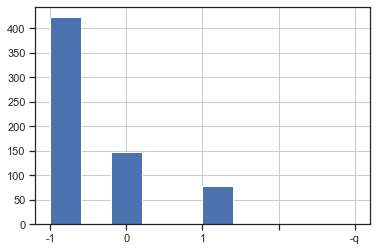

In [21]:
data.sentiment.hist()

# 14.06

In [9]:
politician_screen_names = ('KosiniakKamysz',
                           'DariuszKlimczak',
                           'trzaskowski_',
                           'szymon_holownia',
                           'HannaGillPiatek',
                           'krzysztofbosak',
                           'GrzegorzBraun_',
                           'RobertBiedron',
                           'K_Smiszek',
                           'AndrzejDuda',
                           'Macierewicz_A',
                           'ZandbergRAZEM',
                           'bbudka',
                           'FijoKonrad',
                           'marcinwarchol')

dfs_names = ('kosiniak_tweets',
             'klimaczak_tweets',
             'trzaskowski_tweets',
             'holownia_tweets',
             'gillpiatek_tweets',
             'bosak_tweets',
             'braun_tweets',
             'biedron_tweets',
             'smiszek_tweets',
             'duda_tweets',
             'macierewicz_tweets',
             'zandberg_tweets',
             'budka_tweets',
             'fijolek_tweets',
             'warchol_tweets')

In [15]:
tweets = {}
retweets = {}
ret_list = []
fail_list = []

for i in range(0,15):
    try:
        print(politician_screen_names[i])
        (data, posts) = get_replies(politician_screen_names[i], 10, 10)
        tweets[dfs_names[i]] = posts
        retweets[dfs_names[i]] = data
        ret_list.append(dfs_names[i])
        print('done')
    except:
        fail_list.append(dfs_names[i])
        print('ERROR')
        pass

KosiniakKamysz
done
DariuszKlimczak
done
trzaskowski_
ERROR
szymon_holownia
done
HannaGillPiatek
done
krzysztofbosak
ERROR
GrzegorzBraun_
done
RobertBiedron
done
K_Smiszek
ERROR
AndrzejDuda
done
Macierewicz_A
done
ZandbergRAZEM
ERROR
bbudka
done
FijoKonrad
done
marcinwarchol
ERROR


In [20]:
politician_screen_names = ('KosiniakKamysz',
                           'DariuszKlimczak',
                           #'trzaskowski_',
                           'szymon_holownia',
                           'HannaGillPiatek',
                           #'krzysztofbosak',
                           'GrzegorzBraun_',
                           'RobertBiedron',
                           #'K_Smiszek',
                           'AndrzejDuda',
                           'Macierewicz_A',
                           #'ZandbergRAZEM',
                           'bbudka',
                           'FijoKonrad')
                           #'marcinwarchol')

In [21]:
for i in range (0,11):
    retweets[ret_list[i]]['text'] = retweets[ret_list[i]]['text'].apply(lambda x: x.strip("@"+politician_screen_names[i]))
    retweets[ret_list[i]]['sentiment'] = np.nan

    sent = []
    for index, row in retweets[ret_list[i]].iterrows():
        print(row['text'])
        sent.append(input())
        
    retweets[ret_list[i]]['sentiment'] = sent

 @nowePSL Gratulacje i ogromne dziękuję dla mieszkańców. ❤️


 1


 @nowePSL Gratualcje


 1


 @nowePSL To mały krok dla człowieka, ale wielki skok dla ludzkości.


 1


 @nowePSL https://t.co/xkuapfZ6r7


 0


 @SlawomirNitras @nowePSL A kiedy uregulujecie kwestię bandytów drogowych jadących drogą 10 w okolicach Drobina?


 0


 @nowePSL Władeczek szkodzi, klakier klaszcze Jażdżewskiemu obłudnie się uśmiecha.


 -1


 @nowePSL Czyli jeszcze są „swoi od elewatora” 😂😂😂


 -1


 @SlawomirNitras @nowePSL Gratulacje. To kolejny mały kroczek w kierunku "Żeby było tak jak było"


 1


 @nowePSL Serio ? ;) Jesli tak to kolejna miejscowosc ktora powiedziala NIE PiSowi. 13 czerwca czarnym dniem tej partii :)? To juz 3 lupien : Warlubia, Rzeszow i teraz Drobina. Najbardziej dotkliwe dla PiS sa porazki w malych miejscowosciach! Oby tak dalej!


 1


 @nowePSL Może czas zacząć walkę z PIS odzyskanie polskiej wsi!


 1


 @nowePSL Byłam kiedyś w Drobinie-dziura jakich mało. PSL może sobie tam siedzieć do końca świat


 -1


 @nowePSL W ostatnich wyborach wasz kandydat miał 69%. Ile teraz? https://t.co/ecBLawygmG


 -1


 @nowePSL Gratulacje! 🥳🥳🥳🥳🥳 🥳🥳🥳


 1


 @nowePSL Tygrys nie osikaj się


 -1


 @nowePSL Ten Drobin to na Słowacji? Bo my z nimi dziś charatamy w gałe? Żeby nie było jakiś podejrzeń?


 -1


 @nowePSL Gratulujemy!


 1


 @nowePSL Gratulacje 👏


 1


 @nowePSL Gratulacje.


 1


 @nowePSL Tęczowa gmina? https://t.co/H689L2Ip09


 0


 @nowePSL Krok po kroku, krok po kroczku, dokończymy w tym roczku 😉


 1


 @nowePSL O Boże !!! sukces który szeroko odbije się we Wszechświecie 😂😂😂😂


 -1


 Za mądry na szczebel centralny PSL!


 -1


 Ty tygrysku nawet sołtysem byś nie został, gdyby ciemna masa nie wprowadziła cię do Sejmu, tak że ten...


 -1


 Kłopotek to jeden z niewielu u was, który jeszcze trochę myśli. To nie wasza zasługa.


 -1


 Jak śpiewała pewna piosenkarka , cieszmy się z małych rzeczy 😉


 1


 Mocny zjazd... Jak Champions League do klasy A. Gratulacje.


 -1


 A Emilce nikt z PSL nie gratulował !!!  😂😂😂


 -1


 Będą kraść zasłużenie .Do Kukiza dotarło jakie z was partyjne śmieci ?


 -1


 Ten wasz Klopotek jest  mentalnie w pisie.Klopotek,ktory zawsze robil klopoty.Zadne pocieszenie!


 -1


 Mam nadzieje, ze bedzie sie samoograniczal w zatrudnianiu czlonkow rodziny, chociazby, zeby odroznic sie od PiSu.


 0


 I to jest granica jego niekompetencji wg zasady Petera...


 -1


 Desantowcy z ogólnopolskim poparciem na 2%... wiedzą że idą do lamusa to szukają intratnych posadek w samorządach....


 -1


 hm!...księża odetchnęli.. no cóż takie życie, tak mi się napisało wspominając KŁOPOTKA ale lepszy on jak pisowiec czyli zło konieczne przemyślane..


 0


 I tam powinien juz zostac.


 -1


 Gratuluję 💐


 1


 Nie czas na zmianę pokoleniową? Mało jeszcze Kłopotkowi?


 -1


 To się nazywa zjazd 😂


 -1


 Będzie miał okazję się nachapac. To PSL potrafi znakomicie, trzeba to uczciwie przyznać.


 -1


 oby masło z Warlubia nie straciło swojej jakości bo będzie kłopotek 😉😄


 -1


 Z posła na wójta.A taki był wyszczekany i wymądrzał się...Na wsi jego miejsce i basta.


 -1


 👍👏👏👏🍀


 1


 Tygrysie spadaj do sklepu z marchewką.


 -1


 Brawo Panie Kłopotek !
Niech sie Panu wiedzie!


 1


 Gratulacje. To cieszy. Powinniście odzyskiwać polską wieś i nie tylko. To już pierwsza gwiazdka, która świeci jasno do oczekiwanych zmian.


 1


 Jak to Kukiz o was mowił?


 -1


 Wlasciwy czlowiek wreszcie na wlasciwym miejscu :)


 1


 Da się? Oczywiście!  Narodzie, pobudka!


 1


 Ja lubię Pana Kloptka.Brakuje  go e sejmie


 1


 A co z Kołudą Wlk? Był dyrektorem IZ ?


 0


 a jeszcze w piątek wojewoda kujawsko-pomorski wrzucił tweeta, jak przekazuje gminie kasę z Funduszu Inwestycji Lokalnych. Teraz ten tweet jest juz usunięty.


 0


 @nowePSL a żona klopot


 0


 Niestety jeden z gorszych szkodników z poprzedniej kadencji. Dobrze że już nie jest w polityce centralnej


 -1


 Ok, to gdzie się spotka7


 0


 O czyzby PiS dzisieijszego dnia uzyskal sromotne zwyciestwo. Btw, czy moglby Pan zadbac o obwodnice Szczecina. Pan prezes obiecal w Rzeszowie wiec warto teraz to spelnic :)! Nas w Szczecinie nie interesuja wyniki Rzeszowa :)!


 1


 Całe lokalne LGBT go poparło?


 0


 Wrócił do korzeni. 
Coś jak ten perz z miedzy...


 0


 Drogę z Warlubia w kierunku Kościerzyny mógłby poprawić. Jedzie się jak na podkładach kolejowych. I coś zrobił z tą zwierzyną pasąca się przy drodze. Bo albo jeleń, albo stado łań.


 0


 To ile to Kłopotek wytrzymał bez władzy i darmowych pieniędzy, rok?


 -1


 @SlawomirNitras Wow! 
z wielkiej polityki, zeszliście Pañstwo na świętowanie, ze jeden z Waszych głównych baronów, został wojtem w Pikutkowie...


 -1


 @nowePSL Warlubie - miasto kłopotów.


 -1


 @SlawomirNitras Teraz dopiero zaczną się kłopoty 🙃😅


 0


 Dziękuję ✌️


 1


 @FijoKonrad Czy w obliczu tego sukcesu ma Pan zamiar nadal ględzić o „dwóch blokach”?


 -1


 @FijoKonrad Jaki sukces? Zawsze Rzeszów był antypolski. W regionie ludzie inaczej głosują. Nic w Rzeszowie więcej żeście nie ugrali.


 -1


 @FijoKonrad Tęczowy Władek i tęczowy fiołe


 -1


 @Iwona84139743 @FijoKonrad A teraz, Panie Władysławie, własne ambicie wsadźcie w kieszeń i dogadajcie się wspólnie z resztą opozycji.
TU CHODZI o POLSKĘ.
Te same słowa kieruje do @bbudka i @wlodekczarzast


 1


 @FijoKonrad Tygrysek z PO Jesteś skończony tygrysku Powiem grzecznie Spadaj


 -1


 @FijoKonrad 👍✌️


 1


 @FijoKonrad Tęczowy Władysław 😁


 -1


 @nowePSL @FijoKonrad Do budy! Pasożycie jeden.


 -1


 @FijoKonrad To znaczy,że dla PSL nie ma już miejsca na scenie politycznej...


 -1


 @FijoKonrad Braw


 1


 @FijoKonrad Brawo! 👏


 1


 @FijoKonrad Cieszysz się kolorowy Tygrysku że teraz i w Rzeszowie powstaną pedalskie hostele i grzebanie dzieciom w majtkach przez edukatorów Marksistowskich? To sprzedawczyku tak cię bawi? To odwet i zemsta na Polakach że nie zostałeś zdradzieckim premierem, po bolszewickim puczu?


 -1


 @FijoKonrad 🖕


 -1


 @FijoKonrad Chcesz widzę iść z PO na dno tygrysku.


 -1


 @FijoKonrad Tylko zjednoczeni możemy wysadzić Kaczystan z siodła! Zrozumcie to wreszcie.


 0


 @FijoKonrad Gratulacje! @FijoKonrad


 1


 @BB_Termalica @_Ekstraklasa_ Wlczycie z dysktyminacja kobiet, ale milczac na temat mężczyzn ktorzy dla zwyciestwa w wielu dyscyplinach sportowych raptownie poczuli sie kobietami. Ci przekreciarze dostaja nominacje olimpijskie! Lewackie babochłopy wspieraja upodlenie kobiet i ich ciezkiej pracy!


 -1


 @BB_Termalica @_Ekstraklasa_ a gdzie radomiak? radomiak rowniez walczyl do konca i co?


 0


 @BB_Termalica @_Ekstraklasa_ Mamy wielką nadzieję, że znów spadną z hukie


 0


 @BB_Termalica @_Ekstraklasa_ A co np. z  żużlem, Unią Tarnòw?


 0


 @BB_Termalica @_Ekstraklasa_ Władek, ja zawsze myślałem że piłka jest dla kibiców...nie to że Nieciecza ich nie ma...


 0


 @BB_Termalica @_Ekstraklasa_ Jest Pan według mnie najlepszym kandydatem na prezydenta.


 1


 @BB_Termalica @_Ekstraklasa_ Proszę o chociaż o odczytanie wiadomości. Pozdrawiam serdecznie


 1


 KEEP IT UP!!!


 1


 Jaki dobry samarytanin*tylko nie płacz za długo.


 -1


 Jeżeli ktoś się musi modlić, bo uważa że to dobrze, to niech tak robi, ale nie musi się tym publicznie chwalić. Same myśli wystarczą. Tym bardziej, że chodzi tu o człowieka, który chciał być premierem. Świeckość w publicznych wypowiedziach powinna być czymś oczywistym.


 -1


 I chuj...lansik..jak to u mietnot "polityków" bywa...tfu...jest raczej normą.


 -1


 A może zamiast modlenia się gościu zadbasz o edukację, żeby w szkołach uczyli pierwszej pomoc


 -1


 Co ma modlitwa wspólnego z zawałem?


 -1


 I TY POSŁEM jesteś?  GŁUPKU -TUMANIE.


 -1


 Już widzę, jak WKK się modlił. Po co to puste gadanie?


 -1


 https://t.co/RqsbRfuDFQ


 0


 @nowePSL A co Pan na takie zachowanie https://t.co/idtzA9funJ


 0


 PiS ma dyplomację zaśniedziałego jajka.


 -1


 Obawiam się, że właśnie tak się to skończy.


 0


 @PolskiSenat @Koalicja_PL O jest Pani Poseł Ścigaj &lt;3


 0


 @nowePSL @pisorgpl @FijoKonrad Jaka demokratyczna opozycja trollu obesrany? Czy to nie obywatele wybierają, tylko wy się wybieracie pasożyty? Bardziej szkodliwej jak rząd PO-PSL to dotąd w Polsce nie było.


 -1


 @pisorgpl @FijoKonrad Czekam na Warlubie i Drobin.


 0


 @PSL_Lodzkie A co nasz Polaków obchodzi ZSL,obłudnik udający partię chłopska, a UE parlamencie głosowali za odebraniem Polsce i Polakom  nie rządowi pieniądze należące do Polski i Polaków. Przede wszystkim rolnikom Polskim,gdyż są dużym odbiorcą dotacji z uni,i to się mieni partią chłopską.


 -1


 @PSL_Lodzkie Gratulacje! Powodzenia dla nowych władz w Łodzi. :)


 1


 @PSL_Lodzkie Gratulacje i powodzenia!!!


 1


 @PSL_Lodzkie Kolega Stanisław Wyrwas został odznaczony orderem im. Wincentego Witosa a kolega Adam Kacprzycki odznaką złotej koniczynki. @nowePSL https://t.co/X9XMX5MLq6


 1


 @PSL_Lodzkie Gratulacje!!!


 1


 @PSL_Lodzkie Dziękujemy koledze @DariuszKlimczak za obecność na łódzkim zjeździe PSL.


 1


 @PSL_Lodzkie Serdecznie gratuluję.


 1


 @PSL_Lodzkie Gratulacje dla Michała 👍.


 1


 O to chodzi 👍


 1


 @StefanKrajewski " Najlepsze przed Toba"? Mam nadzieje, ze zona Stefana tego nie czyta.🤣


 0


 @MorawieckiM @nowePSL Gnida dała gło


 -1


 @MorawieckiM @nowePSL Liczą się zdjęcia, przecięcia wstęgi, uściski dłoni i wycieczki z zakładów pracy. Nieistotne, że ktoś inny się przy tym napracował. To takie pisowskie.


 -1


 @MorawieckiM @nowePSL Nie bójmy się nazwy @PO_Lodzkie 😉


 0


 Stare ale jare i prawdziwe


 1


 A pan gdzie pracuje chyba u brata z brat dziury łata https://t.co/WjU9XFTDgA


 -1


 Super, z marionetkami się nie rozmawia.


 1


 No bo truskawki rzucili po 12,50


 0


 Siema Rysiek Cebula.


 0


 Oj, Pan Hołownia nie umie po polski?


 -1


 Szymek
Weź ty się nie wpierdalaj w poważną politykę


 -1


 Symuś,będzie płakane?


 -1


 I zrobiła bardzo mądrze. Uszanowała swój czas.


 1


 Dialog z wami ?przecież wy nie macie poglądów Jednego dnia chcecie  zamykać Turów drugiego nie zamykać. Opinie w zależności od pogody ,jak wiatr zawieje a na koniec zrobicie to co KO poleciło jesteście tratwą PO


 -1


 Brawo pani Staron.Z odpadami platformerskimi i pacynkami z TVN sie nie r


 -1


 A Hołownia umie w dialog?


 0


 U Krzysztofa Bosaka chyba też się nie pojawiła.


 0


 Z czystej ciekawości. Czy odwiedziłeś już neurologa? Usta coraz bardziej masz wykrzywione.


 -1


 Kaznodzieja (przeterminowany chrześcijanin) i prezenter TVN Szymon Hołownia jest produktem.
Niestety, załączony do produktu kod kreskowy nie uwzględnia producenta, miejsca produkcji, składników oraz daty przydatności do spożycia.
Jednym słowem produkt do niczego niepotrzebny. https://t.co/N0QjHWUpX9


 -1


 Dwa tysiące pięćdziesiąt 🤦


 -1


 Oglądał Pan wczoraj na Polsacie Państwo w Państwie. Przecież ta kobieta zachowywała się gorzej niż w remizie w wybory sołtysa. Chciałby Pan żeby na was krzyczała. Ludzie z okien wyskakują co to za kobieta. Kandydat na RPO ratunku!


 -1


 Chłopczyk z Pana, i tyle...


 -1


 Pewnie zobaczyła Pana filmiki i zdecydowała że nie ma sensu. Nie dziwię się.


 -1


 No to ma już przegranom pozycję


 -1


 Zamknij mordę pajacu z tv


 -1


 Pani Staroń umie tylko w monolog: ja, mnie itd


 -1


 Oj Szymek, a ty nie umiesz w posiadanie własnych poglądów.


 -1


 Pani potrafi tylko krzyczeć i skrzeczeć


 -1


 Takie, manipulacyjne pytanie sugerujące 🤔.
Cwany Szymuś ☝️


 -1


 Coraz  więcej  faktów  z przeszłości  Pani Senator  wypływa  na powierzchnię . I nie  są  to przyjemne sprawy ..


 -1


 Pani Senator jest na tak żenującym poziomie, że poza TVP zawsze wypada tragicznie, więc prewencyjnie odwołuje spotkania. Jedno robi dobrze: ''Lepiej nie mówić nic i sprawić wrażenie głupca, niż odezwać się i rozwiać wszelkie wątpliwości''.


 -1


 Oj chyba nie Szymon to pisał.


 0


 Oj, ale to chyba nikogo nie dziwi?


 0


 Para-PiSowcy tak mają...


 -1


 @FijoKonrad Gratulacje @FijoKonrad


 1


 @FijoKonrad Brawo 👏💛 Rzeszów 💛


 1


 @FijoKonrad Do Rzeszowian, jeśli tak będziecie dalej wybierać to ja osobiście myślę, że jak wam uchodźców sprowadzą, to oni was szybko nauczą rozumu tak?


 -1


 @FijoKonrad Zwycięstwo w pierwszej turze w Rzeszowie to dowód, że tylko zjednoczona opozycja ma szansę zwyciężyć nad PiSem.


 1


 @FijoKonrad Płacz Szymek , płacz https://t.co/w4OMEnxMtu


 -1


 @FijoKonrad https://t.co/s3sn5LHJKe


 0


 @FijoKonrad https://t.co/3YIAVnLcvZ


 0


 @FijoKonrad Przyczepiło się gówno do okrętu i mówi, płyniemy.
🤦🏻‍♂️


 -1


 @FijoKonrad Promyk nadziej


 1


 @FijoKonrad Panie Szymonie do dzieła ! Liczymy na szybka orientacje 🐋


 1


 @FijoKonrad Najlepszy kandydat. Jedyny kandydat https://t.co/Ra12XWmfR6


 1


 @FijoKonrad Obyś wyciągnął z tego wnioski , schowaj swoj narcyzm i tylko zjednoczeni wygracie z mafią @pisorgp


 1


 @FijoKonrad A wiesz dlaczego? Bo opozycja się dogadała zamiast kopać po kostkach.
Zapamiętaj!


 1


 @FijoKonrad 2/2
Liczyli i się przeliczyli? https://t.co/Pz5UqqdB


 -1


 @FijoKonrad 1/2
Tak liczą pisowcy aby rachunek zgadzał się im podczas ich rządów, a później będzie tak jak na drugim filmie w cz 2/2 https://t.co/dHNjpNqxuD


 -1


 @FijoKonrad Daje to coś do myślenia czy od jutra dalsza napierdalanka w opozycji?


 -1


 @FijoKonrad https://t.co/LYSOMvzxE


 0


 @FijoKonrad https://t.co/CIL9s2t9wr choruje na SMA . Nie bądź obojętny.


 0


 @FijoKonrad Najważniejsze, to nie dać się wkopać w żadną koalicję z PO przed wyborami.


 0


 @wchalecki1 @FijoKonrad Zgoda buduje, niezgoda rujnuje. 
Ame


 1


 @FijoKonrad bo jak się w swej różnorodności dla ważnego celu jednoczy to wychodzi i to dobrze


 1


 @FijoKonrad Już przeszedł do twojej partii? Nie? To zrób z tym coś.


 1


 @FijoKonrad No i...?


 0


 @FijoKonrad Brawo 👏


 1


 @FijoKonrad Jaki wniosek z tego zwycięstwa Panie Hołownia? Tylko razem bo pojedynczo przegracie. Mam nadzieję , że dotarło.


 1


 @FijoKonrad Ale to pokazuje jedno jak silnie jest iść wspólnie. Lepiej by było gdyby Pan nie okladal KO w każdym wywiadzie A wspólnie walczył z PiS


 1


 @FijoKonrad Brawo Rzeszów  👏👏👏✊ , gratulacje prezydencie


 1


 @FijoKonrad Jaka błyskawiczna reakcja - tym razem nie trzeba było uzgadniać wypowiedzi? 😂


 1


 @FijoKonrad Czyli Rzeszów poległ. Żal chwyta, ze kolejne miasto zduraczone. A ciebie szymonku tez zniosą jak się znudzisz. Wtedy nawet rada atlantycka pieniazka nie sypnie. Gardzę tobą.


 -1


 @FijoKonrad @MarcinSzczygiel W końcu coś dobrze zrobiliście. Brawo. ;)


 1


 @FijoKonrad Wyrazy współczucia ślę do mieszkańców Rzeszowa 
Otwierać portfele jełopy..
Dobrze to już mieliście


 -1


 @FijoKonrad Brawo Rzeszów, Brawo Opozycja 👏👏


 1


 @FijoKonrad Mam nadzieję, że da to do myślenia dla CAŁEJ demokratycznej opozycji.


 1


 @FijoKonrad Gdybyś nie rozbijał opozycji, też byłaby szansa w wyborach parlamentarnyc


 -1


 @szejnfeld @FijoKonrad Teraz Pan rozumie swoją rolę w opozycji.


 0


 @FijoKonrad Rozliczyć Warchlaka z publicznych pieniędzy.


 -1


 @FijoKonrad Ile będziesz miał lat w 2050 .
Według tego roku to dopiero w 2050 będziesz rządził czy jak❓


 -1


 @FijoKonrad A to ty z PO jednak?


 -1


 @FijoKonrad To zdecydowanie kamień milowy w walce o Polskę naszych marzeń. Dziś wygrana w Rzeszowie, a za kilka lat w Polsce!


 1


 @FijoKonrad Obyś się nie sprzedał jak ta Szmata (Kukiz)


 -1


 @FijoKonrad Rzeszów posłuchał Fijołka i pojedzie na wakacje! Super wiadomość!


 1


 @FijoKonrad https://t.co/ZUZUY8G62R


 0


 @FijoKonrad Fajny ten Hołownia, taki niezależny i niepowiązany z żadną ze starych p


 0


 @FijoKonrad Mam nadzieję na wyciągnięcie logicznego z tego wniosku: opozycja ma pójść raze


 1


 @FijoKonrad Brawo, oby się potwierdziło !!! Rzeszowianie gratuluję Wam dobrego wyboru !


 1


 @FijoKonrad Brawo👏. Zawsze mówiłam, że Rzeszów jest wspaniały, a rzeszowianie cudowni :). Gratulacje dla Konrada Fijołka.


 1


 @FijoKonrad To w końcu Rzeszów czy Wrocław?


 0


 @FijoKonrad Wielkie Gratulacje 🎉🎉🎉 Brawa dla rzeszowian 👏👏👏👏


 1


 @FijoKonrad nie to co Ty,  nigdy niczego pewnie nie wyg


 -1


 @FijoKonrad A DPS-y już zliczone?


 0


 @FijoKonrad Mija 7 min a Tvp info nic cisza🤷‍♂️. Żadnych informacji o wyborach o wynikach . Wiecie może dlaczego??🤔. Fiołki w cenie !!!!


 0


 @FijoKonrad Teraz czas na RPO...


 0


 @FijoKonrad Będą spendy 👬⚡ pod Wielką Cip


 0


 @FijoKonrad Czyli jednak wspolpraca sie oplaca. Szkoda ze na skalę kraju walicie sie kłócić i przepychać jak nastolatki.


 -1


 @FijoKonrad W końcu pozytywna informacja w polskiej polityce


 1


 @FijoKonrad Czyżby mieszkańcy Rzeszowa aż tak zgłupieli? A może ten wynik już był znany zanim zaczęto liczyć głosy?


 -1


 @FijoKonrad Tylko zjednoczona opozycja może pokonać imperium zła Kaczyńskiego. Czy jakby opozycja wystawiła osobnych kandydatów to tak by się to skończyło ??


 1


 @FijoKonrad Ciekawe czy Warchoł zabrał już pieniądze strażakom.


 0


 @FijoKonrad Wzruszony?


 0


 @FijoKonrad Brawo! I co Wy na To @MorawieckiM @pisorgpl  co zrobicie aby unieważnić te wybory ?


 1


 @FijoKonrad Teraz zabieramy się za cały kraj z takimi procentami :)))


 1


 @FijoKonrad Gratulacje dla rzeszowian!!


 1


 @PL2050Sw https://t.co/Sk9mDvvdnY


 0


 Kto tam płaczka tvnowskiego wpuścił?


 -1


 I co w pół drogi żeś się jełopie rozpłakał że Czeszkę zobaczyłeś bo się bałeś pe-Piczki.A ty nadal Polaków dzielisz nie łączysz bo ciągle w Polsce mieszasz i jątrzysz. Wiec przestań kłamać o łączeniu europy, akurat możni tej europy to dbają tylko o siebie a nie o wszystkich.


 -1


 @wroblewski_m @wirtualnapolska Oczywiście! W wyborach parlamentarnych przede wszystkim należy się PODZIELIĆ. To oczywisty wniosek po wyborach w Rzeszowie i absolutnie podstawowy warunek, bez którego bycie partią opozycyjną w Polsce po prostu nie ma sensu.


 -1


 @wroblewski_m @wirtualnapolska bo...?

zacznijcie myśleć logicznie i w nawiązaniu do realiów, a nie partyjnych szyldów

JEDNA LISTA sprawdza się jak najbardziej - bo lista to nie program

chyba ze chcecie jedynie WEJŚĆ do sejmu, a niekoniecznie WYGRAĆ z PIS


 1


 @wroblewski_m @wirtualnapolska Tak, tak - idźcie ta drogą https://t.co/9p4S7I3HAg


 1


 @wroblewski_m @wirtualnapolska Rzeszów jest czerwony od 20 lat ,widać że nie ma pani pojęcia o polityce i Rzeszow


 -1


 @wroblewski_m @wirtualnapolska I w bastionach PO :)


 0


 @wroblewski_m @wirtualnapolska Rzeszów to raczej nie był "bastion PiS" ;)


 0


 @Pawel_Fapo @wroblewski_m @wirtualnapolska Głosowaliśmy na Fijołka i poparcie opozycji nie ma tu nic do tego !!!


 0


 @wroblewski_m @wirtualnapolska Kandydat w poprzednich wyborach bez poparcia miał lepszy wynik😜


 0


 @MartynaWM @wroblewski_m @wirtualnapolska Przecież wy nie potraficie współpracować !!! Kilka dni po rzeszowskiej wiktorii znowu się zaczniecie nawalać łopatkami po głowach !!!


 -1


 @PL_2050 @konradfijolek @AnnaSkibaT Z tego co wiem na wyniki trzeba jeszcze poczekać. Dziękuję jednak Pani poseł za informację, że stołki już obsadzone 😉


 -1


 @konradfijolek @AnnaSkibaT @PL_2050 Super 🎉 Gratulacje 🎊 👏 🎉


 1


 @konradfijolek @AnnaSkibaT @PL_2050 Gratulacje Pani Aniu.


 1


 @konradfijolek @AnnaSkibaT @PL_2050 Gratulacje!


 1


 @konradfijolek @AnnaSkibaT @PL_2050 Bardzo dobra wiadomość💛🌻


 1


 @konradfijolek @AnnaSkibaT @PL_2050 Kurwa ja naprawdę nie żartuję i jeszcze nue jestem poważny. Macie się zająć tym czym mówię, bo zrobie z wad mielonkę. https://t.co/jwzWJiPHe5


 -1


 @konradfijolek @AnnaSkibaT @PL_2050 Super 👌 💛 🌳 💛


 1


 @Kongres_RM Pierdolisz od rzeczy. Czyste powietrze wam w głowach. Wyczyść teren z patologii chodowanej przez państwo. Zjeby doskonale wiecie, że siedzę na szlaku narkotykowym. I co? I gówno? Jesteście sprzedanymi śmiećmi wszyscy tutaj jak jeden. Za pieniądze gówno żrecie. Brzydzę się wami. https://t.co/C3XderhkFZ


 -1


 @Kongres_RM Słyszycie @PO_Lodzkie działamy 💪


 1


 Jestem pesymistka, ale trzymam kciuki🤞


 1


 Oby tak było pani poseł


 1


 Doedukuj się kto rządził w Rzeszowie od 2002 ... Bez promptera z Mam Talent to o niczym nie macie pojęc


 -1


 Tęczowa głupiutka babuleńko, dalej zostaniecie w tym miejscu gdzie jesteście, Rzeszów zawsze oddawał komuniście rządy i tym razem zrobił to samo. Rzeszów, Warszawa, Poznań i inne większe miasta to nie całą Polska, nigdy postkomuchy i dewianci nie będą rządzić Polską. Nie dziękuj


 -1


 Bzdura. Wynik w Rzeszowie o nicz nie świadczy. Tu nigdy PiS nie rządził, więc to żadna rewolucj


 -1


 Bastion PiS-u to Podkarpacie. Rzeszów to wprawdzie też Podkarpacie, ale cywilizowane. Przestrzegał bym zatem przed nadmiernym optymizmem.


 0


 17 co do wielkości miasto. Tak krytyczna wygrana i wydarzenie polityczne. Co to za cyrk?


 -1


 Hahaha!!!😂😜
Poważnie?


 -1


 PiS nie miał prezydenta w Rzeszowie..


 0


 Nie rozumiem tej euforii, przecież Rzeszów nigdy PISowski nie był


 -1


 Mimo wszystko przestrzegałbym przed odtrąbianiem sukcesu. To nadal jest PiS i Kaczyński nie zgodzi się na skrócenie kadencji Sejmu od tak. Po za tym nawet jak się zgodzi to wykorzysta wszystkie zasoby państwa aby utrzymać się przy władzy.


 0


 W bastionie PISU???  Przecież w Rzeszowie PiS nie rządził???


 -1


 Bastion PiS.u? Coś ci się kobietko popieprzyło.
https://t.co/Ap4gr3dOTC


 -1


 🚑🚑🚑


 0


 W nowej rzeczywistości, bo komucha Ferenca zastąpił komuch Fijołek😂😂😂
Rzeszów to taki sam bastion PIS jak wszystkie inne duże miasta w Polsce gdzie od lat rządzą czerwoni😀


 -1


 Po tym, jak @__Lewica się raduje ze zwycięstwa libka w Rzeszowie, trzeba jeszcze raz bardzo uważnie się zastanowić kiedy przyjdzie oddawać glos. Odda człowiek glos na lewica a wyląduje w rzeczywistości sprzed 2015.


 -1


 Pytanie czy doniesienia o tym, że PO chce uwalić Wiącka okażą się prawdziwe. Ze strachu przed wyborami mogą się do tego posunąć.


 0


 Ani w tym polityki, ani socjologii. Jakieś bajki i pobożne życzenia.


 0


 A jak nie to szymuś będzie płakał?


 -1


 W mieście zawsze komuna rządziła, w regionie nie !


 0


 Niestety nie potoczą.


 -1


 Rzeszów 'bastion pis'? tam w 2018 Ferenc z SLD! został prezydentem z 63 % poparcia w I turze.


 -1


 Rzeszów to nie Podkarpacie, to nie był żaden bastion.
Co do reszty, czekam aż cała opozycja zmądrzeje.


 -1


 Teraz wzorem kolegów z kilku miast strefy parkowania 8zł/h i podwyżki za wodę i wywóz śmieci 150%. Lemingi mają bardzo wysoko ustawioną granicę bólu a tefałeny im to wszystko rozrysują i wytłumaczą.


 -1


 Bastionem PiS jest podkarpackie, a nie Rzeszów, gdzie od 20 lat rządził prezydent z SLD, który wcześniej przez wiele lat był w PZPR.


 -1


 A co ty gadasz ? Było 64%  w 2018 a jest 54%, straciliście 10% :-)


 -1


 Oby. Trzymam kciuki. I jeszcze poczekam z otwarciem bąbelków.


 0


 I co będę klękał przed czarnuchami i pedałami chodził trzepać konia pod damski prysznic bo stwierdzę ze czuje się kobieta i zwężą mi wszystkie ulice w Wawie plus wszędzie będzie płatne parkowanie ?


 -1


 Potoczą się szybko jak zmiany stanowiska płaczliwego Szymcia ws Turowa ?


 -1


 Bastion w którym od kilkunastu lat rządził postkomunis


 -1


 https://t.co/E0UU7cNVt0


 0


 Pani żyje w innej rzeczywistości - to tylko Rzeszów, tu zawsze wygrywał  były człowiek PZPR 🤬🤣🤬🤣


 -1


 Rzeszów to bastion komuny.


 -1


 Zwycięstwo czerwonego kandydata w czerwonym bastionie. Tyle warte, co zwycięstwo w Legnicy albo Szczecinie.


 -1


 @PL_2050 Jakie scenariusze w głosowaniu nad RPO?


 0


 Od kiedy Rzeszów był bastionem PiS?


 -1


 A może obudzicie się we Wrocławiu?


 -1


 🤣🤣🤣było brane?


 -1


 Od kiedy Rzeszów był bastionem PIS? Podkarpacie ogółem może i tak ale nie sam Rzeszów 🤦‍♂️


 -1


 tak, Polska to Rzeszów i Wilanów. Tkwij w tym śnie dalej.


 -1


 Leczże się, antypolska gangreno bolszewicka ...


 -1


 Oby to były prorocze słowa. Trzymam kciuki🤞, dość już (nie) rządów Pis ✌️


 1


 A ty ile dostałaś głosów ?


 -1


 A jakiego PiSiorka na urzędzie prezydenckim zastąpił Fijołek w Rzeszowie!???😄😝😁


 -1


 Ns ten moment bastionem PiS jest większość wybierających i deklarujących dla tej partii poparcie Polaków. Wierzę, że idzie nowe, ale powoli i mam wrażenie, że to jeszcze nie ten czas.


 0


 Myslenie zyczeniowe :D


 -1


 Obudzimy sie dokładnie w tym samym miejscu. Proszę nie przesadzać.


 -1


 Ale pierdololo😬


 -1


 Rzeszów to nie jest bastion PIS, Ferenc 3 lata temu miał w bastionie PIS 64% w pierwszej turze, rządził tam z 20 


 -1


 I ja tak myślę, ale damy radę ;-)


 1


 @ADerewienko @FijoKonrad @PL_2050 Nie, to nie jest doskonała wiadomość dla całej Polski.
Nikt cię Haniu nie upoważnił do wypowiadania się w jej imieniu. Do zabierania głosu w imieniu Polski jest prezydent Andrzej Duda,


 -1


 @FijoKonrad @PL_2050 To doskonała wiadomość 😀


 1


Wielkie uszanowanie dla całego sztabu @FijoKonrad, szczególnie dla @AnnaSkibaT i całej rzeszowskiej ekipy @PL_2050 zaangażowanej w jego kampanię.


 1


 @FijoKonrad @PL_2050 Świetna wiadomość! Gratulacje!


 1


 Pani Staroń, kiedy nie mówi, jest nawet sympatyczna.


 0


 Co ja będę robiła dla ochrony praw obywateli? Oczywiście wszystko będę robiła, bo narzędzi jest dużo
— powiedziała Staroń..Także no..Pan Procyk (ten niesłusznie miesiącami przebywający w areszcie - dzięki zaangażowaniu kandydatki) to nie jedyny jak widać problem kandydatki 🙈


 -1


 Gil z nosa od Chujowni.


 -1


 Droga pani RPO jest nie od gadania, a od działania.
Pani dużo mówi tylko treści w tym mało.


 -1


 @PL_2050 I naprawdę nic nie mówi o Wiącku tylko o sobie? Niesamowite...


 -1


 @PL_2050 Słuchaj! Może sie czegoś nauczysz.


 -1


 Hania, napisz proszę, jeśli Pani Senator powie coś ciekawego. Bo ja mam zaliczenie ze zobowiązań dziś i nie mam jak słuchać na bieżąco.


 -1


 @tzimoch @PL_2050 W jedności siła!


 1


 @tzimoch @PL_2050 Miejmy nadzieję, że będzie to człowiek, który będzie zainteresowany losem jednostki. By nie sugerował się własnymi przeświadczeniami, tylko udzielał pomocy tym, którzy tego potrzebują. Nie możemy pozwolić by ostatnia wolna instytucja stała się polit. przybudówką Pana z Żoliborza.


 1


 Andruszkiewicz wyrósł ponad miarę, a mentalność trzylatka nie urosnąć


 -1


 @esszet2 No bo pan ruchunarodowyAndruszkiewicz taki właśnie jest.  Jak dziecko.


 -1


 @daga772 Przecież Jasne jak słońce, że podstawy BRAK.


 -1


 Tak, najgorszy Twój wynik, 4 miejsce. Rzeszów to stolica lewactwa, mam ochotę stąd wyjechać.


 -1


 Panie Grzegorzu, przegrana to przegrana. Nie pozwolili panu wygrać, bo było by to podważenie ich judeopolityki dawidowej. To pokazuje że gadaniem nic się nie zmieni. Tu potrzeba radykalnych rozwiązań. Ale wiemy że pranie mózgów od 1989r. zrobiło swoje.


 0


 @PCh24pl Szczerze mówiąc to nie bardzo.


 -1


 Pański wynik pokazał że w PL jest około 10% ludzi wolnych chcących urządzać otaczającą rzeczywistość według własnego upodobania. Niestety reszta lubi być pod pręgieżem państwa 'opiekuńczego'.


 1


 Słabe macie ambicje jeżeli wynik niecałe 10% to dla was sukces.


 -1


 Jprld....PO KO pieprzy o nowym impulsie..teraz Braun...Impulsatory się znalazły..


 -1


 To dla beki


 -1


 https://t.co/QSextQZNxl


 0


 Czas wracać do rzeczywistości: Między totalitaryzmem hipochondrycznym i syndromem sztokholmskim a buntem – wrogiem jest zawsze ten, kto dybie na cudzą wolność
https://t.co/bPDTwvhP


 0


 Nie ma problemu. Ufamy Panu w 9,15%.


 -1


 To będzie Pan miał teraz dużo czasu na inne pożyteczne zajęcia - na przykład dalszą analizę problemów, jakie naprawdę są w Polsce, czyli książki i reportaże czy Wałęsa był TW Bolkiem czy nie.


 0


 Zawsze 💪♥️🇵🇱


 1


 Dziękujemy @GrzegorzBraun_  za to co robi dla Polski🇵🇱 !


 1


 To możesz spokojnie wrócić na oddział


 -1


 https://t.co/1QOt5V3h0C


 0


 To gdzie na prezydenta miasta teraz będzie pan startował???Był Gdańsk .. kompromitacja,Rzeszów kolejny https://t.co/pn2978FD3s teraz???


 -1


 Gratulacje! Oby więcej takich sukcesów!


 1


 Morawiecki doklt wiedział co robi, przekładając wybory o miesiąc. Wiedział, że w maju (kiedy większość tzw. obostrzeń jeszcze było) pan Grzegorz miałby dużo więcej poparcia, ale kiedy już trochę otwarli, to byli pewni, że wygra ten kto ma wygrać. I niestety mieli rację


 -1


 Żeby po roku bezprawnych, bezsensownych lockdownów, ciągle wybierać zjednoczoną koalicję covidową, to trzeba być bardzo głupim i zaślepionym. W d****kracji nie mamy co liczyć na cokolwiek. Lud jest tak przyzwyczajony do układu, że boi się zmian. Gratulacie panie Grzegorzu!


 1


 Nie ma za co szefie.


 1


 Gratulacje!


 1


 Gratulacj


 1


 Politycy to są jednak dziwni ludzie...nikt inny tak spektakularnej i sromotnej klęski nie przedstawiał by jak sukcesu...🤣🤣🤣🤣🤣🤣


 -1


 Słaby wynik. Poliniacy dominują również na Podkarpaciu.


 -1


 Odwracając tabelę, Braun na czele!


 -1


 Konfederacją to nie moja bajka, ale szacunek za ciężką pracę i zaangażowanie przy tych wyborach.


 1


 Czekam na start na urząd prezydenta Pierdziszewa Górnego jak już wszystki wybory pan obskoczy ( i oczywiście wszystkie przegra) https://t.co/CmCOt8hgSQ


 -1


 Szkoda Panie Grzegorzu że wygrał układ niewolnictwa od wolności.


 0


 Pan jest księdzem?


 0


 "Bóg zapłać", "Szczęść Boże"🤦. To przykład na to co działoby się w Rzeszowie gdyby to Braun wygrał. Sojusz tronu z ołtarzem🤷


 -1


 Bóg zapłać Panie Grzegorzu!


 1


 Jestem Bóg i zapłaciłem.  Proszę o wydanie reszty jest to 46 622 000 zł.


 -1


 Szału nie ma ale wynik troszkę poprawiony.


 1


 Jest pan jedyny w swoim rodzaju..


 0


 Bóg może nie zapłaci ale czas pokaż


 0


 Pierwszy niezwyciężony..


 1


 Nie ma sprawy!


 1


 Czyli wreszcie może Pan dokończyć film o Gietrzwałdzie.


 0


 I tak pan osiągnął szczyt z takim wynikiem. Gratulacje.


 1


 Gratuluje wspaniałej kampanii. Jednak do kogo to mówić. Krew w piach. Powodzenia w następnych wyborach. Szczęść Boż


 1


 Ale myślałem że pan jednak nie będzie miał honoru i odwagi pogratulować lewackiemu Fijołkowi.


 -1


 Jakie miasto teraz?


 0


 Rzeszów to jednak lewacki rynsztok skoro już lepszy wynik miał @GrzegorzBraun_ w Gdańsku zatem gdyby nie reszta Podkarpacia to tam by nie dało się normalnie żyć


 -1


 Mówiłem, że #faszyzmnieprzejdzie https://t.co/8J5Ga6TtP


 1


 https://t.co/J9FyrkLnV5


 0


 Nadal banda czworga przy korycie Panie 


 -1


 Ile razy można powtarzać słowa Korwina. Zasada raz rządzimy my, raz wy, raz my jest geniuszem okrągłego stolca.


 -1


 Jeśli Grzegorz Braun dostaje ostatnie miejsce w wyborach to znaczy że jednak Bóg istnieje!!! NIE dla udawanego miłosierdzia!!!!
NIE dla pogardy wobec niewierzących!!!!


 -1


 https://t.co/1ct5CTRO1q


 0


 Szkoda że z Podkarpacia nie będzie Teksasu, a wygrana w Rzeszowie była warunkiem. Ja dziękuję Panu posłowi za chęci, ciężką pracę na rzecz uświadamia Rzeszowian i całego Podkarpacia że to nie o Rzeszów czy Podkarpacie chodzi. Stawka jest cała Polska! Nowe wyzwania czekają p.


 1


 Panie Grzegorzu, a co tu szanować.
Wybory pokazują, że większość Polaków jak była głupia, tak dalej jest głupia. Przecież oni wybrali lewaka!!!
Rozumiem, że zrobili na złość PiS-owi, ale czy ich wybór był dobry? Był beznadziejny!

Liczyłem na jakiś przełom, jakiś zwrot w polityc


 -1


 https://t.co/69XCohUMvx


 0


 Jak tam grzesiu ? Udawana pobożność i kwiecisty język bez planu na Rzeszów nie wystarczył wygrać wybory ? Powiedz, po co w ogóle startowałeś skoro od początku było wiadomo że nie masz szans choćby na 15%? Zmarnować pieniądze podatników ?


 -1


 Tworzysz pan sufit dla konfy, nikt normalny nie chce słuchać bełkotu o biciu i obrażaniu obywateli za homoseksualizm albo nazywania rywali szaleńcami, trzeba zaścianek mentalny odciąć od partii wolnościowej


 -1


 Niektórym kagańce i łańcuchy trzeba  zrywać siłą 🤷‍♂️

https://t.co/ltd2Nm4WmT


 -1


 Być może opatrzność uznała,
że jest Pan bardziej potrzebny Polsce, niż miastu Rzeszów.


 0


 Nic na szybko panie Grzegorzu. Pański czas i Konfederacji jeszcze nadejdzie.


 1


 A ja nie.


 -1


 75% ludzi nie poszło w ogóle.


 0


 Przerażony jestem tym ilu Polaków głosowało na faszystów 😲?


 -1


 Biada nam ludzie pragną komunizmu kolesiostwa okradania ich dla świętego spokoju? Dla kiełbasy z supermarketu na grillu i butelki piwa sprzedają się?


 -1


 Panie pośle. Rozpatrując Pana wynik wyborczy w dwóch kategoriach, należy stwierdzić, że... Jest to Pana osobista porażka, porażka człowieka, który każdą mowę zaczyna od Szczęść Boże a potem jedzie po współdyskutantach jak po szmatach 1/2


 -1


 Gratululacje Panie Grzegorzu.Jak to mówią ,,po nitce do kłębka'' kiedyś Polska będzie gotowa na konfederację.


 1


 Wygrał kandydat lepszy, z lepszym programem i z lepszą wizją na prowadzenie Rzeszowem. Pan Panie Grzegorzu niech wraca do Warszawy i zastanowi się w którym mieście teraz startować.


 1


 Kibicuje koncie. Ale nieznaczny procent ludzi was popiera moze musicie coś zmienić. Ciągle mówicie o przedsiębiorcach widać kiepski odzew. Może za dużo anty 500+ ludzie w zmiany systemu podatkowego nie do końca wierzą a teraz maja kasę od razu. Ciężko jest zmienić myślenie.


 0


 Bronił Pan ludzi przed mandatami
Robił happeningi bez maseczek
Natomiast Rzeszowianie z tego tylko skorzystali, a podczas wyborów środkowy palec pokazali.

Syndrom sztokholmski, DNA pt. Dej mnie, zaopiekuj.

Albo coś wymyślicie, aby dostać więcej %, albo non stop około 10%&gt;


 0


 Taaa 😂


 -1


 Jaki nowy impuls? https://t.co/5WtpBff18f


 0


 Porażka totalna konfederacji i Grzegorza Brauna....po takiej kampani uzyskać 9% poparcia..tragedia....trzeba było więcej przebieranek i czapek z daszkiem z logo Batmana.....nikt takich ludzi poważnie nie traktuje co pokazały właśnie wyniki


 -1


 I teraz niech mi ktoś powie, że @JkmMikke nie miał racji mówiąc, że "Głupich jest więcej niż mądrych, dlatego rządzi głupota" 🤨

Niemniej jednak dziękuję Panie Grzegorzu za walkę o normalność i życzę wszystkiego dobrego 👍


 1


 Panie Grzegorzu, niestety żaden impuls nie wyszedł. Jest nawet gorzej niż myślałem. W ten sposób nic nie osiągniemy, walka musi wejść na inne poziomy. Polityczne gadki nic nie dadzą i nic nie zmienią.


 -1


 @GrzegorzBraun_  no i wyszła lipa. Ktoś kiedyś rzekł:" nie ważne jak głosują, ważne jest kto liczył głosy ".


 -1


 Jedyny impuls jaki otrzymałeś to ostatnie miejsce. Zgodnie z przewidywaniami. Zdejmij wargę z nosa i oddal się w podskokach 😂😂😂


 -1


 Niestety tweety są blokowane.


 0


 Panie Grzegorzu, niestety nic nie wyszło, żaden impuls. Jest nawet gorzej niż myślałem. Walka musi zacząć się na innych poziomach. Tak nic nie osiągniemy.


 -1


 ...i Braun zesrany!


 -1


 Faszyści! Mam nadzieję, że to początek końca 🤬


 -1


 😂😂😂 9,15% https://t.co/x9GSz7XaaD


 -1


 @SchwertnerPL Ty jesteś stabilny jak pacjent na OIOMie 😒


 -1


 @SchwertnerPL Ale p.Biedroń wszystko załatwi!!


 0


 @SchwertnerPL Nudzisz. Spieprzaj. Zajmij się może sprawami we własnym kraju w pierwszej kolejności Panie dzisiaj wiosna jutro lewica, ale kasa ma się zgadzać. Cukierkowi jesteście tacy, że się żygać chce. https://t.co/DNE7FYFkbU


 -1


 @SchwertnerPL Robert biedaku Ale Białoruś jest stabilna, a pod rządami dytatora będzie ultrastabilna. Cytując Najmana: Co ty p....sz


 -1


 @SchwertnerPL Wiosna zniknęła ,a on dalej coś ględz o tej małej gromadce ludzi.Pamiętajcie członkowie partii PO ,to jest wasz największy wróg. Wystrzegaj cię się Biedronia.


 -1


 @SchwertnerPL Mam inne odczucie..... Zdecydowanie inne....


 -1


 @SchwertnerPL Sprzedaliście się PiSowi za srebrniki. A Pan z Brukseli nie gra na żadne zjednoczenie.


 -1


 @SchwertnerPL Co ty gadasz Bobbi. Czarzasty cię "odstrzelił" wystawiając cię w wyborach prezydenckich. Zdobyłeś tam promile co pokazało jak popularny jesteś. Teraz zwyczajnie cię zjadł jak 🍤. Kolej na "Wielkiego Duna"


 -1


 @SchwertnerPL Wiosna zjednoczyła dlatego ją rozwiązaliśmy.


 -1


 @KonradPiasecki Dziękuję za ocenę mojej pracy.


 1


 @Adbodnar @KonradPiasecki Czy ktoś kiedyś, odebrał tobie prawo do swoich poglądów? Nic takiego nie miało miejsca, chociaż z pewnością należałoby tą twoją gębę  w końcu zamknąć. Bynajmniej ja tak uważam, gdyż jesteś po prostu zdrajcą Narodu Polskiego .


 -1


 @Adbodnar @KonradPiasecki Naiwna Lewico M.Wiącek na RPO to tragedia!


 -1


 @JoankaSW @KonradPiasecki A to @JoankaSW nie z @Nowoczesna była panie złotousty @RobertBiedron ? Plecie pan androny i zmienia barwy jak kameleon - mam nadzieję, że ci którzy panu tyle razy zaufali i których pan wystrychnął na dudka pokażą panu w następnych wyborach gdzie jest miejsce takich ludzi.


 -1


 @JoankaSW @KonradPiasecki Jest Pan tak wiarygodny jak pana kumpel Morawiecki. #wiopis


 -1


 @JoankaSW @KonradPiasecki Oj chyba @JoankaSW wprowadził @RyszardPetru .


 -1


 @JoankaSW @KonradPiasecki A @JoankaSW wprowadziła do schroniska 2 🐕🐕


 -1


 @JoankaSW @KonradPiasecki XDDD Myślałem że to @czlowiek_


 -1


 @JoankaSW @KonradPiasecki Co ty pieprzysz , tej baby się słuchać nie da. https://t.co/IP3nCv5Xlk


 -1


 @JoankaSW @KonradPiasecki A psy dalej w schronisku czy ktoś je przygarnął? Faktycznie nowa jakość


 -1


 @JoankaSW @KonradPiasecki Kawe Panie Pośle, proponuje wypić kawę.


 0


 @JoankaSW @KonradPiasecki Akurat wprowadzenie  @JoankaSW do sejmu to nie jest powód do dumy - p. Poseł już udowodniła jak potrafi zmieniać swoją opinię o 180 st na życzenie Czarzasteg


 -1


 @JoankaSW @KonradPiasecki A to wiosna jeszcze istnieje , co ten Biedron bredzi 🤦‍♀️🤦‍♀️🤦‍♀️


 -1


 @JoankaSW @KonradPiasecki Czerwoni bluźnili, bluźnią i bluźnić będą. Widać tak mają. Słabe to. Jednak pozostaje coś czemu, mimo usilnych starań, rady nie dadzą - miłość i miłosierdzie Boże.


 -1


 @JoankaSW @KonradPiasecki Pani poseł weszła do Sejmu z listy Nowoczesnej. Do Wiosny się przeniosła. Więc nie, Wiosna jej nie wprowadziła


 -1


 @JoankaSW @KonradPiasecki XD


 -1


 @JoankaSW @KonradPiasecki To @RyszardPetru wprowadził @JoankaSW 🙃


 -1


 @KonradPiasecki Od kiedy to koalicja rządząca - tu PiS-Lewica, kreśli scenariusze dla opozycji?
Macie już rozdwojenie jaźni? Najpierw utrzymujecie PiS u władzy, a potem bredzicie o zwycięstwie nad nimi?
Jakaś epidemia Konradów Wallenrodów?


 -1


 @KonradPiasecki "ludzi dobrej woli" to z 2 osoby znajdziec


 -1


 @KonradPiasecki Już raz nakreśliliście scenariusza dla opozycji. Usiedliście do stołu z PiSem, uratowaliście pisowską koalicję, wielu wam tego nie zapomni. Zdradziliście nie tylko kolegów z opozycji. Zdradziliście Polaków, którzy nie zgadzają się na to co PIS wyprawia w kraju.


 -1


 @KonradPiasecki Powiedział to ten, który opozycję dzielił. Zdążył już sztandar wyprowadzić, a teraz ma dobre rady 🤦‍♂️.


 -1


 @KonradPiasecki Tak Panie Robercie. Od dawna wielu o tym mówi, że cała opozycja powinna współpracować, do czego zachęcała już KO od początku roku ruszając z programem Koalicja 276, ale niestety ambicje partyjne były górą.


 -1


 @KonradPiasecki Jak PO chciała, to gdzie byliście? Teraz nagle?


 -1


 @KonradPiasecki Robciu, ty już usiadles do stołu... z pisem


 -1


 @KonradPiasecki Piszemy o tym od dawna ale wy nie słuchacie wolicie kolaborować z PiSem.  Tylko #ZjednoczonaOpozycja ma szansę wygrać z PiS.


 -1


 @KonradPiasecki xD A do tej pory krytyka i hejt na KO, że w ogóle coś takiego na proponują 🙃


 -1


 NIE KAZDY BOHATER NOSI PELERYNE!


 1


 Nie był bym takim optymistą. Niestety, nie widzę zjednoczonej opozycji w wyborach parlamentarnych, a bardzo bym chciał.


 -1


 Fiołek będzie tak dobrym prezydentem jak Trzaskowski ? 🤣🤣🤣


 -1


 A pojutrze cały świat! Deutschland Deutschland über alles! Nowy Komintern z lgbtqwerty na czele wkrótce podbije cała galaktykę!


 -1


 akurat dziś jest najgorszy dzień na politykę. DZIEŃ MECZOWY PANIE BIEDROŃ


 0


 Mam rozumieć że opozycja pomimo różnic ruszy do wyborów razem? Dla nas, dla Polski?


 1


 Wreszcie zrozumieliście, że dogadywać należy się z opozycja a nie PiS?


 1


 0


 BLAGAMMM odwiedzi pan Golczewo w województwie zachodniopomorskim? 🙏🙏🙏


 1


 Jest lato, a Wiosna przeszła do historii.


 -1


 Rozbudził Pan nadzieje wśród wielu. Teraz jest Pan po prostu niewiarygodny!


 -1


 Przykleiles sie do PISu to sie z nim bujaj chlopie a od opozycji sie odp....!!!!!


 -1


 Nie wtrącaj się w nie swoje sprawy sprzedawczyku


 -1


 Błagam, 


 -1


 nie strasz


 -1


 W.... pedale z urojeniami ❗🤦


 -1


 Na Komunii w SŁUPSKU, gdzie byłam gościem dzieci bawiły w szkołę i 10 letnia dziewczynka, która była nauczycielką w tej zabawie pytała się dzieci " JAK SIĘ CHCESZ NAZYWAĆ I CZY CHCWSZ BYĆ CHŁOPCEM CZY DZIEWCZYNKĄ ??" BRAWO PANIE ROBERCIE DOKONAŁ PAN RZECZY WSPANIAŁEJ w Polsce !!!


 0


 @__Lewica Nie podniecaj się  , bo znowu zaglosujesz z PiS  tak jak ostatnio , także nie podniecaj się.


 -1


 Proszę was zniknijcie z tego świata zepsujecie to państwo jeszcze bardziej niż pis


 -1


 Wydarzenia w Rzeszowie przekonały niewiernych, ze w jedności sila !
Za nimi pójdą inni 🍀!


 1


 Szkoda tylko, że w Ciężkowicach się dzisiaj nie udało :(((


 0


 Czy tylko ja nie wiem o co chodzi?


 0


 Nadzieja jest matką głupich


 -1


 Nie doczekanie. Was już nie ma.


 -1


 Gdyby nie Pan, Trzask tez mógł wygrać.. Gdyby nie Pan i Wiosna inny byłby układ w Sejmie i w PE też. Czy cokolwiek Pan zrozumiał? Ach  tak , bo Pana okręt  tonie.. i Pan też.


 -1


 Spadaj pan.


 -1


 Uwielbiam te teksty, a później się okazuje że nawet nie macie podjazdu do pisiorow


 -1


 Nie przesadzaj. Wiadomo że nie będzie wspólnej listy Po/KO+PSL+Lewica.


 -1


 Czy te tweety wstawia jakiś bot/generator?
Proszę już zacząć pisać zawczasu 'najważniejsze wybory od 89r.'


 -1


 Congratulations 👏


 1


 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣


 -1


 Pan wygrał ?


 -1


 Marne szanse z Lewicą liżącą zadki pisiorom.


 -1


 byle nie a i Rzeszów jest też dużo ładnych miejscowości w Polsc


 -1


 Zaczęło się. „Zmieciemy was…” 🤦🏼


 -1


 Jesli bedziecie szli na uklady z pisem , to wszystko zaprzepascicie.


 -1


 @__Lewica Ale bez Pana 🤞


 -1


 step by step 😂


 -1


 Tylko najpierw cała opozycja musi się zjednoczyć a nie wchodzić w jakieś konszachty z PiS. #zjednoczonaopozycja


 -1


 A wczoraj @wiosnabiedronia 💪


 1


 dzisiaj Rzeszów a wczoraj Fundusz Odbudowy.


 -1


 Boże, chroń Polskę od teg


 -1


 Zjednoczcie się wreszcie i przestańcie wzajemnie nawalać


 1


 A po jutrze cały świat🤣


 -1


 Tylko wspólnie!


 1


 Tow. "szmaciak".


 -1


 🇩🇪🇩🇪🇩🇪


 -1


 Portugalia i Hiszpania


 0


 Ale dupa... Brakuje tylko iks de i byłby post godny poziomu dwunastoletniego Franka....


 -1


 Coś o innych poważniejszych sprawach tego ten? https://t.co/lELLxpDEkC


 -1


 Stawiam dychę, że ślub będzie w czerwc


 0


 Sprawa Żulczyk -Duda, dowód nr 59


 0


 btw. moja sześcioletnia siostra ma lepszy poziom żartu ;)


 -1


 Serio? Coś o Turowie? O praworządności? Szkoda nawet komentować.. wsty


 -1


 Trza być twardym 😂😜😂 https://t.co/l27sIOnQem


 -1


 po wojaku Andrzejku nie używaj telefo


 -1


 Chuj interesuje ludzi slub twojej corki miernoto prezydentcka. Za robote sie wez a nie pomponik przegladasz obrzydliwy klamczuchu ! Za duzo czasu masz czy brak zlecen z nowogrodzkiej?


 -1


 Aż musiałam sprawdzić czy to nie włam na konto🤣🤣🤣


 -1


 Pytanie w której państwowej spółce, radzie nadzorczej zasiada pierwsza córa RP?


 -1


 Czytam komentarze..., chyba coś nie pykło z tym twittem.


 -1


 @POTUS nie zaprasza, Dudzianka nie zaprasza. Nie jest to powód do heheszków, wręcz przeciwnie.


 -1


 Słowniki dla całej rodziny? 🍷


 -1


 The Bill do kwadratu🤦‍♂️ https://t.co/zNE3Gd083o


 -1


 To pyta się czy ciebie?


 -1


 Szkoda słów.


 -1


 A jak tam rozmowy z Bidenem przed szczytem z Rosja? Ciekawe dlaczego nasz „twardy i niezłomny” nie jest na spotkaniu? Czyżby za zimna woda żeby dopłynąć skuterkiem wodnym? 😂😂😂


 -1


 Niech się pan postawi w jej sytuacji. Chciałby pan się wstydzić za kogoś takiego w tak ważnym dla siebie dniu?


 -1


 Anżej, jesteś żałosny...


 -1


 Szanowny Panie Adrianie. To żenujące, żeby głowa państwa komentowała takie bzdury. Włos na mojej łysej głowie się jeży.


 -1


 Czyżby kolejny prowadzacy Familiady?


 -1


 Tweet prezydenta RP 🤦‍♂️


 -1


 kurwa Andrzej, weź się ogarnij, to jest temat na niedzielny obiad z rodziną, a nie oficjalne konto Prezydenta RP.


 -1


 Jak zwykle nie wie , nie zna się ,zarobiony jest


 -1


 ja pierdole... Miałam nadzieje, że fejm


 -1


 Żenujące jest wywlekania spraw prywatnych w przestrzeń publiczną.


 -1


 Myślałam, że to kabaretowe konto 😂😂😂😂


 -1


 Hehehe dobre, tak trzyma Panie Prezydencie :-)


 1


 A śmiechom nie było końca....


 -1


 Prezydent Opos przemówił 😆


 -1


 Może byś się wreszcie zajął czymś poważnym drobny pyłku łupieżu prezesa na jego marynarce?


 -1


 To „pyta się” czy „pyta mnie”? Jak „pyta się” to trzeba na obserwacje wysłać. W drugim wariancie jednak za wiele też nie można sie spodziewać.
Proszę nie kaleczyć języka kraju, którego jest sie Prezydentem.


 -1


 Proszę skonsultować ten problem z doradcami. „Profesor” Zybertowicz na pewno chętnie przedstawi panu swój pogląd na temat publikacji Pomponika.

W tej sytuacji proszę nie zawracać sobie głowy szczytem NATO, na którym teraz reprezentuje pan Polskę. Są rzeczy ważne i ważniejsze.


 -1


 Zdrowia życzę Panie Prezydencie, wszystkiego najlepszego dla pięknej Pierwszej Damy i równie
pięknej Córki


 1


 sprawa niezwykle ważna dla państwa polskiego


 0


 Wychodzi na to, że ma Pan więcej niż jedną Kingę...


 0


 Masz to gdzieś, że coraz ciężej żyje się w kraju. Przecież tobie w żłobie nie braknie. Ja mam 24 lata, nie mam zamiaru ciągle chodzić do pracy i nic z tego nie mieć. Jak niewolnica systemu. Za PO też lepiej nie bywało, ale wy to już wyjątkowo parszywa zgraja.


 -1


 Niesamowite. Jak taki idiota został prezydentem


 -1


 Jaki Ty jesteś błazen 😅😅😅


 -1


 O losie, ale reklama dla pomponika... Halo, czas się zająć poważnymi sprawami - Polacy umierają i to nie tylko na Covid, inflacja pędzi, kopalnie i elektrownie trują


 -1


 Tak to tu bez komentarza zostawię.
https://t.co/x3x5kYSmq


 -1


 Pewnie Pan dostał zaproszenie ale z przyzwyczajenia zamiast przeczytać to po prostu podpisał.


 -1


 (...) się mnie pyta (...) Pan SIĘ polskiego naucz lepiej.


 -1


 Ale z Pana szczęściarz? . Mało w ostatnim czasie piszą  o Kindze. Trudno elektoratowi utrwalić wizerunek córki Andrzeja Dudy. Teraz już jest Pan kontent?
Gdzieś jeszcze są inne wieści?
A można przecież tak jako ojciec, z serca,bez gazet. 
Protokół dyplomatyczny nie pozwala na to?


 -1


 * To "się" Panie Prezydencie czy Pana ? Kinga ma zacięcie kabaretowe, ale Panu oficjalnie nie wypada 🐸🌞😂❗ https://t.co/EiXwBq0WLc


 -1


 Proszę nie łamać Konstytucji!


 -1


 Zrywam boki panie prezydencie 😂🤔🤥😒


 -1


 Wstydź się chłopie, okropny masz charakter. Opisz to, co się dzieje w kraju. Opisz to, do czego doprowadziliście razem z swoimi chciwymi koleżkami. Wstyd. 
Szkoda, że wy go nie macie. Rozkradacie nasz kraj, nie dbacie o przyszłość dla tych dzieci.


 -1


 Niech mi ktoś powie ,że to jego fejkowe konto.Pliz.


 -1


 Niech ktos zatrzyma, te karuzel smiechu.


 -1


 Rzeczywiście.....beka🥱


 -1


 Ale jakoś dziennikarze nie mają okazji Pana zapytać o cokolwiek.


 -1


 Ten wizerunek jest już i tak za ciepły, trochę Rigczu…


 -1


 Ale z Pana twardziel 🙂


 -1


 Trochę dystansu ludzie 🤦


 -1


 Już się śmiać? 🙄


 -1


 ...i był tam taki Paweł... ja jechałem na rowerze i pojechałem z nim do Biedronki.


 -1


 Ale pan infantylny. Dlaczego został pan prezydentem, a nie  panem przedszkolankiem to jest dla mnie dużą zagadką.


 -1


 https://t.co/8Gfkfh8NML


 0


 Uwaga tym razem nie z Konstutucji, a podstaw savoir vivre. Na ślub zapraszają rodzice Państwa Młodych ewentualnie Państwo Młodzi wraz z rodzicami. Jeśli więc Pana córka jest dobrze wychowana, nie powinien Pan od niej oczekiwać zaproszenia 😊


 -1


 Jakbym miał takiego ojca też bym go nie zaprosił 🤷‍♂️


 -1


 Pasjonująca histori


 -1


 Nie ośmieszaj się!


 -1


 A kiedy się w końcu spotkasz z Joe Biden`em?


 0


 Idz, nie blaznij sie.


 -1


 Opowie Pan tę anegdotę dziś Bidenowi?


 -1


 Ha ha, ale się uśmiałem. Na poważnie - od spraw cyrkowych to jest klaun @a_niedzielski.


 -1


 Do pracy człowieku zabrałbyś się🙄prezydent mem.


 -1


 Czy to jest prawdziwe konto?🤦‍♀️


 -1


 Tak się zastanawiam, czy Pana Prezydenta coś jeszcze interesuje oprócz samego siebie...


 -1


 PAD jak coś nada to nie ma ci zbierać. Szkoda, że jest prezydentem a nie kabareciarzem


 -1


 To powaga tego urzędu. To są te trudne decyzje głowy państwa, to gratuluję. Nic to jakoś to będzie byle do wyborów.


 -1


 Miałki, bez wyrazu, roztropek


 -1


 Jak się pyta, to nie pana.


 -1


 Serio? Nie mamy większych problemów od jakiegoś ślubu? 🤔


 -1


 Coraz większe bzdury piszą dziennikarze. Ostatnio jakiś napisał, że jest Pan niezależny X


 -1


 daj Pan wcześniej znaka gdzie,to brame ze szwagrem zrobim.


 0


 Prezydent...🤣🤣🤣🤣🤣🤣🤣  człowieku ... ty jesteś jedyną wielką kompromitacją... brak słów.


 -1


 No właśnie, a ja głupi myślałem, że Pan Prezydent o szczycie G7, Nordstrim 2 czy o spotkaniu z Prezydentem USA, a tu proszę. Cyrk.. 😂😂😂


 -1


 Może ktoś to przetłumaczyć na polski, tak ze składnią? Trochę wstyd, że Prezydent RP tak topornie posługuje się językiem narodowym.


 -1


 No tak ,są sprawy ważne i ważniejsze …


 0


 Z każdym Pana wpisem, zastanawiam się czy zhakowali Panu konto. No ale nie - Prezydent Polski ma po prostu tak infantylne problemy.


 -1


 Niech ktoś powie, że nie jest sympatyczny...


 1


 Bardziej niż na prezydenta nadaje się Pan na komik


 -1


 Zadzwoń do Banasia.


 0


 Człowieku co ty pierdolisz...latem Święta Zmarłych oczekujesz.


 -1


 Zmarłych w katastrofie. Tak ściślej. Katastrofie wynikłej z brawury, lekceważenia procedur i typowo polskiego "jakoś to będzie".


 -1


 Idz sie leczyc na mózg czubku.


 -1


 Antek ty debilu


 -1


 Prezydent ZGINĄŁ w Smoleńsku a nie poległ


 -1


 Weź żołnierską menaszke i jebnij sie w czaszkę....moze pomoze na dolegliwoś


 -1


 Mi najbardziej utkwiło w głowie dobijanie ofiar 🖕


 -1


 Ups co Pan pali?


 -1


 Nie polegli lecz zgineli przez wywieranie presji na niedoswiadczonych pilotow i wlasna arogancj


 -1


 Zginęli nie polegli. RAPORT kreaturo!


 -1


 dobrą okazją do wspomnień w mediach jest 10ty każdego miesiąca,każda działanie rosji a nawet każda kawa i herbata..i tak do końca świat


 0


 Nie zapominajmy o naszej sierotce dziewicy https://t.co/gZ5YcLBXVD


 -1


 Cudowni ludzie, wspaniałe małżeństwo i prawdziwi patrioci.. Oby winni tej zbrodni ponieśli kary


 1


 Na czym polegało ich polęgnięcie?


 -1


 https://t.co/qf5NTCTGt


 0


 I nie zapomnijmy o bombie termobarycznej 👍


 -1


 Polec może żołnierz na służbie. Oni zginęli w katastrofie lotniczej. W wypadku, a nie zamachu. Udowodnij że było inaczej i przestań marnować publiczne pieniądze!!


 -1


 Zamordowanych!😷


 -1


 @Elbieta40910230 🙏🇵🇱🌷


 1


 Dla tego w miejscowości Powidz trzeba wyrąbać 100 hektarów lasu na skład amunicji? Wy jesteście oderwani od rzeczywistości. Są ruiny w bazach wojskowych które wystarczy zepchnąć buldożerem ale nie bo drzewa pujda do Izraela za spłatę 447 😠


 -1


 Widzę debilowi przepustkę z psychiatryka dali.


 -1


 https://t.co/IKT1PfuMB


 0


 Macierewicz pokaz swoją żonę i dzieci czy ty takie masz a może bliżsi ci młodzi chłopcy???? No pokaż jak wg konstytucji żyje się w twojej rodzinie!


 -1


 Oddziałowa dała ci telefon?


 -1


 Mam nadzieję, że też kiedyś będę miał możliwość pojechać do Smoleńska, uczcić pamięć


 1


 Xdd


 -1


 byl gnebiony przez Jarusia,


 -1


 Cepie nikt nie poległ pod Smoleńskiem. Zmień lekarza bboten cię oszukuj


 -1


 Nazywam się Yvette MAURIN, jestem wdową i nigdy nie miałam okazji urodzić dziecka zmarłemu mężowi.  Mam raka gardła Chcę przekazać część mojego spadku (510 000 euro) który jest w moim banku uczciwej osobie Jeśli jesteś zainteresowany, napisz do mnie na mójWhatsApp: +4915902711855


 0


 @SkoraMarcin Piękne zdjęcie!


 1


 poległych???🤗


 -1


 Antoni , zdradziłeś kraj.


 -1


 Antoni kurwa jego mać , gdzie jest wrak ruska popierdułko


 -1


 Św Antoni smoleński patronie obłąkanych kiedy w końcu skończysz z tym


 -1


 Szanowny Panie Antoni. Poległ to pana rozum i to już dawno temu. Poległy pana teorie w zderzeniu z parówkową, Tyskim i niekompetentnymi szpecami komisji. A zapytam, jaki smak miał kompot, którym popijał pan kotlet w czasie, gdy strzelano do ofiar katastrofy lotniczej z 10.04.10


 -1


 Przepustka z Tworek?


 -1


 Kiedy raport oszołomie!


 -1


 Polegli 🤣🤣🤣
Raport też poległ!


 -1


 xDDDDD


 -1


 Kiedy winni zaniedbań zostaną wreszcie postawieni przed sądem, czy znowu nikt za nic nie odpowiada? Szósty rok rządów Zjednoczonej Prawicy już leci, czekamy Panie Ministrze.


 -1


 Polegli nad Smoleńskiem czy pod Smoleńskiem czy też w Smoleńsku ruski kapusiu ?


 -1


 Nad? Tego chyba jeszcze nie grali, ale może po prostu nie jestem na bieżąco 🙄


 -1


 @Macierewicz_A spałeś z nią?


 -1


 Macierewicz wypuścili cię na przepustkę?
  Dlatego się tak cieszysz matole? 
Ciesz się ciesz, bo niedługo trzeba wrócić do psychiatryk


 -1


 Połączyć wypoczynek nad Bałtykiem z katastrofą nad Smoleńskiem może tylko szaleniec i fanatyk.


 -1


 Panie Antoni, jest kilkaset tysięcy innych rzeczy (bardziej przyjemnych), o których sobie myślę w oczekiwaniu na lato xD


 -1


 Przepraszam kto i przez kogo zostal zabity??!

poległy I «taki, który zginął w walce»

poległy II «żołnierz zabity w walce»

polec, polegnąć «zostać zabitym, zginąć w walce, bit


 -1


 Potomkowie kałmuków którzy gwałcili, kradli, mordowali teraz gwałcą, mordują słowem, próbują kraść godność, nie uda się wam zniszczyć naszej godności, tożsamości, dumy bycia Polakami a Pana Antoniego Macierewicza możecie tam gdzie słońce nie dochodzi 💪👊chamstwo tylko obraż


 -1


 @Mark48271771 Niech odpoczywają w pokoju wiecznym. Amen.


 1


 Dobra, niech Ci będzie, ZAMORDOWANYCH 👌
A teraz załóż kaftan i spać 😌


 -1


 A obiad smakował?


 0


 Gdzie jest wrak, pojebie?


 -1


 Nikt nie poległ człowieku, poległ to pomysł w Twojej głowie.


 -1


 Antoni jesteś hieną,która w imię własnego chorego ego,rozbudza w Polakach najgorsze instynkty...Mam nadzieję,że dożyjesz obłąkana kanalio,gdy prawdziwe Prawo i Sprawiedliwość ukarze twoje zbrodnicze działania...


 -1


 Antonio kiedy ty się nauczysz, że oni tam ZGINĘLI.


 -1


 Panie Antoni Sieradz pozdrawia.❤️🌹


 1


 Do pana naprawdę nic nie dociera. Ci ludzie zginęli w katastrofie tam wojny nie było


 -1


 Antek juz Im odpoczac od siebie, juz chyba wystrczajaco ugrales na ich smierci.
Nie masz za grosz szacunku, Smolenska chieno!


 -1


 https://t.co/4u3eA7ct75


 0


 Gównianym prowokatorem misiu jesteś.


 -1


 Ziomuś ale oni nie POLEGLI go ty za farmazon tu odjaniepawlas


 -1


 Przypominam, te osoby zginęły, a nie polegly


 -1


 Poległych... znów leki odstawiłeś.


 -1


 @adrenalina851 😘🌹❤️😭


 1


 Panie Antoni z całym szacunkiem, ale Oni zginęli.


 1


 Niestety...On tylko popełnił samobójstwo...☝️🤓


 -1


 generalissimusie macierenko, przestańcie kwiczeć te gorzkie żale na fujarce, bo to niczego nie zmieni... jesteście na aucie i skończyło sie stukanie misiewiczów za nasze podatki...


 -1


 Wszystkich zabitych przez ciebie, Macierewicz.


 -1


 Poległych nad smolenskiem ??? Czyli co jak polegli to lewitowali  Antek co ty pierdolisz ? wszystko ci się już miesza , no chyba ze język polski to drugi język po rodzimym rosyjskim a wtedy to przepraszam polski to bardzo trudna języka 😂😂😂😂


 -1


 Razem z moją to internet niepotrzebnie stracił 204 razy energię na przesłanie odpowiedzi do Antoniego. 😄


 -1


 Poległym? Może warto zajrzeć do definicji tego słowa. Poległy... czyli taki, który zginął w walce. W jakiej walce? Czyli ktoś, kto się utopił też może być nazywany Poległym? Z całym szacunkiem do osób, które zginęły, nie zginęli oni w walce. Szerzenie propagandy przez władze.


 -1


 💕🇵🇱🇵🇱🇵🇱🇵🇱🇵🇱🇵🇱🇵🇱🇵🇱


 1


 Nie mam nic przeciw upamiętnianiu ofiar katastrofy smoleńskiej, każdy jest wolny i może robić to codziennie. Ale, Chryste, nie mówmy, ze oni polegli.
A jeśli tak- to może w końcu zobaczymy dowody i raport, na który w podatkach Polacy łożą ciężkie pieniądze.


 0


 kumasz znaczenie slowa „poległy” skurwysynu?


 -1


 Poległ twój patriotyzm na rzecz ruskiej agentury .


 -1


 Edmund rozluznij posladki... https://t.co/tD2uDdTEWg


 -1


 https://t.co/Ko0ebwsMnp


 0


 Jak widać, polska psychiatria "leży"... ‼️😇


 -1


 @MorawieckiM A Putin? https://t.co/JfkW2GGxTR


 -1


 @gk_marcin Oj marzy się wojenka ,marzy .


 -1


 Wstydź się Budek.Nie będę komentować tego wpisu.Wstyd mi za takiego niby Polaka.Żenada.


 -1


 Załóż spodnie to może Ciebie zaprosi


 -1


 https://t.co/vNYOwI4UAe


 0


 Taak... https://t.co/1q0q58OwTq


 0


 https://t.co/tqRfspL0CJ
A prawda jest taka.
🤓🤓🤓


 -1


 Jaka dyplomacja ?


 -1


 Tak budka tak jest. https://t.co/66nnMTLib2


 -1


 Szczyty manipulatorstwa już osiągnęliście, teraz została wam błazenada...Panie Budka rychły Pana koniec, nawet we własnej partii traci Pan poparcie..żegnamy bez żalu...


 -1


 Borysław, Twój upadek jest w 100 % pewny.


 -1


 👍👍👍 https://t.co/Sxi5DmGl8i


 1


 Za Gomułki tak było?


 -1


 I co Łysy?


 -1


 Skończ pitolić dzbanie. 🤦🤦🤦 https://t.co/CF2jqRvW1n


 -1


 Budka ty to jednak idiota jesteś


 -1


 @Platforma_org Dlaczego Ciebie nie zaprosił na spotkanie po takim liście gratulacyjnym.


 0


 Dlatego PO i Budka chcą likwidować TVP INFO !! aby takie wiadomości nie docierały do Polaków..bo im się wydaje że jak o czymś nie powiedzą to to się nie wydarzyło ! https://t.co/5xt9KXE4zc


 -1


 Świadomość zdradzania Polski jest panu Budce tak łatwa do wytłumaczenia. Szkoda, nie można ( również  w polityce) zjeść ciastko i mieć ciastko. Czyli za czasów D. Trampa nie byliście spokojni o losy Polski? Tylko czekaliście na zmiany, aby było gorzej?


 -1


 A tymczasem w Brukseli... https://t.co/6CzM4t84f7


 0


 Putin osiąga swój cel osłabiając UE  za pomocą Polski.


 0


 Łyso ci łysa pało? https://t.co/1sZMhPwPej


 -1


 https://t.co/BbnO9gKlSt


 0


 https://t.co/GoBcuUZv8I


 0


 Nedzny piesek , ktory tylko szczeka. Jestes antypolskim go&amp;nem.


 -1


 USA mają prezydenta?
Nie wiedziałem.


 -1


 A kto nam zagraża brudka ,wszyjscy szukają pokoju na świecie a brudka ma jeszcze mało chce wojny


 -1


 Borysławie Borysławowiczu! O czym mielibyśmy rozmawiać z pseudo prezydentem USA, ze starczą demencją, którego Putin trzyma za genitalia bo mają na niego i jego syna kompromitujace materialy pedofilskie?


 -1


 Lans na Fijołku obrzydliwy.


 -1


 Budka, a może sprawdzał gdzie już jet eutanazja na życzenie❓ Co do Polski nie miał wątpliwości...


 -1


 Kiedyś lider partii nie musiał się przyklejać do bezpartyjnego zwycięzcy lokalnych wyborów, żeby zaistnieć


 -1


 Obama konsultował z wami rezygnację z tarczy antyrakietowej na terenie Polski .Każda żenada ma jakieś granice Budka !


 -1


 @MichalOleksyn Wygląda na brak zaufania ze strony Bidena do rządzącej w Polsce pisbandy.


 1


 Konsultacje może i prowadzi. Zrobi co uzna za zgodne z interesem USA. Najwyższy czas otrząsnąć się z ułudy sojusznictwa USA. Już dawno należało to zrobić.


 0


 Ktoś to fajnie określił (wylecialo mi z głowy)
Jak się wpuści @RauZbigniew z kartą rowerową do pilotowania jeta.
Katastrofa murowana.


 -1


 A to nie Putin osłabia tylko PiS.  Znów ta czerstwa gadka PiS to PiS tamto. Chłopie nie patrz na innych tylko bierz się do roboty.


 -1


 Sam widzisz Budka, do czego doprowadzili szmalcownicy, którzy donoszą na nasz kraj. To te mendy, którym na sercu bardziej od Polski , leży dobro Niemiec. To te gnidy, które domagają się wstrzymania wypłaty pieniędzy z FO dla naszego kraju. Zdrajcy odpowiedzą za swoje czyny!


 -1


 Nie osmieszaj sie “ lyderze”😂😂😂


 -1


 Zasadnicze pytanie brzmi: Czy leci z nami pilot? 🤔


 0


 A nie upadek dyplomacji USA?
Kiedy Joe che niby występować w obronie demokracji i potępia Rosję jednocześnie znosi sankcje na NS2 godzący w niezależność energ. państw NATO + to spotkanie. To dużo mówi jaką farsą jest spotkanie z Putinem. 
PO to robiło politykę zagr😆 https://t.co/HYIO3sWQHT


 -1


 https://t.co/Q3NuCJDBZN


 0


 #patobudki Borysław wnuk w Gomułki. Kiedyś to Polska była?. Sienkiewicz c**j d**a kamieni kupa, pOseł POKo B.Sienkiewicz,jak zapomniałeś Sienkiewicz chętnie ci przypomni?.


 -1


 Borysławie, czy to prawda, że załapałeś się na audiencję u I Szatniarza Europy Donalda T.?


 -1


 Upadek, polexit, koniec PiSu, tak pier...cie od 6lat i co ?? PiS 40% PO 16%


 -1


 Z Budką za to spotyka się król jełropy Tusk!! Opozycja coraz mocniejsza !!


 -1


 Pamiętamy czasy Tuska wiec weź pan nie opowiadaj dyrdymałów 😂 ambasadorem pfff 😂😂😂


 -1


 @DawidPudlis Budka wy nie robiliście żadnej polityki.Tusk potrafił tylko wszystkim przytakiwać bez względu na okoliczności i nieważne było czy to jest zgodne z interesem naszego Państwa .Umorzony dług Gazpromu.🙈 Polityka na kolanach i Tusk wazeliniarz niemiecki pachołek,  przy@dupas Merkel🙉


 -1


 Pamiętam jak lodziarz z Oxfordu Zdradek prowadził polityke zagraniczną.,.Gdybyście dziś rządzili to na bank Polska była by dziś kolejnym landem niemieckim...Wy zdradzieckie mordy....A ty za niedługo do szmaty bo wraca rudy szwab....


 -1


 @FijoKonrad 2 słownie dwa zbuki hhh tfu!


 -1


 @FijoKonrad Dwóch leninow? O rety.


 -1


 @FijoKonrad Tak sie  napracowali, że ręce opadaja
Teraz na zwolnienie lekarskie


 -1


 @FijoKonrad Borys potężny.


 1


 @FijoKonrad Nie wytrzymałeś,żeby nie wsadzić r..a.


 -1


 @FijoKonrad Macie tupeciki ??🤣🤣🤣🤣


 -1


 @FijoKonrad Kolejny polityk który wykorzystuje sukces innych do swoich potrzeb, to jest żałosne ☹️


 -1


 @FijoKonrad Zescie sie narobili :) Na jakies 80-90% bylo wiadome ze urzad zostanie w magdalece.


 -1


 @FijoKonrad Sukces p.B


 1


 @FijoKonrad 😂😂😂😂😂😂 https://t.co/HMoOxg7vOG


 -1


 @FijoKonrad To w końcu Fijołek został prezydentem Dziury czy Wrocławia?


 0


 @FijoKonrad Wrocław.
No i Szczecin.


 0


 @FijoKonrad Budka cieszysz się, że w Rzeszowie wygrał komunista? Wy nawet pakt zawrzecie z diabłem, żeby dokopać PIS i wrócić na stołki.
Jesteście żałośni i nigdy niw wygracie.


 -1


 @FijoKonrad 😂😂😂👎


 -1


 @pomaska @FijoKonrad https://t.co/CdnpfXrOhY


 -1


 @k_kuczyn Wudko pozwól żyć.


 0


 @k_kuczyn Ty niemiecki psie zlikwidować możesz tylko swoją rodzinę w Oświęcimi


 -1


 @k_kuczyn Czy te podpisy pójdą demokratycznie na przemiał jak poszły podpisy pod projektem obniżenia wieku emerytalnego (NSZZ Solidarność) i podpisy w obronie TV TRWAM?


 -1


 @k_kuczyn Wiekopomna chwila! Prawdziwy przełom kopernikarski!


 1


 @k_kuczyn A to Tusk nie zlikwidował?


 0


 @k_kuczyn Opalił się pan na murzyna!
Musi być fajnie dostawać pieniądze za opalanie się.


 -1


 @k_kuczyn Donek  ratuj PO https://t.co/6p5q23NutA


 -1


 @k_kuczyn Już raz Tusk namawiał do likwidacji abonamentu, do dziś niektórzy  jeszcze spłacają jego pomysł, ale weidzę, że pan chce powtórzyć Tuskowy pomysł.


 0


 @k_kuczyn A ja chcę oglądać TVP info, a nie chcę TVN i co mi pan zrobi? Chce mi pan odebrać to co lubię bo panu się nie podoba? Takich jak ja jest wielu. To pan dzieli Polaków. Wstydź się pan.


 -1


 Gratulacje.


 1


 Konrad, moje gratulacje! W jedności siła, a zła zmiana oby się skończyła!!!😄


 1


 I to jest właśnie tragedia, został wybrany statysta identycznie jak w Bytomiu a później wszyscy płaczą że nic się nie dzieje. Nic się nie robi, ale czego oczekiwać i spodziewać się po pozorańcie. Przykre ale prawdziwe. Skąd pewność że nieudacznik radny sprawdzi się jako prezydent


 -1


 Gratulacje !!!!!!!!!


 1


 Braun ostatni ?! Jak tu żyć 😵


 -1


 Jak to wiecej niz pokazaly sondaze?


 1


 Wielkie gratulacje i powodzenia!


 1


 Gratuluję!


 1


 Gratulacje. Piękny wynik‼️👏👏👏🥂


 1


 Gratulacje z Dębicy 👍


 1


 Gratulacje 👏👍


 1


 @KObywatelska Współczujemy rzeszowianom-nie wiedzą co ich czek


 -1


 Dlaczego nie przestrzegasz praworządnosci?


 -1


 Nawet mi rzeszowian nie żal, skoro tacy głupi 😊 Możliwe też, że po prostu lubią być robieni w wala przez POPiSową bandę 🤷🏻‍♂️


 -1


 Gratulacje. I wyrazy współczucia, bo PiS nie da Panu żyć, będzie rzucał kłody pod nogi kiedy tylko się da.
Odbije się to także na mieszkańcach.


 1


 A ja Rzeszowianom współczuje 😂


 -1


 Fantastyczny wynik!!! Gratulacje I podziękowania, że z Rzeszowa płynie nadzieja na zmianę w całej Polsce.


 1


 Czyli duży Spadek w porównaniu z rokiem dwa tysiące osiemnastym Rzeszów

2018:
Opozycja - 63,76%
ZP - 28,86%

2021:

Opozycja - 56,51%
ZP - 34,33%


 -1


 Co z PCLA?


 0


 @WrednySmoczek Gratulacje panie Prezydencie 🌹💐
Wiosna Nasza❗


 1


 Dwa lata temu ten antyPiS miał 64 % tak dla przypomnie


 -1


 👏🏻👏🏻👏🏻


 1


 Gratuluję. 
Martwi mnie jednak wynik Brauna..


 1


 @pawelkowalpl Moje gratulacje dla Rzeszowian. Miejmy nadzieje ze niedługo ten wynik przełoży się na cały k


 1


 Gratuluję!


 1


 Braunowi to się należy kop w dupę i na Księżyc


 -1


 Gratuluję z całego serca Panie Prezydencie. Daje Pan nadzieję na przyszłość ❤️


 1


 Wszyscy wiemy, że Pana zwycięstwo ma wymiar szerszy, niż tylko rzeszowski. @FijoKonrad : górą samorządy i Zjednoczona Opozycja!


 1


 Gratulacje panie prezydencie.

Proszę dopilnować, aby szpital otrzymał te obiecane 500.000 zł. 😀


 1


 Konkurentom dziękuję, Rzeszowianom gratuluję!


 1


 Jest czego gratulować! Prezydent podkarpackiej  dziury, która została miastem. https://t.co/E6G2vtdXZ7


 -1


 Gratulacje dla wszystkich Rzeszowian ✌️ https://t.co/Hp3vmapd6S


 1


 Nie jestem z 
Rzeszowa, ale gratuluję Panie PREZYDENCIE 😃😃😃


 1


 Gratulacje dla pana Prezydenta. Pański zwycięstwo i wynik pokazują iż w ojczyźnie naszej można się zjednoczyć dla dobra sprawy i mieszkańców. A opozycja niech weźmie sobie ten pana fenomenalny wynik do serca i rozumu. Do wiadomości PiSu Rzeszów jest nieprzekupny.💪


 1


 To my dziękujemy. Za nadzieję.
✌️✌️✌️


 1


 Ludzie co sie z wami stalo? Zapomnieliscie o Plandemii 😵. Gdzie maski? Gdzie odstep? Macie krew na rekach. ☠️


 -1


 Gratulacje


 1


 Gratuluję, Panie Prezydencie. Na pohybel pisuarom!


 1


 Gratuluję. To pana sukces, śledziłem kampanię i była bardzo udana. W debatach był pan sprawny, konsekwentny, cierpliwy i błyskotliwy.


 1


 Wielkie gratulacje👊✌️❗️


 1


 Moje gratulacje


 1


 I cyk podwyżki śmieci jak w Warszawie. Co się dziwić jak to bastion czerwonoarmistow.


 -1


 Rzeszów był bastionem SLD i nim pozostał , podniecanie się @Kierwinski czy innych, że odbili bastion Pisu to po prostu ich następny fejk


 -1


 Gratuluję, gratuluje Panu dziś cała Polska. Pana zwycięstwo to dla nas Polaków wielka nadzieja. Powodzenia ✊✊✊ Teraz na pewno muszę odwiedzić Rzeszów .


 1


 Gratulacje! :)


 1


 @Maria76515414 GRATULACJE


 1


 Brawo 👍👏👏👏


 1


 Teraz składkę pan organizuj ,dla Nowaka ,bo przyjdzie wam paczki słąć do pudła 😂#Zrzutk


 -1


 Wielkie gratulacje!
#WolneMiastoRzeszów


 1


 Gratulacje!!? ... Bardzo dobra merytoryczna kampania. Powodzenia!!!


 1


 Brawo dla Pana, brawo dla Rzeszowian 👏❤️


 1


 @adamSzlapka Spoko, teraz jeszcze trzeba znaleźć pieniądze na wszystkie obietnice XD


 -1


 Gratulacje z wygranej. Szkoda tylko że potrzeba było aż koalicji kilku partii opozycyjnych aby osiągnąć ten wynik. Niestety ale obawiam się że nie będzie łatwo o jednomyślne decyzje i mam nadzieję że to tylko moje przemyślenia i nie okażą się one rzeczywistością.


 1


 Powodzenia Konradzie, mój rodzinny Rzeszów pokazał swoje oblicze.


 1


 Panie prezydencie, Pan i pana wyborcy daliscie nam podmuch świeżego powietrza. Dziękuję.


 1


 @fryszer_piotr Gratulacje Panie Prezydencie 👏👏👏


 1


 Gratulacje


 1


 Czy Rzeszów dziś puszcza :
Słodkie Fijołki?
🤝👏👏


 1


 Gratulacje! Życzymy dużo sił i samych dobrych decyzji na dla Rzeszowa👍


 1


 Pisiory już straszą


 -1


 I cyk podwyżka teraz wywozu śmieci wody cen biletów itd :) tak jak to ma miejsce w Warszawie


 -1


 Rzeszów

2018:
Opozycja - 63,76%
ZP - 28,86%

2021:

Opozycja - 56,51%
ZP - 34,33%


 -1


 Ciekawe czy za rok rzeszowianie także będą się tak cieszyć. Wątpię. Ale nie współczuję


 -1


 Wreszcie pis przegrał


 1


 Biedny Rzeszów. Będzie jak było. Wszędzie tak jest. Żal pl


 -1


 @KLubnauer Obowiązek?


 0


IndexError: list index out of range

In [24]:
frames = [retweets['kosiniak_tweets'], 
          retweets['klimaczak_tweets'], 
          #retweets['trzaskowski_tweets'], 
          #retweets['tusk_tweets'], 
          retweets['holownia_tweets'], 
          retweets['gillpiatek_tweets'], 
          #retweets['bosak_tweets'], 
          retweets['braun_tweets'], 
          retweets['biedron_tweets'], 
          #retweets['smiszek_tweets'], 
          retweets['duda_tweets'], 
          retweets['macierewicz_tweets'],
          #retweets['zandberg_tweets'], 
          retweets['budka_tweets'],
          retweets['fijolek_tweets']]

In [25]:
data = pd.concat(frames)
data = data.reset_index()
data = data.drop(columns=['index'])
data.to_csv('manual_sentiment_4.csv')

<AxesSubplot:>

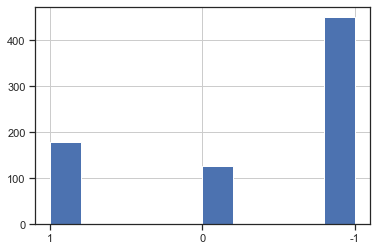

In [26]:
data.sentiment.hist()

# 22.06

In [8]:
politician_screen_names = ('KosiniakKamysz',
                           #'DariuszKlimczak',
                           'trzaskowski_',
                           'szymon_holownia',
                           'HannaGillPiatek',
                           'krzysztofbosak',
                           'GrzegorzBraun_',
                           'RobertBiedron',
                           'K_Smiszek',
                           'AndrzejDuda',
                           'Macierewicz_A',
                           'ZandbergRAZEM',
                           'bbudka',
                           'FijoKonrad')
                           #'marcinwarchol')

dfs_names = ('kosiniak_tweets',
             #'klimaczak_tweets',
             'trzaskowski_tweets',
             'holownia_tweets',
             'gillpiatek_tweets',
             'bosak_tweets',
             'braun_tweets',
             'biedron_tweets',
             'smiszek_tweets',
             'duda_tweets',
             'macierewicz_tweets',
             'zandberg_tweets',
             'budka_tweets',
             'fijolek_tweets')
             #'warchol_tweets')

In [9]:
tweets = {}
retweets = {}
ret_list = []
fail_list = []

for i in range(0,13):
    try:
        print(politician_screen_names[i])
        (data, posts) = get_replies(politician_screen_names[i], 10, 120)
        tweets[dfs_names[i]] = posts
        retweets[dfs_names[i]] = data
        ret_list.append(dfs_names[i])
        print('done')
    except:
        fail_list.append(dfs_names[i])
        print('ERROR')
        pass

KosiniakKamysz
done
trzaskowski_
done
szymon_holownia
done
HannaGillPiatek
done
krzysztofbosak
done
GrzegorzBraun_
done
RobertBiedron
done
K_Smiszek
done
AndrzejDuda
done
Macierewicz_A
done
ZandbergRAZEM
done
bbudka
done
FijoKonrad
done


In [14]:
for i in range (1,13):
    retweets[ret_list[i]]['text'] = retweets[ret_list[i]]['text'].apply(lambda x: x.strip("@"+politician_screen_names[i]))
    retweets[ret_list[i]]['sentiment'] = np.nan

    sent = []
    for index, row in retweets[ret_list[i]].iterrows():
        print(row['text'])
        sent.append(input())
        
    retweets[ret_list[i]]['sentiment'] = sent

 @wolnemiejsce @warszawa @AldonaMachnow1 A jest możliwość zakupów internetowych?


 0


 @wolnemiejsce @warszawa @AldonaMachnow1 Jachira będzie pierwsza.


 0


 @wolnemiejsce @warszawa @AldonaMachnow1 Piękna inicjatywa🌹


 1


 @wolnemiejsce @warszawa @AldonaMachnow1 https://t.co/7RwiM3ADhf


 0


 @wolnemiejsce @warszawa @AldonaMachnow1 Nie posądzałem pana o taką kupę serducha. O samą kupę już tak.


 -1


 @wolnemiejsce @warszawa @AldonaMachnow1 Chytra baba z Radomia lubi to 😁.


 0


 @wolnemiejsce @warszawa @AldonaMachnow1 Warszawa jest tak solidarna, że bardzo chętnie dzieli się swoim szambem i nieczystościami z resztą Polski. https://t.co/7ZO3FyOmu0


 -1


 @wolnemiejsce @warszawa @AldonaMachnow1 Dla tych wyrzuconych na bruk też?


 -1


 @wolnemiejsce @warszawa @AldonaMachnow1 Ceny za wywóz śmieci są tak wysokie, że za moment takie sklepy będa miały niezłe wzięcie w stolicy.


 -1


 @wolnemiejsce @warszawa @AldonaMachnow1 Czyli mowa o 95 % Polakow.


 0


 @wolnemiejsce @warszawa @AldonaMachnow1 Zamiast tworzyć prawo przyjazne obywatelom z niskimi podatkami to rzuca się ludziom sklep za połowę. Kwintesencja PIS i PO... Socjalistyczne rozdawanie.


 -1


 @wolnemiejsce @warszawa @AldonaMachnow1 I o to nasz darczyńca KOTURN XIV.......


 -1


 @wolnemiejsce @warszawa @AldonaMachnow1 Po podwyżkach których wprowadziłeś coraz więcej mieszkańców będzie tam chodzić na zakupy‼️‼️‼️


 -1


 @wolnemiejsce @warszawa @AldonaMachnow1 Dla wszystkich prócz Polaków KONFIDENCIE


 -1


 @wolnemiejsce @warszawa @AldonaMachnow1 Jaka weryfikacja będzie osób w trudnej sytuacji finansowej?


 -1


 Też jeden z ojców polskiego jazzu 🎹


 1


 Podrowienia dla Gebelsowskiego soku z buraka od niezłomnych .


 -1


 Gdzie robione zdjecie? W tle koło od ciagnika ursus c 355 lub c 4011. Fabryka ursus?


 0


 Pozdrawiam przyszłego Prezydenta RP :)


 1


 ❤️✌️


 1


 Za trzy tygodnie minie 25 lat jak odszedł mój Tata, a ja nadal okropnie tęsknię...


 0


 👊🏼🇵🇱


 1


 Widać że komuch!


 -1


 Lans na zmarłym ojcu. Pan zna jakies granice przyzwoitosci ?


 -1


 Panie prezydencie Trzaskowski  moja 4 już nie ma taty 25 lat .Wspolczuje panu i moim dzieciom to tak boli 'to ciągle boli . Taki żal 'że nie mógł przytulić wnukow''napic się piwa z synami i zięciami 'że nie zatanczyl z córkami i synowymi. Bardzo boli .


 0


 Bardzo przystojnym mężczyzną był😞


 1


 Mojego nie ma 10 lat, codziennie tęsknię.💔
Pozdrawiam i dobrego dnia życzę 💫


 1


 Też był komunistą jak TW Justyna?


 -1


 My seniorzy doskonale Go pamiętamy!pozdrawiamy serdecznie Pana i życzymy dobrych dni i lat !liczymy na Pana obecność w polityce dla naszego dob


 1


 😢


 0


 Panie Prezydencie ! Mój Prezydencie Warszawy jestem dumna ❤️Sen


 1


 Piękne zdjęcie. Mojego Taty nie ma już z nami 15 lat😔

Tu na zdjęciu z naszą Olimpią♥️

Oboje już nie żyją 👇 https://t.co/en0chtEyW


 -1


 ❤❤❤


 1


 Dla ciebie cukiereczku, dużo masełka i żeby pupcia nigdy nie bolała.


 -1


 Złóź źyczenia tatusiom dzieci abortowanych.


 -1


 To już wiem, dlaczego puścił pan wtedy w klubie #Jamiroquai (pierwsze albumy bardziej acid jazzowe), czyżby gusta przechodziły z ojca (jazzmana) na syna.


 1


 Mój odszedł trzy lata temu. Już trzy lata ...❤


 0


 @JanuszCichy Podobny jest Pan do taty, mój nie żyje 25 lat, zmarł w wieku 47 lat ma zawał. 😢😢😢😢


 0


 Tak, ale on przynajmniej pozostawił po sobie dobry jazz a jego syn...? Mizerny bilans jak do tej chwili.


 -1


 Bardzo podobny jest Pan go taty 😄


 1


 ❤


 1


 Nie lansuj się Pan!


 -1


 Co tam w Warszawie?znowu zamykają? nie panuje pan nawet nad tym?komu kamienicę?komu😒Pięć osób zatrzymało Centralne Biuro Antykorupcyjne w związku ze śledztwem dotyczącym nieprawidłowości w reprywatyzacji nieruchomości warszawskich.
https://t.co/9dDm4Tuxtg


 -1


 Ale jest Pana nieodżałowanego Taty wspaniała muzyka do której często wracam!


 1


 W tle chyba C-360 😀


 0


 Pamietam ,Trzaskowski brzmiał świetnie 💝


 1


 Wiele pozostało w genach... ❤️


 1


 Podobieństwo uderzające 😀😀😀


 1


 ..dopiero przeczytałem "Osobiste życie jazzu" Co to była za postać...


 1


 Gdybyś był wierzący to byś się pomodlił za niego, a tak to tylko zdjęcie możesz pokazać.


 0


 Sławek Nowak twoim ojcem?


 0


 Muzyka jest. https://t.co/QlpzTEytl1


 1


 Mojego 24 to trudny dzień. ❤😥


 0


 Masz farta, nie był gejem, aborterem, transs. Może trochę narodu szkoda?


 -1


 Na pewno jest z Panem myślami, a Pan z nim. 
Proszę pielęgnować wspomnienia, one mają największą wartość.


 1


 Chwila, przecież to mój ojciec!


 0


 Pamiętamy.
Słuchamy.
Zostawił po sobie wiele.
To nie zginie.
https://t.co/hro0VrYiwu


 1


 Ciekawe, czy i na niego twoja mamusia, czyli SBcka "kapusta", donosiła.


 -1


 Widać podobieństwo pozdrawiam


 1


 Wypisz wymaluj Adam Szejnfeld


 1


 Ale pan jest do niego podobny. Pozdrawiam.


 1


 Ależ jest Pan do Niego podobny!


 1


 💙


 1


 @warszawa @molszew77 @Marlena_Happach W ratuszu siedzi leń , nic nie robi cały dzień.......😄


 -1


 @warszawa @molszew77 @Marlena_Happach https://t.co/P15ZyBPVEg


 0


 @warszawa @molszew77 @Marlena_Happach https://t.co/dAb4cjfCHb


 0


 @warszawa @molszew77 @Marlena_Happach Za głupi jesteś żeby rządzić w Polsce 🤫🤫🤫🤫🤫🤫🤫🤫🤫🤫 https://t.co/haM958PqDu


 -1


 @warszawa @molszew77 @Marlena_Happach Na tym betonie, to tylko sztuczne palmy mogą urosnąć za jakąś odpowiednio wysoką kwotę...... A co.....?!


 -1


 @warszawa @molszew77 @Marlena_Happach że niby zielone palety będą?


 -1


 @warszawa @molszew77 @Marlena_Happach Mam wrażenie, że Warszawę odbudowywali wszyscy Polacy, a teraz Rafalalek niszczy wszystko i paletuje, a Warszawiacy łykają wszystko jak pelikany.  Ktoś zrobil to niszczą, potem znów caly kraj naprawi?


 -1


 @warszawa @molszew77 @Marlena_Happach To może kilka palet za parę milionów, geniuszu.


 -1


 @warszawa @molszew77 @Marlena_Happach SZANOWNI PAŃ... STWO!! A. MOŻE. SKWEREK.  I . HOSTELEM DLA  LGBT.  NA S.. PO... TKANIA.  INTYMNE.  NO


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii W ilu warszawskich szkołach są windy? W ilu dziecko na wózku, czy z problemami z poruszaniem, może normalnie funkcjonować? Ile pieniędzy wydałeś marny prezydencie na równanie szans? 2 mln na palety, a ile na windy?


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Poszerzać wiedzę o seksedukację i rozwijać zainteresowania lgbt, to wasza propozycja! NIE DO PRZYJĘCIA!!!


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Mów za siebie Rafau a nie za nauczycieli i rodziców. Precz z tęczowym faszyzmem!


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Wy odszczepieńcy możecie swoje dzieci na campusach uczyć lewackiego pedałowania...a my polscy samorządowcy, nauczyciele, rodzice i uczniowie nie życzymy sobie lewackiej ideologii i tęczowej deprawacji w polskiej szkole!! 

#StrefaWolnaOdGender 
#TęczowyFaszyzm


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii odp. https://t.co/Qe2rxIlxF


 0


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Zamachem na polską edukację jest wpychanie drzwiamy i oknami waszego tęczowego ideolo. Ale nie udaje się i nie uda. I bardzo dobrze.


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Ja bym powiedziała że to Pan za pieniądze niemieckich fundacji chce położyć łapę na szkołę i zamienić w fabrykę patolog


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii WON brukselski zdrajco!


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Zamknij się już nieuku! Jak można wypisywać takie bzdury?!


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Prawdziwy zamach na prawidłowe nauczanie historii we Francji zrobił Jakub. 
Duzo jest do naprawienia w post komunistycznej i ateickiej🇫🇷edukacji. Francuzi wiedza ze były deportacje✡️ ale nie wiedzą, ze zamordowano 6 mln Polaków ‼️
https://t.co/iNUgdQp0aD
https://t.co/SU9HFtPvEW


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Wiedza, umiejętności, zainteresowania - tak.

Gendery, sex edukacja, promocja LGBT, indoktrynacja polityczna - NIE!


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Stop ideologii LGBT w szkole, nie ma na to mojej zgody !!!!!!!


 -1


 @DorotaZmarzlak @RKaznowska @DorotaLoboda @Broniarz @ZNP_ZG @UniaMetropolii Nie pieprz głupot, szkoła ma uczyć,nie deprawować. Bawicie się w ideologię,zamiast nauki,a później studenci,zapytani o datę powstania warszawskiego,nie potrafią odpowiedzieć. Nie znają tabliczki mnożenia,polskiej literatury,o poezji nie wspomnę.Są tęczowymi tumanami.


 -1


 @CzarnekP @RKaznowska @DorotaLoboda @Broniarz @DorotaZmarzlak https://t.co/vDkKZf9co0


 0


 Niech Pan tak trzyma...to co Pan mowi jest tak oczywiste jak 2+2=4 ale..dla niektórych 2+2=22


 -1


 Nic dziwnego że chce Pan likwidacji skoro wytykają Pańskie zaniechania i przypominają niespełnione obietnice wyborcze. 😄 #hipokryzjaPO


 -1


 Chyba warszawskie słoiki tak mówią i peowskie mendy bo Polacy chcą TVP pajacu z metra cięty..


 -1


 Szymuś nie płacz.


 -1


 Szymuś co ty ćpiesz?


 -1


 Szymuś jakiś taki oderwany od rzeczywistośc


 -1


 Hołownia tobie po drodze z hasłem 8 gwiazdek czyli jebać PiS to ci zadam pytanie kto jebie ciebie albo twoją **** jak ci się podoba te hasło Hołownia nikt nie lubi być jebanym pozdr


 -1


 Kiedy pan się znów rozpłacze?


 -1


 Gdzie można znaleźć dokumenty finansowania Pana parti.Czego się Pan obawia ukrywając je.Powinniscie odpowiedzieć za t


 -1


 Teraz jak wróci D. Tusk, to pewnie pojawi się szereg sondaży, w których PL2050 będzie miała coraz słabsze poparcie - czyli kreowanie poparcia partii poprzez zamawianie odpowiednich sondaży.

Przejmujcie kolejnych posłów by wzmacniać się medialnie.


 -1


 Oj! Nic o paradzie równości?! Hmmm… Jednak Pan konserwatysta któremu bliżej do @pisorgp


 -1


 Dlaczego nie wypowiedziałes się na temat parady równości? Dlaczego nie było cię tam? 

XXI wiek...po prostu wstyd


 -1


 https://t.co/EowVou5cn5


 0


 Jak będzie płacz, to rzucę okiem alby synowi pokazać jak ma nie wyglądać.


 -1


 ~ zapraszamy do Jarosławia 🙂


 1


 Dzièkuję. Już zaglądam.


 1


 Dlaczego nie poparł pan dziś ludzi LGBT?? My nie zapomnimy ✌️


 -1


 @AnnaSernawit Spadaj pan bo mi feng shui zakloc


 -1


 Bracie Szymonie, a ksiądz to tym pedałom da rozgrzeszenie? Bo ja to bym tak u brata Szymona chciał się wyspowiadać. Bo brat to taki nasz, swojski, pedalski, a może i jakieś dzieci da się pomolestować. SPADAJ IDIOTO


 -1


 Jakoś o sytuacji robotników cisza, a to największy elektorat i kłopot dla rządu (żeby nie powiedzieć wrzód na dupie). To robotnicy robią największą kasę dla "rządu" a są traktowani jak gówno!


 -1


 Ale co z 2050 na 2090 to się dzieje


 0


 Doleciało  i  zadziałało .. https://t.co/FR3bwRe0tA


 1


 Szymon kto jak nie TY ?! Dzialaj Masz u mnie wsparcie !


 1


 https://t.co/j78kkRP09


 0


 R. Trzaskowski wymyślił "zlot" Sz. Hołownia to zmałpował zamiast przyłączyć się do zlotów R. Trzaskowskiego!


 -1


 Widzę, że zdążyliście zmyć się z Mokotowskich, zanim dotarła tam Parada Równości.
Dlaczego nie wzięliście w niej udziału?


 -1


 Dlaczego nie było państwa na paradzie równości?
Dzisiaj kiedy środowiska #LGBT + potrzebują wsparcia, bo państwo je tępi - jak zwykle pana nie ma..
Nijakość.


 -1


 sPOnsor Sławek N. z PO?


 -1


 A Pan już płakał!


 -1


 https://t.co/C2gbl369yZ


 -1


 @ParadaRownosci  gdzie pan jest


 -1


 Dlaczego pana nie ma na @parada równośc


 -1


 Takie pytanie do pana :https://t.co/Ej5LjTMW0N


 0


 Ciekawe kiedy Ci się ta zabawa Szymonie znudzi ;)


 -1


 Czyli konferansjerka. Zostań przy tym. Baba z brodą, 30 hot dogów w minutę, itp.


 -1


 Płacz już był to pozostało tylko zgrzytanie zębami. https://t.co/N3FLTeAlxv


 -1


 Kolejny sezon "mam talent" ruszyl??


 -1


 Bosssssz, znowu te śmieci 😱


 -1


 Dziać się będzie, gdy światło dzienne ujrzą dokumenty z pana kampanii prezydenckiej, szczególnie opinia biegłego rewidenta, którą od roku skrzętnie pan ukrywa. Dlaczego?


 -1


 Będziesz płakał?


 -1


 Będziecie sadzić drzewa? 💛


 1


 Ile płacicie bo dziady z Was niemiłosierne ?😯


 -1


 Gdzie można znaleźć dokumenty dot. finansowania partii Polska 2050 Szymona Hołowni oraz jakie związki, również finansowe, ma partia z ruchem oraz fundacją?


 -1


 szkoda czasu w taki piekny dzień....nud


 -1


 Powoli wiadomo kto wspiera finansowo Hujownie oj będzie dym Szymek


 -1


 Wpłacają po dychu?


 0


 bedzie fajnie czy Hujownia ??


 -1


 #Nikog


 -1


 Wole Trzaskowskiego i Tuska.


 -1


 Nic się nie dzieje, przechwalacie się kto ile zebrał śmieci✌️


 -1


 Jak Petru


 -1


 O zwierzątkach coś będzie? https://t.co/Zdb93O9d7S


 0


 Zechce pan odpowiedzieć, czy to inauguracja kampanii partii, a jeżeli tak, to jak jest finansowana?
https://t.co/GewDoi05Da https://t.co/0ledfVv3k7


 -1


 Nie lepiej już oficjalnie dołączyć do nieładu? Szkoda czasu i pieniędzy, a i tak wasze drogi się spotkają. Jak Qtapis'a  🤷‍♂️


 -1


 Patrząc na komentarze nie trudno wywnioskować, że sukcesy @PL_2050 uwierają każdą opcje polityczną. 
I o to chodzi Panie i Panowie!!! 👋👋👋


 1


 Szymus! ze twoja żona utrzymuje takiego debila- to budzi zdziwienie! 
Pani żono!  pogoń pani tą onuce!


 -1


 No i pięknie, życzę powodzenia 💛 💛 💛


 1


 Ile byś kampanii nie zrobił, pamiętaj: tylko skończone barany zagłosują na te TVN-owskie bzdury…


 -1


 Ile razy dziennie będziesz płakał?


 -1


 Wolę słuchać lato z radiem niż lato z durniem.


 -1


 Jakie to żałosne, jak dorosły facet żebrze o pieniądze, i ktoś taki ma być w rządzie?


 -1


 Dalej będzie letnio? Szymek, gdzie jest stary dobry Szymek? Kto Tobą steruje? Kto Ci robi, brachu, krzywdę?


 -1


 Kampania letnia...buhha...chyba na plaży ...


 -1


 Woltyżerka i łykanie ognia i dodatkowych klaunów proponuję ....zejdą się wtedy ludzie tłumnie obejrzeć cyrk 🤔 https://t.co/EXlZyeWKKI


 -1


 Po co? Wystarczy Pana posłuchać


 0


 Nie obchodzi mnie żadna Laleczka Chuck


 -1


 Beczy Pan na wizji, opowiada Pan jakieś niestworzone banialuki, i Pan chce rządzić...🤦‍♂️🤦‍♂️🤦‍♂️.


 -1


 Szymuś... to Ty?🤣 https://t.co/YdshWsPAkN


 -1


 Dajcie ludziom spokojnie odpocząć na urlopach, bo was w końcu bejsbolami rozgonią.


 -1


 Pobłaznuj jeszcze ciut i starczy. Skąd Ci się klaunie, wzielo przekonanie, że teraz, to ty politykować zaczniesz? Ty konferansjer jesteś, niższego szczebla.


 -1


 Lecę do was 😂 https://t.co/FkMEMDFo8B


 0


 👇👇👇👇👇👇👇👇👇👇👇👇👇 https://t.co/BuUMPkBMpx


 0


 objazdowy cyrk  klaun  Z TVN tez wystapi?


 -1


 Zlot Lemingów❗️


 -1


 Letnia to jest ta niby 2050 smród sezonowy.


 -1


 Letni pacjent? 🤔


 -1


 Z cyklu:
TVN i WSI to nasi brac


 -1


 Do zobaczenia W Chujmiętkach.Gnojówka czeka .


 -1


 @MiroslawSuchon Jak Petru


 -1


 @MiroslawSuchon Nie wplaxajcie cholowniii kasy bo się b


 -1


 Proszę zrób coś z tą czupryną.


 -1


 A ty oczywiście masz na wszystko lekarstwo🤣🤣


 -1


 Napisał człowiek avatar.


 -1


 @Niepremier Ty też jesteś już historią, ale jeszcze o tym nie wiesz... 
Możesz już zacząć płakać😂😂😂


 -1


 Głupia, cóż?


 -1


 @JkmMikke @hennigkloska Porażające że poseł zajmuje się takimi bzdurami..wpis na TT a ta lata po komisjach..Boż


 -1


 @JkmMikke @hennigkloska Takie wpisy nie kwalifikują się do nagany, tylko do prokuratury, bo dają przyzwolenie do działania zwyrodnialcom. Nie odpuszczajcie, bo niedobrze się robi słysząc, że takie indywiduum jest potem bezkarne.


 -1


 @JkmMikke @hennigkloska Kpisz kpiaro i hipokrytko?


 -1


 @JkmMikke @hennigkloska Acha czyli piszesz o tym na TT, jednoczesnie nie chcesz udostepnic dowodu, zebysmy sami mogli rozsadzic jaka jest prawda. 
Mam politykowi uwierzyc na slowo...kp


 -1


 @JkmMikke @hennigkloska Pani nie ma nic lepszego do robienia w parlamencie tylko zajmowanie się wypowiedziami innych polityków? : p


 -1


 Mogłaś mi powiedzieć o tej skarpetce! 😊


 1


 @SasinJacek @mareksuski To poziom merytoryki musi być naprawde wysoki tzn. Wielki niczym Caryca.


 -1


 @SasinJacek @mareksuski Czy @SasinJacek oddał już 70 milionów zł? 🤔


 -1


 @SasinJacek @mareksuski co z Muchą?


 0


 @strategie2050pl @LukaszKrason @PL_2050 Przepięknie Pani w tej kiecce😍


 1


 I o roślinach na balkonach. One też potrzebują dużo wody. Ja dziś podlałem moje cztery krzewy i trzy drzewa. Wszystkie rosnące w doniczkach.


 1


 Nie tylko w miastach wszędzie powinno rosnąć mnóstwo drzew. Musimy je sadzić żeby nasze dzieci miały się gdzie schronić gdy będą w naszym wieku


 1


 @naticlunatic Kto rządzi w miastach kto prowadzi betonową polityke . Nie Po i totalna opozycja?


 -1


 @PL_2050 @MiastoKutno


 0


 To prawda - pamietajmy… ale betonoza wygrywa wśród urzędników i samorządowców - w moim mieście burmistrz zafundował mieszkańcom w rynku betonową patelnię, ale oczywiście nie widzi w tym nic złego - kwiaty w plastikowych doniczkach robią za zieleń


 -1


 Niestety w miastach zamiast drzew rośnie coraz większa betonoza😢A w taki dzień jak dziś każdy chętnie schroniłby się w cieniu🌳


 -1


 Nie po to gościa wybrali wójtem żeby teraz nic nie robił, więc wycina i betonuje za unijne pieniądze. Nie zarzucą mu na koniec kadencji że nie wykorzystał funduszy. A debilni radni to przyklepują bo dostaną jakieś zezwolenie lub dietę za sesję. Dno.


 -1


 Dziś barbarzyńcy wycieli przepiękny żywopłot róg Foksal i Kopernika - schronienie dla wróbli - utrzymanie wody - ochłoda dla wszystkich w okolicy - prośba pilna o interwencję i zatrzymanie dalszych wycinek -


 -1


 Idealnie przedstawiony przykład. 👍


 1


 https://t.co/NbyNdLT2M


 0


 Ale cie Tarczyński zagrał he nowa partia hee macie tylko nowe logo lewac


 -1


 #betonoz


 -1


 Dodajmy jeszcze kto tam rządzi od 


 0


 W Bydgoszczy jest dużo drzew.


 1


 Pozdrowienia z Bydgoszczy rządzonej przez ludzi z PO
👇 https://t.co/GLYphSv3TO


 1


 Ale wie pani, ze te fragmenty docelowo przeznaczone są pod zabudowę i dlatego nie ma tam zieleni?


 -1


 Kto jest Prezydentem Łodzi? I z jakiej partii?


 -1


 @krytyka Dworzec Łódź Fabryczna to jeden z ciekawszych przekrętów władzy PO-PSL. Myślę że warto byłoby dopytać koleżankę z Pani klubu (@joannamucha) o okoliczności jego powstania.


 -1


 To są efekty kiedy na stanowiskach decyzyjnych zasiadają przygłupy , debile i zwyczajne kaleki umysłowe z rozdmuchanym przez innych przygłupów , debili i kaleki umysłowe ego . 
ZERO wiedzy , ZERO wyobraźni za to beztroska i klarowna wizja koryta .


 -1


 Dziś nadal jest zazwyczaj brzydko, ale przynajmniej nie rosną drzewa.


 -1


 Ktoś na to pozwolił. Czy czasem Łodzią nie włada PO i Lewica?


 -1


 Wszyscy miejscowi nie zauważyli,a Wielka szkoda. Poprawek nadszedł czas.


 -1


 Mamy kretynów we władzach miast. Wystarczy wyszukać w "guglu" zdjęcia rynków w naszych miastach. No ale zleconka muszą być, z czegoś trzeba żyć. 🤷🏻‍♂️🤬🤮


 -1


 no, przydało by sie jakieś rozporządzenie dla architektów, że minimum 40% zieleni czy coś...


 1


 Masakra.


 -1


 Jednorożce się cieszą ;)


 -1


 Ja tylko zwrócę uwagę, że to co jest w tle jest dachem parkingu wielopoziomowego przygotowanym do postawienia biurowca, co nie zmienia faktu, że trawnik pewnie byłby lepszy


 0


 To ciekawe. Jednakże "rewitalizacji" placu Dąbrowskiego nic nie przebije... 
Krótki komentarz dot. rewitalizacji w miastach tutaj:
https://t.co/J4NLx27yYT https://t.co/Vay7nIUiNz


 -1


 To nie rządzi tam twoja tęczowa koleżanka ?


 -1


 Inwestycja przy wsparciu środków unijnych.


 0


 Pięknie zaorana została pani w @StrefaStarcia przez @D_Tarczynski  ,aż miło było patrzeć 😂😂😂😂


 -1


 W centrum Olsztyna mamy dwa duże parki polaczene ze sobą. Ale fakt,faktem ostatnimi czasy coraz więcej terenów zielonych zastępuje beton. Jednak w porównaniu do innych miast, Olsztyn to oaza zieleni. Zdj.Park Podzamcze i park Centralny https://t.co/PIApqYoeL


 1


 Zaorana w strefie starcia jaki wstyd h


 -1


 Drzewa powinny być wszędzie, ale nie tam gdzie mogą stwarzać zagrożenie !


 -1


 @DybaBojarski Fakt jest tam sporo betonu, ale o ile się nie mylę za budowę dworca odpowiadało PK


 0


 Wyborcy tego chcieli.


 1


 @AdamDee_ASD Się czepiasz. W komputerze na symulacji to wyglądało zajebiście.


 0


 @PL_2050 O matko, co Ci ludzie z tym betonem🤦‍♂️Jakiś uraz z blokowiska🤷‍♂️


 -1


 @PL_2050 Dlatego już niedługo, dzięki naszym wspólnym działaniom z wolontariuszami @PL_2050 na Placu Szczepańskim w @krakow_pl staną Parklety (mobilne platformy z zielenią).


 1


 mam nadzieje ze jak dojdziecie do władzy to zmienicie te patogeniczne ustawy w ten sposób aby budowlane obiekty czy to domy, biura czy parkingi większą ilością drzew otoczone były. Proponuję 1 drzewo na 1 lokal i 1 drzewo na jedno miejsce postojowe.


 1


 Betonoza pols


 -1


 Siedzi Pani nad dworcem. Wcześniej też nie był to teren zadrzewiony. Tam zawsze biegły tory. A zaraz obok jest park Moniuszki. Chyba średnio trafiona krytyka, a ktoś, kto myśli o odwiedzeniu Łodzi będzie miał fałszywy obraz naszego miasta😐


 -1


 I co, mamy teraz wyrywać płyty, skuwać kostkę?


 -1


 @Wan74285373 Panie Bosak, działajcie dalej przeciw rządowi to szybciej przejdą takie traktaty i rezolucje, w końcu kasa jest najważniejsza, co nie?


 -1


 Miało być partnerstwo, a jest poddaństwo.
Jeśli partner kłamie, oszukuje, zawłaszcza, wyzyskuje i gnębi to trzeba partnera PORZUCIĆ. Nie ma co liczyć że to on się zmieni.
#PolExi


 -1


 Co może Białorusi zaoferować Polska, upokorzony członek drugiej kategorii ultra komunistycznej UE? Plandemię i lockdowny, parady zboków, butę i połajanki dupka z ambasady USA? 
Więc odwal się Pan od prezydenta Aleksandra Łukaszenki.


 -1


 Traktaty to jedno natomiast zdecydowana wiekszość nowych przepisów tylko i wyłącznie "przykreca śrubę" społeczeństwom. Wystarczy spojrzeć np. na przepisy dotyczace rolnictwa, ciężko doszukiwać się w tym jakiejkolwiek logiki.


 -1


 @KONFEDERACJA_ Zastanówmy sie kto ma jeszcze pieniadze i moze przeciwstawic sie Uni. Nie bankrut Usa a rozwijajace sie Chiny ktore chca Europe opanowac i uda im sie to na 100%. Pomózmy im i zaróbmy na zachodzie za nim inny zachodni kraj im pomoze. Europa to bankrut, trup juz jej nie m


 0


 @KONFEDERACJA_ Jest Pan taki rzetelny, że wywala poza skalę.
Tam gdzie Pana małżonka pracuje, tam też są bardzo obiektywni i rzetelni.


 1


 I bardzo dobrze. Traktaty Europejskie chronią nas przed dyktaturą Kaczystów.


 1


 Ambasadorem @Amb_Niemiec na terenie Rzeczypospolitej jest jakiś wnuczek dobrego współpracownika Adolfa Hitlera, natomiast ambasadorem @IsraelinPoland jest syn żołnierza armii sowieckiej, która zajmowała Polskę w 1945 roku.
Większej groteski już być nie może.


 -1


 Niczego innego się po PiSie nie spodziewałem.


 0


 Zydokomuna jak przystalo na naszych namiestnikow.


 -1


 Kto mu dał agrement?
Przecież rząd państwa przyjmujacego może odmówić i to bez podania przyczyny.
Przecież ten gościu to postsowiecki Litwak.
Najgorszy typ antypolonity.


 -1


 Dissapointed but not suprised😂😂


 -1


 Czy temat roszczeń czasem nie powraca pod obrady, tylko z innym nazewnictwem?


 -1


 @ZiobroPL Ciekawe, że 2 posłów z Konfederacji (znowu jako jedyni) głosowało z PiS. Co się dzieje z Robertem Winnickim?
https://t.co/mjs66p4Zgf
@ArturDziam


 0


 @ZiobroPL Już widzę tę informację. Wszystko i nic czyli bełkot na szczycie góry lodowej.


 -1


 @ZiobroPL Co tak mało głosujących?


 0


 @ZiobroPL A może takie głosowanie w sprawie doniesienia NIK do prokuratury w sprawie wyborów?
Co robi prokuratura?


 -1


 @KONFEDERACJA_ @ZiobroPL Jakiej informacji się spodziewacie🧐🤔❓


 0


 @MorawieckiM Kampania przed zjazdem PiS się zaczyna. Oni myślą, że Rosjanie byliby tak głupi że publikowali by informacje, a nie po cichu szantażowali najważniejsze osoby w państwie. To są naprawdę szczeniaki


 -1


 @MorawieckiM Pan Dworczyk po prostu przeprosił sam siebie😉


 -1


 @MorawieckiM Pewnie Ci sami debile co przy covidzie.


 -1


Tekst Wyborczej oceniam jako niewiarygodny, swoją drogą. Ale to tylko moja opinia bo do ustaleń służb dostępu nie mam. Niemniej Wyborcza w żaden sposób nie uprawdopodobniła tej hipotezy o sprawstwie z otoczenia ministra i braku cyberataku


 0


 @MorawieckiM Dworczyk znowu trzyma niewybuchy w piwnicy ?


 -1


 https://t.co/JpxE3Sz25Q


 0


 To ten Legutko, który poparł paszport eksperymentalnej szczepionki i segregację sanitarną? Toż nie ma większego scierwa niż ci szmaciani SSmani. https://t.co/KfAyyo4KYE


 -1


 Napisał to profesor glosujacy za paszportami Covidowymi, to cos jak partia PiS z jednej strony 5 dla zwierząt a z innej Czarnek probujący zatrzymać marksistów poprzez zmiane lektur 🤷‍♂️


 -1


 Dziecinada, teraz to kazdy mysli ze sobie moze pisac listy i cos to znaczy. To sie nadaje tylko na smieci.


 -1


 To napisał profesor? :O Przecież ilość pozamerytorycznych błędów logicznych jest zatrważająca.


 -1


 Krzychu, jak dyskryminujecie te zlowrogie falsze w waszej Konfederacji?


 -1


 Dlaczego? Przecież czarn


 0


 Przecież ten węgiel jest CZARNY !!!


 0


 Niektorym to by sie przydal taki wegiel medyczny bo strasznie osrane komentarze wrzucaja tutaj😏


 -1


 Takich zamordystów jak ty może to dziwić.


 -1


 Ale dobrze ze tylko 7% wyborców bierze was poważnie. Tyle barnow wysarczy w kraju.


 -1


 Daj 10tys na nowy piec i po sprawie. Też musze z 3-4 tony kupić.


 0


 Ja juz sciepalem wegiel 😎 https://t.co/9l1444zsye


 0


 Jak by banowali tylko za głupotę polska prawica wylądowała by obok trampa na śmietniku internetu


 -1


 Bo jest czarny.


 0


 Jeszcze nie banują ale od 1 stycznia 2024 roku zaczną. Tego dnia w woj. lubelskim zacznie obowiązywać zakaz używania prymitywnych kotłów, które służą do spalania węgla typu "orzech". Swoją drogą, takie spalanie węgla, to najgorsze co można zrobić z takim paliwem.


 0


 Czarne złoto Polski,..PiS je stracił


 -1


 Węgiel w ogóle ma pod górkę w świecie politycznej poprawności. Jak nie czarny, to brunatny😝


 0


 Róbta screeny niedługo to będzie widok historyczn


 0


 @AZdzitowiecki Prosze sobie wyobrazic ze dla wiely rodzin to jest normalne i bez tego nie przetrwaja zimy. Wstyd panie pośle


 -1


 ...jeszcze... Proszę nie podpowiadać bo gotowi tak zrobić.


 0


 Trawy szkoda..


 -1


 Jak się niszczy polski węgiel „w imię ludzkości, planety i dobrobytu”… Agenda 2030 priorytetem rządu PiS
https://t.co/HORHY3jx7V


 -1


 Dlaczego by mieli banować? Poważnie pytam.


 0


 Polecam utworzenie kanału na Telegramie dla wyborców i sympatyków Panie pośle. 

Tam nie cenzurują. Warto mieć coś takiego na czarną godzine.


 -1


 Wiem ze pisze pan troche ironiecznie, ale w sumie prawica jest jak socjalizm troche. Tworzą(wyolbrzymiają) problemy a potem głośno z tym walczą. Ludzi w swojej masie średnio interesuje eko, lgbt, aborcja.


 -1


 nie tak Pan Bóg stworzył świat, żeby banowali za takie zdjęci


 0


 To przecież skamieniała biomasa leśna!


 0


 Murderca! Zabójczy wyngiel ma...


 0


 Strategia wyborcza panie Krzysztofie słuszna. Stawianie na antyekologicznych wyborców i covidosceptyków. W sam raz na 7%.


 -1


 Black is the new Green :)


 0


 Ajajajaj! Artysta bez życiorysu #Kościński @MF_GOV_PL nie taka rzecz jeszcze nam wymyśli


 -1


 PiS potrzebuje naszych pieniazkow bo kasa pusta.....


 -1


 To niech już będzie su


 0


 Podatek od zaszczepionych


 0


 @KONFEDERACJA_ Dojebaliby napewno podatek od świeżego powietrza,ale że takiego niema 🤔


 -1


 @KONFEDERACJA_ Ja bym dodał jeszcze podatek od mądrości


 0


 @KONFEDERACJA_ Gmina Władysławowo - podatek od psa i podatek od gościa w domu.


 0


 *w lecie (lub latem)
*w zimie (zimą)


 0


 @KONFEDERACJA_ Komunizm zawsze prowadzi do absurdów. Podatek od powietrza którym oddychamy będzie pewnie kolejnym. Niewolnicy muszą płacić za to że żyją. A może już czas zrzucić kajdany?


 -1


 @KONFEDERACJA_ Podatek od tweetów.


 0


 A może podatek od głupoty?:)


 -1


 @sunosha1 W lecie i w zimie, Panie Pośle.


 -1


 Krzysiek, weź się


 -1


 Ja czekam na podatek od podatku


 0


 Podatek od zużytego powietrza. Na tym można jeszcze więcej zarobić.


 0


 Kaczyński czerpie prawdopodobnie pomysły z filmu „O dwóch takich co ukradli księżyc”, w którym po mistrzowsku zagrali z bratem samych siebie. Czekamy na podatek od noszenia brody i podatek od golenia brody. Żeby każdy miał wybór. https://t.co/XhnzhkUe0G


 -1


 Gdyby to było złe to Bóg by inaczej świat stworzył


 -1


 Niedługo będzie podatek za oddychanie. Kiedy już dorżną energetykę węglową, zlikwidują samochody spalinowe, wymyślą, iż człowiek oddychając wydziela zbyt dużo CO2.


 0


 W nastepnych wyborach zaglosuje na Was. Tylko doopy nie dajcie. ***** unie i caly syf lewacki.


 -1


 @mblaszczak @MorawieckiM W szkole podstawowej mojej koleżanki, na 45 n- li tylko 3 osoby się nie zaszczepiły. Połowa po Astra była na zwolnieniach przez tydzień, 1 osoba zmarła-35 lat. Do mojej koleżanki dyr. kilka telefonów wykonał, ale nie przekonał jej. Właśnie ma 55 lat i odchodzi, żeby mieć spokój!


 -1


 @mblaszczak @MorawieckiM Wojsko i dyscyplina? Kto by pomyślał🙄


 -1


 @KONFEDERACJA_ @mblaszczak @MorawieckiM Jebac PIS


 -1


 @KONFEDERACJA_ @mblaszczak @MorawieckiM Zmuszanie funkcjonariuszy Policji i żołnierzy do udziału w eksperymencie medycznym przez ich dowódców jest niezgodne nie tylko z Konstytucją,ale także z Kodeksem Honorowym Oficera.


 -1


 @KONFEDERACJA_ @mblaszczak @MorawieckiM W Polsce prawa człowieka są w pełni respektowane, wbrew temu co sugeruje Krzysztof Bosak.


 1


 @KONFEDERACJA_ @mblaszczak @MorawieckiM I pomyśleć że na Pana głosowałem.....


 -1


 @ela_kam___ @mblaszczak @MorawieckiM Warto się zaszczepić. Jeśli ktoś siedzi w domu, jak pan, to wiele nie ryzykuje.
Nie wyobrażam sobie, że wojsko mamy niezaszczepione, bo żołnierze się boją plot starych ciot od płaskiej ziemi.


 -1


 @mblaszczak @MorawieckiM Pracowników cywilnych też cisną.Specjalne sprawozdania z listą imienną kto, kiedy i którą dawkę przyjął wysyłają do "Centrali".Ludzie boją się zwolnienia i nagonki na "winnych nowej pandemii", którą zapewne rozpoczną jesienią, więc się poddają 😐


 0


 @Wiktor47030158 @MorawieckiM @MF_GOV_PL @PIE_NET_PL Szczerze powiedziawszy, to myślałem, że do Morawieckiego pisze się na pinokio @ https://t.co/uGlxqbslvc.


 To lekarz psychiat


 0


 Dowódcy odpowiednich służb mogą już się powoli zastanawiać czy wystąpią na rozkaz przeciwko społeczeństwu zbuntowanemu wobec przymusu szczepień czy przeciwko grupie nawiedzonych i być może skorumpowanych osób w obronie ludności.


 -1


 Dlatego Panie pośle musicie dojsc do władzy a tych skurwysynow pod m


 -1


 I tak nic nie ruszy matek bez sumienia i bez mózgu... popędzą na eksperyment trzymając na rękach swoje pociechy...


 -1


 Polacy w uk maja teraz problem z odwiedzinami w kraju gdyż została narzucona nielegalna kwarantanna może pomożecie?


 -1


 Zajmujecie się pierdolami, szczepionkami, jakimiś wirusami a JKM był w szpitalu i palec złamał!!! I cisza o tym. Chcecie przykryć to swoją konferencją. Jak truchło-gwiazdor trafi do domu starucha też nie powiecie ani słowa.


 -1


 Ja tak do pana bo przegrał pan w Rzeszowie! W Ustce tez wybierają nowego burmistrza. Zapraszamy do konkursu! Darmowe obiady i wódeczka!


 -1


 Właśnie obejrzałem wiadomości gdzie Pan poinformował że po przylocie z UK  muszę odbyć przymusową kwarantannę. I to rozumiem ale w następnym zadaniu usłyszałem, że z kwarantanny zwolnione są osoby całkowicie zaszczepione. Jaka kurwa wpadła na tak genialny pomysł?!


 -1


 @KONFEDERACJA_ jakaś (pewnie spora) część Polaków nie ma ochoty spotykać się np. w kinie z osobami niezaszczepionymi, ponieważ uważa to za ryzyko dla zdrowia swojego i rodziny macie jakąś propozycję dla tych ludzi ?


 1


 @KONFEDERACJA_ Ty się podpisałeś pod petycją anty-LGBT więc twoje płacze w temacie segregacji robią mi dzień. Proszę o więcej panie 🤡


 -1


 W swoim życiu jeszcze nie byłem na jakimkolwiek marszu.
Nadeszły czasy, gdy nawet ja jestem gotowy zabrać przygotowane już taczki na spacer😂
Koniec segregacji sanitarnej!


 1


 służą jednym panom ... https://t.co/2DcgVdMWu9


 -1


 Covidiariusze nie mają w tej rewolucji nic do stracenia prócz swych żyć. 
Do zdobycia mają cały świat. 
Covidiariusze wszystkich krajów, łączcie się!


 0


 Tak się szczyciles ze wygrasz. Pisałem ze w sondażu głosowaliśmy na ciebie dla polewu a ty pękales z dumy. Ostatnie miejsce. Rzeszów nie jest brunatny.


 -1


 SIEMA 

CZEMU SEGREGACJA SANITARNA ZE WZGLĘDU NA SZCZEPIONKI JEST ZŁA A ZE WZGLĘDU NA OBSRANE RĘCE JEST DOBRA? 

POZDRAWIAM!!!!!


 -1


 W większości na Fijołka. Więc teraz zobaczymy jak im fajnie będzie jako za-sz-cze-pio-nym w kagańcach jesienią. 🙃


 -1


 Jeszcze raz brawo Grzesi


 1


 Większość zaszczepionych nie głosowała na Pana Brauna to było do przewidzenia a szkoda że ludzie takie mają myśleni


 -1


 Coś bardzo mało tych młodych głosowało skoro tak marny wynik końcowy był 😉😉😉


 0


 Z tym, że większość na Fijolka 😂


 -1


 Wystarczy poczekać, ze 30 lat, chyba że w międzyczasie młodzi zgłupieją. Albo nas okupant wykończy...


 -1


 Ciekawe wnioski na tle socjalistycznych zapędów PiSu.


 0


 Co nie zmienia faktu, że nadal pozostanie Pan kandydatem.


 0


 Szczęść Boże Panie @GrzegorzBraun_ w następnych wyborach będzie jeszcze lepiej. Dziękuje za Pana ciężką prace.


 1


 @MorawieckiM @michaldworczyk SIEMA 

CZEMU SEGREGACJA SANITARNA ZE WZGLĘDU NA SZCZEPIONKI JEST ZŁA A ZE WZGLĘDU NA OBSRANE RĘCE JEST DOBRA? 

POZDRAWIAM!!!!!


 -1


 @MorawieckiM @michaldworczyk Braun obraża rząd, kłamie. Gdy dziennikarz mu zadaje pytanie to Braun straszy sądem. Brak słów.

Gdyby był w rządzie. To by obywateli sądami straszył za pytanie o bezroboci


 -1


 @MorawieckiM @michaldworczyk Panie Grzegorzu, czy to prawda, że jest pan zaszczepiony przeciwko COVID?


 0


 @MorawieckiM @michaldworczyk Ale ty gościu jesteś głupi jak kupa gówna caskofskiego z czajki. Tobie nawet psychiatra już nie pomoże volksdojczu, zdrajco i miernoto, wielkie z ciebie zeroo...


 -1


 @MorawieckiM @michaldworczyk https://t.co/ksa162tifp


 0


 @MorawieckiM @michaldworczyk Poznajesz? Takie dwa same debile w jednym. https://t.co/UlzwCTGtCR


 -1


 @MorawieckiM @michaldworczyk Jesteście wszyscy Panowie do wyjebania z lewej do prawej. I tyle. Mój mały mózg tylko tyle pojmuje.


 -1


 @CezarPol @MorawieckiM @michaldworczyk Braun jesteś nominowany by zostać naczelnym Fake News wyborcza.
Chłopie marnujesz  się w Sejmie.
Gebels z Ciebie jak trza. https://t.co/zLfxSjkfTd


 -1


 @MorawieckiM @michaldworczyk zaprzancy,zdrajcy was z opozycji nalezałoby przegonic ulicami i opluć za waszę zachowanie.


 -1


 @r_groniak @MorawieckiM @michaldworczyk Znasz regulamin Sejmu jak masz z tym problem to, zdaj mandat i poszukaj pracy


 -1


 @MorawieckiM @michaldworczyk Jeżeli tak to wyglada, to to jest niebywały skandal. Jestem ciekaw tych maili.


 -1


 @MorawieckiM @michaldworczyk https://t.co/nCqx56dKtN


 0


 @MorawieckiM @michaldworczyk Duda rozmawiał i chodził za Bidonem. Może poprosił go, żeby POTUS złajał Putina i surowo zakazał mu dalszych cyberataków na wiernego europejskiego sojusznika USA?


 -1


 Braun jesteś taki głupi głupek volksdojcz i ruska onuca w jednym  kupa gówna z czajki caskofskiego...


 -1


 wieeeeelka strata https://t.co/mKYL71x1EY


 -1


 Może przez to jej poziom coraz bardziej sięga dna...


 -1


 XD bycie na ostatnim miejscu właśnie pokazuje że jest polityka bez konfy, ale kuce jak zwykle w swoim świeci


 -1


 Wspolczuc trzeba teraz obecnej i przyszłej Polskiej polityce oraz mieć nadzieję, że jakoś ten trudny stan przetrwamy. Polacy to silny naród przetrwali 123 lata zaborów,  45 lat okupacji i ten koszmarny stan przetrwamy miejmy nadzieję, że nie długi .


 1


 Szczęść penisowi i waginie.  Gdzie teraz pan będzie startował? Macie w ogóle tam w konfederacji jakiś kalendarz gdzie Pan będzie wystawiony do darcia łacha?


 -1


 jajcarz z Pana 😂


 -1


 A ilu było kandydatów ? - nie czterech przypadkiem ?
Żałosne.


 -1


 Jak widać Polaka lockdowny nie przeszkadzają


 0


 😂😂


 -1


 Panie Grzegorzu, jest Pan Wielki. Dziękuję Panu za walkę o normalność. Bóg zapłać.


 1


 Ostatnie miejsce i najlepszy wynik to zaledwie 10%. Może to znak od boga żeby odejść?


 -1


 Dobry wynik.
 Zawsze ostatni i niech tak pozostanie,dla dobra ludzkości.


 -1


 @marcinwarchol Imponujący Imponujący, 12.2k https://t.co/qYpMRwqijq


 0


wePSL i @Platforma_org jak zamierzacie głosować? 🤔


 0


 @EPPGroup w Pełni zgadzam się z Panem Posłem, jeżeli chodzi o prawa człowieka nie ma mowy o kompromisach!


 1


 @__Lewica @AgaBak Jest Pan tak samo bezczelny, jak Pan Czarnek. Pana środowisko głosowało jednym głosem za covidowym ustawowym zamordyzmem, a to przyczyna o wiele większej liczby samobójstw młodych osób. Podejrzewam, że w tym również młodych ze środowiska LGBT.


 -1


 @__Lewica @AgaBak Brak mądrej edukacji  w narodzie .....


 -1


 @__Lewica @AgaBak A wy się z nimi układacie...to dopiero obłuda.


 -1


 @__Lewica @AgaBak Za to cały klub PiS powinien oddać mandaty istna nienawiść i brak szacunku do obywatel


 -1


 @__Lewica @AgaBak Puste słowa. Sam sortujesz. https://t.co/Q0drCqUwD


 -1


 @__Lewica @AgaBak Biedroń, jesteś tak wyrachowany, dlaczegonie nosisz tęczowych ubrań do pracy.


 -1


 @__Lewica @AgaBak Pan ze swoimi kumplami utrzymaliście ten rząd u władzy i to po części wasza wina ,że taki Czarnek jeszcze jest ministrem.


 -1


 @sparrowek2 @__Lewica @AgaBak Demoralizacja.


 -1


 @__Lewica @AgaBak Bąk kłamie bezczel


 -1


 @__Lewica @AgaBak Nie przez cudzą retoryke lecz przez własne zniewolenie.


 0


 @__Lewica @AgaBak Osoby LGBT + popełniają samobójstwa między innymi dlatego że mają problem z własną tożsamością i akceptacja samego siebie.


 0


 @__Lewica @AgaBak Zwykła hołota. Przy nich Samoobrona to bywalcy salonów.


 -1


 @__Lewica @AgaBak Cos takiego twierdzic jest zwykla glupota. A mlode osoby popelniaja samobojstwa przez was, bo pierzecie im mozgi ta wasza antycywilizacyjna zboczona propaganda.


 -1


 @majakstasko @__Lewica @AgaBak Przecież to u nich  normalne,wszak od lat śmieją się mam w twarz rujnując Polskę.Mam zresztą wrażenie,że już kilka razy nam też w twarz napluli😈


 -1


 @__Lewica @AgaBak I dlatego Pan wraz z kolegami z Lewicy głosował za utrzymaniem PiS u władzy? W imię tej pychy, wyrachowania i podobnych?
Jak mamona, to trzeba wspierać, a jak czyjeś prawa to lament?
Może pora na jakieś opamiętanie?


 -1


 @__Lewica @AgaBak To jest już tak podłe, że słów brak, ale zauważcie też, że jednak nie wszyscy jak te tępe owce biją tam brawo. Część się zreflektowała, że jest to przekroczenie granic wszelkich. Osoby, które zachowały się jak bydło, nie zasługują na to, aby podać im rękę.


 -1


 @__Lewica @AgaBak A kazirodztwo w patologicznej rodzinie Biedronia to było co...?


 -1


 @majakstasko @__Lewica @AgaBak Nie mam słów😢


 -1


 @majakstasko @__Lewica @AgaBak Kurwa ale brednie😂


 -1


 @__Lewica @AgaBak Panie Biedroń, a to przed rządami PiS młode osoby LGBT nigdy nie popełniały samobójstw? Samobójstwa popełniają też młodzi hetero. Ale o tym już pan nie powie. Dno👎https://t.co/sO5v7hahR3  Do poczytania. Czy tam, gdzie największy wskaźnik rządzi PiS?


 -1


 @__Lewica @AgaBak Ale co tu się dziwić...?
Zjebani pisowcy katolicy to ścierwo więc jak mogą inaczej się zachować???


 -1


 @__Lewica @AgaBak No przecież dopiero coś Pan uznał, że to są partnerzy do dyskusji, a nawet robienia politycznych dealów...


 -1


 @__Lewica @AgaBak Współpracujcie z nimi dalej jako @__Lewica. Efekty współpracy macie podane na dłoni.


 -1


 @__Lewica Aga wymiata, a Czarnek to menda. To wiadomo nie od dziś, ale też warto zwrócić uwagę na opozycję. Budka ma kompletnie gdzieś wystąpienie ADB, a potem jego partia będzie wyzywała lewicę od zdrajców. Cisza ze strony KO jest przyzwoleniem dla zachowania posłów PiS


 1


 @__Lewica @AgaBak Pedofilska Opozycjo, ręce precz od Polskich dzieci, nie będziemy ich molestować i uczyć masturbacj


 -1


 @__Lewica @AgaBak Zwyczajne bydlaki.


 -1


 @__Lewica @AgaBak Ile dzieci i rodzin popełniło samobójstwa gdy  Totalsi doprowadzali ich do nędzy?


 -1


 @__Lewica @AgaBak Ich interesuje tylko gdzie tu jeszcze skroić państwową kasę.


 -1


 @__Lewica @AgaBak Pro-lajfy w pełnej krasie.


 -1


 @__Lewica @AgaBak Dla PiS "Polska bez LGBT jest najpiękniejsza". Słowa motywują bardziej do przemocy i nienawiści niż do budowania wspólnoty.

"Rzeczpospolita Polska jest dobrem wspólnym wszystkich obywateli"

PiS nie troszczy się o dzieci, o ich życie, zdrowie psych - woli kreować wrogów. https://t.co/TN9zgX9k9


 -1


 @__Lewica @AgaBak Do lekarza, leczyć rodziców co się godzą na dewiację swoich dzieci i nic z tym nie robią, no i wiadomo, dzieci wyciągać z tego spaczenia.


 -1


 @__Lewica @AgaBak https://t.co/oWGINNOtXD


 0


 @__Lewica @AgaBak Obrońcy życia.


 -1


 @Tsihanouskaya Czyli będziecie wspierać terrorystkę- wstydu oszczędź ka..lio😠


 -1


 Wpuszczaja w maliny?


 -1


 Analny chłoptasiu może trochę szacunku do innych  bo potem masz pretensje ,że nazywają cię pedałem..


 -1


 Jarek dyscyplinuje Ziobrę i tyle.


 0


 Chamskie nazwanie jednego z najlepszych ministrów i najlepszego menadżera dowodzi tylko twojej degrengolady umysłowej! Ty jesteś europosłem? Widać jak wielkie schamienie ogarnęło PE! PiS tym się od was różni, że uznaje zasady demokracji, mimo, że nieraz mu one nie pasują!


 -1


 Robert czy Ty pobiłeś mamę?


 -1


 Kaki Don Orleone?


 0


 😐


 -1


 Co się będą szarpać z ponownym głosowaniem, po prostu pan minister pokażę Wam środkowy palec zamiast informacj


 -1


 Za duża różnica na wymówkę "źle mi się klikło" 😆


 0


 Ustawka


 -1


 Trenuj zwieracze odbytu ,  bo to ci się na pewno przyda.


 -1


 Na siłowni trzeba być w maseczce. Które partie mięśni ćwiczy Pan na zdjęciu?


 -1


 Cała siłka otwarta tylko dla jednego... No tak, w ten sposób można uniknąć zakażenia koronawirusem.


 -1


 Ależ drogi Biedroniu, pan na zbawienie nie ma co liczyć.


 -1


 Kocham Pana, Panie Biedroń ♥ 🏳️‍🌈


 1


 Czyżby kilka miesięcy wcześniej nie popierał Pan zamykania siłowni i utrudniał ćwiczenia świeżym powietrzu (poprzez przymus noszenia maseczek). Jak to się ma do tego Twitta?


 -1


 @UEFA UEFA nie gra ze zboczonymi, tak po prostu.


 -1


 @UEFA Bede gral w druzynie .tych ktorzy beda wsluchiwac sie. W zale obywateli i na tej pdstawie utworza program. Oglosza i po 2 latach nie wprowadzania go daja gearancje ze odejda a Pan niech sie wycofa do. 2 lini bo juz mlodych oszukales


 -1


 @UEFA Z szejkami z Kataru 🤣🤣🤣


 -1


 @UEFA Allianz Arena jest sponsorowane przez Quatar Airways. A jeśli oni płacą, to mogą sobie wymagać, żeby było jak jest. Już widzę, jak firma z Kataru pozwala na tęczowe podświetlenie XD. Ponadto UEFA jest w miarę neutralna politycznie, ot co.


 0


 @UEFA Po stronie nie wpychania problemow spolecznych w sport.


 0


 @UEFA Błagam nie dzielcie ludzi na stadionach i przed telewizorami. Sport ma łączyć, a nie dzielić. Tu chodzi o emocje, ale te niezwiązane z polityką.


 -1


 @UEFA W drużynie w której nie nakłada się  polityki w sport panie Robercie.


 -1


 @UEFA Boi sie kiboli.


 -1


 @UEFA Drużyna "tolerancji i solidarności", a sama jest heterofobiczna. Hipokryta level hard 🤦.


 -1


 @UEFA Robert jak rzyć?


 -1


 @UEFA Sport to nie miejsce na uprawianie polityki.


 0


 @UEFA Tolerancja i solidarność...jak matce łamałeś szczękę to też w gescie tolerancji i solidarności???


 -1


 @UEFA W drużynie racjonalnej - ludzi, którzy chcą by sport był neutralny.


 0


 @UEFA Sportu nie powinno mieszać się w politykę


 0


 @UEFA To wy jesteście nietolerancyjna grupa. Nie tolerujecie tego że nie jest po waszemu


 -1


 @UEFA W kopalni gliny


 -1


 @UEFA Tam gdzie im sie hajs zgadza. Dopoki bronisz kapitalizmu, nie narzekaj na teczowy kapitalizm.


 -1


 @UEFA To jest sport i nie miesza sie tu polityki wariacie, a takim wtrynianiem wszedzie tęczy jedynie mozna uzyskać odwrotne efekty bo to sie juz robi męczące i zamiast szacunku zyskuje sie jedynie niechęć


 -1


 @UEFA Czy ja chcę i wymagam aby na stadionie wyświetlali że lubię lizać cipki 😂 więc przestańcie się narzucać bo to się zaczyna robić niesmaczne.


 -1


 @UEFA https://t.co/pjzQTatH1K


 0


 @UEFA Lepiej grać z homofobami niż z pedałami .


 -1


 @UEFA Idąc tym tropem należy uznać MKOL za organizację rasistowską, bo jednoznacznie zabroniła wykonywania gestów solidarności z BLM


 -1


 @UEFA Gra w sport, który nie promuje homoseksualizmu, rasizmu, agresji. Za to wy chcecie agresywnie zawłaszczyć wszystko.

Pamiętaj! Złamałeś własnej matce szczękę, taki właśnie jesteś.


 -1


 @UEFA Stadion powinien być miejscem neutralnym, to jest wg mnie nie fair stawianie takich zarzutów i w ogóle wystosowywanie takiej odezwy, by świecił na tęczowo-to jest włączanie się do gry, która ma pozostawać na boisku a nie rozszerzać się poza nie.


 -1


 @UEFA Ale nie rozumiem w czym problem. UEFA wyjaśniła dlaczego podjęła taka decyzję. Kolejną sprawą jest to, że polityka zaczyna mieszać się w sport i zaczyna się to robić niesmaczne.


 -1


 @UEFA Już sam fakt za część męczy odbywa się w bandyckim kraju jest odpowiedzią.


 -1


 @UEFA Sprzeciwiając się szerzeniu pedalskiej ideologii pokazuje, że w żadnej.


 -1


 @UEFA Farmazoni Pan jak mały Edzio po dużym piwie. To ze ktoś się nie utożsamia z wasza tęczowa propaganda nie znaczy jest homofobem. Zdecydowanie sobie tego nie życzę!


 -1


 @UEFA UEFA jak każda inna organizacja tego typu powinna grać w bezstronnej drużynie jak i nie powinna ingerować w politykę.


 0


 @UEFA Po prostu nie wpierdalają się w politykę i bardzo dobrze! Sport jest po to żeby łączyć w czasach gdy jesteśmy tak podzieleni.


 0


 @UEFA UEFA gra w drużynie bezstronnej politycznie także nie wiem skąd zdziwienie.


 0


 @UEFA Najważniejsze by być sobą. Ja tam jestem tolerancyjny i staram się szanować każdego. Pozdrawiam Cię Robert.🌞🙂🍺🏳️‍🌈


 1


 @UEFA XD


 -1


 Głosowałem na odnowę pomników w miejscach desantu sił Pierwszej Dywizji Piechoty im. Tadeusza Kosciuszki. O ile się nie mylę - pozycja 87, albo 81


 1


 Nie.


 -1


 W Batmanie był Two Face, a w PiS jest Two Shoes


 -1


 😅🤣


 -1


 Ableism


 0


 Bestią bym go nie nazwał. Rządny władzy mały człowiek , który żył przez lata w cieniu L.Wałęsy i swojego brata a teraz u schyłku swojego życia obudził się że chciałby zostać wielkim człowiekiem.


 -1


 Rosjanie "podmienili" mu buty?


 -1


 Idioci mają na tej planecie liczną reprezentacj


 -1


 A więc to jest moj lewicowy kandydant
Potęga


 -1


 Starosc nie radosc


 -1


 Jeden pożyczył od kota 🙄


 -1


 Ale wie Pan Panie pośle, że rozpowszechnia Pan fake newsa? Jeśli tak, to można było chociaż jakąś roześmianą buźkę dodać czy coś. A jeśli nie, to może warto skasować post. https://t.co/vWyVhFxeFZ


 -1


 Przykro to stwierdzić ale patrzac na Panskie wpisy śmiem twierdzić, że buty prezesa Kaczyńskiego to górny poziom Panskich możliwosci intelektualnych. O butach prezesa może Pan dyskutować a o poważnej polityce niech Pan zapomni.


 -1


 Pomijając że to śmieszne i zrobił z siebie pośmiewisko i debila to przykre ze taki stary dziad z demencją starcza rządzi Polską.


 -1


 IMO Kaczyński od dłuższego czasu znów ciągnie na lekach, do których zażywania po Katastrofie Smoleńskiej, sam się przecież przyznał. Ewentualnie wiek daje mu się we znaki. Wystarczy przypomnieć sobie liczne "dowody" na jego dziwne zachowanie.


 -1


 Dobrze ze nie dwa lew


 -1


 Panie @RobertBiedron nie znam Pana, ale mimo, że jestem po prawej stronie uważam, że jest pan osobą inteligentom. Nie uważa Pan, że dorosłemu mężczyźnie nie wypada śmiać się z ubioru innych ludzi. Powinien Pan wiedzieć, że nie należy też oceniać ludzi powierzchownie.


 -1


 małość nad małościam


 -1


 Zaobserwowałam parafinowe dłonie.Czas się kończy.


 -1


 #fak


 -1


 Ja wiem ,że jako Lewica ,nie lubicie PiS ,ale to już jest po prostu żałosne.


 -1


 Nie, to zwykłe chamstwo i wasza kampania hejterska!!! Od poczatku wiadomo, że to takie same buty, a wy dalej tego fejka pompujecie. A potem płaczecie o mowie nienawiści, naprawdę 🤮🤮🤮

P.S. nie zapomnij nigdy, złamałeś własnej matce szczękę!!!


 -1


 Jest Pan żenujący. :) 
Jest 192391 rzeczy, do których można się przyczepić do Jarosława Kaczyńskiego, ale nie... lepiej skupić się na butach.


 -1


 @Radio_TOK_FM Strategia unijna to zaoranie klasy średniej i przemysłu żeby 500 mln niewolników harowalo w korpo na rzecz paru tysięcy feudałów 

Śmieszne że lewica jest w forpoczcie tej zmia


 -1


 @CzarnekP Pieprzyć taką normę. Jak dobrze, że moje dzieci już są za stare, żeby dały się tak indoktrynować, jak jaśnie paniczyk Czarnek sobie życzy. I serdecznie współczuję tym rodzicom, których latorośle są jeszcze małe - ogrom pracy przed nimi.


 -1


 @CzarnekP A panu gratuluję takiego sojusznika. Nikt inny tylko pan i Biedroń zachwalaliscie głosowanie z PiS. Odpowiadacie wspólnie.


 -1


 @CzarnekP Jego i was rozliczy historia.
Jesteście tacy sami. Różni was tylko to, że wy chcecie zaglądać mi do portfela, a oni do łóżka.


 -1


 @CzarnekP Tak, tam jego miejsce Ale dzieci są bezbronne wobec jego chamstwa 🥶Ktoś go powołał , ktoś go desygnował WSTYD !WSTYD !WSTYD !


 -1


 @CzarnekP Znikniesz jak Wiosna


 -1


 @CzarnekP Ciebie osądzi historia także, bo kłamiesz. Czarnek taki słów nie wypowiedział. To wasza narracja. Jeśli uważasz, że takie zachowanie jest wzorcem dla młodzieży, a minister ma milczeć to masz problem. Poważny problem w percepcji rzeczywistości. To twoje wzorce? https://t.co/1E03jGTh9U


 -1


 @CzarnekP I było popierać i ratować rządy PiS ?


 -1


 @CzarnekP A w którym roku WHO wykreśliła homoseksualizm jako chorobę podlegającą leczeniu? I dlaczego? Bo większość tak zagłosowała?..


 0


 @CzarnekP to po jaki ch. wsparliście tych degeneratów bez żadnych gwarancji na papierze ws. KPO?


 -1


 @CzarnekP Jako człowieka też. To bardzo zły człowiek i cham skończony.


 -1


 @CzarnekP Skandaliczny wpis‼️
"Nic nie znaczy", ale "Jego miejsce jest na śmietniku"?


 -1


 @CzarnekP Homoseksualizm jest nienaturalny więc i  nienormalny oraz niemoralny. Zarzuca pan Czarnkowi mowę nienawiści a sam by go chętnie na śmietniku widział.Sam siejesz nienawiścią hipokryto!


 -1


 @CzarnekP Pan powiela kłamstwa. Z jakiego powodu?


 -1


 @CzarnekP Jeśli łazisz z gołą dupą po barach, to twoje ZACHOWANIE, jest równie nienormalne, jak tego czuba w LA. Czarnek mówił o zachowaniu, nie o człowieku.
Co do języka nienawiści, pozwij słownik PWN, bo on mówi, co oznacza słowo dewiant i zboczeniec i to nie jest nienawiść, a definicja.


 -1


 @CzarnekP Powiedział, że pan jest nienormalny? Przecież pan mija się z prawdą.


 -1


 @CzarnekP Język nienawiści 😂😂😂


 -1


 @CzarnekP Z punkt widzenia statystyki
5% osób zachowujących się inaczej, niż 95% społeczeństwa,  potocznie zalicza się do nienormalnych.


 -1


 @CzarnekP powiedział ten co sam nienawiść sieje ...


 -1


 @CzarnekP razem z nim głosowałeś proszę pana


 -1


 @CzarnekP ręce precz od dzieci dewianc


 -1


 @CzarnekP Czarnek jest nienormalny jak i ty wiec nie ma się o co spierać.


 -1


 @CzarnekP Bambo nie wie, że słowo nienormalny oznacza osobę, która się nie mieści w pewnych normach, a te się zmieniają. Pisnormy spowodowały, że wylądowałem w geniuszach, żeby Suski mógł być na granicy normy.


 -1


 @CzarnekP Oczywiście ma Pan rację. Tylko przypominam, że to mogło się już dawno skończyć , gdyby Lewica zagłosowała inaczej podczas jednego z głosowań... Była szansa na odsunięcie p


 -1


 @CzarnekP Nie wprowadzaj Pan Panie Śmyszku  swojej propagandy  ,bo ja tak uważam .jest to mowa nienawiści ,a Półki i Polacy mają Pan  Panie śmiechu w . .


 -1


 @CzarnekP Gdyby byl pan normalny to nie brałby Pan udziału w paradzie równości.


 -1


 @Mietczynski @CzarnekP Jak się okazuje na wysypisku z Ministrami Edukacji można znaleźć lekko zmechaconego ale dalej działającego działacza opozycyjnego, wiec Czarnek ma jeszcze opcj


 -1


 @__Lewica @CzarnekP Normalny czlowiek nie opowiada co i z kim robi pod koldra. To jest panska sprawa prywatna i mnie to g..o obchodzi.


 -1


 @CzarnekP Panie Pośle, proszę słuchać ze zrozumieniem. Pan Prof. cytował Słownik Języka Polskiego, a nie mówił o swoich poglądach. To, z kim ktoś dzieli sypialnię nie powinno być przedmiotem demonstracji na ulicy, ale intymną sprawą każdego człowieka.


 -1


 @CzarnekP Inteligentny człowiek nie powinien reagować na słowa tego ministra. To poniżej godności przyzwoitego człowieka.


 -1


 @CzarnekP To typowy karierowicz, zrobi wszystko, by wspiąć się wyżej, podły typ


 -1


 @mlodalewica_ @CzarnekP Czarnek mówi? Wszelkie encyklopedie mówią, że "normalne" to to, co przeważające; co marginalne, incydentalne nie normalne....Historia osądzi...? Historia nie będzie się zajmowała Czarnkiem, lecz paneuropejskim Kalifatem. Ów Kalifat zaś, nie będzie zbyt łaskawy wszelkim Śmieszkom.


 -1


 @CzarnekP Historia go nie oceni. Historia takich pomija i olewa.


 -1


 @Mietczynski @CzarnekP O Piontkowskim czy Zalewskiej już nikt nie pamięta. I słusznie.


 0


 @Mietczynski @CzarnekP Coś ci z mordy kapie...


 -1


 @CzarnekP pisać do tego śmienia per "Pan" z wielkiej litery?


 -1


 @Mietczynski @CzarnekP Mam tylko nadzieje ze jestesmy jako narod madrzejsi niz Wegrzy.


 1


 @CzarnekP Jest Pan jednym z tęczowych szkodników. https://t.co/jAAxZN0n09


 -1


 @mlodalewica_ @CzarnekP ❤️👏


 1


 @CzarnekP Spoko. Wszyscy jesteśmy, jeśli on jest normą.


 1


 Pan/i/ to prostak /prostaczka/ jesteś.


 -1


 Kto to jest polityczka i marszałkini? Tych słów nie ma w słowniku poprawnej polszczyzny.


 -1


 Pani Marszałek Witek - dostosujcie się


 -1


 Śmiszek, mówisz coś o szacunku do kobiet. https://t.co/3d32vE0WQt


 -1


 Marszałkini ? 🤦‍♂️


 -1


 Proste, ale piękne wystąpienie. Pamietam marszałek Krzyżanowską. Klasa, kultura, życzliwość. Takich polityków dziś brakuje.


 1


 Polityczki , Ciebie to natura pokarała . (Chłopie?)


 -1


 Proszę nie dezawulować Olgi Krzyżanowskiej. To była polityk a nie jakąś tam polityczka od siedmiu boleści.


 -1


 @f_sterczewski @Wozniak_Tadeusz @Ewa_Kolodziej @AlaaJadallah4 @IwonaArent @ZandbergRAZEM @_mkonieczny @MagdaBiejat @AgaBak Jakie wsparcie? Co konkretnie planujecie zrobić/co w ogóle możecie poza cyknięciem pamiątkowej fotki?


 -1


 @f_sterczewski @Wozniak_Tadeusz @Ewa_Kolodziej @AlaaJadallah4 @IwonaArent @ZandbergRAZEM @_mkonieczny @MagdaBiejat @AgaBak A kiedy u ambasadora Izraela? Niech narod palestyny pogoni Hamas . To sa ich Wyklec


 -1


 @f_sterczewski @Wozniak_Tadeusz @Ewa_Kolodziej @AlaaJadallah4 @IwonaArent @ZandbergRAZEM @_mkonieczny @MagdaBiejat @AgaBak Namawiał go Pan do parad równości i wywieszania flagi tęczowej na ambasadzie?

Czy woli Pan jeszcze odwiedzic go i się za darmo najeść więc te idiotyzmy zostawił przed progiem ?


 -1


 @RadiowaTrojka tak nam zawsze wmawiano gdy należeliśmy do RWPG i Układu Warszawskiego 
że bezrefleksyjnie musimy akceptować pełną zależność od sowietów
Krzysiu UE to stowarzyszenie myślących i pełnych refleksji narodów
nie zmienisz tego
LOL


 -1


 @RadiowaTrojka Mamy podlegać totalnie niekompetentnym sędziom ?
Zniszczyć Polskę , to wam pasuj


 -1


 @RadiowaTrojka Jeśli jest Pan prawnikiem, to powinien Pan znać źródła prawa polskiego oraz treść Traktatów. Cały czas się zastanawiam, gdzie wy te doktoraty kupujecie...


 -1


 @RadiowaTrojka Krzysiek bzdury gadasz. W traktatach oddaliśmy TSUE kompetencje w pewnych obszarach i w tych obszarach musimy słuchać wyroków. W obszarach w ktorych nie zrzekliśmy się kompetencji, TSUE może sobie orzekać, a nas to powinno ch... obchodzić. Jasne?


 -1


 @RadiowaTrojka Owszem, w zakresie określonym traktatami.


 1


 @__Lewica @RadiowaTrojka Krzysiu kompromtiujesz się nieznajomością traktatów akcesyjnych. Zgodziliśmy się na jurysdykcje w obszarach dokładnie określonych :)


 -1


 @RadiowaTrojka Znowu okłamuje Pan swoich wyborców.


 -1


 @RadiowaTrojka A jak to jest w innych krajach? Niemcy i Francuzi wykonują wszystkie wyroki?


 0


 @__Lewica @pisorgpl @MorawieckiM @mwojcik_ @RadiowaTrojka I może w końcu obywatele zrozumieją, i zrobią to co brytol


 0


 @RadiowaTrojka A może niewygodnym, bo prawdę mówimy i prawdy się domagamy


 -1


 @RadiowaTrojka Bycie niesfornym dzieckiem wśród dzieci które oszalały nie jest takie zl


 -1


 @RadiowaTrojka Niesforne dzieci często radzą sobie lepiej w życiu niż te potulne.


 0


 @__Lewica @RadiowaTrojka To na kolana panie Ś


 -1


 @RadiowaTrojka Ludzie ktorzy wynoszą spory ooza6 granice Polski powinni dostac karę smiercia wlacznie  z całą rodziną.
Moze byscie się kurwa nauczyli szanować Polskę i Polaków.
@K_Smiszek i inne lachociagi polskiej polityki.


 -1


 @RadiowaTrojka I tak w kółko.... rządy są wynikiem wyborów więc idąc tym tokiem myślenia większości odpowiada to co robi rząd . Poparcie też wysokie więc czekać do wyborów i przekonywać Polaków , same beczenie na tt nic nie da.....


 -1


 @__Lewica @RadiowaTrojka Generalnie ten komunistyczny burdel trzeba by opuścić, i was tam zostawić. Niewiele dobrego dla świata robic


 -1


 @RadiowaTrojka Dzieckiem? Jak długo można być dzieckiem. Raczej złośliwym starcem.


 0


 @RadiowaTrojka Pan to zawsze coś śmisznego  powie 😂


 -1


 @RadiowaTrojka Jeśli Państwo Polskie jest jak matka to tylko taka, której opieka społeczna powinna odebrać dzieci.


 -1


 @RadiowaTrojka a kogo to interesuje?


 -1


 ups, pamiętam jak głosowała przeciwko związkom partnerskim...


 -1


 https://t.co/Mr8hnUEsau


 0


 Zamiast heheszkowania może zajmiecie się tranfobicznymi komentarzami pod tym tłitem? Wiem- łatwiej napierdala w Trzaskowskiego bo nie powiedział "LGBT " ale może mimo wszystko stać lewicę na głos kontry?
https://t.co/PRyKrZCW4q


 -1


 Za wysoki do Ciebie, po kolanach byś go smyrał.


 -1


 Śmieszek...po waszemu.....nie da ci doopy.
Ok.
Nie  podniecaj się, nie twoja nędzna liga...


 -1


 Same geje. Boję się wyjść z domu


 -1


 Ciekawe czy ten dziwak Śmiszek rozumie że pisząc takie pierdolety wbija klin między Polakami i Niemcami.


 -1


 Tylko tyle ? Zalosny jest


 -1


 A jakich Niemców spotkała kara jakaś? (Z tych co nosili opaski.)


 -1


 Pan zostawi mój zaścianek w spokoju! Jak trzeba było jechać na Soplice to Dobrzyńscy ze swoich zaścianków się podjeli!


 -1


 A to jak się wspiera LGBT można łamać prawo? Bo UEFA zakazuje jakichkolwiek symboli? Równi i równiejsi?


 -1


 Nowe trendy  dla Was... https://t.co/3U9ZRuLpl5


 0


 Nudne się już staje to wasze filmowanie #kurwi


 -1


 niektóre wizyty trzeba w slow motion, inaczej byśmy ich nie zauważyli.


 -1


 To sprzęt górniczy.


 0


 Z tą bronią którą mam zawsze ze sobą mogęnawet przestrzelo wszystko po drodze na kreml a nawet przez środek ziemi na drugą stronę ziemi.


 0


 Lepiej niech Mołdawia poszuka sobie innego promotora. Na przykład takiego, który wierzy w wartości UE i nie chadza na pasku Kremla...


 0


 Aspiracji dołączenia Moldawii do wyimaginowanej wspólnoty, hipokryto żałosny?


 -1


 Kiedy ostatnio gadałeś z kimś ważnym?


 -1


 Dziwny ten "polski" język. A jak my bedziemy wspierać Mołdawie to ona w życiu do UE nie wejdzie.


 -1


 Z tej UE co to nas zaraz wyrzucą ? Tej wyimaginowanej wspolnoty ?


 -1


 Szkoda, że my nie mamy takiego prezydenta... 😕


 -1


 Przecież pan ma duży udział w wyprowadzaniu nas z tej "wyimaginowanej unii". Poparcie pseudoprezydenta tylko może zaszkodzić Mołdawii.


 -1


 Senegalowi jeszcze chyba nie dojeb*liśmy, dyplomato za dychę!


 -1


 Mołdawia z aspiracjami. A Polska zmienia się coraz bardziej w jakiś autokratyczny neo komunizm. To twoja wina i reszty pisowców. Taka po sobie zostawisz spóściznę.


 -1


 Przynajmniej Mołdawia. Dobre wino, co nie?  Jest się czym pochwalić Anżej? ;)


 -1


 Ojoj! https://t.co/TNY9H6HlQ


 -1


 Mówi to człowiek który łamie konstytucję i nie lubi Unii Europejski


 -1


 jebać P


 -1


 Ch


 -1


 Duda jest napewno wąpliwe czy ten prezydent jest Polakiem! Robi same antypolskie i antysłowiańskie posunięcia i dzała na szkodę Polski.


 -1


 szkoda, że Polska przez pis jest już nawet 1000 lat za taką Mołdawią


 -1


 The CCP Is Preparing for Releasing Another Lethal Virus. https://t.co/4MspdSZYiX


 0


 Prezydentka.


 -1


 Wypierdalaj smieciu Jesteś pośmiewiskiem na Świeci


 -1


 Wow, ale masz silna psychik


 0


 Klasa 👊


 1


 A czego Pan jest dzisiaj symbolem?


 0


 Prezydent Andrzej Duda jest dziś symbolem marionetkowej prezydentury w polityce nie tylko swojego kraju.


 -1


 Ma z kogo brać przykład https://t.co/wQQ967d8P


 1


 Adrian odpowiedz sobie sam, czego Ty jesteś symbolem…….


 -1


 TY TAK NIE OBIECUJ HIPOKRYTO LEPIEJ NAPRAW GOSPODARKĘ KTÓRĄ WY PISOWCY ZNISZCZYLISCIE


 -1


 Kim ty jesteś?


 0


 Problem religii to problem kultury. Religijnym jest człowiek bezmyślny. Agresywny sekciarz. Cham. Ludziom, którzy uważają się za coś wyższego, niż są i niż na to zasługują, religia jest potrzebna jako mechanizm dominacji i samowyniesienia.


 -1


 Ciekawe dlaczego w Polsce kobieta nie ma szans zostać prezydentem?Biskupi i radio Maryja pewnie nie poprą.


 -1


 ....niech dopisze na karteczce, do Rrosji: te wszystkie rRosyjskie serwery i jego smartphone too


 -1


 🖕


 -1


 Mina wioskowego głupka na pewną ja w tym upewniła 🤣


 -1


 ....trudno, aby na mnie zadziałały takie zosi jedyne triki na ludzi(w nomeklatórze hitlera: "ludzi"), gdybym wiedział, że to są jakieś triki w jakichś celach to i tak bym w to łatwo nie uwierzył, że zosia jest ciężko upośledzona, tyle by zadziałał


 -1


 ...takie powiedzenie w ufo: "TYCH DWOJE" to ja nawet nigdy sam nie skojarzyłem, że już 'troche takich widywałem, niezależnie od ~płci, ale tak; podświadomie zawsze wiem, że już po..., lub że trzeba odpowiednio dbać o  tych dwoje  jeśli ich jakiś czas np.~ potrzebowłem


 0


 ...jeśli o pos.anie warsztatowych tj andrzejka i zosie która to ma pare trików na ludzi (tv)co zależy co u ciebie(tv) w swerkach o których nikt nigdy mi nie wspominł, ani słowem tzn że np. wówczas zostawiała to zmyślniejsze jedzenie na wierzchu na noc, jeśli chodzi o TYCH DWOJE


 0


 ...clue jest dość.proste: zawsze trzeba dobić.mni


 -1


 za każdym razem jak czytam tweety Pana Prezydenta mam wrazenie jakby pisał je 10-latek


 -1


 ...skoro to się nie dzieje, albo skoro to się nie dzieje, albo ma tak być, bo to też się robi w 'taki sposób, ale myślę że to już o trzy nadinterpretacji za dużo jak na lubin jak na strefe.


 0


 ...i ten "nieciu" z siostrami z innych okolic lubina, chodzili za mną nawet intensywnie BO CODZIENNIE, nie mówimy tu o tygodniu czy miesiącu, a nawet o jedynie jakimś pół roku, więc nie trzeba być nawet dokońca normalnym, aby coś podejrzewać o lubinie o okolicach lubina, skoro to


 0


 ...lubinianie NIGDY!!! nie przestają za mną chodzić, ja wiem, że to jak wrocławska budżetówka, ale lubinianie w takiej kategori bankingu są pare dekad dłużej niż wrocławskie plemie kazirodcze. W lubinie tego tyle było, że nie zawsze się orientowałem, ale np. ta ul.krucza i t


 0


 ....pewnego dnia. zaczne ~spotkać was w rzeczywistości, mam nadzieje, że wówczas będę jeszcze bardziej zabezpieczony, bo nie chce dostać udaru ciała od wybuchu.śmiech


 0


 ...nie pamiętam za co, jeśli dobrze w ogóle teraz wiem, ale to wskazówka co może mieć w głowie ten bawół, MIMO ŹE TO BIAŁY, ŻE TO STREFA I ŻE TO LUBIN, to jednak jednak. być może ma inaczej niż całe wysypisko śmieci hitlera's


 -1


 ...musicie pójść do pana "g(G)ienka", albo trzeba wiercić.chociaż akcje cały czas drożeją.
P.S  Już wiem co się stało "nieciowi" z ustronia 3 i wiem, że to musi być naturalny i swobodny mój odruch, ale to w były "kinie polonia" to nie było likwidacyjne, ale także nie pamiętam 


 0


 ....'własności i zawsze tylko tam gdzie zrobisz i pokażesz i zabronisz(jak gdyby samo w sobie to nie było oczywiste), a także tam gdzie 'najtrudniej. https://t.co/xVWWddqoqf


 0


 ...poprostu lubinianie(te najcięższe na plantacji, a nawet i strefie, przypadki urojenia o sobie) zawsze są w poszukiwaniu jako 'oni, nawet dłużej niż wrocławianie.


 0


 ...najnowsi milionerzy lubińscy.


 0


 👉Stowka i wchodzisz i grześ wchodzisz, w czym problem, nawet nie trzeba kilkadziesiąt lat wiercić gdzieś, ale wówczas też wywalczyliście taką możliwość https://t.co/V6OWvyWvgC


 0


 https://t.co/bipZ8nOfyG


 0


 Polski prezydent,wygrywa wybory ,tylko dlatego ,że obiecuje gruszki na wierzbie przykład emerytury stażowe obiecane przed wyborami 6 lat i nic ,praca do śmierci ,to się marzy ówczesnej władzy i najlepiej za miskę ryżu ,za 2 lata ,my stażowicze ,pokażemy środkowy palec PiSowi


 -1


 Ciągnij się


 -1


 Tylko po cholerę te kagańce? Panie Prezydencie to ostatnie chwile, żeby skończyć ten chory spektakl.


 -1


 To miło, że chciała z Panem rozmawiać bo jest Pan symbolem ksenofobii, egoizmu, demolowania niezależności sędziów, kłamstw i skłócenia nas z większością demokratycznego świata.


 -1


 ty jesteś symbolem głupoty


 -1


 Po co ta komedia z maskami. Pandemia się skończyła nawet małe dzieci o tym wiedzą


 -1


 Po co to slow motion? Sztuczny splendo


 -1


 no to tak, jak się jest w pomieszczeniu to trzeba w masce, ee nie,  jak się jest kobietą to nie trzeba w masce, eee, też nie, kurcze może Pan mi wytłumacztć te zawiłości czy mądrzy z boku podpowiadają? Te łokietkowanie urocze, jak przystało na dżentelmena. Ogólnie świetny teatr. https://t.co/1JTJR6Y5Vp


 -1


 Nie pajacujcie w tych maskach. Dosyć tego cyrku!


 -1


 https://t.co/8i0xhIYb5m


 0


 No właśnie. Prezydent Mołdawii jest symbolem pozytywnym więc może czas wziąć przykład z lepszych a nie robić na drugim planie i chwalić się że jestem? Może tak zamiast być tłem zacząć dążyć do bycia równym albo choćby zauważonym?


 -1


 Sz. Panie Prezydencie, rozumiem troskę o to co stało się w Białej, ale ja dziś słuchałam wypowiedzi ministra Czarnka i w mojej ocenie nie brakuje tan znamion nienawiści i pogardy. Ja również nie do końca akceptuję odmienne orientacje, ale nie przeszkadza mi, że innym to odpowi


 1


 Wystarczy podatek podnieść na miesiąc żeby odbudować im te domy


 0


 Piszesz człowieku pierdoły.  Poza pokazaniem się tyle po waszym rządzie tam było.  Ludzie sami organizują zbiórki i pomagają.  A co wy na to? Moc dalej się bawicie w politykę.  Wstyd!!!!


 -1


 Dziękujemy Panie Prałacie Duda za tę relację. Zabrakło jedynie na koniec „pomódlmy się o powrót do normalnego życia dla poszkodowanych”. Proszę o tym pamiętać bo wsparcie Episkopatu będzie zagrożone ☺️


 -1


 Nnnni


 0


 Nnnnnnni


 0


 Czyli pańskim zdaniem Bóg chciał by tym ludziom spłonęły domy???


 -1


 dzięki opiece opatrzności XD tak na pewno


 -1


 Pls usuńcie mu Tweetera tak będzie lepiej dla wszystkich


 -1


 Pomoc do 6000 zl max 100000 - 6000 zl.... Chlopie za 24000 euro chcesz odbudowac dom???!


 -1


 Prezio ty jestes bardziej boski od twojego bog


 -1


 Taa,tylko taki gośc o bardzo niskim poziomie inteligencji mówi o wyimaginowanej opatrzności..UE nie jest wyimaginowana p.Duda...nie osmieszaj się Pan,wstyd,wstyd,wstyd byc takim zacofanym kołtunem!


 -1


 Po co te bzdety? Pożar został opanowany wyłącznie dzięki strażakom. Dowód na działanie opatrzności jakiś może?


 -1


 Super, to może teraz popracujcie nad patobudowlanką bez pozwoleń na Podhalu.


 -1


 Hahahaha jakie to płytki


 -1


 Dzięki opatrzności też doszło do pożaru?


 -1


 Dowalacie im podatek extra ? Wystawicie rachunek za gaszenie ? Wy tylko tak potraficie "pomagać" a nie przepraszam... potraficie się za nich modlić.... za darmo..


 -1


 Nawet WOT nie dotarł jeszcze ,dziwne prawda?


 -1


 Dziwna ta Opatrzność…nikt nie zginął ale dobytek życia wielu ludzi poszedł z dymem.


 -1


 Jakoś ta opatrzność nie......dała ci rozumu!!!! Może i lepiej - nieświadomi idioci żyją beztrosko!!!!


 -1


 Byle szybko bo Rydzyk pyk i m


 -1


 Znowu się skompromitowałeś pajacu.


 -1


 Zapytał Pan o odszkodowanie za II WŚ czy skapitulował jak z Bidenem i nie zapytał Pan o NS 2?


 -1


 Kto pytał duduś?


 -1


 Zamiast dawać medale piłkarzom, warto by zainteresować się konstytucją i prawami mniejszości w Polsce. Pana jednak bardziej symboliczne podziękowania interesują i oglądanie meczyków na dużym ekranie.


 -1


 Przynajmniej Błaszczykowski reprezentuje Polskę bo na prezydenta nie mamy co liczyć chociaż z drugiej strony patrząc żaden kraj nie ma takiego długopisu 🤣🤣🤣🤣


 -1


 Ma chłop wywalone..


 -1


 Ty jesteś cyrkiem


 -1


 O curwa, ale kyrk!


 -1


 Gdyby Kinga była w szkole mogłaby dostać od Czarnka lanie. https://t.co/w0xK5Y48v1


 -1


 To konto prezydenta czy błazna?


 -1


 Teraz czas na ciebie duduś


 -1


 Sup


 1


 Antek! Przygłupie! Gdzie jest wrak tupolewa?
Gdzie te "trzy osoby, które z pewnością przeżyły"... katastrofę i o których, tak właśnie bełkotałeś?!
Gdzie miliony zdefraudowane z chłoptasiami?!


 -1


 To pisowski motłoch nie wyciął jeszcze tych dębów?


 -1


 Jakie poległa??? To była katastrofa lotnicza, a więc ZGINĘŁA. Antonii...lekarz się kłania!


 -1


 Odczepcie się wreszcie od Ossowa! Polegli to tutaj Żołnierze Ossów - Bitwa Warszawska 1920 a wy sobie sanktuarium robicie...


 -1


 a ten dalej zamachem jedzie, juz nie ma na to lekarst


 -1


 Cynicznego i celowego kupczenia pamięcią ciąg dalszy...


 -1


 Psychiatra Ci się kłania Antoś. Wiesz o tym?


 -1


 generalissimusie macierenko, kiedy pokażecie te 3 osoby, które przeżyły zamach..?


 -1


 A miejsce pamięci w Smoleńsku wygląda tak, że niech Was chuj strzeli. Krzaki i symboliczna instalacja zasrana przez ptaki. Brawo Wy, obleśnicy i hipokryci.


 -1


 A wystarczyło tylko trzymać się procedur i nikogo nie trzeba byłoby upamiętniać. W tym sensie owszem - "polegli".


 -1


 Chyba brzóz 🥴🤪 żołędziu Pisowski.


 -1


 A wrak załatwiony?


 -1


 Bezczelny oszuście, zginęła w wypadku, do którego się przyczynili Kaczyńscy. Nie siej destrukcji i kłamstw sowiecki  parobku i gdzie jest raport ?!


 -1


 czy to już pomnik @MorawieckiM ??? https://t.co/MTJehw476


 0


 Jesteś szkodnikiem i szpiegiem działającym tak jak Kreml ci powie! Dojenie RP z kasy na twoje chore urojenia! Gdzie byłeś 10 IV 2010? Spierdalałeś ze Smoleńska! Dlaczego?! Szpion i menda lansująca się na ofiarach wypadku lotniczego! Będziesz siedział!


 -1


 Kiedy ona, ruski capie, poległa pod tym Smoleńskiem? W 1940, 1941, 1812 czy może w 1633 roku?
A kiedy ty ostatni raz byłeś w tym Smoleńsku?


 -1


 Nie wiemy kto uzyskał dostęp do skrzynek polityków, ale wiemy kto do tego się przyczynił.

@MON_GOV_PL dysponowało bezpiecznym systemem łączności niejawnej. Ale w 2015 r. ministrem obrony został tow.@Macierewicz_A i system został… zlikwidowany. https://t.co/kXSQlIL3k0


 -1


 ...poległej...


 -1


 Kiedy Morawiecki z Dudą wytną te dęby i na eksport wyślą?


 0


 Ruskie trole - idźcie precz od tragedii. Polegli od zdarzenia jakie miało miejsce przed upadkiem samolotu na Ziemię - logiczne.


 -1


 A z prac pańskiej komisji dalej g* wynika...


 -1


 Gdzie jest raport? Dlaczego miejsce katastrofy jest tak zaniedbane?


 -1


 Pomnik smoleński Antoniego "Ziemniaczki niedosolone" https://t.co/VvuWJKDPug


 -1


 Przestańcie sadzić drzewka i robić dolinki i sanktuaria. Łuk Triumfalny 1920 gdzie jest?


 -1


 Jest raport końcowy https://t.co/HdDD49B1lJ


 0


 Zmień lekarzy. W Polsce już Ci nikt nie pomoże. Czas spróbować u Putin


 -1


 Zginela w katastrofie lotniczej psycholu


 -1


 Kiedy wreszcie nastąpi publiczne ujawnienie z badań komisji śledczej w sprawie katastrofy smoleńskiej ???Czekamy na to.


 0


 Poległa?! Zginęła w katasrtofie lotniczej , jak i wszyscy pozostali . Daj Im już spocząć w pokoju, hieno !


 -1


 Proszę spokojnie przeczytać to co napiszę. Nikt nie "poległ nad Smoleńskiem". 96 ofiar katastrofy powtarzam katastrofy lotniczej zginęło ponieważ ówczesny Prezydent nakazał ładować załodze w złych warunkach atmosferycznych. Dotarło?


 -1


 A raport smoleński to gdzie? To wszystko kosztuje pieniądze podatnikó


 -1


 Gdzie jest raport końcowy, gdzie jest wrak ?


 -1


 I za to pojeby pomnik? Polegla w samotnej walce jak ruskie akrurzily, czy jak?! 🤬🤬🤬


 -1


 „nad Smoleńskiem”
Z większym prawdopodobieństwem nie:
https://t.co/sZWyGiO31d


 -1


 Antek znowu leki odstawiłeś.


 -1


 Tylko to potraficie.  Uroczyście odsłaniać.
Zasłaniając swoje złodziejstwa.  😡


 -1


 Najpierw przykłada łapę do zbrodni ,później kopie dół a na samym końcu pieje na temat bohaterstwa przez siebie zamordowanego człowieka -czym trzeba być żeby robić takie rzeczy ?????????????


 -1


 Nie wyłgasz się Antoni niepoczytalnością - nie wyłgasz.


 -1


 Nad Smoleńskiem??? Poległej??? Z całym szacunkiem dla tragicznie zmarłej pan weźmie rozbieg i pier.....e głową w ścianę bo tych bzdur co pan wygadujesz słychać już się nie da.


 -1


 Nowa frazeologia: "poległej nad Smoleńskiem"... 🤦 Nie wiem, co to ma być, ale to jest tak dalekie od dobrego smaku, powagi i szacunku dla ofiar, jak to tylko możliwe.


 -1


 Obłąkany jesteś, chłopaku.


 -1


 Debil


 -1


 To ty antek masz dostęp do netu w psychiatryku?


 -1


 Jest i sanktuarium narodowe? Do tej pory były tylko szpitale i takie inne różności.


 -1


 Ooo... to już są nawet dęby smoleńskie? Nie brzozy?


 -1


 Należało się! https://t.co/CL8CRZA6wN


 1


 🇵🇱👍⚘♥️


 1


 Poległej? To toczyliśmy tam jakieś walki? Noś czapkę Antoni bo bredzisz od upałó


 -1


 Serio "poległej"? https://t.co/6Prtuc02yo


 -1


 *93, trzy osoby przeżyły. Mam dowody. Słowa ministra obrony.


 -1


 Na tablicy upamiętniającej też napisano "poległa"?


 -1


 Leki, Anton, więcej leków!


 -1


 no jeśli 'poległej', to tylko na życzenie bliźniaków... i twoje(?)


 -1


 Facet, ty masz odlot, jprdl, jak długo można sobie gębę wycierać tragedią???? 🤬🤬🤬


 -1


 A czemu nie brzozy tylko dęby?


 -1


 Kiedy odwiedził pan miejsce katastrofy w Smoleńsku?


 0


 Oj, poległeś Macierewicz na tej katastrofie. Psychicznie poległeś.


 -1


 Szaleńcy.....


 -1


 Zginęła w katastrofie lotniczej w Smoleńsku, a nie poległa nad Smoleńskiem. O tym, że ktoś poległ można mówić w sytuacjach bitwy, walki lub starcia, a nie katastrofy. Więc pan jako osoba specjalnej troski musi udać się do psychiatry i leczyć schizofrenię.


 -1


 Jprd to co to za święta, że poległa nad Smolenskiem.??
W powietrzu jakieś dżiny qwa latały i strącily przez przypadek świętą ???
Mauzoleum.lepszs aniżeli  jakiś marny pomnik .


 -1


 Antek dobrze że ty zdążyłeś zjeść obiad zanim wsiadłes w pociąg i zostawiłeś ciało prezydenta w Smoleńsku. Jeszcze by ci w brzuchu burczało


 -1


 Atoś uciekłeś


 -1


 Wziąłeś już dziś pigułkę?


 -1


 Obiad po tragedii smakował?


 -1


 A w Smoleńsku na miejscu tragedii kiedy byleś? Nawet zaraz po rozbiciu samolotu spieprzyleś.Masz cos na sumieniu?


 -1


 To teraz może pan już wrócić spokojnie na oddział. Trzeba powtórzyć mocniejsze dawki…


 -1


 Niektórzy jak pan pisze w Smoleńsku "polegli" 
Inni za to, choć faktycznie dopiero po obiedzie, stamtąd ZBIEGLI ...


 -1


 Antoni, ty chory pojebie....


 -1


 Poległ to twój rozum, Antonio


 -1


 Jeden powinien leżeć pod płotem drugi powinien siedzieć i płacić za morderstwo tyłu ludzi!-


 -1


 Poległej, czy zmarłej w wyniku tragicznej katastrofy?


 -1


 Santo subito!


 1


 Nie poległej, zginęła w katastrofie lotniczej. Czekam na czas, co rozgoni wasze rządy.


 -1


 @CabajJoanna To jest piękne!


 1


 @clodin56 Kiedy odpowiedzą prawnie Polacy winni ,przyczynienia się do katastrofy pod Smoleńskiem ??? Kiedy wrak samolotu ,zobaczymy w Polsce ???...itd.


 -1


 https://t.co/vkYqT3xFGT


 0


 Marnotrawisz publiczne pieniądze. Nasze pieniądze.


 -1


 https://t.co/1aosa0d8gp


 0


 Chorzy psychicznie ludzie !!!!


 -1


 Antoni psychopata.


 -1


 Poległeś to ty ze swoją podkomisją!!!


 -1


 A w raporcie, który pewnie już pan przedstawi lada dzień, będzie o tym, że "poległa"?


 -1


 Tylko pomnik? Nie ołtarz?


 -1


 Zginęła w katastrofie lotniczej pisowski kłamco i oszuście!


 -1


 PiS partią jest mitów. PiS stwarza mit żeby wcisnąć ludziom kit.


 -1


 L. Kaczyński zginął w katastrofie do której doprowadziła nieudolność Dudy i Sasina. Ale skąd ty masz o tym wiedzieć przeciż zżarłeś obiad i uciekłeś ze Smoleńska. J. Kaczyński spokojnie przetrwał stan wojenny pod kołdrą u mamusi. Lecz się. Psychiatra potrzebny od dawna. https://t.co/5l2qcPIdtv


 -1


 ***** *** i b


 -1


 Very cheap shot mr. Zandberg!


 -1


 @partiarazem Cieplutka posadka w nagrodę za uległość wobec dewelopera. Standard.


 -1


 @partiarazem Wincej państwa.


 -1


 Czuję tu nieskrywaną schadenfreude. Czy z tej patologii wyciąga pan wniosek, że samorządy należy konsekwentnie niszczyć, jak pis to robi? Proszę się nie krępować i wyrazić swoją niechęć do samorządu w całej pełni.


 -1


 A pamiętam jak Gołębiewski płakał jak bankrutował bo pandemia. Bo najlepiej zawsze jest mówić że się nie ma pieniędzy. Sam osobiście dostałem 2/3 wypłaty bo pieniędzy niby nie było. A szef do Hiszpanii na meczyk...


 0


 Czy lewica zagwarantuje mi zniesienie podatku dochodowego? Zapewni mnie Pan, że po objęciu przez Pana władzy nikt nie będzie pakował łapy do mojego portfela. Oraz jak odniesie się Pan do nagusów na wczorajszym marszu?


 -1


 To raczej deweloperzy at their best.


 0


 woda nie jest mokra woda tylko moczy


 0


 @ZandbergRAZEM wyrównaj swój poziom finansowy do najniższej krajowej, no bo p... o tej równości a jakoś efektów brak.


 -1


 Tak, @ZandbergRAZEM, równość podatkowa również dla wszystkich... Dlaczego przedsiębiorca musi być karany za swoją pracę? Równość składek ZUS również. W końcu bogaty płacąc tyle samo i tak otrzyma taka samą opiekę zdrowotną - czyli żadną.


 -1


 Idź się leczyć człowieku. Weź się za prawdziwą pracę. Nie potrafisz zarobić więcej niż średnia krajowa to nie proponuj chorego podatku dochodowego...


 -1


 Nie ma żadnej równości. Tylko kobiety mogą rodzić dzieci (pozdro dla kumatych). A w najrówniejszym państwie świata - Norwegii, nigdy więcej niż 10% kobiet inżynierów, ani więcej niż 10% mężczyzn pielęgniarzy.


 -1


 Czym ta równość miałaby się objawiać? Czy moje podatki mają dalej zasilać konta patusów którym się nie chce pracować i żyją z zasiłków i 500+. Czy państwo ma utrzymywać ludzi pokroju Jasia Kapeli i Maji Staśko którzy nie potrafią zarobić na życie w uczciwy sposób?


 -1


 Taaa lempart okazała tolerancję i szacunek 😂😂😂
Hipokryzja OBŁUDA i nienawiść.


 -1


 I dlatego ratujecie rządy PiSu?


 -1


 Pan uważa! to się nie spodoba Kaczyńskiemu i nici z koalicji 🤓
☆☆☆☆☆ ☆☆☆ i Lewic


 -1


 I cyk - ręka w górę ratować rząd PiS.


 -1


 https://t.co/LdN08OCbBU


 0


 100% zgo


 1


 I dlatego poparł pan PiS, żre ostentacyjnie hot doga z wiadomego miejsca i czyta "w sieci"?


 -1


 Równość-ok-ale wszędzie, czyli nie ma dojenia bardziej przedsiębiorczych czy wtykania nosa w zarządzanie majątkiem. 
Taką równość to ja rozumiem. Biedny, bogaty, gej, hetero-wszyscy tak samo, we wszystkim.


 1


 zgoda, jednak pod warunkiem, że anomalia nie będzie narzucana jako norm


 1


 Państwo w ogóle nie powinno zajmować się czymś takim jak małżeństwa. To prywatna sprawa.


 1


 @ZandbergRAZEM  haha, powiedzial hipokryta, ktory glosowal za podatkiem cukrowym... Rozumiem ze tu rola panstwa jest troska o to co ludzie pija :D


 -1


 Geje niech się trzymają za ręce ale w domu.


 0


 Gomułka was pogonił w 67 i trzeba było nie wracać 
Tak lewicę oddać to jest...


 -1


 100% zgoda państwo nie powinno zaglądać do łóżek ani do PORTFELI. 
#NiskiePodatki 
#Liberalizm


 1


 @__Lewica Dwóch pedziów to nie rodzina.


 -1


 Tak samo zareagowałeś jak Lempart czy podobni krzyczeli "dym w kościołach"? Dla was tolerancja idzie tylko w jedną stronę.


 -1


 Jasne! Ale ci, co radzą sobie lepiej mają płacić więcej. Nie mogę już pana (mała litera zamierzona) bredni czytać. Równość wg. @ZandbergRAZEM!


 -1


 Tak tylko przypomnę że niedawno popieraliscie PiSmafi


 -1


 Adrian a parówki będą w tym kraju ?


 -1


 @partiarazem Wasz obecny koalicjant ma to bardzo głęboko. I co w takim razie pan uczyni?


 -1


 .. a w którym miejscu nie ma u nas  równości ? Chyba, że weźmiemy pod uwagę program PO, który zaprezentował w Tvczewie Neuman, dotyczący sądów i jego wyroków. Co kto komu broni ? Smiszek i Biedroń, czy Rabiej z kochasiem pokazuje, że pederastom też wolno wszystko..


 -1


 Adrian, to takie działa chłopie .. Każde społeczeństwo funkcjonuje prawidłowo gdy przestrzega wypracowanych zasad moralnych. Coś co kiedyś było złe, jest złe i dziś. Zasada "róbta co chceta" to gwóźdź do trumny , postępujący upadek możesz sobie zaobserwować na zachodzie.Rozumiesz


 -1


 Państwo wspiera rodziny, bo rodzące się w nich dzieci zapracują na nasze przyszłe emerytury.
Rodziny mają prawa, ponieważ mają obowiązki.
Ze związków LGBT dzieci nie będzie, a skoro równe prawa = równe obowiązki, to chyba logiczne, że rodziny z dziećmi musza mieć większe prawa 😇


 -1


 Jesteś chorym człowiekiem. Jska równość? Ludzie mają różne talenty, podejmują różne decyzję. Czasem złe..rynek roznie też te zdolności wycenia.. Nierówność jest  czymś naturalnym. Pomagać najubozyszym,  niwelowac bariery dla  niepełnosprawnych, itp. A nie wszystkich zrownywac.


 -1


 Rodzina - cytując klasyków, to "podstawowa komórka społeczna", która ma za zadanie zapewnić przyrost naturalny i tym samym rozwój kraju.
Czy panie i panowie z LGBT zapewnią Polsce potomstwo?
Czy ich dzieci zapracują na nasze emerytury?
Nie?
... no właśnie 😇


 -1


 hahahah,i kto to mówi :D Przecież Wy chcecie każdemy zaglądać do łóżka, portfela, sumienia. Szczyt hipokryzji !!!!


 -1


 Do wyborów jeszcze daleko.  Co to za brednie wypisujesz. Ja nie chcę mieć takich praw jak oni https://t.co/ZAyjHKnZw9


 -1


 Tak samo o biciu kobiet i wyprowadzaniu wojska przeciw nim Pan z koalicjantem swoim rozmawiał?


 -1


 Tylko tak się składa, że w państwach gdzie jest ta równość rodzin jest 20 razy więcej przestępstw związanych z orientacją seksualną.


 -1


 Tak po chrześcijańsku ci powiem: wypier... aj


 -1


 Wszyscy mają równe prawa, ale wybory lewicy mają mieć równiejsze niż inni.


 -1


 Taa, szare mundurki dla wszystkich, w każdym urzędzie czerwona flaga z sierpem i młotem oraz portret Lenina.


 -1


 "Cywilizowany proces uzgadniania płci" - serio?


 -1


 Zlikwidować państwowe małżeństwa i nie będzie problemu


 1


 Ale &lt;dwa mężczyzny w jednym łóżku&gt; to nie jest rodzina...


 -1


 Szybciej byśmy do tego doszli, gdybyście nie uratowali kurdupla i jego szajki z NSDAPiS przed utratą rządu, tak ze ten teges 🖕🖕🖕


 -1


 @__Lewica to jest tak jak lewactwo wprowadza nowe zasady w życiu prywatnym i seksualnym ,od początku ludzkości byli tacy i tacy i nikt się nie obnosił z swa seksualnością i nie narzucał jej innym , wiec lewactwo niech się odwali od rodziny  , a homoseksualiści niech się nie obnoszą z tym


 -1


 Ty mi nie będziesz gadał jak mam żyć.


 -1


 Szczyt hipokryzji! Równe prawa ale tylko w tematach które Wam pasują. Dlaczego mam płacić więcej podatku niż inni?


 -1


 Pamiętamy tych co walczyli o równość dla wszystkich tylko okazywało się że oni mszą być równiejsi od innych

Równość jest znamieniem upadku.
                              Fryderyk Nietzsche.


 -1


 I bardzo dobrze, że nie czują się bezpiecznie. Z dewiacją trzeba walczyć.


 -1


 Z jakiej planety żeście spadli ? Żyje na tym świecie parę lat i nigdy nie słyszałam o dyskryminacji ludzi o innej orientacji. Ciagle wpychacie ludziom jakieś ideologie sami dyskryminując katolików.


 -1


 Zgodnie z art. 18 Konstytucji RP, małżeństwo jako związek kobiety i mężczyzny, 
rodzina, macierzyństwo i rodzicielstwo znajdują się pod ochroną i opieką Rzeczypospolitej 
Polskiej.


 -1


 @__Lewica To jest wg Ciebie normalne? https://t.co/Ms68FjapT3


 -1


 Państwo nie wtyka nosa, za to udziela ślubów. I taka jego rola.


 1


 Jaka równość? wyślesz kobiety to zalewania podłóg betonem? albo chłoptasiów w pomarańczowych rurkach? przestań kurwa destabilizować  tej kraj, bolszewicy won!


 -1


 Skoro równe to dlaczego rodziny bez dzieci musza finansować dzieci innych rodzin?


 -1


 Podstawą rodziny nie jest uprawianie seksu lecz rozmnażanie się.


 -1


 No ale już wtykać nos i mówić tego ci kupić za twoje pieniądze nie wolno to już spoko.


 -1


 A których to praw nie mają mniejszości? Ktoś im odmawia prawa do leczenia, nauki, pracy


 -1


 @__Lewica 🤣🤣🤣


 -1


 @__Lewica Bełkot 2.0


 -1


 Pod warunkiem, że ta równość polega na tym, że państwo może wtykać nos do portfela tych bardziej przedsiębiorczych, zabierać im ciężko zarobione pieniądze i przekazywać tym, których lewica wskaze palcem.


 -1


 Widzimy się dzisiaj? 


 0


 Nie ma homoseksualnych rodzin.


 -1


 Szanowny Panie @ZandbergRAZEM Zdaniem "Równe prawa dla wszystkich rodzin nikogo nie krzywdzą. Każdy układa sobie życie po swojemu." Przeczy Pan sam sobie, równość nas ogranicza, dlatego musząc być równy z innymi nie będę mógł robić tego czego chce. Najważniejsza jest wolność!


 -1


 Gdyby lewica miała mózg, pisss nie mógłby marnować unijnych pieniędzy.


 -1


 #2Grosze Najlepiej w czterech wersjach Platforma Tuska, Trzaskowskiego , Kidawy-Błońskiej i Schetyny , bo...👇 https://t.co/v6bhh8SyNH


 -1


 Argument demagogiczny, jak zwykle zresztą :-(  Demokracja = reprezentacja, natomiast wskutek zachowania Pańskiej partii lewica NIE była reprezentowana w Sejmie. A idiotyczna wstawka nt. "szczytu demokracji" tylko potwierdza demagogiczny charakter wpisu.


 -1


 Sprowadza Pan rzecz do absurdu. Startowaliście w kontrze do ZL i straciliście łącznie ok. 11% lewicowych głosów, dzięki czemu PiS uzyskał samodzielną większość.


 -1


 Ciężko sie patrzy w lustro Adrian co? Najpierw dałeś władze PiS-owi, kilka tygodni temu pomogłeś im utrzymać sie u władzy. Pierdo***** propagandę rodem z PiS. Jednym słowem ukryta opcja pisowska jestes.


 -1


 Wy wszyscy jesteście dobrze ułożeni i odpierdalacie szopkę dla naiwnych wierzących w politykę  i demokrację, w Magdalence się zaczęło, ty też nie z przypadkowego zrządzenia losu a z nadania.


 -1


 @spotter @domi_dlugosz „gdyby PO trzymała się swojej oryginalnej kandydatki w *ostatnich wyborach* to mielibyśmy teraz prezydenta Hołownię”, ale znów usłyszę, że TE SYTUACJE SĄ NIEPORÓWNYWALNE 🤣


 -1


 Tak, lubicie pociągnąć.


 -1


 Zasadniczo pobieżnie nie ma jak to teoretyk marksista.


 -1


 Ale żałosne ma Pan te argumenty. Czy Nowoczesna zmarnowała tysiące głosów Polaków przez swoje wewnętrzne rozgrywki? Lepiej byście to z klasą przemilczeli.


 -1


 Dał Pan władzę Kaczorowi w 2015. Czas spojrzeć w lustro.


 -1


 Uchho od śledzia, Duńczyk.


 -1


 A z kim, z tobą?!😁😁😁😁😁


 -1


 https://t.co/1l1dlmvGJV


 0


 Waszym symbolem są wykresy ekonomiczne. Wzrosty jak tylko odstawiliśmy was od rządzenia.


 -1


 A jak tam remont w pałacu waszego Stalina? 10 lat?


 -1


 Już niedługo będziesz w pPlatformie latał po piwo


 -1


 Takim samym symbolem PO są skrytki Sławka.


 -1


 W państwie PO w 2013 w sukurs Stoczni ruszył katarski inwestor na wyzwanie słońca Peru. 
Gdzie go towarzyszu Dupka chowacie?


 -1


 Podaj mi Pan namiary na te wasza elektrownie atomowa.


 -1


 9 lat temu podniesiono wiek emerytalny https://t.co/BwDsruzqmF


 -1


 Dupka ty myślisz🤣 ćwoku że na tych w większości fałszywych rzygach zyskasz poparcie!? https://t.co/uDcxIUjQnp


 -1


 A gdzie wasza elektrownia atomowa? ile to już lat?


 -1


 Nie, nie to jest prawdziwy symbol tych rządów i dobrze o tym wiesz.


 -1


 Myślę że wszyscy mamy prom w dupie. Bardziej obchodzi nas PKB


 0


 Wy kamien wegielny pod Mierzeje Wislana i co nic to gigantomania..


 -1


 Ciekawe co podłożono pod Ciebie Borysie 43 lata temu.. i czego jesteś symbolem?


 -1


 14 lat temu położono kamień węgielny pod elektrownię jądrową. 150 mln zł zniknęło i elektrownia też. To jest prawdziwy symbol rządów PO.


 -1


 Czy może Pan obiecać Szwedom, że ten prom zbudujemy w normalnej Polsce i ich wysiłek w Ystad nie pójdzie na marne?
Moim zdaniem, warto.


 1


 Ile podpisów dzisiaj ? 
... 🤦‍♀️


 -1


 Nie pier.d.ool  Budka tylko zajmij się tłumaczeniem " screen shot ow" dworczyka dla ludzi !!!


 -1


 A przez 8 lat rządów Waszych jaką stępkę położyliście ? Co budowaliście ? Wyprzedaliście banki , stocznie , cukrownie , cementownie i przemysł przetwórczy ? Gdzie jest to złoto co za te pieniądze kupiliście ? W Waszych sejfach czy je po prostu przepiliście ? Zdrajcy i złodzieje😡


 -1


 oddajcie mi deputat węglowy


 -1


 Ty ****** nieudaczniku obiecałeś POkonac ten nieudaczny PiS i co? POgrzebales tylko POKO https://t.co/V3qkWrllbp


 -1


 14% -to symbol twoich rzadow w PO😅😅😅


 -1


 Oj tam, oj tam


 -1


 Ciii, trochę litości dla kota😉


 1


 A myślałem że temat już dawno wyeksploatowany a tutaj proszę 😀


 1


 8 lat, piękny dorobek...i to niecały. 😠. https://t.co/5HFVDgT03K


 -1


 Wal się antypolski łysielcu. https://t.co/930wrMwNGj


 -1


 A Państwa symbolem są autostrady na Euro 2012 które dzisiaj są kończone… Obłuda.


 -1


 https://t.co/l7fes4MCtC


 0


 Ty sobie jebnij stępkę na czolo!


 -1


 Każdy ma Cię za debila. Każdy.


 -1


 Przypomnij mi trollu kiedy założyliście spółkę która miała zbudować elektrownie atomową ile to kosztowało polskiego podatnika i gdzie jest ta elektrownia? Chociaż jej projekt!


 -1


 👌👌👌


 1


 A co za waszych rządów połozyliście, chyba Polskę na łopatki.


 -1


 Prawda, że prom im nie wyszedł,  pełna zgoda...ile za to im się udało.  Krytykować każdy potrafi. Wymień choć jeden twój sukces, osiągnięcie. Oprócz rozsadzenia Platforma od środka...


 -1


 Pomocy!
Matka i dziecko mają wyrok śmierci.

Te SMSy ratują im życie! 👇 https://t.co/hEwldVyoos


 -1


 Panie Budka, proszę wskazać miejsce w którym to Tusk wraz z ministrem Gradem wybudowali elektrownie atomową. Chciałbym umowę podpisać na energię z tej elektrowni. Kolejna sprawa, ilu uczniów Tusk wyposażył w laptopy ? To tylko niektóre pytania, które się nasuwają.


 -1


 Ty durniu, wypierdalaj.


 -1


 Po co kłaść stępkę pod prom, skoro można zlikwidować całą stocznię i nie będzie problemu stępki.
Prawda Panie Budka.
I tak właśnie zrobił Tusk.


 -1


 4 lata temu Borysław miał przeszczepy...efekt widać


 -1


 Wy już nawet stępki  nie POłożycie. A hoj pajace !


 -1


 https://t.co/Moktmy6QD1


 0


 Mogło być gorzej, mogli ją położyć w Rzeszowie…


 -1


 Gawłowski, Nowak - symbol rządów PO.


 -1


 1. Może wspomnisz pajacu słowem o budowie tunelu do Świnoujścia który połączy Świnoujskie z Polską drogą lądową..?? Pamietasz kto wstrzymał tą inwestycje w 2007r..? Donald Tusk zrobił prezent Merkel 🇩🇪
Może wspomnisz o Przekopie Mierzei Wiślanej ??
Byłeś tam pajacu ??


 -1


 Ma być reasumpcja tej stępki.


 -1


 A to jest prawdziwy symbol lewackiej zarazy:
https://t.co/SrG3MLe5bG


 -1


 Widać swoimi wpisami budka chce całkiem pogrążyć platformę przed powrotem Tuska. Normalnie miszcz w rozpierdalaniu poparcia dla partii.


 -1


 Borys 2008 coś mówiłeś o elektrowni atomowej


 -1


 Skomentowała ta łajza co ma skrupulatny plan na najbliższe 10 lat przynajmniej. Borys stuknij się w czoło czymś ciężkim , może ci przejdzie.


 -1


 😂😂😂


 -1


 Kolejny odlot totalnych...


 -1


 Kaczyński w kropce, a ty w czarnej dup...e. Od dawna😂😂i nie widać wyjścia 🤪🤪🤪


 -1


 A co w takim razie oznacza odkładanie od kilku miesięcy głosowania w Senacie nad odebraniem immunitetu marszałkowi?


 -1


 A jak tam z odwlekaniem uchylna immunitetu 3ciemu Kopertus Grockiemu.?


 -1


 Pan Kaczyński


 -1


 @paskal199 Bolszewickie nocne podchody.Rzygac sie chce ,jak sie czyta i oglada wiadomosci z Polski.🤮


 -1


 To już wasza agonia, https://t.co/BC0SfMtp3j


 -1


 Niezależnie od wszystkiego to dla ciebie Pan Kaczyński zasrańcu - niedorobie.


 -1


 To ty Panie Budka jesteś w kropce


 -1


 To mówisz szefie "że #Kaczyński jest w kropce.  Funkcjonuje z dnia na dzień" 😂🤣😂 https://t.co/RRG6fxew4K


 -1


 Jak długo będziecie będziecie odwoływać przewodniczącego pe ło bo konik już osiodłany ,Napoleon się zbliża ,czas abdykować a nie podnosić głos .


 -1


 borys, co myślisz o aresztowaniu przez ABW kramka? zrobicie zrzutkę na kaucję? Jak myślisz kto będzie następny? 🤣🤣🤣🤣🤣🤣


 -1


 PiS PiS PiS PiS PiS Kaczyński
PiS PiS PiS PiS PiS Kaczyński 
PiS PiS PiS PiS PiS Morawiecki
PiS PiS PiS PiS PiS Kaczyński 
PiS PiS PiS PiS PiS Rząd
PiS PiS PiS PiS PiS Kaczyński 
PiS PiS PiS PiS PiS Kaczyński

I tak w koło naokoło 🤦🏻‍♀️😂🤦🏻‍♀️😂


 -1


 A wy funkcjonujecie od srania do srani


 -1


 A co z Grodzkim, trzecią personą w ten kraj, która blokuje głosowanie na odebraniem mu immunitetu? 🤔


 -1


 Nie ma większego zwycięzcy wśród polityków, niż ty @bbudka! Naprawdę!


 -1


 Borys, biurko już posprzątane?


 -1


 Ty się martw o swoja partię  , Terlecki bardzo dobrze zrobił , umiecie tylko narzekać


 -1


 No po prostu już zwyciężyłeś! Jesteś premierem i teraz musisz zapytać żonę, jakie chciałaby objąć mimisterstwo. Tylko się nie budź! 🤣🤣🤣🤣🤣


 -1


 Won , ty antypolskie go&amp;no.


 -1


 Przepraszam. A co z koperciarzem Grodzkim?🤔


 -1


 😂😂😂


 -1


 https://t.co/GK3Z0gcE


 0


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @gospodarkaPodk1 @RadioViaRzeszow @TVObiektyw @SuperNowosci24 @DziejesienaPodk @RzeszowWyborcza Brawo! Bardzo dobry projekt, który umożliwi wygodny dojazd osobom pracującym w Rzeszowie, a mieszkającym w sąsiednich gminach. Sprawna komunikacja miejska to mniej aut na drogach i mniej korków!


 1


 Chłopie 🙄 jak qpę zrobisz, to też będziesz informował o tym cały świat? ŻENADKA z POLITOWANKIEM 🤦‍♂️


 -1


 Nie siedział tam w środku Warchoł przypadkiem?


 -1


 @jery1207 To już wiem,gdzie na kawę
Może Prezydent poleci dobrą restaurację na obiadek
Dużo zdrowia.


 1


 Życzę powodzenia w sprawowaniu urzędu.


 1


 Analizując pierwsza część zdania, żeby utrzymać jednolitą formę powinno być "...kawę na Cafe Box" :)


 0


 Nie kreci sie gdzies tam Pan Warchol ? Ostatnio mocno wszedl w dystrybucje kawy 😉


 -1


 Kto wcześnie pracuje, ten na pyszną kawę "zasługuje".Miłego dnia Panie Prezydencie.


 1


 Do roboty, a nie kawa.


 -1


 Czy prezydentowi miasta wypada reklamować prywatną firmę?


 0


 👌


 1


 Dobrego dnia Panie Prezydencie


 1


 @aldehyd10 Najlepszego!


 1


 Trzymam kciuki za pracę w Rzeszowie. 
Kiedyś muszę się wybrać.


 1


 @DanielSleboda Przyzwoici ludzie nie potrzebują ochrony.


 0


 Miłego dnia! ✌️


 1


 Panie Konradzie - rozgrzewająca Latte ?? Tak z rana ??? 😉🤣


 1


 The Coffee Box to coś typowego dla Rzeszowa ? Pozdrawiam.


 1


 Coraz bardziej pana lubimy! Na razie jako sympatycznego człowieka :)


 1


 Pozdrawiam'' ! https://t.co/n6xb2f8FTX


 1


 @PaweGrzegorczy1 A gdzie stado ochroniarzy i służbowa bryka❓
Pozdrawiam🖐️


 1


 Dzień dobry Panie Prezydencie 🌞☕


 1


 Oo widzę sprawy geologiczne leżą też na sercu Pana Prezydenta 👌😉


 1


 Ja też już w trakcie 😀 pozdrowienia dla Rzeszowa https://t.co/SOE94Y3QO5


 1


 Ale jakto Panie Prezydencie bez auta służbowego?😉👍


 1


 Dobrego dnia Panie Prezydencie.


 1


 Dzień dobry; udanego dnia i owocnej pracy!☕️🍀🍀🍀☀️☀️☀️😎🙋‍♂️ https://t.co/LrZ0BjXp9L


 1


 Dobrego dnia panie prezydencie 😊


 1


 Panie Prezydencie, nie kręci się gdzieś tam Warchoł z papierowymi czekami?


 0


 A co z osobami posiadającymi kartę parkingową??...


 0


 Brawo. Proszę pamiętać by zawsze przyświecała myśl, wszystko co dobre dla ludzi!

Życzę Rzeszowianom samych sukcesów!


 1


 Dla osób biorących ślub również? Pytam bo w sierpniu termin.


 0


 I tak urzędnicy niemal przestali pracować w czasie kowid wiec w sumie słusznie - niech draluja na piechotę , mniej tych nachalnych petentów będzie


 -1


 W Jeleniej jest fajnie: przy UM jest parking... Zarypany autami pracownikow. Interesant/petent nie zaparkuje.


 -1


 Proponuje tez zamknac Mickiewicz oraz Kopernika. Wydzialy finansowy, architektury i BGM przenies w jedno miejsce z dala od centrum np w kierunku Zachodnim.


 0


 👏🏻👏🏻👏🏻


 1


 a samochody są dla kosmitów ;)


 -1


 Ale dla prezydenta to pewnie będzie miejsce do parkow


 -1


 Aż miło popatrzeć..na nowego prezydenta Rzeszowa.😊✌️


 1


 @adam_abramczyk Skończy się na tym, że będzie parking dla urzędników.


 -1


 Brawo. Oby kolejne miasta poszły za tym przykładem.


 1


 🤦‍♂️


 -1


 @Grazka231 Do urzędu tak rzadko chodzę, że spacer nie zaszkodzi 👌 popieram 😁


 1


 A pisowców już się Pan pozbył z ratusza i miejskich spółek, czy jeszcze nie?


 0


 O tak, o tak :)


 1


 Bardzo słusznie, popieram!


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza 🤔😂😂😂 tonący cieszy się z byle czego ale w końcu SUKCES ....po czarnej serii🤔


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Dzisiaj Rzeszów, jutro cała Polska. Super gratulacje Panie Prezydencie.


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Bez maseczek i odstępu?


 -1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Wytrwałości i mądrości życzę  i powodze


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Jak w Warszawie  powodzenia dla wyborców!!!!!


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza ...zobaczymy ??? https://t.co/w1nPmjnTTu


 0


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Czy Wiechu ze, swoimi chłopakami byli,kiedy parada tęczowych,wesołej zabawy


 0


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Wszędzie gdzie rządzi ktoś z Platformy samorządy są w opłakanym stanie. https://t.co/n4KiysQOS3


 -1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Kupiłeś już palety na strefę relaksu ???


 -1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Ogromne Gratulacje 💐😊 raz jeszcze , Panie Prezydencie Rzeszowa.✌️


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza 👌


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Nawet Pan sobie nie wyobraża jak ja się cieszę! Gratuluję i życzę samych sukcesów.


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Serdeczne gratulacje, cieszę się jak już od dawna nie mogłem z polskich wyborów... i proszę lekko przeskakiwać kłody, które będą Panu Prezydentowi rzucać pod nogi.✌


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Panie Prezydencie @FijoKonrad życzymy powodzenia!!! i serdecznie zapraszamy na nasze mecze w I lidze piłki ręcznej kobiet @handballpolsk


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Gratulacje, gratulacje i jeszcze raz najserdeczniejsze GRATULACJE Panie Prezydencie @FijoKonrad!!! Daje Pan ogrom nadzieji całemu Rzeszowowi na coraz pozytywną zmianę i pójście z postępem tak samo jak reszcie Podkarpacia i całej Polsce!!! Prawdziwy samorządowiec z krwi i kości!!!


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Powodzenia. 🍀


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Bez Rzeszowianek? Słabo.


 -1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Tylko dla dobra Rzeszowian proszę nie brać przykładu z nieroba w ratuszu pewnego dużego miasta, który tylko szuka okazji aby go w robocie nie było.


 -1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza A po zaprzysiężeniu chodziliśmy do Szynku na Baczewskiego😉

Gratulacje @FijoKonrad!!✌✌✌


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza 👏👏👏🇪🇺❤️🇵🇱✌️


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Gratulacje i wielu sukcesów życzę.


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Powodzenia Panie Prezydencie. 💪 Proszę nie zawieść zaufania mieszkańców Rzeszowa, z pewnością liczą na Pana.


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Sukcesów życzę.


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza ✌️💪💪💪


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Czyli cotygodniowe parady dewiantów wokół betonowej waginy🤣


 -1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Powodzenia 🤜🤛


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Super! Bardzo panu do twarzy z tym łańcuchem :-)


 1


 @miloszsmolenski @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Gratulacje 🌹🌹🌹🌹🌹


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Czy na uroczystości był Pan Ferenc?


 0


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Pamietamy o obietnicach  ;)


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Gratulacje szkoda tylko że nie było żadnej wzmianki w @FaktyTVN !


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Gratulacje. Powodzenia. I jak było mówione: można teraz na wakacje.


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza 👏👏👏


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Powodzenia Panie Prezydencie ✌️💪


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza Trzymamy kciuki za sukcesy ✌


 1


 @miasto_rzeszow @RzeszowNews @rzeszow112 @KurierRze @PNPolityka @FaktyTVN @Radio_TOK_FM @Radio_ZET @RMF24pl @gazeta_wyborcza 👍✌


 1


 @KTruskolaski @miasto_rzeszow Był hymn niemiecki?😂


 -1


 @miasto_rzeszow 💪💪💪


 1


 @miasto_rzeszow To co wczasy teraz


 1


 @miasto_rzeszow Wszystkiego najlepszego.


 1


In [15]:
frames = [retweets['kosiniak_tweets'], 
          #retweets['klimaczak_tweets'], 
          retweets['trzaskowski_tweets'], 
          #retweets['tusk_tweets'], 
          retweets['holownia_tweets'], 
          retweets['gillpiatek_tweets'], 
          retweets['bosak_tweets'], 
          retweets['braun_tweets'], 
          retweets['biedron_tweets'], 
          retweets['smiszek_tweets'], 
          retweets['duda_tweets'], 
          retweets['macierewicz_tweets'],
          retweets['zandberg_tweets'], 
          retweets['budka_tweets'],
          retweets['fijolek_tweets']]

In [16]:
data = pd.concat(frames)
data = data.reset_index()
data = data.drop(columns=['index'])
data.to_csv('manual_sentiment_5.csv')

<AxesSubplot:>

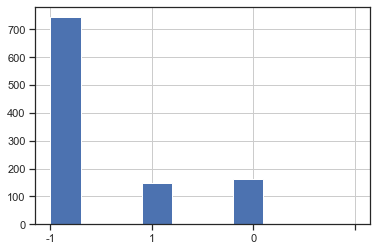

In [17]:
data.sentiment.hist()

# 11.07

In [10]:
politician_screen_names = ('donaldtusk',
                           'KosiniakKamysz',
                           'DariuszKlimczak',
                           'trzaskowski_',
                           'szymon_holownia',
                           'HannaGillPiatek',
                           'krzysztofbosak',
                           'GrzegorzBraun_',
                           'RobertBiedron',
                           'K_Smiszek',
                           'AndrzejDuda',
                           'Macierewicz_A',
                           'ZandbergRAZEM',
                           'bbudka',
                           'FijoKonrad')

dfs_names = ('tusk_tweets',
             'kosiniak_tweets',
             'klimaczak_tweets',
             'trzaskowski_tweets',
             'holownia_tweets',
             'gillpiatek_tweets',
             'bosak_tweets',
             'braun_tweets',
             'biedron_tweets',
             'smiszek_tweets',
             'duda_tweets',
             'macierewicz_tweets',
             'zandberg_tweets',
             'budka_tweets',
             'fijolek_tweets')

In [11]:
tweets = {}
retweets = {}
ret_list = []
fail_list = []

for i in range(0,14):
    try:
        print(politician_screen_names[i])
        (data, posts) = get_replies(politician_screen_names[i], 10, 120)
        tweets[dfs_names[i]] = posts
        retweets[dfs_names[i]] = data
        ret_list.append(dfs_names[i])
        print('done')
    except:
        fail_list.append(dfs_names[i])
        print('ERROR')
        pass

donaldtusk
done
KosiniakKamysz
done
DariuszKlimczak
done
trzaskowski_
done
szymon_holownia
done
HannaGillPiatek
done
krzysztofbosak
done
GrzegorzBraun_
done
RobertBiedron
done
K_Smiszek
done
AndrzejDuda
done
Macierewicz_A
done
ZandbergRAZEM
done
bbudka
done


In [16]:
frames = [retweets['kosiniak_tweets'], 
          retweets['klimaczak_tweets'], 
          retweets['trzaskowski_tweets'], 
          retweets['tusk_tweets'], 
          retweets['holownia_tweets'], 
          retweets['gillpiatek_tweets'], 
          retweets['bosak_tweets'], 
          retweets['braun_tweets'], 
          retweets['biedron_tweets'], 
          retweets['smiszek_tweets'], 
          retweets['duda_tweets'], 
          retweets['macierewicz_tweets'],
          retweets['zandberg_tweets'], 
          retweets['budka_tweets']]
          #retweets['fijolek_tweets']]

In [17]:
data = pd.concat(frames)
data = data.reset_index()
data = data.drop(columns=['index'])
data.to_csv('manual_sentiment_TODO.csv')

## 04.10

In [8]:
politician_screen_names = ('donaldtusk',
                           'KosiniakKamysz',
                           'DariuszKlimczak',
                           'trzaskowski_',
                           'szymon_holownia',
                           'HannaGillPiatek',
                           'krzysztofbosak',
                           'GrzegorzBraun_',
                           'RobertBiedron',
                           'K_Smiszek',
                           'AndrzejDuda',
                           'Macierewicz_A',
                           'ZandbergRAZEM',
                           'bbudka',
                           'FijoKonrad')

dfs_names = ('tusk_tweets',
             'kosiniak_tweets',
             'klimaczak_tweets',
             'trzaskowski_tweets',
             'holownia_tweets',
             'gillpiatek_tweets',
             'bosak_tweets',
             'braun_tweets',
             'biedron_tweets',
             'smiszek_tweets',
             'duda_tweets',
             'macierewicz_tweets',
             'zandberg_tweets',
             'budka_tweets',
             'fijolek_tweets')

In [9]:
tweets = {}
retweets = {}
ret_list = []
fail_list = []

for i in range(0,14):
    try:
        print(politician_screen_names[i])
        (data, posts) = get_replies(politician_screen_names[i], 10, 120)
        tweets[dfs_names[i]] = posts
        retweets[dfs_names[i]] = data
        ret_list.append(dfs_names[i])
        print('done')
    except:
        fail_list.append(dfs_names[i])
        print('ERROR')
        pass

donaldtusk
done
KosiniakKamysz
done
DariuszKlimczak
done
trzaskowski_
done
szymon_holownia
done
HannaGillPiatek
done
krzysztofbosak
done
GrzegorzBraun_
done
RobertBiedron
done
K_Smiszek
done
AndrzejDuda
done
Macierewicz_A
done
ZandbergRAZEM
done
bbudka
done


In [ ]:
for i in range (0,14):
    retweets[ret_list[i]]['text'] = retweets[ret_list[i]]['text'].apply(lambda x: x.strip("@"+politician_screen_names[i]))
    retweets[ret_list[i]]['sentiment'] = np.nan

    sent = []
    for index, row in retweets[ret_list[i]].iterrows():
        print(row['text'])
        sent.append(input())
        
    retweets[ret_list[i]]['sentiment'] = sent

In [12]:
frames = [retweets['kosiniak_tweets'], 
          retweets['klimaczak_tweets'], 
          retweets['trzaskowski_tweets'], 
          retweets['tusk_tweets'], 
          retweets['holownia_tweets'], 
          retweets['gillpiatek_tweets'], 
          retweets['bosak_tweets'], 
          retweets['braun_tweets'], 
          retweets['biedron_tweets'], 
          retweets['smiszek_tweets'], 
          retweets['duda_tweets'], 
          retweets['macierewicz_tweets'],
          retweets['zandberg_tweets'], 
          retweets['budka_tweets']]

In [13]:
data = pd.concat(frames)
data = data.reset_index()
data = data.drop(columns=['index'])
data.to_csv('manual_sentiment_TODO2.csv')

In [8]:
latest_data = pd.read_csv('manual_sentiment_TODO2.csv')

In [14]:
to_input = latest_data.loc[latest_data.sentiment.isna()]

In [19]:
to_input.head()

,Unnamed: 0,text,author,in_reply_to,sentiment
986,986,Jezcze dwie imperzy z pisiorkami i będziesz i...,Slawek,1444980802450862091,-1
987,987,Pan to chyba od tyłu wszystko czyta. Jakaś an...,słonecznik ♫🇵🇱,1444980802450862091,-1
988,988,Panie Borys zamilcz Pan już .Pan jest wrakiem...,jureczek111,1444980802450862091,-1
989,989,A przypominasz sobie jak @Dulkiewicz_A mówiła...,Ela D. 🇵🇱 #PrawaStrona#PolskiŁad#ZAŻYCIEM,1444980802450862091,-1
990,990,Izolują chamy Polaków by nigdzie nie znaleźli...,AntoniStanley,1444980802450862091,-1


In [17]:
sent = []
for index, row in to_input.iterrows():
    print(row['text'])
    sent.append(input())
retweets[ret_list[i]]['sentiment'] = sent

 Jezcze dwie imperzy z pisiorkami i będziesz ich chwalił


 -1


 Pan to chyba od tyłu wszystko czyta. Jakaś antysemitka nie wpuściła pisarza a pan już wojnę szykujesz 😂😂
Lepiej nad programem pomyśl, bo to że umiecie szczuć i kłamać to My już wiemy


 -1


 Panie Borys zamilcz Pan już .Pan jest wrakiem politycznym .I słyszymy pana jeszcze tylko tyle ile Tusk pozwoli.Zaspiewaj se Pan to już było i nie powróci więcej .Koniec


 -1


 A przypominasz sobie jak @Dulkiewicz_A mówiła, że przybył Burmistrz Londynu Sadiq Khan, przybył z kraju egzotycznego?
Co ty możesz pisać o UK ? 
Byłeś tam kiedy? widziałeś kto siedzi w urzędach?
Naczytałeś się tylko o UK i to cała twoja wiedza o tym kraju.


 -1


 Izolują chamy Polaków by nigdzie nie znaleźli pomocy.


 -1


 https://t.co/qqxb5UZtl


 0


 Spierdalaj


 -1


 Wróg zewnętrzny nie jest groźny, najgorszy jest ten wewnętrzny p. B


 -1


 A skąd to twierdzenie, ze UK to nasi wrogowie?


 0


 Największym wrogiem zarówno polskiego rządu jak również całego kraju są osoby szkalujące, opluwające i donoszące na Polskę, tylko przez jakieś kosmiczne nieporozumienie nazywani Polakami.


 -1


 Lepsza taka dyplomacja niż wasze poddaństwo!


 -1


 Do wrogów Donalda dołączył Budka.


 -1


 Borys żeby głupota umiała fruwać już dawno opuściłbyś układ słoneczny....


 -1


 Rok 2013 "Dyplomacja najwyższych lotów"
https://t.co/1S0cmMsvHN


 -1


 https://t.co/xO7BEqnyFX


 0


 https://t.co/QzIwdKSkts


 0


 Lepiej się rozplaszczyć i czekać aż kopną.?🤔


 -1


 W 39r byli przyjaciele.


 -1


 Borysław, idź szukać kolegów na inny portal. Tu ci nie idzie.


 -1


 Wszyscy w PO są tacy niegramotni?


 -1


 WJ na nią


 -1


 Tak jak Ty i Twoja partia dzialala i dziala na szkode Polski i Jej dobre imie to nikt,nikt. Tylko wy Platfomusy Oblakane😂


 -1


 Największymi wrogami Kraju  jesteście wy 


 -1


 Budka, twojej choroby tz. zaburzeń psychicznych które tobie towarzyszą, nie są opisane w żadnej książce naukowej. Chłopie ty naprawdę jesteś pierdolnięty, i to mocno!!!


 -1


 PO to antypolska partia, która szkodzi nam Polakom i Polsce na arenie międzynarodowej. Mam nadzieję, że będziecie zdelegalizowani. Jesteście zdrajcami.


 -1


 Tusk pozwolił zabrać głos? Ale macie dyktaturę w partii.


 -1


 Dlaczego chuje atesztowali redaktora?


 -1


 W pierwszej kolejności trzeba z wami zrobić porządek żebyście przestali szkodzić Polsce.


 -1


 Trzecioligowiec znowu dał głos. Nie boli Pana że taki Franio w tenisówkach, znaczy więcej w PO niż Pan?


 -1


 Zamknij się jaskiniowcu!!!


 -1


 Zmień pampersa.


 -1


 https://t.co/ZmeD4K5WZz


 0


 Borys co się tak rozpisujesz, napisz krotko. Polski Rząd ma wszędzie wrogów. Jak wrócicie do władzy(raczej nie prędko). To Poprostu każde Państwo będzie padało wam do stup.


 -1


 Ależ ty jesteś głupi. Totalnie.


 -1


 Teściowa pomogła Ci. Napisać tego tweeta? https://t.co/GKFTB8T3Ec


 -1


 Oni tacy sami co ty i twoja parti


 -1


 Kochani, to końskie dziecko jest na próg rzeźni.

9 GODZIN! 
BRAKUJE 10.700 ZL 

Proszę, pomóżcie. 👇 
https://t.co/Uc4RjxVvY


 0


 Tfu ci na ryj. To nie ja tylko Tusk😂😂😂


 -1


 Czlonku najwyzszych lotow sa twoje blazenskie wpisy..na kolanach przepraszalbys Angoli za Ziemkiewicza pewnie..


 -1


 A jak wygląda Pana dyplomacja? Przy kielonie?


 -1


 Budka,Ty masz najlepszą dyplomację ☝️
Tusk Ci napluł w gębę a Ty ciągle twierdzisz, że deszcz pada 🤔
Dyplomacja najwyższych lotów 🙄


 -1


 Cieszy cię twój rozwój? https://t.co/IKkNxqi5kJ


 0


 Prawda jest brutalna od dawna większość krajów ma nas w dupie  teraz przestaliśmy im do niej wchodzić, więc dobrze wiedzieć kto jest kim. A wy lubicie siedzenie w dupie a to potem brzydko pachnie.


 -1


 Pan Ziemkiewicz organizuje urodziny.
Będzie Pan na bibie?


 -1


 Gdybyś nie wiedzial wyrachowany manipulatorze, to kobieta, która oskarżyła Ziemkiewicza o rasizm z frakcją konserwatywną nie ma nic wspólnego.

To tak, jakby o Platformie mówić w świecie, że dba o interesy Polski, podczas kiedy PO jest partią proniemiecką.


 -1


 Pana zdaniem najlepsza jest dyplomacja bezobjawowa?


 -1


 A to wszystko przez Ziemkiewicza ....


 0


 Ci sami konserwatyści, co ograli Tuska 😂


 -1


 https://t.co/a9LOoFBNmn


 0


 Wy Budka to byście sobie pozwolili nasrać na  pustą głowę każdej szmacie ,ale nie najlepszy rząd w historii mojej ojczyzny, gonić was antypolskie świnie


 -1


 Pań jeszcze w PO czy j6z Donald wypierd..ł.To przecież on potrafi robić najlepiej


 -1


 Ale dobrze, ze na polskiej opozycji sa takie glupki jak ty. To gwarancja, ze nigdy do wladzy nie dojdziecie.
Smakowala wodka z "pisiorami" na imprezie u Mazurka...tak na marginesie.


 -1


 To tak jak z twoim szefowaniem...😂😂😂


 -1


 Pupka do RAZa Ci za daleko. Daj spokój i  schowaj się za Ryżym. On jest lepszy bo bardziej wredny


 -1


 O widzę, że już Pan wrócił. Schowanie się w cień po urodzinach Mazurka, aby ludzie zapomnieli. Stałe zagranie polityków, każdej władzy !


 -1


 Z tego co mi wiadomo pani Rupa Huq nie jest konserwatystką .


 0


 Pupka na poziomie pupki


 -1


 Z cyklu, przemyślenia szeregowego posła Budki.


 -1


 Ale na jakiej podstawie wyssałeś z brudnego palucha taki wniosek? Jesteś tak samo wiarygodny jak Ryży Fakesdeutsch 🥱


 -1


 Ale masz radochę byś tak się wziął i ziemniaki na obiad obrał o ile jeszcze jest nadzieja że tą czynność potrafisz wykonać


 -1


 No, ale wy Dupka sami nie potraficie pokonać tych pisiorów? 
Tylko ciągle jak nie z Nowakiem gospodarkę rozwalić, to z Łukaszenką, czy Putinem albo jeszcze innymi z Brukseli alianse robicie! 
A tak sami z siebie, to co tylko OFE i zasiłek pogrzebowy skubnąć ?


 -1


 Jesteś żałosny  Zdrowia i Radości Polska damy radę


 -1


 Smutny, smutny....oderwali od koryta, a kłamstwa i pomówienia nie działają. Co robić 🤔🥱


 -1


 Czy Pan już totalnie odlepił się od rzeczywistości?


 -1


 ...tuskowski liżydupa !!!


 -1


 Ma tanie fajki.


 -1


 Ile razy z PiSem się władzą nie zamienicie i tak nikt, nikogo, z niczego nie rozliczy. W telewizji się wyzywacie, a prywatnie wiecie razem pijecie i wspólnie rozkradaxie Polskę w spółkach państwowych, miejskich i samorządach.


 -1


 Won czerwoni złodzieje.


 -1


 Borys nie pierdziel za po to wszystko było cacy .Było dla układu cacy tylko społeczeństwo miało pod górkę. TO DLA TEGO PRZEGRALISCIE WSZYSTKIE WYBORY CO BYLY OD 2015 DO 2020


 -1


 Platformie marzy się lewicowa cenzura za poglądy


 -1


 Kolejny pokaz żenującej, totalniackiej propagandy w pana wykonaniu.
A w realu?
Wasz postulat - podniesienie kwoty wolnej.
Za waszych rządów tego nie zrobiliście.
Potem postulowaliście 10k.
Jak PiS poddał pod głosowanie 30k - byliście przeciw.
Kto normalny wam jeszcze uwierzy?


 -1


 W ramach tolerancji rzuca pan epitetem pod adresem Ziemkiewicza? Czy władze brytyjskie słusznie zawróciły Ziemkiewicza do Polski? Czy władze polskie słusznie zawracają z nielegalnego miejsca na białoruskiej granicy?


 -1


 @Platforma_org Oj smutny ten czas. https://t.co/ozjjHMBdof


 -1


 Smutny to czas, gdy niemieckie i luksemburskie banki odmawiają Polsce zwrotu setek milionów złotych ukradzionych przez złodziei z Partii Oszustów. Wnuczek z Wehrmachtu i jego pomagier łysy Gomułka mogą z radości zacierać rączki.


 -1


 Borysław, zawsze jesteś taki pompatyczno-idiotyczny, może trochę zluzujesz gatki, co? https://t.co/AIZvwtxLwZ


 -1


 Podnóżek Tüska się odezwał https://t.co/a2u67awnbA


 -1


 Brawo budka 👏🏻👏🏻👏🏻👏🏻👍🏻👍🏻‼️‼️


 1


 https://t.co/ugzYQX8UXn


 0


 Z Ziemkiewicza taki ksenofob, jak z Pana konserwatywny chrześcijański demokrata... https://t.co/lOKOZmSE5x


 -1


 Ale to zasługa dziennikarzy, to oni taka papkę podrzucają i grzeją


 -1


 Smutny to czas kiedy taka miernota jak Borys Budka wogóle funkcjonuje w przestrzeni publicznej - dać się tak posunąć Tuskowi - to musi budzić frustrację, przyszedł wasz pełowski gajowy i porozstawiał was po kątach jak dzieci. I tacy ludzie pchają się do władzy - bez jaj, bez ikry


 -1


 Masz szczęście, że po kopie w dupę i żenującym upadku nikt się tobą nie zajął. To przewidywalne, bo nic nie znaczysz.


 -1


 Za nim kogoś debilu znowu oczernisz o złodziejstwo najpierw przypomnij sobie co odwala rudy z resztą chołota złodziejskiej z Platformy, i jebnij się wreszcie w ten tępy łysy caban


 -1


 Kiedyś może napisze pan książkę. "Od przewodniczącego dużej partii do trolla internetowego." To tylko tytuł roboczy, może ktoś wymyślił lepszy 🤪


 -1


 Panie Budka, pan uważa, bo zmieni się linia, albo teściowej się odwidzi i nawet twittera panu zabiorą.


 -1


 Ty Borys, to już musisz mieć jakieś zmiany w mózgu. Gdzieś widzisz jakichś złodziei z setkami milionów, kiedy miliardy za waszych rządów wyciekały, to w polskim pisarzu, patriocie widzisz ksenofoba, a w swoim szefie fur deutschland nie widzisz. Nie widzisz bo się boisz cykorze.


 -1


 Co Borysewicz boli że to niezwykle możecie dalej rozkłada kraj? Nabraliście pożyczek i nie ma jak spłacać kradnąc, dlatego po trupach mając w dupach Polskę i Polaków ciągniecie jak te świnie do koryta. Nic z tego wy do tego koryta już się nie dop chacie jebane złodzieje,


 -1


 borys, tobie.chyba czkawką.odbija się obiad u Mazurka, ty nawet podeszwy nie jesteś godzien lizać R.A.Z - wolę takiego ,,ksenofoba" niż  ciebie jako ,,patriotę" lewactwa i lgbt+alfabet, żenada, tylko państwa narodowe, precz z eurokołchozem 🚾💯✝️🇵🇱


 -1


 Chciałbyś, żeby ludzie władzy was zatrudniali do rozkradania? No tak, z szefa PO na nikogo, to teraz boli łysinka.... Pozdro byku😉


 -1


 Borysek nic nie znaczące ZIRO nawet w PO😃😃😃


 -1


 Budka, jełopie, ciebie Putin przyjmie z otwartymi rękami


 -1


 Potrafisz pan z pamięci opowiedzieć coś o Oxfordzie. 😂😂😂


 -1


 Borys zazdościsz!?! O tobie już nawet nikt nie chce pisać! Nawet jak robisz z siebie idiotę!


 -1


 To jest bardzo mądry człowiek. A ty nie


 -1


 Ta tęsknota za korytem, doprowadzi w końcu do obłędu.


 -1


 Panie Borysie  "szlachetny uczciwy matole" i indolencie prawny, piszesz jako prawnik o setkach rozkradanych milionów-czas donieść do prokuratury, to prawnik powinien wiedzieć. Odrobił byś plusy u nazisty Tuska. Ale lepiej napisz gdzie są setki, ale miliardów z Waszych czasów.


 -1


 Donek pozwolił Ci takie pierdoły pisać?


 -1


 Spadaj 


 -1


 Pan to kanalia pierwszej wody. Dla @R_A_Ziemkiewicz nie jest pan godny butów wiązać.


 -1


 Jakiś przykład tego rozkradania  ?!.


 -1


 a skąd Tuska zawrócili?


 -1


 Tyle tylko, że tego "ksenofoba" zatrzymano na polecenie ciapatej, która sama ma zarzuty o antysemityzm. Jak cię czytam to łapie mnie odrazu łysofobia, a właściwie wkurw.


 -1


 Borysław milcz bo nie ma już z czego ciebie zwolnić


 -1


 Budka, ty to jesteś jednak taka PRLOwska,obsikana budka z ciepłym piwem.


 -1


 Odezwał się obrońca demokracji i wolności słowa. Pewnie cudzym tekstem. Typowe dla środowiska - Cuchnie Czerską i Wiertniczą na kilometr z tego wpisu. Fuj.


 -1


 I po co ci te wypowiedzi? https://t.co/XFWAfGYcJs


 0


 Chyba nie rozumie Pan słowa ksenofob.


 -1


NameError: name 'retweets' is not defined

In [18]:
to_input['sentiment'] = sent

<ipython-input-18-31c7f1c352ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_input['sentiment'] = sent


In [22]:
latest_data.loc[latest_data.sentiment.isna()]

,Unnamed: 0,text,author,in_reply_to,sentiment
986,986,Jezcze dwie imperzy z pisiorkami i będziesz i...,Slawek,1444980802450862091,NaN
987,987,Pan to chyba od tyłu wszystko czyta. Jakaś an...,słonecznik ♫🇵🇱,1444980802450862091,NaN
988,988,Panie Borys zamilcz Pan już .Pan jest wrakiem...,jureczek111,1444980802450862091,NaN
989,989,A przypominasz sobie jak @Dulkiewicz_A mówiła...,Ela D. 🇵🇱 #PrawaStrona#PolskiŁad#ZAŻYCIEM,1444980802450862091,NaN
990,990,Izolują chamy Polaków by nigdzie nie znaleźli...,AntoniStanley,1444980802450862091,NaN
...,...,...,...,...,...
1088,1088,Borysław milcz bo nie ma już z czego ciebie z...,Tommcio,1444951426917179395,NaN
1089,1089,"Budka, ty to jesteś jednak taka PRLOwska,obsi...",Ron Slonsonowski,1444951426917179395,NaN
1090,1090,Odezwał się obrońca demokracji i wolności sło...,Adam,1444951426917179395,NaN
1091,1091,I po co ci te wypowiedzi? https://t.co/XFWAfG...,Obywatel RP,1444951426917179395,NaN


In [24]:
latest_data.shape

(1093, 5)

In [25]:
latest_data = latest_data.dropna()

In [31]:
full = pd.concat([latest_data, to_input])

In [32]:
full.head()

,Unnamed: 0,text,author,in_reply_to,sentiment
0,0,KosiniakbTy też bedziesz wisiał....,Marcin J P,1444637748091031555,-1
1,1,Jak rzadko - popieram to stanowisko PSL. A Sp...,Ryszard,1444637748091031555,1
2,2,"Jacy najlepsi gospodarze, pana koleś Sawicki ...",E. Tomaszek,1444637748091031555,-1
3,3,Władzia a jak tam kurwa wolna stopa od podatk...,Jacek Kowalski,1444637748091031555,-1
4,4,"Wredny, wstretny klamco nie podszywaj sie pod...",RenataAnna,1444637748091031555,-1


In [34]:
full = full.drop(['Unnamed: 0'], axis=1)

In [36]:
full.to_csv('manual_sentiment_6.csv')

In [40]:
data = pd.read_csv('manual_sentiment_TODO.csv', index_col=0)

In [42]:
data.head()

,text,author,in_reply_to
0,@KosiniakKamysz Szczerze? Zaimponował mi Pan. ...,Jarosław Sienkiewicz,1414123847805194247
1,@KosiniakKamysz Ofiary wołają o sprawiedliwość...,mgrdonosiciel,1414123847805194247
2,"@KosiniakKamysz Gdyby jeszcze żyli, PSL pokusi...",Paweł D. Kozieł,1414123847805194247
3,"@KosiniakKamysz Panu, to już dziękujemy.",Andrzej - z lasu 🇵🇱🤝,1414123847805194247
4,"@KosiniakKamysz Władziu, zaklamańcu! Wypierdal...",Maciej,1414123847805194247


In [43]:
sent = []
for index, row in data.iterrows():
    print(row['text'])
    sent.append(input())
data['sentiment'] = sent

@KosiniakKamysz Szczerze? Zaimponował mi Pan. Pierwszy raz w życiu. Obym nie musiał czekać do następnej rocznicy.


 1


@KosiniakKamysz Ofiary wołają o sprawiedliwość  !!!


 0


@KosiniakKamysz Gdyby jeszcze żyli, PSL pokusiłoby się, żeby podnieść im wiek emerytalny... do 95 roku życia. A co!


 -1


@KosiniakKamysz Panu, to już dziękujemy.


 -1


@KosiniakKamysz Władziu, zaklamańcu! Wypierdalaj! 🖕


 -1


@KosiniakKamysz Stary zielony komuchu po wojnie,komuniści jak twoje ugrupowanie zsl robiło to samo,co Ukraińcy, mordowali Polaków, tylko za to ,że byli Polakami prawdziwymi. Tak ty jako spadkobierca zsl,nie masz moralnego prawa użalać się nad losem prawdziwych Polaków, jak robiliście to samo oj.


 -1


@KosiniakKamysz https://t.co/W85voTzpNx


 0


@KosiniakKamysz Wyciągajmy wnioski z historii i budujmy przyszłość jaką wskazują PIASTOWIE : https://t.co/D8Sis38Z96


 0


@KosiniakKamysz Zamordowani przez Ukraińców, Polacy z Wołynia,nadal wymagają ekshumacji,honorowego pochówku i postawienia pomników ku ich pamięci.Rząd Ukrainy aktywnie to blokuje, co jest absolutną hańbą. Słowa już za mało! Rząd polski ma moralny obowiązek naciskać na rząd ukraiński aż do skutku https://t.co/nR5GgOKtnQ


 0


@KosiniakKamysz Zamilcz apartheidowcu


 -1


@KosiniakKamysz @nowePSL Dlaczego przez tyle lat niepodległej Polski, milczeliscie o holokauście Polaków na wschodzie,nie mówiąc że za konkretnymi zbrodniami stali zachodni Ukraińcy


 -1


@KosiniakKamysz Tygrysku obecnie więcej ludzi zmarło z powodu waszych nieodpowiedzialnych decyzji swirusowych także daruj sobie te wypociny patriotyczne 😡😡😡


 -1


@KosiniakKamysz @nowePSL Czy mi umknęło,  ale nie widziałem wczoraj wzmianki @nowePSL o 80 rocznicy mordu w Jedwabnem?


 -1


@KosiniakKamysz @FijoKonrad #nazi #faszysta szmata SSmanska, zrób se lockdown całkowity i schowaj się do nory. Jest wielu ludzi, którzy nie będą mieć nic do stracenia po przymusowym Eksperymencie medycznym #transludzie #transhuman https://t.co/Pac7hfwea7


 -1


@KosiniakKamysz @FijoKonrad Kiedy ludzi zamkniesz do obozu? Zapomniałem , psl utonął w mule.


 -1


@KosiniakKamysz @FijoKonrad https://t.co/wfx8Wxbpf2


 0


@KosiniakKamysz @FijoKonrad 👌


 1


@KosiniakKamysz @FijoKonrad Znowu ten cipowaty uśmieszek. Gdyby nie ojciec komunista to byś na budowie zapier...la jak większość twojej dalszej rodziny co się ich wstydzisz na Święta przy stole. Za ofe i ustawę  67 pod trybunał zdrajców karierowiczów. https://t.co/Q2UnLvUMep


 -1


@KosiniakKamysz @FijoKonrad O segregacji ludzi też?


 -1


@KosiniakKamysz @TheoR64 @FijoKonrad Tygrys ! Zaproponuj coś rolnikom, bo pisiory ci znowu elektorat podwędzą !


 0


@KosiniakKamysz @FijoKonrad Szczepionkowy Tygrysek.


 0


@KosiniakKamysz @FijoKonrad Jak tam segregacja panie prezesie??


 -1


@KosiniakKamysz @FijoKonrad A samorządy miały być niezależne , podział synekur dla krewnych królika ? PSL jest w tym temacie dobry .


 -1


@KosiniakKamysz @FijoKonrad Dezynfekowali się przed focią.🤭🤭😷😷


 0


@KosiniakKamysz @FijoKonrad Zapowiadał pan w Rzeszowie lockdown całkowity? Heil Kosiniak-Kamysz! https://t.co/6jHl9p1BSp


 -1


@KosiniakKamysz @FijoKonrad Dwóch pojeb ów


 -1


@KosiniakKamysz @FijoKonrad ***** PSL KK znowu knuje oszust obrotowy razem z Tfuskiem


 -1


@KosiniakKamysz @FijoKonrad ***** PSL


 -1


@KosiniakKamysz @FijoKonrad Pomiot wyszczepiłeś naziolu?


 -1


@KosiniakKamysz @nowePSL @FijoKonrad Brawo Rzeszów. Teraz czas na Polskę.


 1


@KosiniakKamysz @FijoKonrad A gdzie maseczki szczepionkowy zamordysto?


 -1


@KosiniakKamysz @nowePSL @FijoKonrad To Pan Kosiniak minister od rodziny i pracy za Tuska, jak rządził to w tym regionie nie było pracy ,a rodziny były w biedzie


 -1


@KosiniakKamysz @FijoKonrad Kawusia i koniaczek. Na pewno była rozmowa o Rzeszowie ;)


 1


@KosiniakKamysz @FijoKonrad A maseczka? 👀


 0


@KosiniakKamysz @FijoKonrad Tęczowa zaraza


 -1


@KosiniakKamysz @FijoKonrad gdzie masz szmatę?


 -1


@KosiniakKamysz @FijoKonrad Pozdrawiamy rasistę sanitarnego! https://t.co/Wd68s9hlws


 -1


@KosiniakKamysz @FijoKonrad Co to za menel z prawej.
Taki zarośnięty i brudny.
Arab?


 -1


@KosiniakKamysz @FijoKonrad Pajaców dwóch..


 -1


@KosiniakKamysz @FijoKonrad Może wspólne tournee po stacjach @PKN_ORLEN? Zawsze to kilka groszy mniej na litrze.


 -1


@KosiniakKamysz @FijoKonrad Słyszałem że Pan popiera apartheid sanitarny. Czy to prawda?


 -1


@KosiniakKamysz @FijoKonrad Zajebistą masz tą robotę Władziu. Tu pogadasz, tam popierdolisz z kolesiami, a siano leci. Znakomicie się ustawiłeś. Brawo!


 -1


@KosiniakKamysz @FijoKonrad maseczka!


 -1


@KosiniakKamysz Czy całkowity "lockdown dla niezaszczepionych" to też łączenie? Może lepszy byłby całkowity lockdown od polityki?


 -1


@KosiniakKamysz Proszę nie dzielić na szczepionych i tych co nie chcą brać udziału w eksperymencie medycznym Art 39 konstytucji mówi to coś panu a przymus to możesz sobie zrobić swojej żonie  nie wolnym dumnym Polakom przy urnach odpowiednio Pana potraktujemy  CWP


 -1


@KosiniakKamysz Zabraliście 152 mld z OFE. Za awans Tuska zapłacili wszyscy Polacy. Pytanie gdzie w wyniku przelewu do ZUS zginęło 19 mld? Proszę o odpowiedź. https://t.co/8fQaoy9D9w


 -1


@KosiniakKamysz Dążysz do wojny polsko-polskiej💉. Już ci nigdy nie uwierzę. Chcesz siłą wypuścić stosowanie eksperymentów medycznych na ludziach, a nic nie robisz w sprawach:
#profilaktykaD3 i #iwermektyna.
Odejdź z polityki😡
https://t.co/wfx8Wxbpf2


 -1


@KosiniakKamysz Proszę Pana @KosiniakKamysz, jest Pan marnym hipokrytą

🤮


 -1


@KosiniakKamysz I wykluczaczać niezaszczepionych eliksirem


 -1


@KosiniakKamysz Ty obiecywales hahah a kto ty kurwa jestes zeby z tych obietnic sie wywiązać hmmm? Wszyscy nadajecie sie na taczki pierdolone kurwie mordy! Ty oviecac to mozesz swoim bachorom szczepionke nic wiecej.. idioto pierdolony


 -1


@KosiniakKamysz Sanitarny rasista łączy... https://t.co/AfVSOwJVIw


 -1


@KosiniakKamysz @belingbarbara3 Dobrze, że udało się uchronić urząd przed marginalizacją. PSL stoi za tą kandydaturą i ma szansę nadrobić kompromitację wynikającą z wprowadzenia do Sejmu Kukiza i jego małpiarni.


 1


@KosiniakKamysz Tak dziwisz się to Pan Kaczynski sprytnym wybiegem połączył wszystkich prawie wszystkich,tak zielony komuchu tylko możesz, pomarzyć o tym. Przecież to PIS teraz zgłosił jako kandytata Pana Więcka jako kandytata na RPO,widząc jako odpowiedniego kandytata PIS-u,już pisałem o tym oj


 -1


@KosiniakKamysz @RudaZawistowska Wiącek powinien mieć honor i zrezygnować to nie wybór ponad podziałami lecz układy i korupcja polityczna


 -1


@KosiniakKamysz No tak głupi by tylko w to uwierzył o co chodzi o Politykę !!!!! Coś wam obiecano i tyle w temacie !!!


 -1


@KosiniakKamysz Spietdalaj rasisto covidowy
Segregator jebany


 -1


@KosiniakKamysz Jakby Pan rzucił w kąt ten zielony listek, byłbym skory na pana głosować. 🖖


 1


@KosiniakKamysz Dlatego chcesz siłowo ludzi szczepić pajacu?


 -1


@KosiniakKamysz Naziolu chcesz przymusu szczepien i segregacji.


 -1


@KosiniakKamysz Pajacu chcesz dzielić na szczepionych i nieszczepionych


 -1


@KosiniakKamysz To czemu Pan atakuje Konfederacje jak reszta bandy?


 -1


@KosiniakKamysz Nie mieli wyjścia


 0


@KosiniakKamysz Tygrys cudotworca


 -1


@KosiniakKamysz Jak wybierze go senat to będziesz mógł się cieszyć.


 1


@KosiniakKamysz Panie @KosiniakKamysz, a opowie Pan też o tym, pod jakim warunkiem PiS tym razem zgodziło się poprzeć prof. Wiącka? Może coś o tym, że PiS będzie mógł wskazać jego zastępców?


 -1


@KosiniakKamysz a Kukizowi co obiecałeś ?


 -1


@KosiniakKamysz Baran jesteś i tyle


 -1


@KosiniakKamysz Ty, Tygrusek a co kurwa ze segregacją sanitarna? Co tam pierdoliłeś?


 -1


@KosiniakKamysz Patrzę Wam na ręce:

https://t.co/wfx8Wxbpf2


 -1


@KosiniakKamysz Nas wszystkich: razem, czy osobno?


 0


@KosiniakKamysz A huj z tą telewizją,całą telewizją.


 -1


@KosiniakKamysz fuj fuj fuj, ble.. brzydzę się takimi HIPOKRYTAMI


 -1


@KosiniakKamysz Wolność, wolność, bla, bla, bla.... ale niezaszczepionych do getta!


 -1


@KosiniakKamysz Dobrze pierd0lish towarzyszu, na pierd0leniu, to wy się znacie, na niczym więcej i do tego notorycznie kłamiecie.  W teorii, to nawet pięknie powiedziałeś, ale znając ciebie i twoje ugrupowanie wiem, że jest to fałsz. W praktyce nie ma wolnych mediów, zawsze jest właściciel.


 -1


@KosiniakKamysz Oj to jak iceprezesem był Zalewski to patrzył na ręce Pawlaka 🤔 bo jak pamiętam festiwal w Opolu to wiceprezes Zalewski pokazywał całej rodzinie że to wszystko jego 😁😁 cały festiwal i mogą robić co chcą bo w sumie to jego wszystko


 0


@KosiniakKamysz Tygrysie do boju


 1


@KosiniakKamysz Media niemiecki, które plują na Polskę i Polaków to nie pluralizm tylko kampania na drodze do oddania Niemcom niepodległości. Ale co PSL może o tym wiedzieć.


 -1


@KosiniakKamysz Kufa ostatnio przy każdym wpisie tego pajaca sprawdzam czy to prawdziwe konto, czy może ktoś sobie jaja robi. 😂😂😂


 -1


@KosiniakKamysz Pan - jak zwykle - NIC NIE ROZUMIESZ.


 -1


@KosiniakKamysz Tygrysku, chcesz wolne media ale darzysz do zniewolenia ludzi.


 -1


@KosiniakKamysz Ty czubie masz rozdwojenie jaźni. Mowisz psycholu o wolnym społeczeństwie  i jednocześnie popierasz segregacją sanitarną Polaków. WYPIERDALAJ do psychiatryka niech tam zrobią ci wieczny lockdown.


 -1


@KosiniakKamysz #wypierdalaj


 -1


@KosiniakKamysz Za czasów waszych rządów to były wolne media... wstyd !


 -1


@KosiniakKamysz Baranie przypominam sobie jak dałeś morde żeby zamknąć tvp


 -1


@KosiniakKamysz Wydymańcem lewackim mówimy dobranoc


 -1


@KosiniakKamysz @DanielObajtek Szty k…a że masz jeszcze czelność zabierać glos na ten temat…


 -1


@KosiniakKamysz @DanielObajtek Przecież w innych miastach też tak jest. W centrum drożyzna bo drogie czynsze. Poza centrum ceny tańsze. Nie widzę tutaj nic szczególnego.


 0


@KosiniakKamysz @DanielObajtek Zapraszam do Gdańska; Orlen paliwo po 5,69 ;)


 1


@KosiniakKamysz @DanielObajtek Tak jest. Orlen to złodziejstwo w biały dzień. Już rok nie tankuje u nich paliwa. W mieście X na Orlenie cena 95 5,69 a 35 km dalej na innym orlenie 5,47. Wytłumaczy mi ktoś te różnice w cenach ?


 1


@KosiniakKamysz @DanielObajtek Te tygrysek nie strasz nie strasz bo się ze.....!!


 -1


@KosiniakKamysz @DanielObajtek @nowePSL Znowu ten cipowaty uśmieszek. Gdyby nie ojciec komunista to byś na budowie zapier...la jak większość twojej dalszej rodziny co się ich wstydzisz na Święta przy stole. Za ofe i ustawę  67 pod trybunał zdrajców karierowiczów. https://t.co/Q2UnLvUMep


 -1


@KosiniakKamysz @jadzia48 i kto to mówi ten co chce mordować Polaków berbeluchą


 -1


@KosiniakKamysz @pisorgpl Ja jestem rozczarowana szczepieniem, slyszalam ze wybielą mi się zęby. A tu nic. Moze po trzeciej dawce.


 0


@KosiniakKamysz @pisorgpl Jak można się tak eksperymentować na własnych wyborcach wstyd(szkoda ze polscy politycy nie wiedzą co oznacza to słowo) i nie brać za to żadnej odpowiedzialności, podziękujecie temu Panu przy urnie i na każdym wiecu


 -1


@KosiniakKamysz @pisorgpl Ty propadandysto, sanitarny faszysto! Sam jesteś jak jeden wielki fake news!


 -1


@KosiniakKamysz @pisorgpl Przecież nie było jeszcze trzeciej fali... Panie , wieszcz z Pana niewąski.


 -1


@DariuszKlimczak @nowePSL Porządny chłop i bardzo wartościowa osoba❗ 3mam kciuki za Marcina 👍👍👍


 1


@DariuszKlimczak @nowePSL Przeczytał te wszystkie książki :) ?


 0


@DariuszKlimczak @nowePSL Ło panie a dostał już 👇 https://t.co/4XR9xVTPXd


 -1


@DariuszKlimczak @nowePSL Gratulacje 😊


 1


@DariuszKlimczak @nowePSL @MarekMazur_ Po zdjeciach widac, ze rolnictwo wkraju ma sie swietnie....


 -1


@DariuszKlimczak @nowePSL @MarekMazur_ Gnida pselowska oszust władze pod slolem chciał przejąć Kosiniak na premiera


 -1


@DariuszKlimczak @nowePSL @MarekMazur_ Lepiej nie zaczynające jesteście za dyskryminacją i segregacją narodu więc czym się różnicie od faszystów?


 -1


@DariuszKlimczak @nowePSL @MarekMazur_ Darku, a Kukiz jest?


 -1


@DariuszKlimczak @nowePSL @MarekMazur_ Dużo znajomych twarzy i urocza #Spała 🙂. Pozdrowienia 🙂👍🤩


 1


@DariuszKlimczak @nowePSL Udanych obrad 🍀


 1


@DariuszKlimczak @chesskask100 @KosiniakKamysz Oczywiście. Siła przebicia Kosiniaka w pisie ma moc bomby atomowej. 🤣🤣


 -1


@DariuszKlimczak @nowePSL @KosiniakKamysz Przecież został wybrany głosami PiSu i KO a nie tylko opozycji, policz pan głosy


 -1


@DariuszKlimczak @nowePSL @KosiniakKamysz Jednym słowem, dogadaliście się z PiS 😉


 1


@DariuszKlimczak @nowePSL @KosiniakKamysz W ciągu roku mieliśmy tylu wybranych przez sejm RPO jak jeszcze nigdy dotąd ;]


 1


@DariuszKlimczak A dzisiaj Anglia- Dania! Rozpieszcza nas to Euro w tym roku. Poseł będzie oglądał, czy posiedzenie tak rozłożone, że nie da rady dzisiaj?


 1


@DariuszKlimczak @pisorgpl @KosiniakKamysz Miernoto obrotowa za waszych czasów benzyna była droższa masz krótka pamiec a i zarobki były mniejsze


 -1


@DariuszKlimczak @MKoalicjaPolska @nowePSL Paine @DariuszKlimczak, uprzejmie informuje, że nie ma gotowej szczepionki na covid, dlatego nie może Pan nikogo zmuszać do brania udziału w testowaniu substancji zagranicznych firm farmaceutycznych. Warunkowo dopuszczony produkt nie jest gotową szczepionka. Czy Pn to rozumie?


 -1


@DariuszKlimczak @nowePSL Klimczak dla mnie to możecie nawet ciągnąć lachę dla kolegi.


 -1


@DariuszKlimczak @nowePSL Jeszcze poproszę listę osłów Z ZSL którzy zdradzają żony.


 -1


@DariuszKlimczak @nowePSL Jak pomyślę, że w prezydenckich głosowałam na WKK... https://t.co/5O9p5SiJq0


 -1


@DariuszKlimczak @nowePSL A ja mam w dupie czy sprane mózgi się zaszczepił czy nie.Nigdy nie uważałem waszej partii za mądrą.  P.S jaka partia rządziła najdłużej po 1989r. ?  Jaka partia dawała każdemu aby być u władzy.  To dopiero średniowiecze


 -1


@DariuszKlimczak @nowePSL W ramach ujawniania informacji intymnych proszę powiedzieć nam teraz, którą ręka się Pan masturbuje. To powinny być jawne dane.


 -1


@DariuszKlimczak @nowePSL Już możecie używać waszego prawdziwego logo. Dzięki satrapie z Żoliborza wróciły czasy, do których wam tak tęskno. https://t.co/fy6qPXqJH8


 -1


@DariuszKlimczak @nowePSL A twoje poglądy wybrańcu narodu przez przypadek to nie średniowiecze tylko lata 30 i 40 minionego stulecia.


 -1


@DariuszKlimczak @nowePSL Stan zdrowia to prywatna sprawa.


 0


@DariuszKlimczak @nowePSL Się uśmiałem. Sieczkobrzęk innych wyzywa od średniowiecza.


 -1


@DariuszKlimczak @nowePSL Ja na przykład uważam, że wszyscy politycy powinni przechodzić skrupulatne badania psychiatryczne, a informacja o ich zdrowiu psychicznym powinna być widoczna dla każdego.


 0


@DariuszKlimczak @nowePSL Uważam, ze szalenie G  mnie to obchodzi.


 -1


@DariuszKlimczak @nowePSL Tak i wszystkie badania psychiatryczne oraz wszelkie, jakiekolwiek choroby itd. równiez jawne


 0


@DariuszKlimczak @nowePSL Wszyscy po równo  to w komunizmie Panie towarzyszu Klimczak. Tu jest wolność. Jak się Pan boisz kowida to  szczep się Pan i nos maskę  a od wolnych ludzi wara.


 -1


@DariuszKlimczak @nowePSL I chuj ci w dupę sprzedajna łajzo


 -1


@DariuszKlimczak @nowePSL Temu panu żyłka pękła i ma wylew, dlatego tak bredzi ? Czy to hemoroidy cisną ?


 -1


@DariuszKlimczak @nowePSL Masz bałagan na strychu większy, niż przewidziano w ustawie. Kto głosował na tego zjeba? Przyznać się.


 -1


@DariuszKlimczak @nowePSL 1/2
W średniowieczu był ciemnogród, bo kościół wyznaczał dygmaty, a każdy kto śmiał je zakwestionować był szykanowany. Nauka wygrała i przyniosła postęp, bo każdy miał mieć prawo do odrębnego zdania, liczyły się dowody i argumenty i nikomu nie zamykano ust.


 -1


@DariuszKlimczak @nowePSL Jesteś w stanie jako osobowa stanowiąca prawo w Państwie wziąć odpowiedzialność za szczepionki? Jak nie, to się jeb palancie!


 -1


@DariuszKlimczak @nowePSL Wy wszyscy lepiej pochwalcie się ile udało się ukraść przy korycie!


 -1


@DariuszKlimczak @nowePSL To nie jest zabawa Dariusz. https://t.co/vSxPOrL54w


 -1


@DariuszKlimczak @nowePSL To moze niech peezel zglosi projekt ustawy o obowiazk szcz poslow...zamiast puszczać bąki na TT


 -1


@DariuszKlimczak @nowePSL Gratulacje PSL pro-obywatelskiej postawy !


 1


@DariuszKlimczak @nowePSL Panie Klimczak, szczepionka jest eksperymentem medycznym i obywatele w tym również posłowie, sami będą decydować, czy chcą ryzykować własne zdrowie na ten eksperyment czy nie. Jasne?


 -1


@DariuszKlimczak @nowePSL A mnie to obchodzi tyle, co zeszłoroczny śnieg. Szczep się Pan 20 razy, i wszyscy pozostali oświeceni. Amen


 -1


@DariuszKlimczak @nowePSL Idiota.


 -1


@DariuszKlimczak @nowePSL Ta informacja jest mi zbędna i tak się nie zaszczepie🤷‍♂️🤷‍♂️nawet jakby sie sam papież zaszczepił.


 -1


@DariuszKlimczak @nowePSL Także to, który z posłów ma rzeżączkę, która posłanka suchość pochwy i który nie trzyma moczu...
Jak się bawić to się bawić, w końcu to nic takiego.


 -1


@DariuszKlimczak @nowePSL https://t.co/32yaTLg8x7
Władze Kalifornii płacą odszkodowania za decyzję urzędników którym się wydawało, że zbawiają swiat.


 -1


@DariuszKlimczak @nowePSL Żyjcie sobie w tym oświeceniu nowa bolszewio. https://t.co/FeELwku53w


 -1


@DariuszKlimczak @nowePSL Pan nie powinien się odzywać w tym temacie. Szczepienia są dobrowolne, tak? Jeśli tak to proszę skończyć szkalowanie w Internecie ludzi o innych poglądach!


 -1


@DariuszKlimczak @nowePSL o hemoroidach nie zapomnij informować, zajobie.


 -1


@DariuszKlimczak @nowePSL Gówno mnie to interesuje.


 -1


@DariuszKlimczak @nowePSL A hemoroidy masz ?


 -1


@DariuszKlimczak @nowePSL Najlepsza i formacja dla Polaków to kto ile i dlaczego brał łapówki zasiadając w parlamencie.


 -1


@DariuszKlimczak @nowePSL Informacja o szczepieniu jest informacją medyczną czy nie?Można ujawniać takie Informacje czy nie?Proszę o odpowiedź.


 -1


@DariuszKlimczak @nowePSL O, dzbany w kaloszach dołączają do naganiaczy.


 -1


@DariuszKlimczak @nowePSL A bydło w oborach też zaszczepione w 100%, no chyba macie obory, skoro to partia chłopska.


 -1


@DariuszKlimczak @nowePSL Jesteście w tym pslu tak popier....eni ,że szkoda gadać razem z tym pożal sie bosze tygryskiem! obym was wiecej w tym knesejmie nie widziała !


 -1


@DariuszKlimczak @nowePSL Badania na kiłę i AIDS tez będą jawne?


 -1


@DariuszKlimczak @nowePSL Uważam że powinien Pan publicznie poinformować czy ma pan kiłę. Lista ewentualnych kochanek (bądź kochanków) też powinna zostać ujawniona.


 -1


@DariuszKlimczak @nowePSL Tak samo jak są jawne oświadczenia majątkowe z których wynika że posłowie to najbiedniejsza grupa społeczna. W dupie mam cze się szczepcie czy nie, a może ujawni kiedy seks uprawiałeś, czy masz choroby weneryczne. Poseł a nie rozumie istoty prawa.


 -1


@DariuszKlimczak @nowePSL #wypierdala...


 -1


@DariuszKlimczak @nowePSL a w partii ilu zaszczepionych?? wszyscy czlonkowie partii powinni sie zaszczepic... ich rodziny tez...


 0


@DariuszKlimczak @nowePSL Jakaś chyba nowa strategia w ZSLu się narodziła. Tygrysek na ostro teraz jakiś kolejny prostak w garniturze, którego nie znam wyskakuje z jakimiś pomysłami. Pomyśleliście sobie, że tak zadziałanie na wielkomiejski, covidowy elektorat i oni zagłosują na ZSL ? Świetna strategia.


 -1


@DariuszKlimczak @nowePSL Dlatego właśnie PSL w sondażach idzie coraz niżej...


 -1


@DariuszKlimczak @nowePSL Niedługo to nie będzie twój problem bo nie dostaniecie się do Sejmu.


 -1


@DariuszKlimczak @nowePSL Każdy zaszczepiony poseł powinien nosić opaskę https://t.co/NYprZPlNRq


 -1


@DariuszKlimczak @nowePSL Wy tam w PSL jak tam inne nieobowiązkowe szczepionki ? Ogarnięte ? ospa wietrzna;
kleszczowe zapalenie mózgu;
wirusowe zapalenie wątroby typu A (WZW typu A);
grypa;
zakażenie rotawirusowe;
zakażenia meningokokowe.


 -1


@DariuszKlimczak @nowePSL Iloraz inteligencji podajcie przyglupy.


 -1


@DariuszKlimczak @nowePSL Zajmij się Pan własnym życiem.


 -1


@DariuszKlimczak @nowePSL I 100% baranów


 -1


@DariuszKlimczak @nowePSL Najpierw swój pomiot zaszczep skurwielu https://t.co/u5IJ6kCxkF


 -1


@DariuszKlimczak @nowePSL Może jeszcze długosci penisów i zdjecia wagin? Ja pierdole, sprawy zdrowia to temat miedzy pacjentem, a lekarzem IDIOCI!


 -1


@DariuszKlimczak @nowePSL Ten śmieć jest z ciebie dumny 😏 😏 😏 https://t.co/O1b5KMceyl


 -1


@DariuszKlimczak @nowePSL Ignorancie, nie masz zielonego pojęcia, czym było średniowiecze. Ilość zabobonów wyznawanych przez ciebie znacznie przekracza ilość zabobonów wyznawanych przez najciemniejszego chłopa średniowiecznego.


 -1


@DariuszKlimczak @nowePSL Jestes mega oszolomem chłopie🤦‍♂️Jawnie ,to ty powinieneś trafić za kraty za nawoływanie do łamania konstytucyjnych praw człowieka🤦‍♂️


 -1


@DariuszKlimczak @nowePSL Widzę, że pana wiedza na temat średniowiecza jest delikatnie mowiąc znikoma🤣 ale proszę się nie martwić wsrod polityków a szczegolnie PSLu to norma.


 -1


@DariuszKlimczak @nowePSL Spieprzaj dziadu.


 -1


@DariuszKlimczak @nowePSL Faszysto medyczny - zamilcz.


 -1


@DariuszKlimczak @nowePSL Właśnie w tym momencie przestałem uważać Pana za rozsądnego człowieka.


 -1


@DariuszKlimczak @nowePSL Widzę że idzie nowe w PSL...


 -1


@DariuszKlimczak @nowePSL A może obowiązek wywiezienia cię na taczce gnoju za nie spełnianie tzw" obietnic wyborczych "?


 -1


@DariuszKlimczak @nowePSL Panie Pośle. Stop. Takie informacje to są dane wrażliwe, medyczne. To nie są informacje, co do których można żądać ich upubliczniania.


 0


@DariuszKlimczak @nowePSL Dla PSL 100% zaszczepienie posłów to szczyt tego, co możecie w tej kadencji osiągnąć.


 -1


@DariuszKlimczak @nowePSL Tylko totalny ignorant może mówić, że średniowiecze to czas zacofania i ciemnoty.


 -1


@DariuszKlimczak @nowePSL Wszystkim posłom zabrać pensję do końca pandemii!!! Kryzys jest, też powinniście się dołożyć


 -1


@DariuszKlimczak @nowePSL Oświecony i nowoczesny idioto, w ogóle mnie nie interesuje kto jest zaszczepiony.


 -1


@DariuszKlimczak @nowePSL Kolejny matoł, który nic nie wie o średniowieczu...


 -1


@DariuszKlimczak @nowePSL Ależ upadek...


 -1


@DariuszKlimczak @nowePSL Segregacja, jakie to fajne.


 -1


@DariuszKlimczak @nowePSL Zaraportuj baranie jak będziesz miała syfa.


 -1


@DariuszKlimczak @nowePSL Polityczna zagrywka i przechwalstwa! Nie pomoże  to w sondażach! Gorzej, wychodzicie na sanitarnych faszystów. Nie ma tylko jednej choroby zrozum !!!🤦


 -1


@DariuszKlimczak @nowePSL PSL jaka kompromitacja !!! Na całej linii!!! Jeżeli ludzie nie chcą ryzykować zdrowia przyjmując preparat to po co ich namawiać! Najwidoczniej przypomnieli sobie, że sezon grypowy jest co roku od setek lat, a nie jakieś wymyślone FALE !!! Debile z PSL !! Kto się bał to przyjął!


 -1


@DariuszKlimczak @nowePSL słoma ci z butów wystaje


 -1


@DariuszKlimczak @nowePSL Hmm, a mówili, że Pawlik Morozow umarł bezpotomnie...A jednak jego duch żyje nadal i nawiedza kolejnych...


 -1


@DariuszKlimczak @nowePSL A to czy poseł jest obrzezany też będzie trzeba ujawniać?


 -


@DariuszKlimczak @nowePSL Przynależność do grupy klepiącej się po plecach jest w wielu przypadkach ważniejsza od zdrowego rozsądku. Jeszcze będziemy się z was śmiać.


 -1


@DariuszKlimczak @nowePSL ,,w klubie nowePSL 100% zaszczepionych" 
Tym samym ujawnił Pan Polakom czy dany poseł jest zaszczepiony czy nie.
(No ale co to za szczepienie koniczyną)🙆‍♀️


 -1


@trzaskowski_ @warszawa https://t.co/PA4LOTj03S


 0


@trzaskowski_ @warszawa Gówna z czajki też podrzucisz?


 -1


@trzaskowski_ @warszawa Ubeckie pedały z putinowskiej Brukseli .


 -1


@trzaskowski_ @warszawa https://t.co/6bdiZMsUob


 0


@trzaskowski_ @warszawa A zagonić dzieciaki do poszerzania przstanków. Do zbierania g.... z Wisły.


 -1


@trzaskowski_ @warszawa Pokaż im tramwaje. Koreańskie.


 -1


@trzaskowski_ @warszawa Zajebista inicjatywa, na 35 tys miejsc przyszło 8 -mioro dzieci rodziców z warszawskiego ratatusza, rabiacych w *huja  Warszawiaków🤦🤦😂😂😂Ale jest mozliwosc skitrac pareset tysiaca na boku , jest akcja , jest kasa 😎🤦🤦🤦


 -1


@trzaskowski_ @warszawa "O matko kochana, jaki Pan jest niepotrzebny!"


 -1


@trzaskowski_ @warszawa No wam to bym dzieci pod opiekę  nie dała. Powiniście mieć zakaz zbliżania się  do dzieci.


 -1


@trzaskowski_ @warszawa No aktywne 🤣 Wypadek za wypadkiem,nie mieszczące się tramwaje na przystankach,droga szamba do Wisły i Pedały na ulicach 👎Taki widok mają dzieci,😡😡😡


 -1


@trzaskowski_ @MarioAwario @warszawa 👏👏👏


 1


@trzaskowski_ @warszawa Gdzie palety!


 -1


@trzaskowski_ @warszawa Brawo panie prezydencie WAWA zawsze dbała o dzieciaków


 1


@trzaskowski_ @warszawa Campus tuska


 -1


@trzaskowski_ @warszawa Kiedy szczepienia na stadionie SKRY


 0


@trzaskowski_ @warszawa A jak tam Rafał z Canapa Polska za niemieckie pieniądze? Będzie to kontynuowane czy Tusk zabronił?


 -1


@trzaskowski_ @warszawa Niemiecki konusie, nie przejmuj się hejterami! Nienawidzą cię, bo jesteś wysoki i szczupły!


 -1


@trzaskowski_ @warszawa Czy to prawda, że 72% dochodu miasta przeznaczone jest na pensje dla urzędników?


 -1


@trzaskowski_ @warszawa Panie @trzaskowski_  a gdzie Pana promowane grupy LGBTQIP+ i 🌈🌈🌈 się podziały ? Przecież Warszawa miała być tęczowa i tolerancyjna🤔a tu chłopcy grają w piłkę zamiast biegać w spudniczkach 😃Ideologia dewiacji się nie przyjęła w stolicy ?


 -1


@trzaskowski_ @warszawa A miejsca w tych nowych za szerokich tramwajach jeszcze są


 -1


@trzaskowski_ @warszawa https://t.co/DnFeItY3Jy


 0


@trzaskowski_ @warszawa Świat według kiepskich -Lato W Mieście. Taka Warszawa.


 -1


@trzaskowski_ @warszawa Do czajki zapraszasz dojeżdzając nowym tramwajem? 🤔 Czy warsztaty z obsługi taśmy też będą? 🤔


 -1


@trzaskowski_ @warszawa Gruby robi filmy żeby pokazać że ciężko  pracuje🤣😂🤣


 -1


@trzaskowski_ @warszawa Ty znowu w Warszawie ? Nie nudzi ci się ,ryży pokazał ci miejsce w szeregu🤣🤣🤣


 -1


@trzaskowski_ @warszawa 🤣🤣🤣


 -1


@trzaskowski_ @warszawa https://t.co/7rw2mxU86V


 0


@trzaskowski_ @warszawa 👏👏👏


 1


@trzaskowski_ @warszawa Ależ pan wysoki🙄 puścić na tory te Koreańskie tramwaje za 2 MILIARDY❗️❗️❗️To ułatwi życie starszym i niepełnosprawnym, do tych zabytków które jeżdżą teraz w Warszawie-z wysokimi schodami nie ma szans się wdrapać.NAPRAWIĆ I SPRZĄTNĄĆ WINDY przy kładkach.❗️ DOŚĆ LANSU-DO ROBOTY.❗️


 -1


@trzaskowski_ @warszawa o matko! w adidasach bez koturny już pan taki niewysoki 😂


 -1


@trzaskowski_ @warszawa a kudłaty ostatnio lansował taki wypoczynek !!! https://t.co/6AHRF7qsgc


 0


@trzaskowski_ @warszawa Zostajesz na całe wakacje?


 0


@trzaskowski_ @warszawa Panie Rafale ..Putin to poluje na niedźwiedzie strzela z łuku lata su 50 rzuca hanami o mate a pan tu na maszynie dzierga?..komu pan szyję te buty.


 0


@trzaskowski_ @warszawa Jak Tusk cię wyeliminował to została ci tylko taka zabawa 😂😂😂😂


 -1


@trzaskowski_ @warszawa Pedofilska Opozycjo, totalitarna ideologia lgbt, precz, ku... od dzieci, i to szybko


 -1


@trzaskowski_ @warszawa Taka ciekawostka.

Rafał Trzaskowski ma tyle samo wzrostu co Napoleon Bonaparte.


 0


@trzaskowski_ @warszawa A prześlesz fotografię wyremontowanego stadiony Skry 😝


 0


@trzaskowski_ @warszawa https://t.co/32t9qVGTZz


 0


@trzaskowski_ @warszawa Jedyne co potrafisz to lansować LGBT wśród dzieciaków zboku.


 -1


@trzaskowski_ @warszawa https://t.co/NCbNN90Z1J


 0


@trzaskowski_ @warszawa Do roboty się weź nierobie z KO


 -1


@trzaskowski_ @warszawa Hhehe najlepsze te wysypisko smieci gdzie dzieci maja grzevac w odpadach...hehhe


 -1


@trzaskowski_ @warszawa I dobrze, dla dzieciaków wszystko.


 1


@trzaskowski_ @warszawa A tramwaje nie za szerokie?


 -1


@trzaskowski_ @warszawa A dla emerytów mam 20groszy. https://t.co/zn9qdoPi9T


 -1


@trzaskowski_ @warszawa A może atrakcja dla dzieci była by przejażdżka zaszerokimi tramwajami które nieudaczniku kupiłeś ile będą stały w zajezdniach


 -1


@trzaskowski_ @warszawa Kiedyś znowu dojdziecie do koryta. Bądźcie tak zaradni jak Rostowski co kasę  ma a mówi że piniędzy ni ma. https://t.co/C5aMQqErnc


 -1


@trzaskowski_ @warszawa https://t.co/2onnBPwyWk


 0


@trzaskowski_ @warszawa A seks edukatorów już zamówiłeś do dzieci platformiany dewiancie ??


 -1


@trzaskowski_ @warszawa Nie sciemniaj 👎


 -1


@trzaskowski_ @warszawa Jakie atrakcje? Rozdawanie konstytucji, przebieranie dziewczynek w spodnie i chłopców w sukienki? Ale jak patrzę na te zdjęcia to Ty naprawdę wysoki jesteś! Najwyższy w grupie!


 -1


@trzaskowski_ @warszawa https://t.co/K0NTxcuUAE


 0


@trzaskowski_ @warszawa Musimy być czujni, Rafau Szambo Wybiło 
@trzaskowski_ ma niecne myśli!!!
Ręce precz od dzieci!!! Niemiecka Piąta kolumna.
Aborcja zabija, tęcza nie obraża. https://t.co/mE0cfudZY3


 -1


@trzaskowski_ @warszawa To tyle POpaprańcu! https://t.co/FKULrVijf3


 -1


@trzaskowski_ @warszawa zostań już z tą Warszawą, bo też stracimy.. https://t.co/tJCfzKJKJv


 -1


@trzaskowski_ @warszawa O matko, jaki pan wysoki🙄ze 3 metry pan ma albo więcej🤔😁kiedy te Koreany za 2 miliardy ❗️na torach?jak na razie to stękające trupy chyba z muzeum wyciągnięte jeżdżą w STOLICY EUROPEJSKIEGO KRAJU.❗️❗️❗️Kiedy ta 👇zakała z wysokimi schodami zniknie z torów?😠 https://t.co/c56luvXcjy


 -1


@trzaskowski_ @warszawa A karta elgiebete w zanadrzu... taki swoisty as w rękawie, taka wisienka na torcie


 -1


@trzaskowski_ @KolendaK @faktypofaktach @tvn24 "PO" to samo zło!!!!!!


 -1


@trzaskowski_ @KolendaK @faktypofaktach @tvn24 Zabraliście 152 mld z OFE. Za awans Tuska zapłacili wszyscy Polacy. Pytanie gdzie w wyniku przelewu do ZUS zginęło 19 mld? Proszę o odpowiedź. https://t.co/8fQaoy9D9w


 -1


@trzaskowski_ @KolendaK @faktypofaktach @tvn24 Ale ty Rafałku skarlałeś ale po takim dymaniu jakie Ci zafundował Tusk i reszta PO to nic dziwnego


 -1


@trzaskowski_ @warszawa Oby tak dalej.. Panie.. Rafale...


 1


@trzaskowski_ @warszawa PRAWDZIWY PREZYDENT MIASTA STOŁECZNEGO WARSZAWY 😍💖🙏


 1


@trzaskowski_ @warszawa @JustynaGlusman Przyjechałem do Warszawy. I z przerażeniem stwierdziłem, że mój koszt jazdy autem po tym mieście jest malutki w stosunku do opłat parkingowych, którymi odchudzano mój portfel na każdym placyku. TRAGEDIA! 5zl, 5 zł, 10 zł. W moim mieście opłata nieznana.


 -1


@trzaskowski_ @warszawa @JustynaGlusman Szambiarz wiślany zaprasza nad Wisłę?..
Paradne!..😂


 -1


@trzaskowski_ @warszawa @JustynaGlusman Tusk go wyrolowal, więc będzie wypoczywać nad smierdzaca woda.


 -1


@trzaskowski_ @warszawa Zwyrodnialcy  lewaccy lapy precz od powstańców warszawskich


 -1


@trzaskowski_ @warszawa Wszystkiego najlepszego z okazji urodzin  życzę Pani zdrowa bo to najważniejsze i by Pani nam jeszcze długo żyła 
Cześć i chwała bohaterom


 1


@trzaskowski_ @warszawa A kogo oni reprezentują niemców czy ruskich .


 -1


@trzaskowski_ @CTomczyk @donaldtusk @Platforma_org @AGajewska Tusk spuścił Rafałka Czaskowskiego jak się spuszcza wodę w kiblu.Pogratulować panie mierny ale wierny pseudo przydencie.


 -1


@trzaskowski_ @donaldtusk @Platforma_org @AGajewska W Gdańsku też szło świetnie... Ja nie mogłam nadążyć ,licząc  przechodzących , natomiast mój mąż policzył podpisujących 50 / 5 os.
Nie rozumiem po co się oszukujecie? 
No ale warto próbować  :)


 -1


@trzaskowski_ @donaldtusk @Platforma_org @AGajewska Hheheh bardziej realne STOP TVN niemieckiego scierwa...juz nie długo koniec


 -1


@trzaskowski_ @donaldtusk @Platforma_org @AGajewska Ja się podpisałem w Szczecinie. Nie chcę już tej propagandy. TVP Info do końca życia będzie mi się kojarzyło z Ewą Bugałą i jej "bugaleniem". To straszne.


 1


@donaldtusk Tfu...💦ty szujo i zdrajco, ty głupi jesteś myśląc że my Polacy nie możemy zweryfikować twoich kłamstw. Won niemiecki dywersancie!


 -1


@donaldtusk Ciąży wam polskość,  tow.Tusku?
Zatem WYPADAJCIE z Polski!!
Czego tu jeszcze szukacie?
Czemu dręczycie  obcą wam ziemię,  ziemię polską?!


 -1


@donaldtusk Donek ciebie wyniosą na widłach szybciej niż ci się wydaje. Razem z Kaczyńskim.


 -1


@donaldtusk KRZYCZEĆ TO TY BĘDZESZ,JAK CI ZACZNIE WYŁAZIĆ BOKIEM KRZYWDA LUDZKA.


 -1


@donaldtusk Trzy akordy darcia mordy


 -1


@donaldtusk Bezprawie to Pan zna doskonale w końcu sam pan jest jego przedstawicielem


 -1


@donaldtusk To krzycz, a nie machaj rękami jak wiatrak...


 -1


@donaldtusk Rudy idź się leczyć falszywcu.


 -1


@donaldtusk Wypierdalaj do siebie a jak nie to ukraińskie służby ci się do dupy dobiorą za twojego kolegi @SlawomirNowak za przekręty na Ukrainie pociągnie cię na dno oboje w jednej celi w ukraińskim więzieniu


 -1


@donaldtusk @Zaba_z_Zielonki Co za głupi wpis dla robali spod swojego kamienia.
Krzycz TW Oskar, jak Marta, Je*ać PiS! Wypier*alać! To jest wojna! I takie tam. Skończysz jak i ona.
Tak się Donku Oskarku odkleiłeś, że aż mi cię nie szkoda


 -1


@donaldtusk Niemiecki agent o demokracji 😁😁


 -1


@donaldtusk @marian_kubica Donald szczery i przyzwoity😂😂😂 padłem😂


 -1


@donaldtusk https://t.co/rLKft26CeW


 0


@donaldtusk Więcej by Pan zyskał, gdyby zamilkł . Już narobił Pan wystarczająco dużo zła naszej ojczyźnie!


 -1


@donaldtusk https://t.co/vH3xzEHIne


 0


@donaldtusk Tusk w gwałtach to ty jesteś ekspertem. Pamiętasz jak zgwałciłeś biedną paprotkę od Leszka?


 -1


@donaldtusk Rycerz zakuty łeb powrcił Tusk liczył na miliony zwoleników, dostał czarną polewkę...


 -1


@donaldtusk uspokój się


 -1


@donaldtusk Pamiętasz zakłamany POpaprańcu czasy kiedy na ulicę Warszawy musiało wyjść 200 tys ludzi bo blokowaliście wydanie koncesji TV Pamiętamy zwalnianych dzienikarzy i redaktorów naczelnych   TVP kiedy śpiewano ci 100 lat dzienikarzy  którzy prowadzili stronicze wiadomości Wolność  PO


 -1


@donaldtusk Tak właśnie myśli Donald Tusk👹 https://t.co/qVnfOKUTVq


 -1


@donaldtusk a ty nie pamiętasz jak byłeś u władzy jak sądy na telefon załatwiałeś jak kradłeś i wiek emertytalny wydłużyłeś i śmiałeś się ludziom w twarz 🤬


 -1


@donaldtusk POLSKA WOLNA OD TUSKA ZŁODZIEJA I JEGO RODZINY 
☝☝☝☝☝☝☝☝☝☝☝


 -1


@donaldtusk JESTES GORSZY OD HITLERA
TY KOZI SYNU


 -1


@donaldtusk Walnij sobie zolwiki z Putinem.
Od razu poczujesz przyplyw sily i nadziei.


 -1


@donaldtusk 🙃


 -1


@donaldtusk https://t.co/ejMBm2BvAO


 0


@donaldtusk Jednak, w przeciwieństwie do chyżego  roja Donalda Tuska, chcą Polski, choć ułomnej niestety. Chyży rój Donald Tusk chciał i chce zamiast Polski landu niemieckiego. Poszoł won zaprzańcu. Jesteś największą gnidą jaka pojawiła się w polskiej polityce przez 32 lata tzw. wolności !!


 -1


@donaldtusk Goebbels też krzyczał "kłamstwo powtórzone tysiąc razy staje się prawdą".Nie jesteś człowieku prekursorem idei kłamstwa,ale zmierzasz w dobrym kierunku.


 -1


@donaldtusk Krzycz frajerze.


 -1


@donaldtusk Łamałeś i ty konstytucję. Umierali to ludzie z głodu za twoich rządów. Uciszałeś ludzi przez odbieranie dzieci żeby dużo nie krzyczeli. Konstytucję łamałeś sprzedając zakłady i wyrzucając ludzi na bruk. Więc przestań oszuście wypisywać bzdury.


 -1


@donaldtusk Tusku jaka była wolność mediów za twojego premierowania szantaże dziennikarzy i zabieranie siła w biurze dziennikarskim laptopa my pamiętamy jak było nigdy więcej


 -1


@donaldtusk Na Twoje szwabskie ujadanie prawdziwy Polak się już nie da nabrać. Idź wyć do czarnego orła lub dwunastu gwiazdek których symbol pierwotny został zbeszczany przez ideoligie cztech liter.


 -1


@donaldtusk Ubeckie pedały z Brukseli putinowskiej


 -1


@donaldtusk Napisałeś to osobie i bandzie PO . Przeczytaj to sam jeszcze raz - to o tobie i zdrajcach narodu


 -1


@donaldtusk Za twoich czasów do demokracji  kazałeś strzelać  ,teraz na ulice wychodzi każde gówno Lgbt itd ....i nic .


 -1


@donaldtusk Polscy naukowcy i studenci z AGH - brawo! 
Obecnie, głównym narzędziem badawczym jest LHC Warunki jakie panują podczas zderzeń protonów w LHC są podobne do tych jakie istniały tuż po Wielkim Wybuchu. W tym sensie LHC odtwarza stan wczesnego Wszechświata. https://t.co/NqSI9vJbl7


 1


@donaldtusk W 2007 Donald Tusk powiedział: Przysięgam Polakom, że każdy kto w moim rządzie zaproponuje podwyżkę podatków zostanie przeze mnie osobiście wyrzucony. Panie premierze co z tą prawdomównością? Czyżby miał Pan rozdwojenie jaźni?


 -1


@donaldtusk Jeszcze jakieś fakty. https://t.co/yMVSqkFOhx


 0


@donaldtusk Pamietam jak mieszkałeś w małym mieszkanku z żona i dwójką dzieci . Pamietam jak piałeś się depcząc wszystko za sobą by dorwać się do władzy . Pamietam jak w ciszy pokątnie z szemranymi osobami knułem plany by dorwać się do władzy . Ja nie zapomniałem kim jesteś i co zrobiłeś .


 -1


@donaldtusk Złodziej zawsze krzyczy najgłośniej "łapać złodzieja"... https://t.co/AjbmNeIQTm


 -1


@donaldtusk A tak  naprawdę  to ile  masz  płci  Tusku  ?! https://t.co/BC3wB3jKCU


 -1


@donaldtusk Frustrat i obłudnik .


 -1


@donaldtusk Her  ! Tusk  to jaki  plan  macie  na   Prawice  !?
Będziecie  Nas  gazować  ,strzelać  w tył  głowy  ,bo  tak  od  kiedy  wróciłeś  z emigracji  to nic  nie  robisz  tylko  straszysz. https://t.co/KbfYk9J6wO


 -1


@donaldtusk przestań wrzeszczeć, idź do kościoła, tam ciebie nie zgwałcą, spokojnie, posiedź w ciszy, pomódl się, jeśli to potrafisz, a jak nie to posiedź w ciszy....proś o łaskę i żałuj za grzechy.


 -1


@donaldtusk Witam i Dziękuje Panie Donaldzie że Pan wrócił


 1


@donaldtusk siedzisz w gównie po szyję i udajesz ,że jest ok.. Optymista


 -1


@szymon_holownia No tobie napewno, bo Cię sponsorzy opuszczą 😂.poza tym nie wycieraj se gęby zamordowanymi przez Niemców ludzmi.a po drugie tysięcy zarżniętych na Wołyniu to już można zapomnieć?hipokryto.


 -1


@szymon_holownia Na zawsze w sercach i pamięci.


 1


@szymon_holownia Kiedy ekshumacja?


 -1


@szymon_holownia Trzeba przypominać te około 400 imion, zwłaszcza Niemcom.


 0


@szymon_holownia Na Wołyń czasu zabrakło???🤦‍♂️🤦‍♂️🤦‍♂️.


 -1


@szymon_holownia A co ma Jedwabne do Wołynia i Ukraińców? Zaściankowy, patriotyzm się odezwał...Równie dobrze możecie użyć argumentu, że w Ameryce biją Murzynów, a w Chile mordowała Hunta. Polacy to nie tylko "za wolność waszą i naszą". Polacy też mordowali i sprzedawali Żydów taka prawda.


 -1


@szymon_holownia Szymon zapodaj nr.konta ,przyjechałem z wczasów i trochę na tacę mi zostało


 0


@szymon_holownia A co z imionami Pilaków pomordowanych przez nacjonalistyczno-szowinistycznych Ukrainców?


 0


@szymon_holownia Czy ktoś z pana rodziny mordował tych ludzi ?


 0


@szymon_holownia Proszę  o zapoznanie  się  z HISTORIĄ!!!!!! https://t.co/g7I0DRM7QR


 -1


@szymon_holownia A Wołyń Pan upamiętniłeś czy nie starczyło czasu?


 -1


@szymon_holownia Panie Szymonie.
Proszę oszczędzić czas i zabrać się za ratowanie Polski.
Wielu pokładało nadzieję ....
Czas pokazuje jak się myliliśmy


 0


@szymon_holownia A o tych wolno zapomnieć? https://t.co/FsrLJpo6Ro


 0


@szymon_holownia Czy jest pan za ekshumacją i raz na zawsze rozwiązania ty półprawd?


 0


@szymon_holownia Wołyńskich ofiar nazwiska też odczytasz?


 -1


@szymon_holownia @tzimoch https://t.co/9dzZjgKTqm


 0


@szymon_holownia @tzimoch JAKA JEST RÓŻNICA  MIEDZY SZWABAMI PO A HOLOWNIA  NIE MA ŻADNEJ  TO TE SAME GOWNO OTWÓRZCIE OCZY   !!!!!!! IDENTYCZNE POGLĄDY


 -1


@szymon_holownia @tzimoch Rozbeczałeś się?Nie zapominaj po
"każdym orędziu" beczeć


 -1


@szymon_holownia @tzimoch Hołownia misję wykonał, przetrzymał wyborców dla Tuska i teraz może się zwijać, a wyborcy znów dali się nabrać


 -1


@szymon_holownia @tzimoch https://t.co/NG8uQ4eXyk


 0


@szymon_holownia @tzimoch Tusk wbił sztylet w twoje plecy i to tak fałszywie jak POtrafi a rzekomo ciebie popierał , kiedyś napisałem że będziesz podawał marynarki i skończysz jak Rysio na politycznym dnie i niebawem słowo stanie się ciałem


 -1


@szymon_holownia @tzimoch Przerywanie transmisji sportowych reklamami owszem jest szkodliwe, ale w skali Europy czy świata nie jest to nic nowego. Od lat tak to wygląda w choćby w Niemczech czy USA


 0


@szymon_holownia @tzimoch Sztylet,wbija,wolne,media i tak w koło Macieju.Szczegolnie śmieszą te wolne media.Chyba mówi o TVN?


 -1


@szymon_holownia @tzimoch Czy doprawdy największym zagrożeniem  jakie niesie zmiana prawa medialnego jest możliwość przerywania reklamami transmisji sportowych, programów dla dzieci? Tylko takie zagrożenie Pan akcentuje na tt????


 -1


@szymon_holownia @tzimoch Ale przy okazji zaplacmy Panu na propagande
Zapomnial Pan to dodac do wpisu


 -1


@szymon_holownia @tzimoch Tusk wrócił i Pan Hołownia coś ucichł...😂😂😂


 -1


@szymon_holownia @tzimoch I co, znowu będziesz płakać?


 -1


@szymon_holownia @tzimoch Szymon nie rycz, może po tej całej zabawie w politykę wezmą cię do Polsatu.


 -1


@szymon_holownia @tzimoch Szymusiu, to nie jeden, a sto tysięcy sztyletów


 -1


@szymon_holownia @tzimoch To niech pan dalej się z nimi brata


 -1


@szymon_holownia @tzimoch Jak Pan może ciągnąć politykę w takim kierunku i wieczorem klęczeć przed Bogiem? Nawet się pan nie wypowiedział w sprawie aborcji 👎Bóg nierychliwy ale sprawiedliwy, zapamiętaj Pan. Kto zamyka oczy na krzywdę najsłabszych nie może być dobrym człowiekiem.


 -1


@szymon_holownia @tzimoch Ty bo mam 10.000 zł legalne raczej, od babci dostałem, która kazała mi wpłacić na twoje konto, podaj numer konta, bo babcia chce zobaczyć przelew,  wiesz o o co chodzi,  po połowie 😎, czuwaj.


 -1


@szymon_holownia @tzimoch Najlepiej by urodziny Hitlera pod fałszywą flagą odbywały się codziennie, prawda? Ciekawe jaki dumny zachodni kraj pozwoliłby na istnienie TVNu po czymś takim. Są pewne  granice wolności słowa. Np w Niemczech stanowi je ustawa o Volkerverhetzung. Można  2 lata w zawiasach dostać.


 -1


@szymon_holownia @tzimoch Synku, sztylet nie psuje. Sztylet nadpsowanej krwi upuszcza. Ciesz się, że to nie mizerykordia.


 0


@szymon_holownia @tzimoch Goń się TVNowski bękarcie udający katolika.


 -1


@szymon_holownia @tzimoch To gdzie startujesz z jedynki na liście " konkurenta" Tuska ?🤣


 -1


@szymon_holownia @tzimoch Ty mnie Szymuś pokaż polską stacje tv  o ogononiemeckim zasięgu w Niemczech 
A może podobna niemiecką w Stanach a może we Francji .
Zamienilscie antypisizm w antypolsksc i tyle .


 -1


@szymon_holownia @tzimoch Jakie tam wolne.


 0


@szymon_holownia @tzimoch Szymek, nie pierdol. Ciebie już nie ma. Pomimo pustynnych górali stojących za tobą.


 -1


@szymon_holownia @tzimoch https://t.co/ihpafoKSfy


 0


@szymon_holownia @tzimoch Nareszcie!to nie są wolne media .To szczujnie!


 -1


@szymon_holownia @tzimoch No faktycznie! Jak będzie możliwość przerywania transmisji sportowych reklamami to JEST to zamach na wolne media. Panowie 2050.


 -1


@szymon_holownia @tzimoch Widzę, że stała trollerka w akcji. Dba o zasięgi a tak bełkocze, że szkodzi sobie samym


 -1


@szymon_holownia @tzimoch Co powiesz o zabójczych szczepionkach? Znowu nic? Tak myślałem.


 -1


@szymon_holownia @tzimoch Reklame będą przerywać reklamą? A może niech będą same reklamy niż jakiekolwiek wartościowe treści.


 0


@szymon_holownia @tzimoch Panie Szymek, Pan  może się zgadzać lub nie. Dla samego projektu jest to  obojętne


 -1


@szymon_holownia @tzimoch Biegnij do Biedronki ,mają promocję .zaczym się zwiną!!!


 -1


@szymon_holownia @tzimoch Szymonku .takie jest Prawo Tima
Kurwy Były i Kurw nima!!


 -1


@szymon_holownia @tzimoch Szymonku gdzie ty wrócisz? Płacz głupi płacz!! Szkoda twoich łez ty świnio czas już  zbierać się .czas miną .rycz głupi rycz!😀😀


 -1


@szymon_holownia @tzimoch O wreszcie coś o czym masz pojęcie TV. Tylko zmienił bym słowo „wolne” na „zagraniczne”.


 -1


@szymon_holownia Zbieranie  na  tacę


 -1


@szymon_holownia Dobre rozmowy : Zbieram na tacę 😂😂😂😂


 -1


@szymon_holownia Dobra Szymuś pakuj walizki, wrócił Donek. Także chusteczki w dłoń i wynocha z piaskownicy. Ależ oni koncertowo dymają Polaków.


 -1


@szymon_holownia Na co waśnie ,przemówienia zapowiedzi głupie przecież wszyscy i tak sKOńczycie w d.....


 -1


@szymon_holownia Roman oglądaj!!! https://t.co/m6vZvjdQsS


 0


@szymon_holownia Moje dziecko


 1


@szymon_holownia Fuck przegapiłem, dzisiaj obejrzę :)


 1


@szymon_holownia Pastorze,niech moc bedzie z Toba🤣🥳


 1


@szymon_holownia Nie byłem


 0


@szymon_holownia https://t.co/EWjkUL7UYs


 0


@szymon_holownia Byłam. I 2200 ludków ze mną.


 1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Mafia Oligarchów.


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Bez przesady. Nie żebym broniła PiS, brońborze, ale racją stanu polskiego rządu (i każdego kolejnego) jest dbanie o dobrostan Polaków a nie jakichkolwiek cudzych opozycji. Działanie na niekorzyść własnych obywateli , jest zdradą stanu.


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Niektórzy wychwalając samego lucyfera będą trzymać się władzy za wszelką cenę.


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Chore robi się to wszystko i tak nie ma  odpowiedzialności kto by nie rządził


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz A ty znowu te swoje brednie 😄


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Na Białorusi nie ma innej opozycji niż ta zależna od Kremla


 0


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Chyba coś Ci na mózg padło


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Zamilcz polityczny laiku . https://t.co/tvIDzVpM32


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Szymus Ty już przestań płakać!


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Szymek, Ryży wrócił😎 Zamiast walić w rząd swoimi głupotami,zajmij się spadającymi słupkami 😎


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Hołownia ty kretynie z TVNu


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Nie ty naprawdę jesteś głupi


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Wiemy, wiemy... Wina Tuska i KO.
A przy okazji: kiedy się wytłumaczysz z nieprzyjętego rozliczenia kampanii prezydenckiej?


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Zdradą stanu nie jest wystawianie na szwank zdrowia i zycia liderow obcych państw 😁😂


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Kim Ty jesteś Hołownia że tak się mądrzysz?


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Szymek 5 minut już minęło, sorry taki klimat


 -1


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz https://t.co/zJHR9VapKq


 0


@szymon_holownia @MorawieckiM @michaldworczyk @McGramat @hennigkloska @PL_2050 @MiroslawSuchon @ProfMaksymowicz Ty frajerze podobno już w koalicję z Tuskiem wchodzisz.... 😂😂😂


 -1


@szymon_holownia @PL_2050 Dlaczego nic się jeszcze nie zmienia ? Dlaczego nie możemy sobie poradzić z tym rządem ? O co tak naprawdę chodzi , bo już zupełnie tego nie rozumiem !


 0


@szymon_holownia @PL_2050 Panie Hołownia, herr tusk to szuja, kłamca i oszust ,nie idź tą drogą. Bądź  sobą!!


 -1


@HannaGillPiatek Poszło.


 1


@HannaGillPiatek @yellowbird_tt A czy jest tam wojsko, które powinno w tej sytuacji pomagać tym ludziom?


 0


@HannaGillPiatek @PL_2050 Czy Państwo poszkodowani maja wykupione ubezpieczenie na nieruchomość ? 

Pytam tylko tak dla zasady. Bo to dość istotna informacja.


 0


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski JAKA JEST RÓŻNICA MIEDZY SZWABAMI  PO  A HOLOWNIA NIE MA ŻADNEJ  OTWÓRZCIE OCZY  !!!!!!!!!!!


 -1


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski Dajcie sobie siana


 -1


@HannaGillPiatek @PL_2050 @PL2050Lodz @DybaBojarski W #Łask.u mówiliśmy o palącym problemie płonących wysypisk śmieci.. I co w związku z tym zrobicie.Jakas sprawa do prokuratury.Ukaranie winnych trucia ludzi.Czy tylko wojenki i budowanie struktur?


 -1


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski Jak byliście w Bydgoszczy to nie mówiliście o palącym problemie śmierdzącego śmietniska na granicy Bydgoszczy i Fordonu. Tam mieszkańcy przegrali z władzami miasta i firmą Remondis. Dalej śmierdzi w domach gdzie miaszkają ludzie.


 -1


@HannaGillPiatek @PL_2050 @PL2050Lodz @DybaBojarski Szymon Hołownia to jest na prawdę prawdziwa HołoTA, Szymon Hołota  XD  😆 🤣


 -1


@HannaGillPiatek @PL_2050 @PL2050Lodz @DybaBojarski Folksdojcz, Wypierdalaj z Polski🇵🇱 😡🤬


 -1


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski Powinno się odebrać tobie immunitet,mam nadzieję że w następnej kadencji nie będzie takeigo czegoś w sejmie


 -1


@HannaGillPiatek @PL_2050 @PL2050Lodz @DybaBojarski Pogonić widlami


 -1


@HannaGillPiatek @PL_2050 @PL2050Lodz @DybaBojarski Wielkie tłumy Was witały.


 1


@HannaGillPiatek @PL_2050 @PL2050Lodz @DybaBojarski To nie jest palacy problem, takim jest to jak wziąść wszystko.


 -1


@HannaGillPiatek @PL_2050 @PL2050Lodz @DybaBojarski No jest rozmach. Widać po frekwencji🤣🤣🤣🤣


 -1


@HannaGillPiatek @PL_2050 @PL2050Lodz @DybaBojarski A tacy beda Papuasi🤣🤣🤣🤣


 -1


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski https://t.co/8DNuDSvwGd


 0


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski Hanno z Piątek to ci tylko gil został


 -1


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski Tłumy tłumy tłumy szok


 -1


@HannaGillPiatek @DybaBojarski @PL_2050 @PL2050Lodz Przestańcie gadać, weźcie się do roboty.


 0


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski ❤️❤️❤️❤️❤️


 1


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski Palący problem w punkt Hanka.


 -1


@HannaGillPiatek @szymon_holownia @PL_2050 @PL2050Lodz @DybaBojarski Jakie wnioski i postanowienia?


 0


@HannaGillPiatek @PL_2050 @PL2050Lodz @DybaBojarski Łask zaliczony. Czekam w Zduńskiej Woli na wysepce. 😀😉


 0


@HannaGillPiatek @JanMencwel @GazetaStoleczna @G_Walkiewicz @MagdaBiejat @MarekSzolc @agatadiduszko @MiastoJestNasze @trzaskowski_ 700 tysięcy - pozwoliłoby np. wykształcić część kadry praskich przedszkola no. w zakresie zaburzeń integracji sensorycznej, które w 2021 dziwią praskich nauczycieli.


 1


@HannaGillPiatek @JanMencwel @GazetaStoleczna @G_Walkiewicz @MagdaBiejat @MarekSzolc @agatadiduszko @MiastoJestNasze @trzaskowski_ To bardzo ważny ruch. Funkcjonowanie poradni psychologiczno-pedagogicznych na Pradze-Północ oraz systemu diagnozowania potrzeby wsparcia na poziomie przedszkola dla dzieci z zaburzeniami w fazie wczesnego rozwoju jest - nie boję się użyć tego słowa - dramatyczne.


 1


@HannaGillPiatek @GazetaStoleczna @G_Walkiewicz @MagdaBiejat @MarekSzolc @agatadiduszko @JanMencwel @MiastoJestNasze @trzaskowski_ A ile by mialy za 1 Sasina, uuuuuu.


 1


@HannaGillPiatek @GazetaStoleczna @G_Walkiewicz @MagdaBiejat @MarekSzolc @agatadiduszko @JanMencwel @MiastoJestNasze @trzaskowski_ To zapytajmy jeszcze o opiekę dla dzieci z orzeczeniami jaka zapewnia https://t.co/N5nJSeh927 Warszawa. Chciałbym wiedzieć ile subwencji trafi z budżetu do Miasta z tytułu orzeczeń (wydawanych często i gęsto) a ile jest miejsc na terapiach w PPP - w takim np. Wilanowie.


 1


@HannaGillPiatek @GazetaStoleczna @G_Walkiewicz @MagdaBiejat @MarekSzolc @agatadiduszko @JanMencwel @MiastoJestNasze @trzaskowski_ Korepetycje? 
Co ty kobieto bredzisz? 
Zajęcia wyrównawcze chyba miałaś na myśli? 
Z resztą może w ogóle nie wiesz o czym mówisz.
W każdym razie narrację rodem z TVPiS masz opracowaną perfekcyjnie. 
I na równie żałosnym poziomie. 
Czekam na wypowiedzi o Czajce.


 -1


@HannaGillPiatek @PL_2050 @GazetaStoleczna @G_Walkiewicz @MagdaBiejat @MarekSzolc @agatadiduszko @JanMencwel @MiastoJestNasze @trzaskowski_ O ile lepsze by były wyniki gdyby mieli lepszych nauczycieli... Nic nie wymagać i tylko przepychać bo po co się męczyć i coś uczuć... Nauczyciele nie mają płatne od wyniku tylko "bo są".


 0


@HannaGillPiatek @GazetaStoleczna @G_Walkiewicz @MagdaBiejat @MarekSzolc @agatadiduszko @JanMencwel @MiastoJestNasze @trzaskowski_ Pani Piątkowa,  porządnie trzeba uczyć w szkole A nie korepetycje.


 0


@HannaGillPiatek @GazetaStoleczna @G_Walkiewicz @MagdaBiejat @MarekSzolc @agatadiduszko @JanMencwel @MiastoJestNasze @trzaskowski_ A Pani Gil Piątek już w PiSiej dziurze !! A ile by mieli za wał PiSdzielczy od 6 lat ???


 -1


Dzięki @DlaPragi! Tu, bo nie mogłam Was oznaczyć na zdjęciu.


 1


@HannaGillPiatek @GazetaStoleczna @G_Walkiewicz @MagdaBiejat @MarekSzolc @agatadiduszko @JanMencwel @MiastoJestNasze @trzaskowski_ 😂😂😂


 -1


@HannaGillPiatek Dziękuję :-)


 1


@HannaGillPiatek @PL_2050 @joannamucha @hennigkloska @McGramat @MiroslawSuchon @tzimoch @ProfMaksymowicz @jacek_bury następnym razem radze zastanowić się nad populistycznymi propozycjami, jak dochód gwarantowany dla górników, bo wyborcy tego  NIE lubią

tracicie w sondażach na własne życzenie


 -1


@HannaGillPiatek @PL_2050 @joannamucha @hennigkloska @McGramat @MiroslawSuchon @tzimoch @ProfMaksymowicz @jacek_bury Czy @PL_2050 to @Platforma_org? Bo na to wygląda.


 -1


@HannaGillPiatek @PL_2050 @joannamucha @McGramat @MiroslawSuchon @tzimoch @ProfMaksymowicz @jacek_bury dziękuję i wzajemnie :)


 1


@HannaGillPiatek @PL_2050 @joannamucha @hennigkloska @McGramat @MiroslawSuchon @tzimoch @ProfMaksymowicz @jacek_bury Jeszcze 29 lat i dojdziecie do 231!


 0


@HannaGillPiatek @D0rciak @PL_2050 @joannamucha @hennigkloska @McGramat @MiroslawSuchon @tzimoch @ProfMaksymowicz @jacek_bury Za co, przepraszam?


 -1


@HannaGillPiatek @PL_2050 @joannamucha @hennigkloska @McGramat @MiroslawSuchon @tzimoch @ProfMaksymowicz @jacek_bury wpuszczą Was do PO znowu, nie martwcie się:)


 -1


@HannaGillPiatek https://t.co/IfiWHbqFWp


 0


@HannaGillPiatek Wy jesteście w 200% polityczni a w 1% merytoryczni, wiec gdzie znajdziecie tych merytorycznych?!?


 -1


@HannaGillPiatek Poseł Gramatyka i pani nie powinniście się dziwić. Jak się łowi czyjegoś męża do swojego łoża, doprowadza do rozwodu to nie powinno potem dziwić, że już go ex żona do swojego nie wpuszcza. Dotarło ?


 -1


@HannaGillPiatek Droga pani, bardzo dobrze ze KO usuwa ludzi którzy odeszli z klubu, to jeszcze moimi zdaniem mało tacy ludzie powinni być usuwani z posłowania a na ich miejsce wchodzi ten który miał drugie miejsce. To co robicie to oszustwo wyborcy który głosował na dana osobę


 -1


@HannaGillPiatek Jak widać @PL_2050 od początku zależy na stołkach, a za nimi idą pieniądze. Spokojnie Pani Poseł po następnych wyborach, dostaniecie zgodnie z parytetem odpowiednią ilość komisji. A teraz jako partia na którą nikt nie oddał głosu w wyborach, może warto jednak pokazać więcej klasy


 -1


@HannaGillPiatek Mylicie wroga. Z drugiej strony bardziej przytulić się do PiSdzielców nie dacie rady. Z kolei oni mają was w głębokim poważaniu, nie wiecie o tym?


 -1


@HannaGillPiatek Przestancie walczyc z KO ,wrog Polski jest inny.😡


 0


@HannaGillPiatek https://t.co/yH5IWiY1DZ


 -1


@HannaGillPiatek Idziesz do Holowni wypad z komisji,  niestety taka prawda, nie dla sprzedawczykow, mam nadzieję że jak najmniej was się dostanie do sejmu


 -1


@HannaGillPiatek Najpierw mandat oddaj, bo oszukałaś wyborców.


 -1


@HannaGillPiatek Wszyscy w tzw. świeżych partiach pieprzą, że inni działają politycznie a oni będą działać nie politycznie. A potem kończą jak Kukiz.
Po drugie, wmawianie, że tylko pani jest merytoryczna, trąci, delikatnie mówiąc, pyszałkowatością.


 -1


@HannaGillPiatek Nie wiedział, że korytko się skurczy? Współ😂czujemy


 -1


@HannaGillPiatek Posła ukraść innym - dobrze. 
Reakcja innych na tę kradzież - "SKANDAL".
Nie wiem, może pis Wam jakoś pomoże w tej jakże dramatycznej sytuacji??


 -1


@HannaGillPiatek Proszę nie wprowadzać ludzi w błąd!


 -1


@HannaGillPiatek Kazdy poseł zmieniający barwy polityczne musi liczyć się z tym, że straci stanowiska w komisjach sejmowych. Tam obowiązuje bowiem parytet. I czynienie z tego zrzutu pokazuje niezrozumienie zasad funkcjonowania izby niższej parlamentu.


 -1


@HannaGillPiatek Wszystko co robi PO to was skandaliczne. 
Tylko w pis nadzieja?


 -1


@HannaGillPiatek POrzucił KO, Komisję, Wyborców,Twarz jeszcze .Mandat POsła i będziemy zgodni.👎Pani kariera nie uprawnia do moralnych ocen👎


 -1


@HannaGillPiatek @McGramat @PL_2050 Nie kradnij, a nie będzie Ci zabrane


 -1


@HannaGillPiatek @joannamucha @McGramat @PL_2050 Bo nie da sie "zjesc ciastko, i miec ciastko" ! A Wam sie wydawalo, ze bez pracy wlasnej wslizgniecie sie i tu i tam ? Zapracujcie najpierw nå te "ciastka"....zamiast podkradac niegodnie !


 -1


@HannaGillPiatek @McGramat @PL_2050 Jednego lecz nie jedynego .


 -1


@HannaGillPiatek @McGramat @PL_2050 Pani Hanno, proszę się nie kompromitować. Gra w emocje to tylko JK i Kurskiemu wychodzi. Pani niestety jeszcze nie. Ale proszę się doskonalić.


 -1


@HannaGillPiatek @McGramat @PL_2050 Dziwne że ktoś taki jak Pani jest tym czym jest


 -1


@HannaGillPiatek @McGramat @PL_2050 Twoje drugie imię to JEDNOŚĆ  :D :D


 -1


@HannaGillPiatek @McGramat @PL_2050 jest pani ohydną propisowską manipulantką


 -1


@HannaGillPiatek @McGramat @PL_2050 I to jest wasz pomysł na nową jakość? Łżeć jak Morawiecki?


 -1


@HannaGillPiatek @McGramat @PL_2050 Tak się zastanawiam kim trzeba być, jak bardzo nie szanować samego siebie, żeby pisać tak oczywistą nieprawdę. Członkostwo w komisji jest przypisane do członkostwa w klubie. Wstyd p. Poseł.


 -1


@HannaGillPiatek @McGramat @PL_2050 Mama i córka!

25 GODZINY
Brakuje ponad 4 tys.!

Ślijcie SMSy. One ratują im życie! 👇 PROSZĘ! https://t.co/8JlJaq2vCP


 0


@HannaGillPiatek @McGramat @PL_2050 Pisowska szkola w lgarstwie


 -1


@HannaGillPiatek @McGramat @PL_2050 W Polsce2050, podobnie jak w ***, prawda jest kwestią umowną?


 -1


@HannaGillPiatek @McGramat @PL_2050 Mają focha, że stracili takiego posła. Też bym się wkurzyła 🤨.


 1


@HannaGillPiatek @McGramat @PL_2050 Rzygam wami małymi podjudzaczami !!!!
😡🤮😡🤮


 -1


@HannaGillPiatek @McGramat @PL_2050 Ach to kłusownictwo, niby nielegalne ale jednak...


 -1


@HannaGillPiatek @McGramat @PL_2050 Kłamstwo. Proszę nie iść drogą pisu i nie oszukiwać Obywateli.


 -1


@HannaGillPiatek @McGramat @PL_2050 A tera Tour de parafia https://t.co/V3ofCYullc


 -1


@HannaGillPiatek @McGramat @PL_2050 PERŁY I Kałuża


 -1


@HannaGillPiatek @McGramat @PL_2050 I bardzo dobrze. Wypisując się z PO wypisał się ze stanowisk przynależnych WYBRANEJ opozycji. A o jednosci opozycji to proszę milczeć mówiąc. wasze koło czy cokolwiek tam stworzyliscie to sami renegaci.


 -1


@HannaGillPiatek @McGramat @PL_2050 Trudno mi uwierzyć, ze Pani poseł nie zna zasad przydziału do komisji. Partia Holowni miała być nowa jakością, a posługujecie się kłamstwem i półprawda dokładnie tak samo jak reszta.


 -1


@HannaGillPiatek @McGramat @PL_2050 Jest Pani gorsza od pisu kłamczucho


 -1


@HannaGillPiatek @McGramat @PL_2050 Pani czwartek, . . .pani wie co


 0


@HannaGillPiatek @McGramat @PL_2050 Kałuża.


 -1


@HannaGillPiatek @McGramat @PL_2050 Ich człowiek był lepszy niż nasz..Mimo że to ten sam człowiek.. https://t.co/lZNKSFOmIt


 0


@HannaGillPiatek @McGramat @PL_2050 czy Pani, jak kłamca #Morawiecki musi również "oszczędnie gospodarować prawdą"? Przecież poseł Gramatyka odszedł z KO, więc oni mają prawo na jego miejsce wprowadzić inną osobę, bo to jest miejsce dla klubu, a nie dla człowieka. WSTYD pani poseł, WSTYD


 -1


@HannaGillPiatek @McGramat @PL_2050 Kłamczucha..wstyd..


 -1


@HannaGillPiatek @McGramat @PL_2050 Wincyj, wincyj takich wpisów i ludzie zobaczą jakie popłuczyny tak naprawę są w 2050.
Potem płacz bo zjazd w notowaniach 🤷‍♂️


 -1


@HannaGillPiatek @McGramat @PL_2050 Nieładnie, wygląda na to, że i Pinokio jest kobietą ...


 -1


@HannaGillPiatek @McGramat @PL_2050 I po co to kłamać...


 -1


@HannaGillPiatek @McGramat @PL_2050 A dlaczego ma rezygnować z funkcji jej przypisanej ? Poseł Gramatyka mógł zostać w komisji zostając w PO!


 0


@HannaGillPiatek @McGramat @PL_2050 Przecież może wrócić jak ten z pis-u!


 0


@HannaGillPiatek @McGramat @PL_2050 Czy rozpowszechnianie kłamstw to Pani specjalność, gdy ktoś występuje z klubu to takie konsekwencje, miejsce jest dla klubu.


 -1


@HannaGillPiatek @McGramat @PL_2050 Sprzątania biura bym Pani nawet nie zlecił…

#KłamcaKłamca

PS. Skończycie jak Wiosna…


 -1


@HannaGillPiatek @McGramat @PL_2050 Proszę trzymać się faktów! Od kłamstw jest Kurski i niech tak zostanie!


 -1


@HannaGillPiatek @McGramat @PL_2050 niezła manipulacja - miejsce należy się KO nie konkretnemu posłowi - po co tak kłamać?


 -1


@HannaGillPiatek @McGramat @PL_2050 Miejsce w komisji przypisane jest  do klubu i partii. Uciekł do innych, to stracił miejsce. Proste


 -1


@HannaGillPiatek @McGramat @PL_2050 ProsE łaskawie nie kłamać.


 -1


@HannaGillPiatek @McGramat @PL_2050 Dlaczego kurwa kłamiesz babsztylu.


 -1


@krzysztofbosak Rzeczywiście, akurat zabójstwo księdza było czymś czego upadającą władza potrzebowała najbardziej.


 0


@krzysztofbosak i czy Urban poszedł siedzieć, za to fałszerstwo? dostał wyrok? @krzysztofbosak przecież to jest udział w zacieraniu komunistycznej zbrodni, czyli współudział? @ipngovpl @PK_GOV_PL był jakiś wyrok na Urbana?


 -1


@krzysztofbosak Również ks. prałat Stefan Niedzielak i ks. Stanisław Suchowolec. Na dodatek zginęli w momencie, gdy PRL chylił się ku upadkowi.

Taki dziwny zbieg okoliczności.


 0


@krzysztofbosak Tak tak, "nienawiść" jest zła, więc najlepiej po prostu jak zwykle wybaczyć. W tym jesteśmy świetni. A w geście jednostronnego pojednania ściągnąć do Polski kolejne miliony tej hołoty. Ale o wymierzeniu sprawiedliwości już nie pomyślimy...


 -1


@krzysztofbosak na co uważać ? już w 30 proc. opanowali w Polsce instytucje w 40 proc. zakłady pracy itp. Czy urządzą nam drugi Wołyń ? wszystko możliwe


 0


@krzysztofbosak Pamiętamy. https://t.co/Ff0mdhxdxO


 1


@krzysztofbosak Ukraińcy to małpy.


 -1


@krzysztofbosak Niestety to Politycy zaczynaja wojny na ktorych zwykli ludzie umieraja. Zero wojsk na swiecie =zero wojen.


 0


@krzysztofbosak "Uważajmy, by nie zaraziła nas nienawiść, która wówczas pchała do zbrodni naszych wrogów"-odważnie jak na członka partii w której "batożenie gejów" nie byłoby problemem


 -1


@krzysztofbosak Moja nienawiść wobec potomków tej dziczy ani trochę mi nie przeszkadza.
I wcale jej się nie wyrzekam.


 -1


@krzysztofbosak Chciałbym żeby co roku Polacy wysłali 100 tys wiadomości do ambasady ukraińskiej (jak 100 tys zamorodowanych Polaków) żeby UA przeprosila za ludobójstwo. Tylko na zdrowej podstawie możemy budować zdrowe relacje.


 1


@krzysztofbosak Haha ... dobre ,kazdy powod jest dobry.. nawet u zwierzat wprowadza nienawisc i segregacje ...widac braki edukacji ... puste glowy !


 -1


@krzysztofbosak Co za debile z Was!!! Kazdy kto zna konie chyba wie,ale oczywiscie nie Wy!!!!


 -1


@krzysztofbosak Jak mój pies zrobi kupkę pod pana domem to mogę go nazwać inteligentnym ?


 -1


@krzysztofbosak https://t.co/qSiDyahtIR


 0


@krzysztofbosak Faltycznie, tylko zwierzęta się boją tęczy.


 -1


@krzysztofbosak Czy fakt, że konie nie rozróżniają kolorów to wasz argument za tym, aby prześladować osoby LGBT+?


 -1


@krzysztofbosak Nie rozumiem was. Chłop sobie jaja robi i wszyscy nagle mają ból dupy. XD


 0


@krzysztofbosak Często zwierzęta są mądrzejsze od ludzi.


 0


@krzysztofbosak Jeśli chce Pan powiedzieć, że homofobowie są na poziomie intelektualnym koni to mogę się zgodzić.


 -1


@krzysztofbosak Za to autor posta niezbyt


 -1


@krzysztofbosak Zdrowy instynkt


 1


@krzysztofbosak @DamKro84 Sprawdzone metody są najlepsze. Tych Durni ciągle przybywa. Nic nie kumają. Jest radio, telewizja, internet i 21 wiek, a tu całkowity brak rozumu w czytaniu, oglądaniu i pojmowaniu. Masz lepszy pomysł , jak Durnia przywołać do porządku....w poszanowaniu zdrowia i życia drugiego?


 -1


@krzysztofbosak Na Ciebie tez to tak samo działa? lol zajebiscie 🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈


 1


@krzysztofbosak Ja myślę że serio masz uszkodzony mózg. Banda ułomnych konfederatów. Banda nazioli i ameb


 -1


@krzysztofbosak Mądre zwierzęta pomyślał Bosak, głupi Bosak pomyśleli ludzie


 -1


@krzysztofbosak W przeciwieństwie do autora tego tweeta :)


 -1


@krzysztofbosak Bardzo madre, nie chcą zdeptać symbolu równości i miłości 💗💗


 1


@krzysztofbosak Powiedzieć ze jesteś śmieszny Krzysztof to mało.


 -1


@krzysztofbosak Bo widzą, tej na niebie się nie boją. Skąd wiedza że to nie naturalna tęcza?


 0


@krzysztofbosak Wiadomo.


 1


@krzysztofbosak Wciąż mądrzejsze od zwierząt w konfederacji


 -1


@krzysztofbosak Za to autor twitta to idiota


 -1


@krzysztofbosak @krzysztofbosak, boshe.... Nie ma jak pluć jadem. 😔😔😔


 -1


@krzysztofbosak Tym twittem udowodniłeś żeś the bill https://t.co/pcbVdzVAZZ


 -1


@krzysztofbosak Myślisz, że konie widzą tak samo jak ludzie? XD


 -1


@krzysztofbosak Mądre w przeciwieństwie do polityków


 1


@krzysztofbosak Przez szacunek nie chodzą na flagach.


 1


@krzysztofbosak Generalnie natura zaszczepiła zwierzątkom naturalną obawę przed jaskrawymi kolorami, bo albo jadowite, albo trujące, albo praktykuje inne groźne zachowania. 😄


 0


@krzysztofbosak @Fantazyjny2k  Xd


 -1


@krzysztofbosak W odróżnieniu od Ciebie xD


 -1


@krzysztofbosak Pan Krzysztof Bosak nie jest z Konfederacji z tylko z "Wszechmłoda Polska" i "Ruchu Narodowego" więc nie liczcie na niego... Ze będzie mądry, z tamtąd przyszedł Marian Kowalski, i chuja zrobił bo tak naprawdę pokrzyczał do mikrofonu.


 -1


@krzysztofbosak Zupelnie jak Twój elektorat, tylko że te konie w przeciwieństwie do Twojego elektoratu coś sobą reprezentują, a nie tylko biedę umysłową.


 -1


@krzysztofbosak Krzysiu, a Ty dalej swoje… taki młody, a taki zepsuty :(


 -1


@krzysztofbosak Za wiele rzeczy Pana szanuje, ale w tym tweecie wychodzi z Pana takie prostactwo i głupota, że ten koń rzeczywiście wydaje się mądrzejszy. Pozdrawiam i życzę owocnych refleksji.


 -1


@krzysztofbosak Kandydat na prezydenta... 🤦


 -1


@krzysztofbosak Bosak ty po prostu jesteś chory na głowę  radzę odwiedzić psychiatrę już czas.


 -1


@krzysztofbosak W ten deseń to była też anegdota o Stirlitz-u i bladziach...


 -1


@krzysztofbosak Pan mentalnie jest na poziomie konia?😂


 -1


@krzysztofbosak @krzysztofbosak Krzyś … sam zbyt lubisz ten klimat ale politycznie Ci to nie  na rękę


 -1


@krzysztofbosak Konie nie widza kolorow 🤦🏻‍♀️ ich paleta barw została przez naturę znacznie uproszczona. Widzą one pełną skalę szarości…


 -1


@krzysztofbosak Żenujący mały zakompleksiony człowieczek z tego Krzysia.


 -1


@krzysztofbosak Mądre konie, głupsi narodowcy. Konie widza inaczej od ludzi


 -1


@krzysztofbosak Pan to ma z deklem i to nieźle 😱😱


 -1


@krzysztofbosak Do uśpienia!


 -1


@krzysztofbosak Koń, kobyła, normalna zwierzyna! 😀😉😇


 0


@krzysztofbosak Pierdolnjij się w łeb. Bo inaczej tego nazwać nie można.


 -1


@krzysztofbosak Jak w przypadku niektórych ludzi o poziomie mentalnym tożsamym z koniem - boją się tego czego nie znają... w tym przypadku tęczy. Biada tym, którzy widzą w tym "mądrość".


 -1


@krzysztofbosak Po prostu szanują barwy. Racja Krzysiu, bardzo mądre zwierzątka. A ten paczkomat do którego nasrałeś to posprzątałeś?


 -1


@krzysztofbosak Jak widać, konfederaci nie sa jedynymi zwierzetami ktore nie lubia tęczy


 -1


@krzysztofbosak Wasi wyborcy z kolei ją depczą i czasem podpalą. A tutaj konie szanują barwy. Niemądre...?


 -1


@krzysztofbosak To mądre zwierzęta czy tylko bezuczuciowe maszyny do robienia mięsa?


 0


@krzysztofbosak Widac zes debil i tuman!


 -1


@krzysztofbosak Nie chcą deptać tęczy, przez szacunek do barw.


 1


@krzysztofbosak A nie pomyślał pan że konie nie widzą kolorów i dla nich się wydaje to inne podłoże? Co by było jakby miał pan syna/córkę homo?


 -1


@krzysztofbosak Niemądry Bosak


 -1


@krzysztofbosak Proszę sprecyzowac, w czym objawia się ich mądrość? Bo ja tu widzę strach... To u Pana jest oznaka mądrości?


 -1


@krzysztofbosak Niby nic, ale taki symboliczny widok cieszy.


 1


@krzysztofbosak Tak Krzysiu, intelektualnie jesteś na ich poziomie :)


 -1


@krzysztofbosak czyli narodowcy to zwierzęta. wszystko się zgadza


 -1


@krzysztofbosak Ok Panie Krzysiu, proszę trochę poczytać o koniach. I sam Pan wtedy zrozumie, że Pana komentarz jest głupi.


 -1


@krzysztofbosak Naprawdę? Lubi Pan robić z siebie 🤡? 😓


 -1


@krzysztofbosak Mądre ma miarę narodowców z RN


 -1


@krzysztofbosak Wow. Tweet na poziome gimbazy. Brawo. Konfederacja trzyma poziom 🥱


 -1


@krzysztofbosak XDDDDD


 -1


@krzysztofbosak Mądre zwierzęta i głupi ludzie nieogarniający jak widzą konie :D 
https://t.co/BRu2anEmFN


 -1


@krzysztofbosak Oj, za to Pan głupawy.


 -1


@krzysztofbosak Ale że konie, czy narodowcy?


 0


@krzysztofbosak Pierdolisz Bosak tęcza!  smęcza! Ja pierdole!!! Ale szajs🤬


 -1


@krzysztofbosak Poziom wypowiedzi godny posla na sejm 🤮 i czym sie niby roznicie od pisowcow ?


 -1


@krzysztofbosak Synem się zajmij Krzysiu, albo doucz. Konie nie rozróżniają wielu kolorów. Dla nich to zlepek barw. One nie wiedziały co to. Zwykła-naturalna reakcja.Koń mojego dziadka bał się kałuż. Nie przeszedł jak jakaś była. I co? Problem? Nie... omijało się i już.


 -1


@krzysztofbosak To tylko i wyłącznie kwestia tego w jaki sposób koń reaguje na barwy stanowiące kontrast do kolorów tła. Dla tych koni to była zwyczajna przeszkoda. Pozdrawiam


 0


@krzysztofbosak Pan tak na serio????


 -1


@krzysztofbosak panie krzysztofie pora spać


 -1


@krzysztofbosak Standardowi wyborcy Konfederacji.


 -1


@krzysztofbosak XDDDDDDD


 -1


@krzysztofbosak Głupi polityk


 -1


@krzysztofbosak Dalej czekamy na coming out Krzysiu


 -1


@krzysztofbosak cioteczko, spokojnie niedługo świat zobaczy wasze video


 -1


@krzysztofbosak Nawet kunie wiedzą co jest nienormalne!


 -1


@krzysztofbosak Nawet zwierzęta wiedzą że z tą tęczą to coś jest nie tak


 1


@krzysztofbosak Ma Pan na myśli maszyny?

Proszę porozmawiać z Panem Sośnierz to powie Panu, że tak ta maszyna została zaprogramowana ;) https://t.co/Nwuwvlduez


 0


@krzysztofbosak Zajebiście mądry koń 😎🤙


 1


@krzysztofbosak Szkoda ze nie postanowiły się wypróżnić na te barwy


 -1


@krzysztofbosak Nie możesz w ten sposób pisać.z punktu widzenia strategii żadnego pisowca tym nie przekonasz do głosowania na konfe, a o to idzie gra.zwiększenie elektoratu.jesteś politykiem czy słoniem w składzie porcelany?


 -1


@krzysztofbosak O zasobach naturalnych i nie tylko, Panie Krzysztofie należy rozbudzić świadomość Polaków,  nadać kierunek
https://t.co/fkgegrNn1x


 0


@krzysztofbosak UK food costs are now reaching huge prices. Eg.🇬🇧 cherries in London today were £16 or £10 per kg (85 or 53PLN). I bought Spanish ones for £7.50 per kg! (40 PLN) Quality steak was £55-£60 per kg (292-320 PLN). It's fresh food that's most expensive probably because of labour costs https://t.co/JQJu1xj7hJ


 0


@krzysztofbosak Może nasze są za drogie? 🤔 jak można bez analizy rzucać sobie oskarżenia. Ja sobie zacznę produkować szafkę na buty. I mam nadzieję, że jak nie znajdzie się ona w IKEa to będzie Pan protestował?🤔


 -


@krzysztofbosak Dlatego celem powinna być likwidacja polityki handlowej. Rządy nie są od handlowania.


 0


@krzysztofbosak Kto głosował za ?
Ja głosowałem na nie, ponadto zagraniczne sieci nie płacą w Polsce podatków bo wykazują straty,zagraniczni inwestorzy są wspierani przez Polski rząd vide Mercedes,czego nie można powiedzieć o wspieranie rodzimego biznesu.


 0


@krzysztofbosak Przed wyborami w 2015 PiS zapowiadał ukrócenie hegemonii zagranicznych koncernów handlowych wprowadzając podatek dla sklepów wielkopowierzchniowych. Pomysł zmarł na "sasinozę" a problem nie zniknął.


 0


@krzysztofbosak Wszystko fajnie ale wideo nie wyjaśnia DLACZEGO sklepy nie skupują polskich czereśni?

Skoro polskie są o połowe tańsze to dlaczego ściągają je z Turcji?


 0


@krzysztofbosak Co za ruskie brednie pan wypisuje.  Jesli polskie sa drozsze od tureckich to co? zmusic siec zeby kupowała drozej i nie mogla sprzedac swoim klientom czeresni bo nie beda drozszcych kupowac? Turcja nie jest w EU - a ich czeresnie mawet z clem sa tansze od PL . Czyj to problem?


 -1


@krzysztofbosak Bosak,przestań już się błaźnić.


 -1


@krzysztofbosak Tak, głosowałem za tym by decyzje o zakupach podejmowali przedsiębiorcy a nie politycy


 0


@krzysztofbosak Powiedzmy sobie jasno, granicę tolerancji są tam gdzie ludzie chcą żyć po swojemu a nie tak jak bosak. Wtedy nie ma przekroczenia limitu tolerancji.


 -1


@GrzegorzBraun_ Izrael nie zgodzi się na ekshumację, już to wielokrotnie przerabialiśmy... po co oszukujecie ludzi, tego nie wiem... chcecie nowej wojny, bo z ustawą 477 nie wyszło... pandemia też na razie ucichła...  szczepionki, też nie działają...trzeba jakoś tę nienawiść w narodzie podsycać.


 -1


@GrzegorzBraun_ A kiedy petycja o  likwidację Konfederacji.


 -1


@GrzegorzBraun_ Ty się lepiej nie odzywaj.Szczególnie w takich sprawach


 -1


@GrzegorzBraun_ Brawo czas najwyższy zakończyć to .👏👏🎩


 1


@GrzegorzBraun_ Mija 80 lat od pogromu w Jedwabnem. Duda nie przyjedzie na obchody 
W 2001 roku prezydent Kwaśniewski przeprosił za mord dokonany na Żydach przez Polaków w Jedwabnem. W 2011 roku prezydent Komorowski prosił o przebaczenie.
https://t.co/fqcqkJyVbA https://t.co/nAzoDfwlJb


 -1


@GrzegorzBraun_ Rabiny sie wyprowadza z Varso wtedy ☺️


 -1


@GrzegorzBraun_ Tutaj zgadzam się Braunem.


 1


@GrzegorzBraun_ Tak.Z pewnością w interesie Polski leży zwracanie uwagi na Jedwabne..


 0


@GrzegorzBraun_ 447


 0


@GrzegorzBraun_ To skandal, że do realizacji konstytucyjnego prawa do wolności badań naukowych potrzeba jakichś petycji i pozwoleń.


 -1


@GrzegorzBraun_ a po co? zajrzyj Pan do IPN


 -1


@GrzegorzBraun_ @NiebieskoZolty Podpisane!


 1


@GrzegorzBraun_ Podpisane


 1


@GrzegorzBraun_ Grzegorz przykrywa swoje głosowania po POwskiej linii. Nic Ci już Grzegorzu nie pomoże.


 -1


@GrzegorzBraun_ Nie dajmy się okraść tu bym patrzył wg mnie sztuczna mgła jak w  1944


 0


@GrzegorzBraun_ Kiedy uda wam się obalić rząd PiS, do władzy dojdzie PO, Hołownia i Lewica. W ciągu roku miliardy popłyną na Brooklyn i do Izraela.
Wtedy swoją petycją będziecie mogli sobie dupy podetrzeć, zdrajcy!


 -1


@GrzegorzBraun_ Jestem tego samego zdania. https://t.co/yS7TTPRu0N


 1


@GrzegorzBraun_ Zrobione 👍


 1


@GrzegorzBraun_ ciekawy dzien na taką petycję i ani slowa na profilu o dniu Pamięci ukrainskiego Ludobójstwa na Polakach,ktorych kosci walają sie po rowach i jarach https://t.co/U6XRFRBx6G


 -1


@GrzegorzBraun_ Podpisane 👋


 1


@GrzegorzBraun_ Szkoda mi Grzegorza Brauna, że przyszło mu żyć w tak nędznych czasach. Moja św pamięci mama odeszła w 2004-  bardzo mi jej brakuje- ale przynajmniej nie musi patrzeć na to jakieś kompletne zwariowanie świata.


 -1


@GrzegorzBraun_ Podpisane !


 1


@GrzegorzBraun_ @jzpinski No to szczęść boże z tym😄😄😄


 1


@GrzegorzBraun_ Chazarscy Żydzi z Rosji chcą tego naprawdę czy tylko Pan szczujesz?


 -1


@GrzegorzBraun_ Petycje nic nie dają
Niestety


 -1


@GrzegorzBraun_ Trochę temat mi obcy ale od Pana każdą petycję się podpisuje! 👍🔥


 1


@GrzegorzBraun_ Podpisane! 👍🏻


 1


@GrzegorzBraun_ @krerner Taką petycję już dwa lata temu u Pani doktor Ewy Kurek podpisałem ale robię to raz jeszcze, trzymam kciuki


 1


@GrzegorzBraun_ Petycje nie maja sensu. Zebrac archeologow, saperki w dlon i do Jedwabnem podazyc. Zdaje sobie sprawe, ze tu polin jest... Jak bedziemy siedziec w budach i szczekac tylko przez WuWuWu nic sie w polin nie zmieni. My Lachy, nie niewolnicy!😈😎😉 https://t.co/LLfnYfj7l8


 -1


@GrzegorzBraun_ Podpisze obydwoma rękami.
Trzeba to zrobić ze by takie mongoly jak @sikorskiradek  zamknęły się w końcu bo rzygać się chce na te jego wypociny.


 -1


@GrzegorzBraun_ @drhalat Nie ośmieszaj się Pan. Głosowanie nad ustawą zamykającą reprywatyzację powiedziało nam wszystko o panu i Konfederacji. Nie da się więcej zbić partyjnego kapitału. Nikt się nie nabierze.


 -1


@GrzegorzBraun_ No, ale co na to przyszły premier/prezydent Jonny Daniels ? Przecież powiedział, że nawet, gdy 40 milionów Polaków podpisze taką petycję...


 -1


@GrzegorzBraun_ grzechu po chuj to drążyć, było minęło, tu i teraz jest chujnia, chuj już w tych żydów jebanych


 -1


@GrzegorzBraun_ @Laweta2 @1972tomek @NCZAS1 To powinno ukazać się w kilku językach. Serdecznie pozdrawiam.


 1


@GrzegorzBraun_ @1972tomek @NCZAS1 Jest szansa ze będzie audiobook ?


 1


@GrzegorzBraun_ @1972tomek @NCZAS1 Żulia mordowala żydowskie dzieci.Ale ta żulia wciąż ma w Polsce wielu kibiców.Jak nic kasecie 20 letniej Julii że Lwowa za Wołyń przepraszać.


 -1


@GrzegorzBraun_ @1972tomek @NCZAS1 Ja swój egzemplarz już dawno posiadam i jestem w trakcie czytania. Chapeu bas dla autorów za gigantyczną pracę włożoną w odkłamywanie historii 👏 Takie publikacje dają nadzieję, że w końcu się uda i nasze dzieci nie będą żyć z piętnem zbrodni, których nie popelniliśmy. https://t.co/GmlXJSAF8a


 1


@GrzegorzBraun_ @1972tomek @NCZAS1 A to oglądałeś ? zapachu sała i czosnku&lt;&gt; https://t.co/XcslFdstdE


 -1


@GrzegorzBraun_ @1972tomek @NCZAS1 Brawo Panowie!!! Dziękuję(my)!!!


 1


@GrzegorzBraun_ @Jerzy92439965 @1972tomek @NCZAS1 Na jakich źródłach jest oparta ta książka?


 0


@GrzegorzBraun_ @1972tomek @NCZAS1 Gratulacje:) i dla autorów i dla wydawnictwa


 1


@GrzegorzBraun_ @1972tomek https://t.co/8NnWPvHpl1


 0


@GrzegorzBraun_ @1972tomek Sami jesteście namiestnikami żydowskimi. Łgarstwo o Jedwabnem daje wam paliwo do łapania naiwniaków, że jesteście patriotami.😠


 -1


@GrzegorzBraun_ @1972tomek Krótkie spodenki w drodze.


 -1


@GrzegorzBraun_ @1972tomek Mija 80 lat od pogromu w Jedwabnem. Duda nie przyjedzie na obchody 
W 2001 roku prezydent Kwaśniewski przeprosił za mord dokonany na Żydach przez Polaków w Jedwabnem. W 2011 roku prezydent Komorowski prosił o przebaczenie.
https://t.co/fqcqkJyVbA https://t.co/mEI3uRajmV


 -1


@GrzegorzBraun_ @1972tomek Szkoda ze się po drodze nie rozjebaliscie , kłamliwe skurwysyny .


 -1


@GrzegorzBraun_ @1972tomek Kiedy ktoś opisze dokładniej historię, rabinów Schudricha i @piotr_kadlk, jak okradali Żydów i gminy żydowskie @ForumFZP z ogromnych pieniędzy.
Pieniędzy, które uzyskali ze sprzedaży cmentarzy/kirkutów pod inwestycje deweloperskie i komunalne. Opisywał to troszeczkę Forbes


 0


@GrzegorzBraun_ @1972tomek Dobra robota pośle Braun. 
👏👏👏👍


 1


@GrzegorzBraun_ @1972tomek Sommer wygląda na nieźle nawalonego


 -1


@GrzegorzBraun_ @1972tomek Delegacja bżydali w Jedwabnem.
 Taki mają stosunek syjoniści do współplemieńców. Te ich "żale " i " lamenty" o pamięci ofiar są udawane. Ja to bym się ze wstydu spalił za tak ubraną  delegację.
Bżydal zawsze pozostanie bżydalem. https://t.co/9vwc5qHuSt


 -1


@GrzegorzBraun_ @1972tomek "Pedagogika wstydu"
Wspaniale, że używasz Grzegorzu języka Pana Premiera Jarosława Kaczyńskiego.
Pan Prezes Prawa i Sprawiedliwości wprowadził do debaty publicznej jeszcze parę innych pojęć. M. in. "ojkofobia" i "renta neokolonialna"
Warto je upowszechniać,by rzeczy miały nazwy


 -1


@GrzegorzBraun_ @1972tomek 🇵🇱 brawo, dzięki  👍🏻


 1


@GrzegorzBraun_ @1972tomek Jestem podbudowany i wierze ze nie beda w stanie znowu na nas pluc w waszej obecnosci....trzymam kciuki i dziekuje


 1


@GrzegorzBraun_ @1972tomek Na Youtube ktoś napisał w komentarzu, że nie może uwierzyć w to co widzi, że 40 milionowy Naród pozwala odebrać sobie majątek,  godność  i historię


 -1


@GrzegorzBraun_ @1972tomek https://t.co/6ra8r9VZam


 0


@GrzegorzBraun_ @1972tomek https://t.co/Vt2Xn5MFna


 0


@GrzegorzBraun_ @1972tomek Znowu wstyd przynosicie.


 -1


@GrzegorzBraun_ @1972tomek Towarzystwo doborowe. Z Panem Bogiem


 1


@GrzegorzBraun_ @1972tomek I czym się różnisz antypolska mendo od lewactwa? Putin sponsoruje wycieczkę?


 -1


@GrzegorzBraun_ @1972tomek Na Warmii i Mazurach?


 0


@GrzegorzBraun_ @1972tomek Izraelskie szwadrony śmierci strzelały dziś do Palestyńczyków protestujących przeciwko kradzieży ziem i domów przez Żydów. Setki Palestyńczyków rannych. 

https://t.co/QxspmvXyrC


 0


@GrzegorzBraun_ @1972tomek przecież was ta delta pozabija. jak dojedziecie to same trupy będą.


 -1


@GrzegorzBraun_ @1972tomek Caly autobus foliarzy💪


 -1


@GrzegorzBraun_ @1972tomek Aby dać świadectwo o rozmiarach rzekomo polskiego bestialstwa, konieczna jest EKSHUMACJA. Sprzeciw wnosi  niegdyś Lech Kaczyński. A dzisiaj KTO? Państwo Polskie? W  czyim interesie ten sprzeciw? Kto broni niewiedzy o Jedwabnem?


 0


@GrzegorzBraun_ @jzpinski @1972tomek Ciekawe w ilu domach tych pasażerów wala się jeszcze kołdra "po Żydzie" ?


 0


@GrzegorzBraun_ @1972tomek A asystentkę zabrałeś? 🤪 https://t.co/f44FiZxcCg


 -1


@GrzegorzBraun_ @KONFEDERACJA_ @1972tomek Trza było wziąć Schudricha..


 0


@GrzegorzBraun_ @Rafal_Wojcik_ @1972tomek Autokar śmierci, pamiętacie Państwo? 😅🤪🤣


 -1


@GrzegorzBraun_ @1972tomek Jadą cadyki...
Każdy mądry Polak wie, że Jedwabne to zbrodnia niemiecka.
Po co robić tańce żydowskie  
   ריקודי עם, (rikudej am)
...w miejscu zbrodni?!


 -1


@GrzegorzBraun_ @1972tomek Szacun panie pośle.🎩🎩🎩🎩


 1


@GrzegorzBraun_ @StefekBurczymu7 @1972tomek Wielebny braunek to żydek,.


 -1


@GrzegorzBraun_ @jzpinski @1972tomek Na kolana i popioł na głowę, (...)!


 -1


@GrzegorzBraun_ @1972tomek O cały autobus ruskich pożytecznych idiotów


 -1


@GrzegorzBraun_ @jzpinski @1972tomek A jak brzmi prawda, wszyscy o niej mówią - nikt jej nie określa, słabe to....


 -1


@GrzegorzBraun_ @1972tomek https://t.co/eXNP447kyB


 0


@GrzegorzBraun_ @1972tomek Tylko prawda, ale ta jest niewygodna, więc się ją usuwa z pl Wiki:

https://t.co/Lg4TpDm4qr

#OdkłamaćWikipedię


 -1


@GrzegorzBraun_ @KONFEDERACJA_ @1972tomek "Autobus śmierci"...


 -1


@GrzegorzBraun_ @1972tomek Autokar Śmierci w drodze do Jedwabnego. Historia lubi się powtarzać.


 -1


@GrzegorzBraun_ @1972tomek Pan powinien wnieść pozew do sądu o to nie dopuszczanie głosu na mównicy sejmowej, niech ma karę finansowa ta marszałek, a najlepiej niech ja zmienia.


 0


@GrzegorzBraun_ @1972tomek Tyle baranów w autobusie nigdy nie widziałem. Pana sabinę ze sobą wziąłeś rudobrody?


 -1


@GrzegorzBraun_ @jzpinski @1972tomek Tak,trzeba głośno mówić o tym, jak Polacy mordowali swoich żydowskich sąsiadów, obywateli Polski. SZCZĘŚĆ BOŻE.


 -1


@GrzegorzBraun_ @1972tomek Antysemici jadą udowadniać ze Polacy wtedy nie byli antysemitami XDDD Polak to chyba musi żyć w iluzji.


 -1


@GrzegorzBraun_ @1972tomek Prawdę o pogromie? https://t.co/vjuE1pUkrf


 0


@GrzegorzBraun_ @KONFEDERACJA_ @1972tomek Zakłamywanie historii


 -1


@GrzegorzBraun_ @1972tomek Nie wstyd mordować?


 -1


@GrzegorzBraun_ @1972tomek Tak bez masek w tym autokarze?🙂


 -1


@GrzegorzBraun_ @1972tomek Gdzie będzie transmisja?


 0


@GrzegorzBraun_ @KONFEDERACJA_ @1972tomek Kremlowski dream team w drodze na kolejną hucpę!


 -1


@GrzegorzBraun_ @Rafal_Wojcik_ @1972tomek Polacy z Wami.


 1


@GrzegorzBraun_ @1972tomek To ten sam "autobus śmierci"?  Pan ma życ jak kot.


 -1


@GrzegorzBraun_ @1972tomek Pięknie! :) Szerokiej drogi, Panie Pośle.


 1


@GrzegorzBraun_ @True_Poland @1972tomek Brawa dla całej ekipy!!!
Szacun!


 -1


@GrzegorzBraun_ @Rafal_Wojcik_ @1972tomek https://t.co/T5lnXve5Ee


 0


@GrzegorzBraun_ @1972tomek Ile wyfacie na benzynę w przeliczenuh na ruble?


 -1


@GrzegorzBraun_ @1972tomek Brawo Panie Pośle.👍


 1


@GrzegorzBraun_ @1972tomek Zacna ekipa panie pośle!


 1


@GrzegorzBraun_ @1972tomek Autobus śmierci :) Będzie gorąco...


 -1


@GrzegorzBraun_ @1972tomek O słynny autobus śmierci :D


 -1


@GrzegorzBraun_ @1972tomek Tych kilkanaście miasteczek na Podlasiu gdzie miały miejsce podobne pogromy też objedziecie?


 0


@GrzegorzBraun_ @1972tomek Grzegorzu pedagogikę wstydu to Ty uprawiasz w kazdeh wypowiedzi...


 -1


@GrzegorzBraun_ https://t.co/VeXhPwmNzY


 0


@GrzegorzBraun_ @elzbietawitek Do sądu z tą marszałek. Załóż jej pan sprawę. Wiem, że immunitet ale sprawa do wygrania.Stawiając się do następnych wyborów będzie musiała być nie karana. Gdyby się wstrzelić z terminami może wykluczyłoby ją to z wyborów. Ci pisowcy mają stan innej świadomości prawnej.


 0


@RobertBiedron Niestety kościół dużo też o tym mówi dzisiaj byłem na mszy i na kazaniu ksiądz non stop mówił że rodzina to mama i tata i jak ktoś się temu sprzeciwia to nie jest już chrześcijaninem 😱 gdyby nie była by to msza za mamę to bym wyszedł!!!!! Paranoja 🤦‍♂️


 -1


@RobertBiedron Pan nienawidzi rodziny ,bił Pan matkę ,dlaczego,słowo matka jest na drugim miejscu po Bogu


 -1


@RobertBiedron Pani/e Robert !!!Nie pij !!!!


 -1


@RobertBiedron Czyli uważa pan jak będzie jedna płeć (geje lub lesbijki)wychowywać to nie będzie Domów Dziecka?Bzdury pan https://t.co/9x2LTAE0s8 są też tylko ludzie i też popełniają życiowe błędy.Nie chodzą przecież z auerolą na głowach!.🤦


 -1


@RobertBiedron Miłość nie zna płci.


 1


@RobertBiedron Nie da sie. Polacy chca mame i tate w rodzinie. Nie ma co isc na wojne z wiekszoscia.


 -1


@RobertBiedron @__Lewica @JoankaSW Czekam na podobne stanowisko w sprawie europejskiego nakazu aresztowania wystawionego za zbrodniarzem Szechterem.


 0


@RobertBiedron @__Lewica @JoankaSW To po cholere magdalenka chce zlikwidowac TVP INFO? Robia to samo w druga strone.


 -1


@RobertBiedron @__Lewica @JoankaSW Masz rację, ale też w polityce nie może być człowiek bijacy własną matkę


 -1


@RobertBiedron @__Lewica @JoankaSW a jak głosowanie nad lex-TVN?
jak poparty budżet odbudowy wiszący na włosku?
jak spec-ustawa nad pomnikiem "ofiar katastrofy smoleńskiej" - macie jakieś zdanie...to nie złośliwość....jako wyborca pytam


 -1


@RobertBiedron @__Lewica @JoankaSW Dlaczego Czarzasty wyrzucił chorą kobietę z lewicy?


 -1


@RobertBiedron @__Lewica @partiarazem @Zieloni Nie wiem. Nie znam sie.


 -1


@RobertBiedron @__Lewica @partiarazem @Zieloni A czy powiecie stop wycince drzew w Szczecinie czy nie, bo tam rządzi PO?😏


 -1


@RobertBiedron @__Lewica @partiarazem @Zieloni Żeby to działo się tylko tam. To się dzieje w całej Polsce.


 0


@RobertBiedron @__Lewica @partiarazem @Zieloni Jesteś homosiem?


 -1


@RobertBiedron Rozumiem, że pojęcie wolne media dotyczy tych mediów, które realizują tylko i wyłącznie idee lewicowe.


 -1


@RobertBiedron Pan dodaje materiału dla mediów. Niech Pan przestanie oczerniać imienia Rzeczpospolitej Polski za granicą!


 -1


@RobertBiedron Panie Biedron! Do cholery!!!Wez się pan do roboty.Raczki założy jak PANIENKA i glupoty opowiada.PANIE JAKIEJ NIE MA DEMOKRACJI? KLAMIECIE CALY CZAS.PIENIADZE TEZ PAN,MNIAL ZWROCIC.KLAMCA NIE OSMIEASZAJ SIE PAN🤑🤑🤑


 -1


@RobertBiedron Dajcie tej Polsce juz spokój. Ręki nigdy nie przyloze żeby wam w czymkolwiek pomóc.


 -1


@RobertBiedron @JoankaSW Zrobi pan to tak samo jak zrzeknie się mandatu europosła od razu po wyborach?


 -1


@RobertBiedron No właśnie, działanie a nie gadanie 👍


 1


@RobertBiedron Robert nie ma demokracji bez KONSTUCJI🤣🤣🤣 https://t.co/4NB0D4oekW


 -1


@RobertBiedron @ZandbergRAZEM  bezpiecznik uruchomi o będzie ok


 1


@RobertBiedron Tak tak koniecznie tylko najpierw niech pan debatuje o Francji te zakaz obcego kapitału w mediach powyżej 20 % to jest skandal 😳🤷‍♂️


 0


@RobertBiedron Z Niemcami i Francuzami szczególnie jeżeli chodzi o zagraniczny kapitał


 -1


@RobertBiedron Po prostu napisz, że zrobisz wszystko żeby znowu skarżyć na Polskę 🤷


 -1


@RobertBiedron I tak sobie debatujecie w UE 6 rok o tym burdelu w naszym kraju a te pisiesyny i tak robią co chcą i tak robią co chcą. Narodowi srają na głowę a wam śmieją się w twarz. I co im zrobicie? Chuja im zrobicie.


 -1


@RobertBiedron Chłopie po cholere z sie z Jarkiem układałeś? Nie trzeba by było debatować.


 -1


@RobertBiedron Robert umyj se luloka jebie ci ptak.


 -1


@RobertBiedron Najpierw wyjdźcie z koalicji z PiSem.


 -1


@RobertBiedron Zaluż Pan własną gazetę, zainwestuj i pisz w niej co chcesz. A nie latasz do tych kolegów folksdojczów jak ubecki kabel.


 -1


@RobertBiedron Cicho bądź homosiu


 -1


@RobertBiedron RODZICE  OBUDZCIE  SIĘ  JAK TAKIE  OSOBY    MOGĄ  UCZYĆ  NASZE DZIECI!!!!!!!! https://t.co/rwz1j8XWKw


 -1


@RobertBiedron Już sobie wyobrażam? Przebierala się za krowę podczas ostatniego strajku?


 -1


@RobertBiedron Tolerancji dla narodowców też?


 -1


@RobertBiedron Mamy tylko 2 płci.


 -1


@RobertBiedron #Czarnek2025


 0


@RobertBiedron Wy nie będziecie decydować, jak mają myśleć nasze dzieci i wchodzić do szkół ze swoją chorą ideologią. Marzy wam się zgniły Zachód, to się przeliczycie. Tu  jest Polska. To nie ogon kręci psem, tylko pies ogonem. Jesteście mniejszością i nie będziecie rządzić większością


 -1


@RobertBiedron @JoankaSW A w Sejmie niema, a to takie według was światowe, postepowe, a w wiosnie


 -1


@RobertBiedron @JoankaSW Przeciez mowia. Chodzi o to ze ra grupa gra na przeczekanie.


 0


@RobertBiedron @JoankaSW Budynek to kościół a instytucja to Kościół, nieuku.


 -1


@RobertBiedron @JoankaSW Co by się działo,gdyby na terenach sierocińców,prowadzonych przez panstwo PRL-u zaczęto odnajdywac setkami szkielety dzieci?Jak głośno wyły by niezalezne media?Media,które niezależnie,półgebkiem informuja o zbrodniach kleru w Kanadzie.


 -1


@RobertBiedron @JoankaSW P. Biedroń cos niechybnie wie. Ale nie powie, bo reflektor skierował w inna stronę.


 -1


@RobertBiedron @JoankaSW Śmieszny jesteś z tą retoryką miłości


 -1


@RobertBiedron @JoankaSW A ilu pedofilii jest homoseksualistami?


 -1


@RobertBiedron @JoankaSW Robercik podobno 90% LGBT to pedofile. Czy to potwierdzasz?


 -1


@RobertBiedron @JoankaSW Nie jestem katolikiem nie podoba mi się działalność kościoła. Ale wasze ciągłe ataki na kościół są śmieszne i desperackie. Pedofile są też wśród lekarzy, prawników, nauczycieli itp...Proponuje walczyć ze wszystkimi pedofilami....Np może kara śmierci by pomogła?


 -1


@RobertBiedron @KGawkowski to dalej głosujcie razem z nimi 👍


 1


@RobertBiedron Akurat @PolsatNewsPL ma to w dupie.


 -1


@RobertBiedron Polsat jako medium patrzące władzy na ręce??????


 -1


@RobertBiedron Po nich można było się tego spodziewać, ale ze Kukiz tak się zeszmacił to jestem w szoku, widać szmaciarstwo dopada każdego po kolei 🤔ludzie tu w ogóle nie są ważni, najważniejsze dogadać się z tymi co przy władzy!!!! Prawda Panie Robercie?


 -1


@RobertBiedron Haha , nie ma waszej zgody? Dobre, dobre :)
Jeśli chodzi o Polsat to pańskie info raczej nieaktualne, ale co za różnica prawda?


 -1


@RobertBiedron https://t.co/7axvKaunlt


 0


@RobertBiedron Tusk miał wszystkie, dosłownie WSZYSTKIE, media do 2015 roku - wtedy było OK?!?

Sto lat mu śpiewali "redaktorzy"


 -1


@RobertBiedron Oni chcą zrobić Rosję czy Białoruś a Pan tęczowy gejland . Jak można być takim szczurem i skarżyć się na swój kraj eurokratom ?


 -1


@RobertBiedron Bzdury pan pisze. Po Polsat nie przyjdą, bo Polsat sam się spisił.


 -1


@RobertBiedron Z tym Polsatem patrzącym władzy na ręce byłbym bardziej ostrożny.


 -1


@RobertBiedron Po Polsat nie muszą, Polsat sam się spisiał, a Gawryluk to wręcz kopia Danki tylko w wydaniu bardziej lajt


 -1


@RobertBiedron Polsat już dawno jest Pissat.


 -1


@RobertBiedron „Nie ma zgody” i co z tego ? Czy cokolwiek na co nie wyraziliście zgody zostało odrzucone ? Czy raczej Wasza zgoda była w okrężnicy rządzących i robili swoje dalej ? 6 lat… a Wy nadal w swoim śnie…


 -1


@RobertBiedron Polsat już mają😎


 -1


@RobertBiedron Po Polsat nie przyjdą bo Solorz robi z nimi biznesy. Robert, naiwny czy udaje głupiego?


 -1


@RobertBiedron Na pewno? Moze jednak tak jak Polski bezwład znajdziecie w tym sens?


 -1


@RobertBiedron Polsat to już sam tam zmierza.


 -1


@RobertBiedron ja tylko przypomnę, że to właśnie TVN, rękoma tomasza lisa dał nam cudowny prezent jakim jest kaja godek

to samo robiła gozdyra z ciągłym zapraszaniem skrajnej prawicy do mediów

chuja warte takie media, prawdę powiedziawszy


 -1


@RobertBiedron Nie ma waszej zgody na wiele rzeczy. A potem zgoda jest. 
Chorągiewki.


 -1


@RobertBiedron Najważniejsze, że nie jesteście totalną opozycją. Krytykujmy PIS z umiarem ☝️


 1


@RobertBiedron @K_Smiszek https://t.co/0s1BJ7EZDD


 -1


@RobertBiedron Polsat? O czym Pan mówi, od dawna jest to stacja prorządowa. Proszę uważnie posłuchać p. Rymanowskiego czy p. Gawryluk


 -1


@RobertBiedron Polsat to marionetka w rękach PiS. Co jak co, ale Solorz to o swoje interesy zawsze potrafił zadbać.


 -1


@RobertBiedron Polsatowi nic nie grozi. Solorz trzyma sztame z pisowcami.


 -1


@RobertBiedron Robercik ale to wlasnie Ty i ziomek Czarzasty daliście zgodę PiS na dalsza demolkę mediów i kraju. Nie rob obciachu i wez to na klatę


 -1


@RobertBiedron POLSAT=TVPIS


 -1


@RobertBiedron Ale przecież Polsat już przestał patrzeć władzy na ręce.


 -1


@RobertBiedron I po Onet przyjdą. A wtedy nie dowiemy się już o żadnych aferach rzadu. Jak w PRL.


 0


@RobertBiedron Robert jedz do Niemiec skarżyć a nie po homofobicznej Polsce się bujasz


 -1


@RobertBiedron Po Polsat nie muszą przychodzić. Sami się oddali...


 0


@RobertBiedron @K_Smiszek @__Lewica A co z przestępcami napadającymi na matki, których akta sprawy tajemniczo znikają?


 -1


@RobertBiedron @__Lewica Lewica już była u władzy i gówno z tym zrobiła!


 -1


@K_Smiszek Ale tam nadawca publiczny to pokazuje


 0


@K_Smiszek To jedź tam walczyć o wolność😂😂😂😂


 -1


@K_Smiszek Pedalskie rewolucje zmienią porządek tego świata.


 -1


@K_Smiszek U nas ludzie siedzą na twiterach, facebookach, tyłków nie ruszają, jak Babcia Kasia dostaje łomot od zomowców  i lokajów złodziei pisowskich.


 -1


@K_Smiszek Co ma rząd do tego?


 0


@K_Smiszek Poczytaj, ignorancie.
https://t.co/P2PNLQDSCb


 -1


@K_Smiszek Tia, tia, tia a łuski od niemieckich karabinów znalazły się tam zupełnie przez przypadek 🤨

Nie dość, że powielasz kłamstwa na temat tamtych wydarzeń to jeszcze wplatasz w to wątki LGBT+ i BLM.

Idź sobie jakieś buciki kup albo apaszkę bo jak Cię słucham to dostaję wrzodów.


 -1


@K_Smiszek jest wprost nieproporcjonalnie duża liczba w stosunku do tego o czym piszesz, ZAKŁAMANY hipokryto..


 -1


@K_Smiszek To ile zbrodni mają na sumieniu Żydzi z czasów drugiej wojny, nie ma żadna inna nacja. To ilu braci w wierze (przeciwników syjonizmu), Słowian i innych nacji wydała na śmierć żydowska Policja, czy zakatowało na śmierć, żydowskie KAPO w obrazach....


 -1


@K_Smiszek Może napiszesz co żydowska policja zrobiła własnym braciom w wierzę, Polakom i innym nacjom. Ilu zostało wydanych na śmierć Gestapo i Ss oraz wywiezionych do obozów. Taki pieprzony hipokryta jak Ty, nieuk.... powinien zamknąć ten kłamliwy ryj.


 -1


@K_Smiszek I tak jesteś https://t.co/sEjW2OrIbZ


 0


@K_Smiszek Jako polityka reprezentującego niestety Polaków wzywam do sprostowania oszczerstw wobec Polski i Polaków. Mordu i odpowiedzialności za mord w Jedwabnem dotyczy tylko Niemiec.


 0


@K_Smiszek Ty jesteś szuja Kłamliwa.  Zrobiłeś nocą inspekcję miejsca zdarzenia i policzyłeś trupy?  Pozwoliły Ci *ejsy w wierze?  To niedobra jest !!!


 -1


@K_Smiszek Wszędzie mordowali Żydów Niemcy. Tylko w Jedwabnem Polacy. Którzy pewnie dowiedzieli się jak to zrobić z internetu. Bo Niemcy wrzucali filmy z mordowania Żydów na YT. To ma sens. 😋


 -1


@K_Smiszek Dodaj jeszcze, że jako  pierwszych spalono gejów i lesbijki czyli L i G ponieważ B, T, Q,+ i pozostałych 52 płci wtedy jeszcze nie było.


 -1


@K_Smiszek Weźcie go wywalcie z tego sejmu bo takiego gówna nie da się słuchać normalnie...


 -1


@K_Smiszek https://t.co/QDrfCz3YXJ


 0


@K_Smiszek Chcecie utożsamiać swoje problemy z Jedwabnem? Bo tak to brzmi. Jesli tak, to - Panie, lecz się Pan.


 -1


@K_Smiszek Wypad zboku


 -1


@K_Smiszek A tą informację wyjąłeś ze swojej dupy czy też jakiejś męskiej prostytutki?


 -1


@K_Smiszek A Żydzi to takie sieroty okupacyjne, że dali się spalić. Woleli dać się spalić niż stanąć do walki. Tchórze!


 -1


@K_Smiszek Pewnie Twój dziadek ich palił i Ci opowiedział...


 -1


@K_Smiszek Sąsiedzi, to prawda, ale z sąsiedniego kraju.
Nazywał się ten kraj III Rzesza .
Czuwaj!


 -1


@K_Smiszek zboczeniec, jesteś tylko po UW, o historii nie wiesz nic,
ten uniwerek opuszczaja dyletanci tacy jak ty,
#NIEKŁAMZBOCZEŃCU


 -1


@K_Smiszek Czytał Pan opracowania historyczne? Czy bazuje Pan jedynie na książkach socjologów? Jak bardzo trzeba być zakompleksionym, żeby powielać takie kłamstwa?


 -1


@K_Smiszek https://t.co/KPg9Am1mfb
posłuchaj głupku,ta menda,nie powiedziala ani jednego zdania prawdy,gardze kłamcami i takimi niedoukami, jak ty,o Jedwabnem,gówno wiesz,pierdolisz kłamstwa.po uj
wogóle zabierasz głos ignorancie


 -1


@K_Smiszek Niemcy to byli współobywatele i sąsiedzi tych Żydów? Okupanci i zbrodniarze raczej.


 -1


@K_Smiszek A komuniści z Polski ty lewaku co zrobili Polakom?? Ile było zabójstw wykonanych przez twoich czerwonych kolegów ty głąbie


 -1


@K_Smiszek ameba ma więcej rozumu niż ty i ten pedał,co kłamie 
w PE,wiecie tylko,jak trafić po ciemku w odbyt,wypad https://t.co/qv9ALNNWpO


 -1


@K_Smiszek To Niemcy byli współobywatelami ?
Dość już tych kłamstw! Antypolonizm też jest dyskryminacją, pogardą i rasizmem.
Masz rację. Nigdy więcej!


 -1


@K_Smiszek Niemcy zawsze tacy byli,  skąd te oburzenie chłopczyku?


 -1


@K_Smiszek No to nie pal.


 -1


@K_Smiszek Nie umiesz napisać Niemcy?


 -1


@K_Smiszek Nie powtarzaj wulgarnych, żydowskich kłamstw.


 -1


@K_Smiszek Od kiedy einsatzkommando to byli współobywatele?


 -1


@K_Smiszek Skąd wiesz, udowodnij, albo ********** ***** !


 -1


@K_Smiszek Zapomniałeś napisać, że zrobili to NIEMCY


 -1


@K_Smiszek Śmieszne te twoje antypolskie brednie


 -1


@K_Smiszek Facet ponoć masz jakąś szkołę to chociaż nie kłam jak twój kochanek z penisem.


 -1


@K_Smiszek Wróć do szkoły nieuku..🤦


 -1


@K_Smiszek Naucz się historii cyklisto. I nie powtarzaj bzdur suflowanych przez Starszych. Wstyd


 -1


@K_Smiszek A teraz Żydzi mordują dzieci 2letnie z Palestyny i jest ok?????


 -1


@K_Smiszek Kłamcą i nieuk z pana. Jedwabne w oficjalnej wersji to same kłamstwa


 -1


@K_Smiszek Niemcy to zrobili nasi zachodni sąsiedzi,którzy najpierw stworzyli obozy koncentracyjne dla Polaków.
Pierwsze transporty były złożone z Polaków i o tym pewnie też Krzysiu nie wiesz.


 -1


@K_Smiszek @Lewica_News Nigdy w to nie wnikałem ,ale wstydzę się w takich momentach ,że jestem Polakiem


 -1


@K_Smiszek Wspolobywatele? Niemiec to nie wspolobywatel ...Straszna zbrodnia, kolejna, niemiecka zbrodnia. Nikomu nie zycze takich sasiadow


 -1


@K_Smiszek Oczywiscie,Niemcy z SS byli sasiadami Zydow w Jadwabnem,kazdy z nich posiadal wojskowe pojazdy z zapasami benzyny w zagrodzie.W latach 40tych to byla norma na polskiej wsi.Gospodarze orali czolgami... @K_Smieszek idz ty lepiej Biedroniowi krocze obsugiwac


 -1


@K_Smiszek Priszę nie oskarżać Niemców bez zakończenia ekshumacji


 -1


@K_Smiszek Proszę to powiedzieć najbardziej nacjonalistycznemu rządowi świata -Izraelowi który dzisiaj wykazuje się pogardą, rasizmem i antysemityzmem! (TAK Palestyńczycy to naród SEMICKI!)


 -1


@K_Smiszek Od kiedy NIemcy są naszymi współobywatelami? Sasiadami są, i owszem.


 -1


@K_Smiszek Tacy świadkowie, którzy nie byli nawet w Polsce w tamtych czasach tak samo jak żydowski Minister Spraw Zagranicznych, któremu udowodniono kłamstwo, jakoby jego rodzina zginęła podczas okupacji niemieckiej w Polsce. Chcą nas oskubać i kłamią jak najęci.


 -1


@K_Smiszek Żydowskie kłamstwo


 -1


@K_Smiszek Homo kłamca.


 -1


@K_Smiszek Nigdy więcej Niemieckiej okupacji Polski, nawet ekonomicznej.


 -1


@K_Smiszek kto spalił? Ufo... Marsjanie...Eskimosi ...


 -1


@K_Smiszek https://t.co/8aeUWBtOni


 0


@K_Smiszek Najnowsze badania donoszą, że sprawcami byli biali, polscy katolicy, a homoseksualni i czarnoskórzy Niemcy bronili ofiar do ostatniego naboju...


 -1


@K_Smiszek https://t.co/ag1cQ2M5pk


 0


@K_Smiszek https://t.co/ymzIR9BKGT


 0


@K_Smiszek To była niemiecka zbrodnia, proszę nie zwalać tego na Polaków.


 -1


@K_Smiszek Nie mam nic wspólnego z Holocaustem, ale jestem antysemitą, uważam, że rasa biała jest najbardziej wartościowa i dyskryminuję osoby LGBT, bo propagują niebezpieczne odchyłki od normy. Czy to jakiś problem. że mam takie zdanie?


 -1


@K_Smiszek Może dziadek Tuska tam był


 -1


@K_Smiszek Kto spalił? Czy może sami się podpalili ?


 -1


@K_Smiszek Pogarda, mówi pan. https://t.co/aBSjwone1z


 -1


@K_Smiszek Juz nie chce mi się tych bzdur komentować. Co za obrzydliwe kłamca


 -1


@K_Smiszek NIGDY WIECEJ KŁAMSTW. Seria kolejnych .masowych egzekucji niemieckich w tym rejonie. Pan @K_Smiszek o tym powinien już dawno wiedzieć. Czekam co napisze o rzezi wołyńskiej


 -1


@K_Smiszek Jeśli Jesteś tak dobry z anatomii, jak z historii..., to drżyjcie dupy!


 -1


@K_Smiszek I dlatego popiera pan dyskryminacji niezaszczepionych?


 -1


@K_Smiszek Mam nadzieje ze z takim samym zawzięciem będziesz komentował rocznice w Katyniu, Wołyniu i inne ludobójstwa dokonane na Polakach 
jako przejaw antypolonizmu 🙃


 -1


@K_Smiszek https://t.co/MCrFRHNdxq


 0


@K_Smiszek To zrobili Niemcy. Wydano właśnie dwa tomy dokumentów i analizy tej potwornej zbrodni. A ty dalej bredzisz o sąsiadach.


 -1


@K_Smiszek Sąsiedzi sąsiadom 👍Niemcy Polakom 👆trzeba o tym głośno mówić! Nasi sąsiedzi Niemcy wymordowali 6 mln Polaków! Czy partner choć raz jeden wypomniał to z unijnej trybuny, czy nadal służy Niemcom?


 -1


@K_Smiszek NIGDY WIECEJ kłamstw od takich suk*****ów jak ty😬


 -1


@K_Smiszek Wszystkie "izmy" wynikają z błędnego utożsamiania się z ciałem i umysłem. Dotyczy to również seksizmu. Nikt nie jest kobietą ani mężczyzną, homo czy hetero. Jesteśmy żywą, niematerialną istotą, cząstka Najwyższej Istoty.


 -1


@K_Smiszek Może Pan spalił książki historyczne i czyta kłamstwa?


 -1


@K_Smiszek Gey będzie geyem żyd będzie Żydem a czarny Czarnym nazywajmy po imieniu a nikt nie będzie na to zwaracał uwagi niech nikt nie wychodzi przed szereg i będzie jak ma być


 -1


@K_Smiszek Weź draniu dokumenty z IPN dokształć się, wtedy zabierz głos. Nie powtarzaj kłamstw przeciwko swojej ojczyźnie.


 -1


@K_Smiszek Troszkę nadużycie ale można by tak powiedzieć. Wszak niemcy to nasi sąsiedzi.


 -1


@K_Smiszek Niemcy mieli polskie obywatelstwo?


 -1


@K_Smiszek Spalili za donoszenie gestapowcom na Polaków


 -1


@K_Smiszek Proszę nie kłamać. Najnowsze badania dowodzą, że tych Żydów spalili niemcy.


 -1


@K_Smiszek Podobno pan ma skończone jakieś studia. 
Ale wiedzy o Polsce jej historii i nas Polakach pan nie posiadł.
Nie jest pan Polakiem. 
Pan jest typowym anty polonusem .


 -1


@K_Smiszek nalezy to przypominac. Oprocz tych jasnych kart historii byly też czarne


 1


@K_Smiszek seria smutnych rocznic: Kielce, Radziłowo, Jedwabne....


 1


@AndrzejDuda 🤣🤣🤣


 -1


@AndrzejDuda Kto cię uczył znaków przestankowych?


 -1


@AndrzejDuda Komu pan opowiada te kocopoły? Zewsząd płynie tromtadracja, zupełnie bezpodstawnie. Kiedy Polska wybudowała ostatni statek, no kiedy? W latach 80-tych ub. wieku. I tak można by wiele wyliczać, ale szkoda słów.


 -1


@AndrzejDuda Jako zwierzchnik sił zbrojnych zapewne wie pan, że żołnierze biją Polaków pod pomnikiem smoleńskim. To normalne?


 -1


@AndrzejDuda Dlaczego nie było pana w Jedwabnem? WSTYD !!!


 -1


@AndrzejDuda Co za kreyyński post....🤦‍♂️🤦‍♂️🤦‍♂️


 -1


@AndrzejDuda Bzdury!


 -1


@AndrzejDuda Tylko z daleka z niemcami.


 -1


@AndrzejDuda Weź już nie ośmieszaj urzędu. Siebie możesz....


 -1


@AndrzejDuda Potęgi gospodarcze są w tym Trójmorzu


 -1


@AndrzejDuda same tuzy w tym Trójmorzu na czele z Panem😂


 -1


@AndrzejDuda Przystojny ten nasz PREZYDENT,a do tego mądry.


 1


@AndrzejDuda Dzisiaj w Jedwabnem nie byłeś! Szubrawco!!!


 -1


@AndrzejDuda Adrian , musisz być twardy !


 -1


@AndrzejDuda https://t.co/liqaOBphNh


 0


@AndrzejDuda @KSzczerski Mamy takie drinking game ze znajomymi, co Du*a powie "głęboko wierzę" to lufa. Nikt nie wychodzi trzeźwy...


 -1


@AndrzejDuda Wiara to w  kościele , od kiedy tak kochasz ty co mówią w obcych językach hipokryto


 -1


@AndrzejDuda 🙈🙈🙈🙈


 -1


@AndrzejDuda Pacynka prezesa


 -1


@AndrzejDuda Andrzeju ! Piękny Andrzeju. Jakie Ty szkoły kończyłeś ? Dla safandułów?


 -1


@AndrzejDuda Ogarnij się człowieku nasza polityka międzynarodowa jest przez was zdeptana totalnie. Francja - afera Caracale,
Włochy - wypięcie się na emigrantów
Niemcy - wieczne awantury i nagonka
Czesi - Turów
UE - straszenie wetem budżetu
USA - TVN - ale fajnie że masz zdjęcie Bidenem.


 -1


@AndrzejDuda ale wstyd


 -1


@AndrzejDuda Najwiecej dobrego Polsce i Europie zrobi jak skończy sie wasza władza. Nie wiem kto po was ten syf posprząta i ile to potrwa.


 -1


@AndrzejDuda Ja myśle że to jednak będzie cebula Adrianku


 -1


@AndrzejDuda A ja jestem ciekawe komu przyniesie korzyść ten pisowski sojusz z Le Pen, Salvinim i Orbanem? Podejrzewam, że nie Trójmorzu, a raczej temu co rządzi nad Białym Morzem


 -1


@AndrzejDuda Mrzonki


 -1


@AndrzejDuda Stoki będą ⛷


 -1


@AndrzejDuda Ja głęboko w to wierzę, 
Tylko PAD to potrafisz 😂😂😂😂😂😂😂😂😂😂😂


 -1


@AndrzejDuda Substytut prezydenta


 -1


@AndrzejDuda Najlepszy „zwolniony filmik” every made ??
Przeczysty PAD wyprowadza się z Krakowskiego Przedmieścia


 -1


@AndrzejDuda Pismafia. Wypierdalać!


 -1


@AndrzejDuda ale ty pier..lisz duduś.. https://t.co/SQjbrod6Dq


 -1


@AndrzejDuda Pan się upaja tą obstawą... Ale ludzie o niskim poziomie intelektualnym tak mają..


 -1


@AndrzejDuda Andżej, a powiedz mi ty jaki jest sens geopolityczny i ekonomiczny tego waszego całego trojmorza? Jesteścieskłóceni z całą Europą a za chwilę z USA a marzy się Wam się przewodnictwo w jakimś dziwnym tworze traktowanym jako przeciwwaga dla UE 🙈


 -1


@AndrzejDuda Wam będzie lepiej ale czy społeczeństwa to odczują


 -1


@AndrzejDuda Tzw. Trójmorze wedle wyobrażeń PiS i Orbana nie powstanie, bo to pomysł stworzenia wyrośniętego kucyka wrogiego Unii i Rosji. Większość krajów regionu na to nie pójdzie, czując na dodatek, że to koncepcja polskiego pragnienia dominacji.


 -1


@AndrzejDuda Precz z kato-nacjonalistycznym panstwem! Tu jest Polska i Europa, a nie Iran.


 -1


@AndrzejDuda PIS jest antyunijny wiec prosze nas nie oklamywac! Wy otrzymujecie dyrektywy od Trumpa i Putina, jak niszczyc i sabotowac UE wiec prosze nie myslec, ze jestesmy pozbawieni rozumu. Takie bajki to w Krasniku!


 -1


@AndrzejDuda A jojni dzojni zatwierdził tego tt i jest koszer 🤔


 -1


@AndrzejDuda Tak, tak Anżej... Jesteś kimś, mówisz takie ważne rzeczy... Super rezydent. Ups, słownik sam mi zmienił.


 -1


@AndrzejDuda Najlepszy Prezydent  👏👏👏👍🇵🇱🌺


 1


@AndrzejDuda Tak dynamicznie jak budowa milina aut elektrycznych, promów, lodołamaczy, czy innych waszych poronionych pomysłów. Za PRL był plan i była jego realizacja.


 -1


@AndrzejDuda Niedługo będziemy mieć wyłącznie słowiańskie sojusze. Z Rosją i Białorusią


 -1


@AndrzejDuda A może w tym wszystkim właśnie chodzi o usunięcie wpływów USA, Niemiec i Izraela z Europy? Może w konsekwencji TrójMorze połączy od tysięcy lat zwaśniony zachód ze wschodem?


 -1


@AndrzejDuda Panie prezydencie, może jakieś słówko o rocznicy mordu w Jedwabnem


 -1


@AndrzejDuda Obywatele się rozwijają a jeden co wszędzie się uczy cofa się w rozwoju. Ktoś powiedział że jest debilem i ma "świętą" rację. Ja bym dodał że jest paranoikiem narcystycznym.


 -1


@AndrzejDuda Panie Prezydencie,ale Niemcy to trzymajcie z dala od tego projektu.
Rola biernego obserwatora to maksimum co mogą uzyskać.


 -1


@AndrzejDuda Panie prezydencie. Dzisiaj 11 lipca. Naród pamięta, a Pan?


 -1


@AndrzejDuda Jakoś przez 6 ostatnich lat nie wiele można zauważyć z zakresu rozwoju gospodarczego. Zauważyć można natomiast wzrost cen, inflacji i cen nieruchomości.


 -1


@AndrzejDuda https://t.co/PVCtwvx7gu


 0


@AndrzejDuda Moja odpowiedź na międzymorzowe bzdury prawactwa. https://t.co/lWDG5hnzxk


 -1


@AndrzejDuda Sny o potędze pisiorowskiego niedorajdy towarzystwo na utrzymaniu UE jeden biedniejszy od drugiego zaproście jeszcze Putina


 -1


@AndrzejDuda Mowisz o tym rozwoju od 6 lat i jak na razie masz tylko selfiaki. W ramki je sobie pozniej oprawiasz?


 -1


@AndrzejDuda Wyimaginowana wspólnota!


 -1


@AndrzejDuda #KrwawaNiedziela 
Żydki pozwolą o tym przypomnieć?


 -1


@AndrzejDuda oślepnąć od świateł mozna...


 -1


@AndrzejDuda Szczególnie współpraca z Orbanem a nade wszystko z faszystami Europy i tyranem Putinem; waszym wzorem, mentorem i wspólnikiem.


 -1


@AndrzejDuda PiS to partia wiary i chciejstwa... My chcemy, My wierzymy, w przyszłości będzie... jesteś nieudacznikiem towarzyszu Duda😒


 -1


@AndrzejDuda Powodzenia


 1


@AndrzejDuda 🤮🤮🤮


 -1


@AndrzejDuda Jakieś przykłady efektów tej inicjatywy?


 -1


@AndrzejDuda Oby tylko nie dopuścić do 3M "nadludzi".


 0


@AndrzejDuda Panie DUDA, gdzie jest USTAWA- EMERYTURA BEZ PODATKÓW. 

Pan ,Panie DUDA i Mateusz WAŁ Morawiecki jesteście oszustami.

Zalatwiacie sobie ustawy o pomnikach,niekaralności,i inne,a nie myślicie o ludziach.

KUKIZ=SZMATA
DUDA=SZMATA


 -1


@AndrzejDuda Albo się nadajesz albo się nie nadajesz 🤩 https://t.co/mtbAyYurQW


 -1


@AndrzejDuda Oj duda …….🤮🤮🤮🤮


 -1


@AndrzejDuda z tego co widzę to aktualny kierunek pisu jest raczej mocno na wschód. Kumpli macie "znakomitych" + M. Le Pen. https://t.co/KURUA7bifE


 -1


@AndrzejDuda Debilu: BUAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA...WDECH....HAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA....WDECH...HAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAAHAHAHAHAHAHAHAHA...WDECH...HA!


 -1


@AndrzejDuda Kiedy kończysz DEBILU ? !!!


 -1


@AndrzejDuda Pamiętasz ?!!! https://t.co/iXJwgCyGe6


 0


@AndrzejDuda Wasza agencja PR umie w filmiki. Już kiedyś pytałam, kto was obsługuje i gdzie można znaleźć oficjalne zestawienie wydatków, za tego rodzaju zlecenia? 
Ktoś, coś?


 -1


@AndrzejDuda Każdemu wolno marzyć i fantazjować 🤪


 -1


@AndrzejDuda Przeciez z wami-łamiącymi konstytucję i prawo-nikt w Europie nie chce już współpracować. No sorry, może Węgry


 -1


@AndrzejDuda Tylko bez Niemiec


 -1


@AndrzejDuda Może zrób konkurs na największą ilość likow od leśnego ruchadla....wygrasz i będzie głośno . Albo na znawcę oposów....chłopie marbujesz się . Takiego melepety jako prezydenta nie znajdzie się w żadnym kraju


 -1


@AndrzejDuda Dobry dowcip


 -1


@AndrzejDuda Nie ma to jak wymyślić sobie własny sukces I przekonywać innych, że coś się znaczy


 -1


@AndrzejDuda https://t.co/JhJI0bA7hX


 0


@AndrzejDuda Co z tego będę miał ja, przeciętny obywatel UE? Samochód elektryczny czy prom?


 -1


@AndrzejDuda Polaki szaraki też w tym zestawieniu uwzględnione, czy będą zapierdalać za miskę ryżu..??


 -1


@AndrzejDuda https://t.co/QUFSieS0nN


 0


@AndrzejDuda https://t.co/2xRzSNrmQo


 0


@AndrzejDuda Ha ha ha 😂😂😂😂


 -1


@AndrzejDuda Adrian może odłączysz się od Twittera.


 -1


@AndrzejDuda Panie DUDA ‐polityka jest zajęciem dla ludzi "TWARDYCH",a nie MIĘKISZOŃOW.

Albo załatwi Pan sprawę pomordowanych na Wołyniu, albo Ukraińcy‐ WON z Polski. 

PREZYDET musi być TWARDY,a DUDA to miękiszon


 -1


@AndrzejDuda Jaki ty Anżej jesteś żałosny 🤮


 -1


@AndrzejDuda Wy zawsze "głęboko wierzycie" i "chcecie". A nie robicie NIC !


 -1


@AndrzejDuda Nooooooo... nie. Nawet nie w pobliżu.


 -1


@AndrzejDuda Stanął już pan w obronie TVN?


 -1


@AndrzejDuda Dajboże Trójmorze


 -1


@AndrzejDuda Ma Pan jakieś dane ?


 -1


@AndrzejDuda @elzbietawitek "Jednoczące". Język jest wyrazem myśli. Lecz obłuda i zakłamanie zaczyna się w głowie tego, który taki jest. Wstyd Andrzeju Dudo. Naród wie, kim jesteś.


 -1


@AndrzejDuda @elzbietawitek Pajac Suski


 -1


@AndrzejDuda @elzbietawitek Megalomania ci uszami wychodzi. Z drugiej strony zrozumiałe że debil ma głupie pomysły.


 -1


@AndrzejDuda @elzbietawitek Dumą jest sprawna opieka lekarska , następna inwestycja z dupy.Budujcie szpitale .Dobrze że to ostatnia kadencja chińskiego prezydenta.


 -1


@AndrzejDuda Jedyna myśl mi przychodzi do głowy. "za Tuska tego nie było, to wszystko zasługa wodzą" karakana z nowogrodzkiej i prezydenta debila.


 -1


@AndrzejDuda Jebać pis. Wypierdalać


 -1


@AndrzejDuda Szok …. Niedowierzanie 😂😂😂


 -1


@AndrzejDuda @BozennaStas A co z rocznicą Krwawej Niedzieli, zdrajco?...


 -1


@AndrzejDuda Pamiątkowe tablice i jeżdżenie po Polsce nie pomoże w rozwoju gospodarczym kraju. A rozpędzony polski pociąg gospodarczy zwalnia gwałtownie.


 -1


@AndrzejDuda Pogadamy jak zrobicie czy da się to zrobić czy nie i ile to będzie kosztowało i czy będzie przydatne.


 -1


@Macierewicz_A Pamiętamy kto podpisał traktat lizbonski i zatrzymał ekshumację w Jedwabnym!!!


 -1


@Macierewicz_A Szkoda ze drugi Kaczyński nie leciał z tym dziadem.juz w piekle się smaży


 -1


@Macierewicz_A Ty kurwo pisowska.kiedys dostaniesz wpierdol


 -1


@Macierewicz_A To był wypadek, straszna katastrofa! Ludzie zginęli, a nie polegli! Rozlicz działania pseudokomisji pasożycie!


 -1


@Macierewicz_A Nikt tam nie poległ tylko zginęli w katastrofie i nie nad Smoleńskiem tylko przez zaniedbania Sasina, Dudy, Kaczyńskiego. Bredzisz tchórzu, leków nie bierzesz? A obiad w Smoleńsku smakował?


 -1


@Macierewicz_A Skończ pan już z tym polegli bo się kompromitujesz.


 -1


@Macierewicz_A Zginęli w katastrofie lotniczej. Nie polegli.


 -1


@Macierewicz_A Nie polegli bo jak mogli poledz jak nie walczyli zginęli w katastrofie lotniczej w czasie lądowania w gęstej mgle poproszę nie opowiadać głupot bo nikt taki głupi nie jest


 -1


@Macierewicz_A Sam "polegnij" pajacu na froncie walki z historią❗


 -1


@Macierewicz_A nie nudzi was to jeszcze?


 0


@Macierewicz_A Im więcej jątrzysz wycierając nimi swój ryj, tym bardziej koło chuja mi oni latają.


 -1


@Macierewicz_A Zginął ale polegl to olbrzymia różnica. Zachecam do nauki to klasa podstawowa


 -1


@Macierewicz_A Te świrek, polec to można na wojnie a oni zginęli w katastrofie lotniczej.


 -1


@Macierewicz_A Jak oni zginęli w katastrofie, to ty wpieprzałeś obiad i spierdoliłeś pociągiem, ryski agencie!


 -1


@Macierewicz_A Ja pamiętam o bombie termobarycznej 👍


 -1


@Macierewicz_A Przedstaw dowody - partaczu od komisji smoleńskiej - że "polegli", czyli jak w definicji zapisanej w sjp,  "zginęli w jakiejś walce"... Póki co - do momentu przedstawienia dowodów - wypowiadając takie słowa jesteś kłamcą i manipulatorem!


 -1


@Macierewicz_A Polegli ? Znowu leki odstawiłeś ??? Kiedy raport misiu !??? Kiedy wrak ???


 -1


@Macierewicz_A Polegli lekarze którzy nie wysłali cię do psychiatryka ‼️


 -1


@Macierewicz_A 😂🤣😂🤣😂 https://t.co/3R3DbrFQMd


 -1


@Macierewicz_A Pana i tego co Pan robi Polsce, na pewno nie zapomnimy.


 -1


@Macierewicz_A Tak pamietac ale to juz jest fanatyzm


 -1


@Macierewicz_A Pan ma Obsesje na punkcie Kaczyńskich  ! Jeden jeszcze żyje możecie być parą i dajcie syć innym !


 -1


@Macierewicz_A Twój rozum poległ pod Smoleńskiem. Para prezydencka i pozostałych ponad 80 osób zginęli w katastrofie lotniczej, do której przyczyniliście się  wy wywierając naciski na pilotów aby ładowali we mgle.


 -1


@Macierewicz_A KURWA Oni nie POLEGLI!!! Jak długo można pierdolić takie chujowiny 🤷‍♀️🤷‍♀️🤷‍♀️


 -1


@Macierewicz_A Ludzie co wy do idioty piszecie


 -1


@Macierewicz_A Macierewicz, weź ty dziadu spierd…j tchórzu i gejuchu 🤦‍♂️🤦‍♂️🤦‍♂️


 -1


@Macierewicz_A Prezydent LK był nieszkodliwą zabawną pierdołą. Zabiła go chciwość Jarosława i takich kreatur jak ty. Kiedyś cie załgany bydlaku, zaprzańcu i kacapski sługusie, pochowamy. Obok Kiszczaka. Tam twoje miejsce.


 -1


@Macierewicz_A polegli ??? zapomniałeś wziąć tabletkę ??? pamiętamy jak uciekałeś z miejsca katastrofy.


 -1


@Macierewicz_A Wracaj kundlu do Tworek. Pod Smoleńskiem kaczyński zabił siebie i 95 osób. Polec można na wojnie.


 -1


@Macierewicz_A Antek daj już spokój.


 -1


@Macierewicz_A #rzygamy


 -1


@Macierewicz_A Jaki ma Pan stopien w GRU , ciekawy jestem.


 -1


@Macierewicz_A Para prezydencka nie poległa lecz miała po prostu wypadek. A po drugie pan Lech Kaczyński nie tylko był prezydentem bardzo krótko, lecz przez ten czas nic takiego dla kraju polskiego nie zrobił, więc po co te idiotyzmy kretyna maciory nie mam pojęcia.


 -1


@Macierewicz_A Należy pamiętać też o Jarku Kaczyńskim który 13.12.1981 spał do 12.00


 -1


@Macierewicz_A https://t.co/CggaGqjUBT


 0


@Macierewicz_A I pamiętaj o obiedzie,  pustaku... https://t.co/55EHMNWo9a


 -1


@Macierewicz_A Pamiętamy 🙏❤


 1


@Macierewicz_A Podłączyli ci internet???


 -1


@Macierewicz_A Pamiętamy. Zwłaszcza jak spieprzałeś z podwiniętym ogonem ze Smoleńska po katastrofie. A poza tym Kaczyński był najgorszym Prezydentem RP w dziejach, włączając w to głowy państwa IRP.


 -1


@Macierewicz_A Nic nie należy.


 -1


@Macierewicz_A Obiad się wciąż odbija?


 -1


@Macierewicz_A Ruski obiad smakował??? https://t.co/awvCCJgHSj


 -1


@Macierewicz_A I o obiedzie...


 -1


@Macierewicz_A Jaki był powód dla którego Antoni nie chciał lecieć, wolał pociąg? Dlaczego nawet nie zajrzał na miejsce tragedii, wolał nażreć się w ruskiej knajpie? Dlaczego opóźnia pracę "podkomisji" i nic nie robi by wrak wrócił? 🤔


 -1


@Macierewicz_A Wypierdalay do Tworek


 -1


@Macierewicz_A Jeszcze raz proszę pana, ci ludzie zginęli w katastrofie a nie polegli w boju. Proszę być choć raz uczciwym


 -1


@Macierewicz_A Antek jednak jesteś pierwszym wariatem Rzeczpospolitej.


 -1


@Macierewicz_A Polegli? Znów Antoni coś pomieszał


 -1


@Macierewicz_A Ten wpis jest dowodem poważnego zaburzenia lub wyrachowanego cynizmu jego autora.


 -1


@Macierewicz_A Oj spierdalaj Macierewicz z tą swoja wazeliną! Nie ma lepszej opcji niz myslenie w wakacje o Kaczyńskim... Kretyn z ciebie


 -1


@Macierewicz_A Po chu skoro ty pajacu masz na to wywalone
Miałeś chamie złoty róg (minister dupa MON) i co kurwa zrobiłeś żeby wszyscy po Polskiej stronie ponieśli karę za planowanie i ukrywanie faktów z zamachu Smoleńskiego?
Spadaj bolszewicki emerycie nieudaczniku i niemoto
Aneks WSI gdzie?


 -1


@Macierewicz_A Zawsze w wakacje myślę o najświętszej parze prezydenckiej.


 1


@Macierewicz_A Znaczy się w zamachu...?


 -1


@Macierewicz_A Po SJP marsz‼️Może być krokiem defiladowym. Sprawdź różnicę między słowami "poległ" i "zginął". A! I jeszcze "obsesja". Szok, jacy ignoranci mają dostęp do władzy i naszych pieniędzy... 🤦‍♀️


 -1


@Macierewicz_A Racja Antoni. Miałem dziś egoistycznie w planach zabrać dzieci na plażę żeby się pobawiły, ale jednak zostaniemy w domu, zbudujemy sobie ołtarzyk i będziemy wspominać 😔


 -1


@Macierewicz_A Jak za młodu wracałem z imprezy to też raz czy dwa poległem po drodze.


 0


@Macierewicz_A Ku pamięci Pierwszego Safanduły RP.


 -1


@Macierewicz_A Należy pamiętać ? Bo co ludzie bez przesady , tragedia straszna ale nie można żyć ciagle tym co się stało i narzucać co mamy myśleć !


 -1


@Macierewicz_A Wszyscy wiedza, że do katastrofy doprowadził Kaczyński wywierając presję na pilotów i pomógł mu w tym Błasik. Swoje trzy grosze dorzucił Jarosław wymuszając na bracie lądowanie. Tylko dlaczego przez polityczne ambicje Lecha musiało zginąć 95 osób.  Ale wiadomo kto ponosi winę.


 -1


@Macierewicz_A Polegli😳 a przeciwko komu walczyli🤪 skoro była wojna to czemu nikt o tym nic nie wie🤪 hallo czy na sali jest jakiś lekarz🤗 potrzeba pilna....


 -1


@Macierewicz_A Oszuście...zginęli w wypadku, do którego doprowadzili bracia Kaczyńscy. Dość tych kłamstw obrzydliwy człowieku.


 -1


@Macierewicz_A A Ty pamiętasz bardziej tragedię, która się wydarzyła czy ciepły obiadek, który po niej lokalnie wpierdoliłeś i wytarwszy gębę udałeś się w drogę powrotną... smaczny był?


 -1


@Macierewicz_A Wolał bym zapomnieć o nich i o was!


 -1


@Macierewicz_A Nie polegli, tylko zostali zamordowani przez naciski, ciekawe kto wywierał większe, leszek czy jarek?


 -1


@Macierewicz_A Edmund ci uległ czy poległ ?


 -1


@Macierewicz_A Maciarewicz, mozesz sie nawet biczowac, nic nie stoi na przeskodzie jesli masz taka potrzebe. Ludzi zostaw w spokoju.


 -1


@Macierewicz_A Spierdalaj zdrajco kapusiu!😡


 -1


@Macierewicz_A @Macierewicz_A czy ty możesz w końcu przestać pierdolic o tym że oni polegli. Nie oni zginęli a poległa załoga samolotu i oficerowie BoR bo byli wtedy na służbie. Leszek był na wycieczce.


 -1


@Macierewicz_A Teraz znowu polegli? A...
Gdzie jest wrak?!
Gdzie jest wrak?!
Gdzie jest wrak?! 
Nie ma? 
To...
Hańba!
Hańba! 
Hańba! 
Wiesz człowieku, że jesteś ciężko chory czy nie wiesz?
Jeśli nie wiesz to jest gorzej niż myślisz.


 -1


@Macierewicz_A Nikt nie poległ nad Smoleńskiem, popierdoleńcu!


 -1


@Macierewicz_A A kiedy ty polegniesz durniu?


 -1


@Macierewicz_A My pamiętamy o wszystkich z tupolewa, Ty jedynie stamtąd spierdolilesz Szmalcowniku.


 -1


@Macierewicz_A Kiedy będzie raport?


 -1


@Macierewicz_A A na 
@albicla
.com
  Pana 
@TomaszSakiewicz

dzień jak co dzień. https://t.co/1ZXT8ViOT2


 -1


@Macierewicz_A Oni zginęli w katastrofie przez własną głupotę. Ot cała prawda. Innej nie ma i czas najwyższy się z tym pogodzić.


 -1


@Macierewicz_A Głupi palant i jego chore wizje. Antek dlaczego przerwałeś terapię? https://t.co/TnWJQRyLFQ


 -1


@Macierewicz_A Antek jak Twoje nieudolne śledztwo Nie chcę i nie będę pamiętała o kimś takim co NIC nie znaczył


 -1


@Macierewicz_A Twarz mysla nie smagnieta, a w oczach teskonta za rozumem. Ot co !


 -1


@Macierewicz_A maciarek ty jesteś debil do N-tej potęgi,kłamca, i złodziej, współwinny katastrofy smoleńskiej!!!!!


 -1


@Macierewicz_A maciarewicz ty jesteś debil, który jest współwinny tej katastrofy,kretynie gdzie raport?? 
takiego chuja jak ty,w świecie nie znajdziesz!!!!!


 -1


@Macierewicz_A Lecz się chory człowieku!


 -1


@Macierewicz_A Pamiętamy za to jak szybko zwiałeś w tym dniu ze Smoleńska


 -1


@Macierewicz_A Jacy polegli człowieku, przestan szarpać tych ludzi.


 -1


@Macierewicz_A Raport gotowy czy tylko pieniążki wzięte


 -1


@Macierewicz_A Ale poza tym, to się pan dobrze czuje? https://t.co/29OiJy6zXI


 -1


@Macierewicz_A Oni zostali "wymordowani", a jedyną osobą, która skorzystała na ich śmierci to Jarozelski- to się nazywa motyw


 -1


@Macierewicz_A Idiot!


 -1


@Macierewicz_A Zginęli w wypadku komunikacyjnym ☝️jeszcze wojny z sovietami Pan nie wywołał by polegli


 -1


@Macierewicz_A Idiota


 -1


@Macierewicz_A Polegli? Moze w końcu jakieś dowody, zamiast parówek, oszołomie?


 -1


@Macierewicz_A Antos jakis raport? czy dalej sie dorabiasz?


 -1


@Macierewicz_A Ty ruski bandyto


 -1


@Macierewicz_A zejście poniżej minimalnej wysokości zniżania, przy nadmiernej prędkości opadania, w warunkach atmosferycznych uniemożliwiających wzrokowy kontakt z ziemią i spóźnione rozpoczęcie procedury odejścia na drugi krąg.


 0


@Macierewicz_A Kończ waść , wstydu ( sobie) oszczędź.


 -1


@Macierewicz_A Tabletka!


 -1


@Macierewicz_A Dlaczego pozwalają wariatom z Tworek pisać tweety.


 -1


@Macierewicz_A Może warto, aby utworzył Pan Kościół Smoleński i obwołał się jej najwyższym kapłanem. Wersja katolicyzmu, tylko bez 10 przykazań i pomocy bliźniemu. Zamiast tego teorie spiskowe, ksenofobia i rasizm?


 -1


@Macierewicz_A Antek ty psychopato


 -1


@Macierewicz_A Pamiętamy Panie Antoni ,tylko nie rozumiemy ,dlaczego główny winowajca tej zbrodni i zbrodni około Smoleńskiej ,chodzi sobie na wolności ?


 0


@Macierewicz_A Widać tu targowica ścieku soku z buraka jak brezje z inowroclawia czyli trolli broniących dupy fojsdojcza,który miał wrócić na białym koniu,a wrócił na ośle zwanym końskim łbem. Już pomału skazywani są winni mordu Smoleńskiego, nie są z PIS tylko z targowicy PO,tak trolle prawda.


 -1


@Macierewicz_A Abra-kadabra! 
Zdrastwujcie!
Gawariat wasz колдун smoleńskij - Antoni !
Abra-kadabra


 -1


@Macierewicz_A Idz się odrazu zbadaj, tomograf pokaże, że mózgu niemadz nawiedzony dziadzie


 -1


@ZandbergRAZEM To taka kokieteria ze strony Prezesa Polski. Przecież jesteście w koalicji. https://t.co/M6M1iM83Dk


 0


@ZandbergRAZEM O kuźwa, widzę konkurencję. https://t.co/vClPJiCWcH


 -1


@ZandbergRAZEM Zapomniałeś jak sam chodziłeś z marxem na piersi?


 -1


@ZandbergRAZEM https://t.co/ifOYyQFL5D


 0


@ZandbergRAZEM No i wydało się PiS i Razem to dwie komunistyczne partie które różni jedynie stosunek do kościoła katolickiego ( choć i tego nie jestem pewien na 100% ).


 -1


@ZandbergRAZEM @IronicznyH Dziwne, że Pan to pisze. Jeśli Kaczyński ma kogoś konkretnego namysłu, to mize to być Pan.


 -1


@ZandbergRAZEM A to dobre... z siebie się Adrian śmiejesz 🤣🤣🤣


 -1


@ZandbergRAZEM Z kolegów się Pan naśmiewasz? A parówy na Orlenie dobre były?


 -1


@ZandbergRAZEM No faktycznie... Przyganiał kocioł garnkowi... 😉


 -1


@ZandbergRAZEM Ale to powinniscie się cieszyc, ze Wam, leniom i fatjłapom przypisują takie sprawstwo, co nie?


 -1


@ZandbergRAZEM W oryginale mema "idiots" także podmianka idealna panie pośle


 -1


@ZandbergRAZEM No Panie Zandberg ... racjonalnie patrząc to z 70% Waszych wyborców lubi Marksa ... gdzie się tu Kaczyński pomylił?


 -1


@ZandbergRAZEM Widzę, że Kaczyński zaczyna mówić głosem Tomasza Lisa. Porozumienie dwóch prawic ponad podziałami?


 -1


@ZandbergRAZEM Główny problem to brak personelu. Dosypanie kasy tego nie zmieni. Lekarze i pielęgniarki sie nie rozdwoją. Problem jest dużo głębszy ale oczywiście najłatwiej krzyknąć „więcej kasy na służę zdrowia”.


 0


@ZandbergRAZEM Nie wystarczy "lepsze zarządzanie", ale samo dosypanie pieniędzy też nie rozwiąże problemu, bo to będzie jak nabieranie wody do dziurawego wiadra. Trzeba przywrócić Kasy Chorych zlikwidowane za Leszka Millera i wprowadzić to, aby pieniądze szły za pacjentem.


 -1


@ZandbergRAZEM Proszę pana jak mnie wam pan do myślenia tylko zatrudnia lewą półkule mózgu a ma pan jeszcze prawą może mądrzejszą ?????


 -1


@ZandbergRAZEM Jak tam paróweczki na Orlenie?


 -1


@ZandbergRAZEM Dodajmy że bajeczki waszych sojuszników.  Te parówki ewidentnie wam zaszkodziły.


 -1


@ZandbergRAZEM To - wy - zacznijcie wydawać więcej, skoro - wy - wydajcie za mało 🙄


 -1


@ZandbergRAZEM @partiarazem Skoro wydajemy miliardy na cos co jest niewydolne to to zmienmy a nie ładujmy "wincyj"


 -1


@ZandbergRAZEM @partiarazem Do studni bez dna może pan sypać i sypać. Dopóki ten sektor nie będzie poddany regułom i otoczeniu rynkowemu, to to sypanie .... nic nie da.


 -1


@ZandbergRAZEM @partiarazem Panie Zandberg, proszę wskazać skąd "dosypać" pieniędzy.
Wy byście dosypywali, tylko nie wiadomo czego, prędzej cukru do baku


 -1


@ZandbergRAZEM Towarzyszu Zandberg: kiedy do Was wreszcie dotrze ta prosta prawda, że państwowa służba zdrowia się NIE sprawdza? Podobnie jak i inne państwowoi zarzadzane sfery?


 -1


@ZandbergRAZEM Co za populizm!Proszę podać parę faktów związanych z długimi kolejkami i w jaki sposób dosypanie (zabawne słowo, szczególnie, że oznacza zabranie więcej obywatelom)ma pomóc? Co jest przyczyną długich kolejek ?Niskie pensje lekarzy,urzędników nfz?  Wymagane są zmiany operacyjne!!!


 -1


@ZandbergRAZEM Ludzie mają zerowe pojęcie o tym jaką realnie płacą składkę zdrowotną. Gdyby wiedzieli sami chcieliby się więcej dorzucić bo za to co płacą miesięcznie nie weszli by nawet do prywatnej przychodni. Może tu warto edukować. Jaka jest dziś składka ZDR po odjęciu jej od podatku.


 1


@ZandbergRAZEM A może najpierw chociaż spróbujmy tego lepszego zarządzania, chociaż na chwilę. Zobaczymy co się stanie😉


 1


@ZandbergRAZEM Proponuję z obcięcia dotacji z TVP i struktury kościelne oraz prywatyzacji spółek będących gniazdami synekur dla rządzącej prawicy. Bez jakichkolwiek współdziałania z PiS w sprawie podwyższenia danin publicznych!


 -1


@ZandbergRAZEM Do roboty Adrian, a nie byś dosypywał z naszej kieszeni na szpitale :/


 -1


@ZandbergRAZEM To jest logika z cyklu czy 9 matek urodzi dziecko w miesic.


 -1


@ZandbergRAZEM Smętne bajeczki to podejście - więcej pieniędzy, więcej pieniędzy. Sama kasa nie rozwiąże problemu. Bez gruntownej reformy całego systemu, zmiany modelu zarządzania będzie jak zwykle w socjalizmie. Drogo i nieefektywnie.


 -1


@ZandbergRAZEM Ale co da więcej pieniędzy? Proszę mi to wyjaśnić? W jaki sposób skróci to kolejki?


 -1


@ZandbergRAZEM Ale wydawanie więcej BEZ lepszego zarządzania też nic nie da. Trzeba robić jedno i drugie, ze szczególnym uwzględnieniem telemedycyny i inwestycji w wydajność systemu.


 0


@ZandbergRAZEM Bardzo dobrze. Czyli skąd pieniądze?


 1


@ZandbergRAZEM To wasz koalicjant, więc o co kaman?


 -1


@ZandbergRAZEM spierdalaj Duńczyk


 -1


@ZandbergRAZEM @Lewica_News Większość ludzi jest na tyle mądra, że nie kupuje tych symetryzujących banialuk. Pańscy wyborcy też są mądrzy, dlatego nic się Panu nie uda, no może poza zatrzymaniem subwencji i zachowaniem stołka.


 -1


@ZandbergRAZEM Chuj z pediatrią, najważniejsze, że Wam Morawiecki tanie mieszkania obiecał, a Wy, frajerzy, uwierzyliście, że one będą. Jeszcze nigdy, Lewica w Polsce nie była tak głupia i naiwna, jak obecnie. Aż wstyd, że na Was człowiek swój głos w wyborach zmarnował. Ostatni raz.


 -1


@ZandbergRAZEM Tak i ty to zrobisz umizgujac się do pisowcow czytając w Sieci i wpieprzajac hot doga z O.


 -1


@ZandbergRAZEM @TuchowskiDaniel Tak samo trzeba podnieść na transport publiczny - na autobusy regionalne. W słowackich regionach idzie na to 6-10% budżetu odpowiedników naszych województw. U nas 0 - 0,5 procenta.


 1


@ZandbergRAZEM Zamknięto bo były za niskie nakłady ???  To przecież nie jest prawda.


 -1


@ZandbergRAZEM Tak, podnieśmy nakłady i płaćmy lekarzom po 100 tys na miesiąc. Bo 50 to za mało.


 -1


@ZandbergRAZEM @__Lewica A to nie załtawiliście z PiSem pieniędzy na szpitale? No gdzie ten sukces? 🙃. Gdzie banery? https://t.co/C4HHEUddYe


 -1


@ZandbergRAZEM Tak się właśnie kończy zabawa w pandemie, lewicowi pożyteczni idioci


 -1


@ZandbergRAZEM Czy szpital ma stac i czekac , czy ma miec tzw przerob pacjentow . Zrobcie szpital w kazdej wsi


 -1


@ZandbergRAZEM Widać młodzieżówkę Lewicy.


 -1


@ZandbergRAZEM Dziękujemy Tusk, że jako wasal DE i szef Rady EU (2014-2019), w Brexit, wyrzuciłeś za burtę, 1mln Polaków. Straciliśmy ich na stałe! Nie będzie już pracy, stypendiów, karier, jęz. ang. Dzięki tobie PL została odcięta od Anglosasów i znowu jest krajem Wsch. Europy! Brawo Tusk (:


 -1


@ZandbergRAZEM Faszyści potrzebują Pinochetów jak Kania dżdżu

To się nazywa polaryzacja, lub kanalizowanie sceny politycznej, aby zostawić dla siebie wygodną opozycję, z którą cyklicznie wymienia się władzą. Wszystko na wzór USA i Izraela.


 -1


@ZandbergRAZEM Spędziłem 8h na SOR w stolicy w nocy z niedzieli na poniedziałek. I myślałem o Panu i Pańskich postulatach. Ani złotówki tam nie brakuje. Brakuje organizacji, motywacji i myślenia. Ani grosza więcej na służbę zdrowia. Obecnie tym JAK pracują są warci około minimalnej krajowej...


 -1


@ZandbergRAZEM A jak daleko jedzie ojciec z chorym dzieckiem?


 -1


@ZandbergRAZEM @pjotrowicz i Ty Zandberg je podniesiesz, "Polskim Ładem" razem z Pisem? Za pieniądze uczciwych ludzi - zabierzesz im i dasz innym, wiesz co, może zabierz 500+ bo ta kasa jest potrzebna służbie zdrowia.


 -1


@ZandbergRAZEM Możecie tam 99% budżetu wpłacić i nic sie mie zmieni. Za dużo darmozjadów po drodze. 90% biurokracji na bruk. Służba zdrowia odżyje. I precz ze związkami.


 -1


@ZandbergRAZEM Oczywiście mają słuchać lewicy za czasów której się przelewało.


 -1


@ZandbergRAZEM Zaraz, przecież Lewica podobmo wynegocjowala środki dla szpitalu w czasie rozmów o poparciu Funduszu Odbudowy🤔 oszukał Was? 😱


 -1


@ZandbergRAZEM Niezły populista.


 -1


@ZandbergRAZEM @__Lewica Manipuluje pan. Zamknięto szpitalny oddział pediatrii,  ale nie wygnano lekarzy pediatrów, matka nie musi jechać. Sugeruje Pan, że Polska powinna być pokryta siecią szpitali o gęstości oddział pediatryczny na &lt; 40km? i tak już mamy za dużo łóżek szpitalnych - marnujemy pieniądze.


 -1


@ZandbergRAZEM Poza podnoszeniem nakładów przez jeszcze większe oskładkowanie oskładkowanych Panie Zandberg są też inne rozwiązania, sensowniejsze, stosowane z powodzeniem np. w Skandynawii.Tylko żeby je zaproponować trzeba mieć odwagę do zrobienia reformy,która na początku się może nie podobać


 -1


@ZandbergRAZEM Skandal!
Jako koalicjant PiSu na pewno tej sprawy tak nie zostawicie!


 -1


@ZandbergRAZEM Towarzysz już przebiera nogami, żeby dołączyć do koalicji Kaczyńskiego i przegłosować obrabowanie 30% bogatszych rodaków pod nowym ładem. 
Nawet jakbyście ustanowili 95% podatki jak w Szwecji, to szweje ze "służby zdrowia" przepalą wszystko, bez efektów dla pacjentów.


 -1


@ZandbergRAZEM Slychac wycie??? Znakomicie!!!! Boicie sie, ze Tusk odbierze wam elektorat? I słusznie!!!! Nocniki sprawdzone???


 -1


@ZandbergRAZEM Tak się kończy wydawanie na chory system :)


 -1


@ZandbergRAZEM Dodam ze nie chca tez sluchac " a bo @partiarazem "


 -1


@ZandbergRAZEM To wynik socjalistycznego rozwiązania jakim jest NFZ. Co z tego że zwiększy się nakłady skoro kasa rozchodzi się po drodze i jest przekazywana tam gdzie nie trzeba.


 -1


@ZandbergRAZEM PO nie rządzi od 2015 ale wpisał ją Pan do winnych obecnej sytuacji w służbie zdrowia.
Pomimo aktywnego punktowania PiSu w tym obszarze przez Brejzę, Szczerbię i Jońskiego.

Strach przed Tuskiem jest jednak ogromny.


 -1


@ZandbergRAZEM Rozumiem że wziąłeś i podniosleś.


 0


@ZandbergRAZEM Czy to nie ten sam PiS, z ktorym głosowałeś reka w reke, cyniczny hipokryto????


 -1


@ZandbergRAZEM Serio wierzysz w to co mówisz? 
Jak się podniesie finansowanie służby zdrowia to będzie bardziej efektywna? 

To zadam Ci pytanie.

Kto efektywniej wydaje pieniądze. 

Urzędnik czy prywatny przedsiębiorca?


 -1


@ZandbergRAZEM Panie Adrianie porozmawiaj z Lechem Millerem i kolegami, przecież to oni przerwali reformę służby zdrowia. My pamiętamy!


 -1


@ZandbergRAZEM myślę, że po tym co zrobiliście dla Pi$ takie wypowiedzi są nie na miejscu, a dodatkowo mam nadzieję, że nigdy Polacy nie będą mogli powiedzieć "a bo za Lewicy"...


 -1


@ZandbergRAZEM Napisz pan jeszcze że to wina Tuska , żeby narracja się spinała .


 -1


@ZandbergRAZEM Trzeba….zmienić. A jak to pan zrobi ze swoją skromna sprawczoscia ?


 -1


@ZandbergRAZEM Trzeba kształcić pediatrów, pielęgniarki itd - nie pieprzonych politologów, filozofów itp.


 0


@ZandbergRAZEM Nocnik sprawdź


 -1


@ZandbergRAZEM @WandaL10773757 2%


 -1


@ZandbergRAZEM Żeby pod jeść te nakłady to trzeba zacząć coś w tym kierunku zrobić a nie tylko o tym mówić! Może pan się pochwali jakie kroki pan podejmie


 -1


@ZandbergRAZEM Podnoszenie nakładów (i podatków) by je wrzucić do czarnej dziury niewiele zmieni. Od prawieków żadna siła nie potrafi zreformować SZ na tyle żeby była dobrze i skutecznie zarządzana. To nie jest tylko kwestia pieniędzy. To system należy uzdrowić.


 -1


@ZandbergRAZEM lewica miała na to podniesienie całe 40 lat!!!!


 -1


@ZandbergRAZEM Wesprzyjcie więc program @KONFEDERACJA_ o prywatnej służbie zdrowia.
Od 32 lat nikt nic z tym nie zrobił, lewica też u władzy nic nie zrobiła.
Jesteście patriotami? Odejdźcie wszyscy i dacie władze nowym


 -1


@ZandbergRAZEM Wczoraj w Jaworznie zawieszono na pół roku wielospecjalistyczny szpital - nie ma obsady na rehabilitację, ginekologię, neonantologię
- szpital był zamieniony na covidowy
to już kolejny szpital na Śląsku, poprzednio w Rybniku


 -1


@ZandbergRAZEM Nakłady? W pierwszej kolejności zarządzanie. Samo dosypywanie kasy do patologicznej, biurokratycznej machiny nic nie zmieni.


 -1


@ZandbergRAZEM ale to przez brak lekarzy zamknięto; i tu pieniądze nie wiele pomogą, tylko czas potrzebny na ich wykształcenie


 -1


@ZandbergRAZEM @madlugosz Tak głosując razem z nimi i wpieprzając obajtkowe kanapki.


 -1


@ZandbergRAZEM @madlugosz Dziękujemy Donald Tusk, że jako sługus DE i szef Rady EU(2014-2019), w Brexit, wyrzuciłeś za burtę, 1mln Polaków. Straciliśmy najlepszych! Dla nas, nie ma już pracy, stypendiów, międz. karier, jęz ang. Dzięki tobie PL odcięta od Anglosasów, stała się krajem Wschodu! Brawo Tusk (:


 -1


@ZandbergRAZEM @madlugosz Ktoś mnie oświeci co to za niepodległościowa tradycja?


 0


@ZandbergRAZEM @madlugosz Wszyscy wiemy, że czujecie miętę do zbrodniarzy 😚😉


 -1


@ZandbergRAZEM @madlugosz Ten tweet to takie samozaoranie.


 -1


@ZandbergRAZEM @madlugosz Co taki zajechany na twarzy? Z jaskiem kapela melanzyk był?


 -1


@ZandbergRAZEM @madlugosz Pan to jednak jest kosmita.


 -1


@ZandbergRAZEM @madlugosz https://t.co/iUus43AesV


 0


@ZandbergRAZEM @madlugosz Prawicowe głupoty kmiocie? Co moje to moje i moja w tym wola jeśli się tym podzielić chcę a nie socjalistów


 -1


@ZandbergRAZEM @madlugosz Co to za niepodległość jeśli to Państwo ma za mnie decydować. Gdzie pojawia się socjalizm tam znika wolność ‼️


 -1


@ZandbergRAZEM @madlugosz Prawicowe głupoty?
Macie w partii starca który mówił że zsrr nas wyzwlało


 -1


@ZandbergRAZEM @madlugosz "Prawicowe głupoty"... Jeszcze tupnij nóżką, przedszkolaku, a będziesz bardziej merytoryczny.


 -1


@ZandbergRAZEM @madlugosz Wasze lewicowe głupoty są równie głupie jak prawicowe.


 -1


@ZandbergRAZEM @madlugosz Słusznie Stalin , Beria , Dzierżyński mam wymieniać dalej ?😉


 -1


@ZandbergRAZEM @madlugosz Brawo za inicjatywę na rzecz prawdy o lewicy niepodległościowej.


 1


@ZandbergRAZEM @madlugosz ***** *** I ******


 -1


@ZandbergRAZEM Dziękuję i pozdrawiam z Lublina ✊


 1


@ZandbergRAZEM @partiarazem Wyjechałem z Lublina, bo miałem dość życia za 1600zł miesięcznie. 

Wpada razem i pierdoli o bagnach za cukrownią gdzie ma być trasa WZ i stadion żużlowy.


 -1


@ZandbergRAZEM Najlepiej jakby deweloperzy tracili jeszcze na sprzedawanych mieszkankac. Czy ty wiesz w ogóle o czym ty mówisz człowieku? Weź się do roboty to może się czegoś nauczysz.


 -1


@ZandbergRAZEM Czy ja dobrze pamiętam, że Zandberg jest właścicielem mieszkania w centrum Warszawy wartego milion złotych?


 -1


@ZandbergRAZEM Mieszkanie+  PISu, tylko dla banków i developerów. Ulgi + niskie stopy by ceny rosły a ludzie długów nabrali. Banki się napakują a my udajemy, że gospodarka się rozwiją. A jak za pare lat stopy &gt;10% to będziemy krytykować tych co będą zmuszeni ich podwyższać.


 -1


@ZandbergRAZEM Młodzi ludzie gamoniu powinni się wziąć do ciężkiej roboty a nie za twoimi debilnymi radami wisieć na garnuszku rodziców i państwa. Czerwone patologiczne lenie


 -1


@bbudka https://t.co/5f1bML69Ev


 0


@bbudka Szkoda że pana zdjęli z funkcji przewodniczącego PO. Jeszcze z pół roku i by śladu po PO nie było. No szkoda 😪


 -1


@bbudka Będzie pogodna jak Włosi zmasakruje angoli


 0


@bbudka w takim upale? szacun


 1


@bbudka "Pan"na włościach


 -1


@bbudka Do zobaczenia na Bogucickim biegu https://t.co/935HWwRXZq


 1


@bbudka Spierdalaj


 -1


@bbudka wygladasz jak zul okradajacy zus


 -1


@bbudka https://t.co/no5Yv9p4FI


 0


@bbudka Nie przyjmuje życzeń od byle kogo.


 -1


@bbudka Nie jest Pan z mojej bajki jako opcja polityczna, ale maraton 2,39 (gdzie można sprawdzić wiarygodność tego wyniku?)-  szacun.


 1


@bbudka A co Panu innego pozostało...


 -1


@bbudka Właśnie mi ją spieprzyłeś😬


 -1


@bbudka Matko boska, jaki tu jest hejt. Ludzie wstydźcie się


 1


@bbudka Zasij rudej końcówki jeszcze 30 machniesz


 -1


@bbudka No i niedziela spieprzona !!!!!!


 -1


@bbudka A ja tobie ni


 -1


@bbudka Budka  jak zwykle zielony.


 -1


@bbudka https://t.co/FWuMKYDMxA


 0


@bbudka On już się nie liczy


 -1


@bbudka @annawcz2 A kto widział Gargamela..........😂


 -1


@bbudka A wiesz że jesteś teraz szatniarzem szatniarza https://t.co/adeTyRsvap


 -1


@bbudka Biegaj bo Cię  będę @bbudka gonił. Na niskim tętnie. https://t.co/weUhsQIZ8l


 -1


@bbudka https://t.co/RCsgF4asDW


 0


@bbudka Wypiera....j!


 -1


@bbudka 🤣🤣🤣 https://t.co/U2R4hBN1by


 -1


@bbudka Kontekst lasu.. płaskie, niskie czoło, wydatne łuki brwiowe, silnie zarysowana żuchwa..... poseł PO???


 -1


@bbudka Co się martwisz co się smucisz z wsi jesteś na wieś wrócisz. Eugenika się kłania


 -1


@bbudka Jak na 12 km to się pan za bardzo nie spocił. Kłamać to wy nie umiecie. 🤣


 -1


@bbudka Tak żeś szczerze życzył aż deszcz spadł


 -1


@bbudka Chłopie, my cię kochamy, tylko wróć do Boga.


 1


@bbudka Biegnij dalej Forest...i nie wracaj!


 -1


@bbudka Bez przesady.


 0


@bbudka Co ci biedaku pozostało, tusek z siodła wysadził 🤣


 -1


@bbudka Dziekuje


 1


@bbudka Byla Budka i zniknela...


 -1


@bbudka I, qwa, UJ ja strzelił, jak zobaczyłem te twarz....


 -1


@bbudka Borys koniec PO bliski. Trzeba było nie brać zakały na pokład już tonącej szajki.


 -1


@bbudka 🙉🙉🙉🙉🙉😂😂😂


 -1


@bbudka https://t.co/l7EfzqMcMn


 0


@bbudka Nie życzę sobie żeby taka zakłamana zdradziecka  morda mi cokolwiek życzyła.


 -1


@bbudka Gdzie Donald? 🤔


 -1


@bbudka A jak zrobiłeś to zdjęcie bez Borysa?


 -1


@bbudka Sperdalaj łajzo


 -1


@bbudka Ale jasno w tym lesie😁


 -1


@bbudka Gdzie Donald ma Tole?


 -1


@bbudka Czy to zwiastun wyniku PO w %....w wyborach 2023🤔


 -1


@bbudka A nie chciałbyś pracować w niedzielę Borysławie?
Może siadł byś na kasie w markecie?
Chciałeś aby sklepy pracowały a ty byś brykał po lesie.


 -1


@bbudka Wzajemnie🌺


 1


@bbudka No proszę. I może być miło?


 1


@bbudka Mój syn też biega 10 km z obciążeniem 12 kg.Teraz jęczy z bólu ,a jutro znowu pobiegnie.


 0


@bbudka a czemu nie w kościele tylko biega


 -1


@bbudka 🏃‍♂️🏃‍♂️🏃‍♂️😃😃😃💪💪💪


 1


@bbudka Ale ty słaby jesteś!


 -1


@bbudka Tyle to ja nosem wciągam!


 -1


@bbudka 😊🥰


 1


@bbudka O panie Borysie dziękujemy za życzenia panu równiesz miłej Niedzieli i spokoju w tak pięknym miejscu .Tak jak powiedziała pani  Katarzyna ślicznie tam pan ma.Pozdrawiam wszystkich z PO.I partii współ pracujących.


 1


@bbudka Tusk przebiegł 13 km


 0


@bbudka Niezłe i to w upalny dzień


 1


@bbudka Wzajemności Panie Borysie, wzajemności..


 1


@bbudka A gdzie Donald zebys tylko z Gliwic na Pomorze nie pobiegl a z tamtad juz niedaleko do Niemiec


 -1


@bbudka Zacny wynik w środku lata! Tak jest, życzę świetnej kondycji i dalszego zapału do pracy


 1


@bbudka Tyle czasu BŁAZNA z SIEBIE robiłeś 👍👍👍
....ale przynajmniej kasy zrobiłeś przez ten czas 💪💪💪


 -1


@bbudka Z Bogiem.


 1


@bbudka No proszę. 🤌


 1


@bbudka Borysławowiczu, dziękujemy . Tak trzymaj , masz wakacje. https://t.co/JnoLuczNdb


 1


@bbudka Spier.......


 -1


@bbudka O fiu, fiu, trenujesz  przed ulotek roznoszeniem ‼️ I słusznie ‼️ Tylko kwalifikacje jeszcze trza podnieść. Bo u was to z nimi krucho Borysie, byku jeden ‼️


 -1


@bbudka Przeczołgali cię kumple z partii 😂a ty szczęśliwy 😂


 -1


@bbudka Za czasów POstkomunistów tylko dla elyty.


 -1


@bbudka @donaldtusk @PO_Podkarpackie @PO_SLASK @po_opolskie @POMalopolska @NewsPlatforma @PO_Dolny_Slask @Platforma_org Z całym szacunkiem ale to jest jedyne główne założenie Donalda Tuska? Odsunąć PiS od wladzy? A potem co dalej? Nie dla starej władzy PO i PiS, tak dla nowych, mlodych i wykształconych politykow.


 -1


@bbudka @donaldtusk @PO_Podkarpackie @PO_SLASK @po_opolskie @POMalopolska @NewsPlatforma @PO_Dolny_Slask @Platforma_org Borys i Tusk.. jesteście zerami


 -1


@bbudka @donaldtusk @PO_Podkarpackie @PO_SLASK @po_opolskie @POMalopolska @NewsPlatforma @PO_Dolny_Slask @Platforma_org Donald przyjedzie z dziadkiem https://t.co/hsqGpgn4Ju


 -1


@bbudka @donaldtusk @PO_Podkarpackie @PO_SLASK @po_opolskie @POMalopolska @NewsPlatforma @PO_Dolny_Slask @Platforma_org Was trzeba rozliczysz a nie wspierać


 -1


@bbudka @donaldtusk @PO_Podkarpackie @PO_SLASK @po_opolskie @POMalopolska @NewsPlatforma @PO_Dolny_Slask @Platforma_org Poszedł na urlop


 -1


@bbudka @donaldtusk @PO_Podkarpackie @PO_SLASK @po_opolskie @POMalopolska @NewsPlatforma @PO_Dolny_Slask @Platforma_org Kapitan z ławki rezerwowej.
Nawet do bramki się nie nadaje bo bramkarz musi mieć instynkt a ten pewnie ma menopauzę. Zanim pomyśli już mu strzela gola.


 -1


@bbudka @donaldtusk @PO_Podkarpackie @PO_SLASK @po_opolskie @POMalopolska @NewsPlatforma @PO_Dolny_Slask @Platforma_org Ciekawe jakie tłumy będą na spotkaniach 😛 śmiem twierdzić że frekwencja będzie imponująca 🤣


 -1


@bbudka @donaldtusk @PO_Podkarpackie @PO_SLASK @po_opolskie @POMalopolska @NewsPlatforma @PO_Dolny_Slask @Platforma_org Poszedl bym kroczek dalej, Borysie; jakis spacerek itp.


 1


@bbudka @donaldtusk @PO_Podkarpackie @PO_SLASK @po_opolskie @POMalopolska @NewsPlatforma @PO_Dolny_Slask @Platforma_org A co planujecie ukraść?


 -1


@bbudka Pokaż dowody


 -1


@bbudka https://t.co/efWBLFjdzk


 0


@bbudka #odpady 🤣🤣🤣 https://t.co/ZUKn4nKkEU


 -1


@bbudka Budka a jednak brałeś łapówki od Nowaka w kwocie 1mil500 tys złotych razem Tuskiem https://t.co/cm8e3mtteI


 -1


@bbudka @k_kuczyn https://t.co/Zf33PINKUl


 0


@bbudka Pamietamy Tuska rządy i nigdy nie zapomnimy ! Propaganda wylewała się ze wszystkich  stacji telewizyjnych. Wszystkie stacje trąbiły w jedną TROBĘ  Nie było ani wolności ani praworządności. Wszystko Tusk miał w  d....  a bida w Polsce aż piszczała. NIGDY WIĘCEJ WASZYCH RZĄDÓW.❗️


 -1


@bbudka https://t.co/U2d1qPgnER


 0


In [45]:
data.to_csv('manual_sentiment_7.csv')

## 10.11

In [8]:
politician_screen_names = ('donaldtusk',
                           'KosiniakKamysz',
                           'DariuszKlimczak',
                           'trzaskowski_',
                           'szymon_holownia',
                           'HannaGillPiatek',
                           'krzysztofbosak',
                           'GrzegorzBraun_',
                           'RobertBiedron',
                           'K_Smiszek',
                           'AndrzejDuda',
                           'Macierewicz_A',
                           'ZandbergRAZEM',
                           'bbudka',
                           'FijoKonrad')

dfs_names = ('tusk_tweets',
             'kosiniak_tweets',
             'klimaczak_tweets',
             'trzaskowski_tweets',
             'holownia_tweets',
             'gillpiatek_tweets',
             'bosak_tweets',
             'braun_tweets',
             'biedron_tweets',
             'smiszek_tweets',
             'duda_tweets',
             'macierewicz_tweets',
             'zandberg_tweets',
             'budka_tweets',
             'fijolek_tweets')

In [9]:
tweets = {}
retweets = {}
ret_list = []
fail_list = []

for i in range(0,14):
    try:
        print(politician_screen_names[i])
        (data, posts) = get_replies(politician_screen_names[i], 10, 60)
        tweets[dfs_names[i]] = posts
        retweets[dfs_names[i]] = data
        ret_list.append(dfs_names[i])
        print('done')
    except:
        fail_list.append(dfs_names[i])
        print('ERROR')
        pass

donaldtusk
done
KosiniakKamysz
done
DariuszKlimczak
done
trzaskowski_
done
szymon_holownia
done
HannaGillPiatek
done
krzysztofbosak
done
GrzegorzBraun_
done
RobertBiedron
done
K_Smiszek
done
AndrzejDuda
done
Macierewicz_A
done
ZandbergRAZEM
done
bbudka
done


In [13]:
frames = [retweets['kosiniak_tweets'], 
          retweets['klimaczak_tweets'], 
          retweets['trzaskowski_tweets'], 
          retweets['tusk_tweets'], 
          retweets['holownia_tweets'], 
          retweets['gillpiatek_tweets'], 
          retweets['bosak_tweets'], 
          retweets['braun_tweets'], 
          retweets['biedron_tweets'], 
          retweets['smiszek_tweets'], 
          retweets['duda_tweets'], 
          retweets['macierewicz_tweets'],
          retweets['zandberg_tweets'], 
          retweets['budka_tweets']]
          #retweets['fijolek_tweets']]

In [14]:
data = pd.concat(frames)
data = data.reset_index()
data = data.drop(columns=['index'])
data.to_csv('manual_sentiment_TODO3.csv')

In [17]:
data['text'] = data['text'].apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('@')))
data['text'] = data['text'].apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('https')))

<AxesSubplot:>

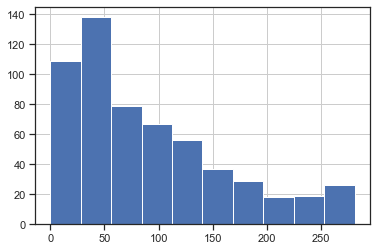

In [19]:
data['text'].str.len().hist()

In [20]:
data = data[data['text'].str.len() != 0]

In [24]:
data = data.reset_index()
data = data.drop('index',axis=1)
data

,text,author,in_reply_to,sentiment
0,Ty też ulegniesz likwidacji,Jacek,1446852287536713730,NaN
1,"Nie było cię wczoraj na Placu Zamkowym, więc j...",Wiktor Szpilski,1446852287536713730,NaN
2,Panie Kamysz- WIELKI WSTYD !!!!!!!!!!!!!!!!!!!...,Dorota,1446852287536713730,NaN
3,Co robił pan wczoraj wieczorem?,Piotr,1446852287536713730,NaN
4,"Rolnicy głosują na PiS, Tygrysku.",Piotr,1446852287536713730,NaN
...,...,...,...,...
548,"Antypolska, POstUBecka dzicz wyje",jerzy jakacki,1447266587787005952,NaN
549,"100000 chyba Ci się śni, debilu",Karol,1447266587787005952,NaN
550,"Gdzie ten kraj zmierza... Z banda oszołomów, b...",Konrad,1447266587787005952,NaN
551,"Buhahaha, 100 tys. Padłem ze śmiechu!!! Ktoś t...",Var,1447266587787005952,NaN


In [25]:
sent = []
for index, row in data.iterrows():
    print(row['text'])
    sent.append(input())
data['sentiment'] = sent

Ty też ulegniesz likwidacji


 -1


Nie było cię wczoraj na Placu Zamkowym, więc już się zamknij


 -1


Panie Kamysz- WIELKI WSTYD !!!!!!!!!!!!!!!!!!!!!!!!!


 -1


Co robił pan wczoraj wieczorem?


 -1


Rolnicy głosują na PiS, Tygrysku.


 -1


Gdzie żeś pan był wczoraj?


 -1


Szkoda, że Pana nie było wczoraj...


 -1


Wczorajszy dzień był dla pana przełomowy, wyborcy tego  nie zapomną.  Wygląda na to , ze pan nie wyrósł jeszcze z piaskownicy, a na pewno nie dorósł do mądrej polityki. Wstyd!


 -1


Dzisiaj trzeba było bronić rolników i wszystkich obywateli na wiecu w Warszawie. Pana tam nie było. Wstyd.


 -1


Czy tygrysek już śpi?


 -1


A gdzie pan był dziś...?


 -1


Władek!! Nie nadajesz się!!!! Wracaj do kitla bo dokończysz zatapiać PSL-bezpowrotnie!!! Nie czułeś i nie czujesz polityki. Usuń się 🦷


 -1


Wiemy. Ale co Pan zrobi na wsi? Może chociaz jakaś akcja lokalna na wsiach informującą co oznacza decyzja pisowskiego trybunału wyprowadzająca nas z UE dla rolnika? Jakie konsekwencje wyjścia z UE poniosą małe i średnie gospodarstwa ?


 0


Gdzie byłęś dzisiaj? Twoja pisanina nawet psu na budę się njie nadaje, jesteś sprzedawczykie,, to przez takich jak ty ten cały wasz psl się rozleciał i powinni cię za to rozliczyć.


 -1


A Wy gdzie jesteście?  W tv się tylko lansujecie i looserów typu cookies przygarniacie . Stratedzy quwa mać.
Będziemy pamiętać.


 -1


Wstyd Wstyd wstyd WSTYD WSTYD WSTYD


 -1


Ty to dzisiaj możesz tylko milczeć tygrysku


 -1


to na co czekacie ? na drapane panie WKK? Akurat was pisowcy posłuchają znając życie wydymają jak onegdaj Leppera


 -1


A Ty z kom trzymasz, że nie ma Ciebie obok Tuska ?


 -1


Kosiniak-Kamysz.

WYPIERDALAJ❗


 -1


A mogłeś, Władek, coś dobrego dziś zrobić...


 -1


DLACZEGO NIE MA WAS W WARSZAWIE....nie idziemy tam dla Tuska ale dla qspol ej Polski.!


 -1


Lepiej się poniżać przed UE i całować jej rączki byleby kasę dali ?


 -1


Gdzie pan wczoraj był? Zamiast manifestować wspólnie przeciwko złu, pan się obraża. To jest dzicinada i z taką opozycją nie mamy czego szukać. Są chwilę, kiedy trzeba potrafić wznieść się ponad partyjne interesy. Po tym można poznać męża stanu. Brak słów.


 -1


To Polacy o tym zdecydują. Były wybory - były. Następne w swoim czasie, a nie w czasie kiedy PSL ma na to ochotę.


 0


Ptysiu jesteś pozorantem ! Ty, Kukiz, Bosak, to jeden wielki (jak wolisz ch, czy  h)
Dotarło !


 -1


Dlaczego cię dzisiaj nie było ???? Co to my być???


 -1


Jak Ci Władziu minęła niedziela? Odpocząłeś? Meczyk oglądasz?


 -1


Powiek krótko, wypierdalaj gumofilcu. Ty gnoju jebany, podniosleś wiek emerytalany Polakom, twój pachołek , Pawlak podpisał umowę na gatunek
z od ruskich do 2036 roku. Spierdalaj gnoju, szumowino lewacka.


 -1


Sztandar ZSL wyprowadzić


 -1


Panie Władku pan się nie boi? Tak kompromitować. Toż za chwile zaczniecie w sondażach pukać od spodu.


 -1


Dziękujemy że nie poparł pan lewaka . Prawica musi się trzymać razem. Próbowaliśmy powstrzymać antypolską zarazę z i w dużym stopniu nam się to udało. Prasa lisze tylko o naszej bochaterskiej postawie


 1


Tygrysku a co ty zrobiłeś dla Polski i Polaków gdzie ten darmowy internet 😋


 0


Niski poziom wiedzy na temat papieru do kasy którą drukuje paragony.


 -1


Ruszcie w teren :) macie fajnych samorządowców, którym przydałoby sie wsparcie posłów


 1


Wiele było już tekstów i afer, za które powinny posypać się dymisje.


 -1


10 października 2021 na pl. Zamkowym w Warszawie byli wszyscy którzy marzą o wolnej Polsce. Szacun dla wszystkich.


 1


Klimczak za co usuwać? Za prawdę?


 -1


Od IPN won lewackie jełopy 😁


 -1


Ale protesty PSL oleje bo zaprasza Tusk? Coś czuję że w przyszłym parlamencie nie będziecie koalicjantem PiS bo was w ogóle w parlamencie nie będzie.


 -1


Popatrz w lustro, tam jest szkodnik


 -1


Wiadomo, że szkodzi. Problem jest tylko taki że PSL, PO i reszta lewactwa szkodzi jeszcze bardziej :(


 -1


I tak trzeba goosno mowic,trzeba do szybszych wyborow dazyc ludzie maja dosc pisu


 1


Ładnie wychodzi czarno na białym, kto jest opozycjonistą totalnym, któremu nie w smak niezależne rządzenie własnym krajem. Kto ma takich antypolskich przygłupów wybrać do władzy? W 10 lat utopili by kraj dla własnych finansowych i politycznych korzyści


 -1


Komu wciskasz głupoty? Lewackim dzbanem?


 -1


Wiadomo ! oświecony "delegant" był z PZPR, "wojt" ZSL, a "uczycielka" to sam Broniarz na początku kariery... Dziękuję postoję


 -1


Bardzo szkodzi


 -1


Moim skromnym zdaniem szkodnikiem jest PSL.


 -1


Ty Darek mentalnie nigdy z czasów Konopielki nie wyszedłeś...


 -1


PiS lepszy od PSL-u.


 -1


1 procent


 -1


Trybunał Konstytucyjny w precyzyjny sposób rozgraniczył traktatowe kompetencje organów UE oraz suwerenne kompetencje organów RP.


 0


Nie za bardzo kumam, o co chodzi. O to, że jest orzeczono nadrzędność polskiej konstytucji nad prawem europejski. To samo orzeczono w Hiszpanii, Niemczech, Francji, Czechach, Rumunii.


 0


Weź się Jarząbek nie kompromituj już.


 -1


ten tekst ma z tysiąc lat ale co tam


 -1


Pajac


 -1


😂


 -1


Kto wam te suchary wymyśla???


 -1


UE naciska, chce wstrzymać kopanie Turów, stawia warunki, a pan widzę zaskoczony z inflacji, choć milczycie w głosowaniach, czysta hipokryzja.


 -1


Edukacja ekonomiczna dzialaczy PSL widze zatrzymała w latach 90


 -1


Prawie tak dobre jak podniesienie wieku emerytalnego przez A tylko nieco gorsze od załatwienia OFE! PSL trzyma poziom!


 -1


od kogo Pan skopiował wypowiedz?


 -1


Ciekawe czy od tego przeniesienia przybędzie pieniędzy dla ratownictwa medycznego? Jako marszałek województwa przejmowałem pogotowie od administracji rządowej. Był to obraz nędzy i rozpaczy. Chcemy wracać do tego?


 -1


ale gdyby opozycji chciało się wygrać wybory, to ten problem by nie zaistniał...


 -1


"Art. 15 pkt. 2 Zasadniczy podział terytorialny państwa...określa ustawa" 

Proszę wskazać w jaki sposób upaństwowienie RM naruszy ten artykuł Konstytucji.


 -1


Temu to się nudzi nooo...


 -1


Ogarnął pan czajkę ? Panie nieudacznik 😂


 -1


Czemu tylko kandydatki i kandydatów? A co z kandydatiszczami (mam nadzieję, że dobrze odmieniłem i żadne aktywiszcze mnie nie pozwie)?


 -1


Mazowiecki i aktywność haha aa w PZPR co za bezczelny człowiek w tej Warszawie.


 -1


Proponuję leśnych Dziadków jadących ze Śląska do Warszawy z Saługą i gdańskich grzybiarzy pod wodzą Bolka TSUE, żegnanych przez panią prezydent.


 -1


Całe wakacje na koszt stolicy u ujścia Czajki lub strefie relaksu na paletach.uwaga na drzazgi.


 -1


Ty mendo ❗❗❗


 -1


Narcyz.


 -1


Rafał oddaj moje 100zł.


 -1


Młodzi ludzie w szkołach średnich czekają na spełnieni tej obietnicy.


 0


Proponuję nagrodę imienia Jolanty Brzeskiej wraz z jej ulicą. Tak należy uhonorować osobę, która została zamordowana, bo broniła wyrzucanych na bruk obywateli Warszawy. Dlaczego Panu nie po drodze z tą współczesną bohaterką?


 -1


pan to jednak jest sługusem jednej opcji - wielkie rozczarowanie


 -1


Ty już jesteś tak zamotany że podobno pobiegłeś na Pl. Konstytucji.🤣
Co z mieszkaniami bez toalet na Pradze? Tym się zajmij, pajacyku.


 -1


Człowiek bóbr? 😆


 -1


Tylko Mata. Jest niewysoki, wręczając nagrodę będzie pan jeszcze wyższy niż zazwyczaj.


 -1


Będą salony masażu grubych dup


 -1


Nagroda komunisty dla młodych? 🤣🤣🤣🤣🤣 eh Rafale cymbale


 -1


Proponuje tego Nunusia od p.Komisarz co to chcial "usypiac" 3 letnie dzieci jak psy,ktos pamieta nawisko tego zacnego mlodego czlowieka?


 -1


Paszoł won !!!!!


 -1


To może ten?


 0


Mazowieckiego hahahahhahah😂😂😂😂😂


 -1


a ja proszę o OBIETNICĘ że w przyszłym roku faszyści nie przejdą przez Warszawę 1 Sierpnia.


 0


To gerontofobia i faszyzm! Za energię, entuzjazm i młodzieńczy zapał w głoszeniu jedynie słusznych poglądów zgłaszam „babcię Kasię”😍
https://t.co/LZRvCMphL2


 -1


Jak to jest że kobieta żołnierz AK stoi na demonstracji na której są dzieci i wnuki komunistów którzy mordowali żołnierzy AK ?????


 -1


Teściowa Tuska. Może nie jest młoda ale jakie smesy pisze 😂


 -1


Nam kandydatkę 👇👇👇


 0


Wypierdalaj!!!


 -1


Ulica Lecha Kaczyńskiego w Warszawie 
🇵🇱🇵🇱🇵🇱


 0


SZCZYT MANIPULACJI!!!


 -1


Cała Polska śpiewa z nami, wypierdalać z uchodźcami. Cieszę się że platforma w końcu przyznane rację tak pięknym sloganom


 -1


NIK nie wychodzi cyniku nierobie


 -1


Polska była zawsze, jest i będzie W Europie.


 1


Brednie nie chcemy was ! tu jest Polska!


 -1


Mów za siebie...


 -1


Rafau na Białołęce śmierdzi. Pomożesz? #Polexit


 -1


Rzeszów też))). 500 osób było wczoraj na rynku


 1


A Francja, Niemcy i Hiszpania już wyszły?


 0


Super!


 1


Jakoś dziwnie brak mi w obiektywie tęczowej flagi która ja widziałem ...to elektorat platformy 3/4 waszych wyborców.....


 -1


Mniemam, że 11 listopada też nie będzie pandemii w warszafce.


 -1


Cała Polska mówi..Platforma nie wyprowadzi nas z EU!!!


 1


Byłem


 1


Dziękujemy!Ja miałam też flagę Warszawy! W Jedności Sila


 1


Kogo wy chcecie oszukać?


 -1


Wierzyć się nie chce, że ludzie słuchają tych kłamstw. To co pan opowiadasz to jakiś absurd, kompletna ściema


 -1


Same autorytety z pod ciemnej gwiazdy


 -1


Plejada kłamców


 -1


 Zeszli się Oszust i zdrajca 😡😡😡😡


 -1


 Chłopie, nie masz nic innego do zaproponowania Polakom,..?! tylko wychodzenie na ulicę i dążenie 
do wojny domowej,..?!
Zastanów się,..?! Jak widać czas spędzony w UE 
niczego cię nie nauczył,..!!!


 -1


 Jurek na koksie jedzie jak Nitras 😂


 -1


 Brexit dzięki tobie już nastąpił. Jesteś miszczem w exitach.


 -1


 Ty debi...u nas z Unii chcesz wyprowadzić bo twoja partia chce uchodźców wpuścić do Unii!! Unia się nie zgadza na to!!!To PIS nas wprowadził do Unii a wy podpisaliście wyjście z niej!!!! Niech Dobry Bóg cię poskromić raczy!!!


 -1


 Komenda Główna Policji podaje, że na wczorajszym wiecu Tuska było 25 tys osób. Żadne 80-100 tysięcy. Czyli emocje, wulgaryzmy i prymitywne kłamstwo.


 -1


 W piachu dla Ciebie


 -1


 śpieszmy sie wielbić SBeków....
https://t.co/2Y9mhbUWj6


 -1


 Pańskiej głupoty Herr Oberschturmfuhrer T


 -1


 Ciąg  dalszy to będzie taki ,że  zapuka do Ciebie bencwale  policja i pójdziesz siedzieć.  Za AmberGold OFE i wiele wiele innych Twoich przekrętów Łobuzie  jeden.


 -1


 Nigdy więcej PO!!!


 -1


 teraz demonstracja żeby zatrzymać kolejny Potop Szwedzki
też nam nie grozi ale sukces murowany


 -1


 Też czekam aż w pierdlu wylądujesz.


 -1


 W portalach z news’ami piszą, że zbiera pan „wojsko” na wojnę z pis. Nas nie trzeba „zbierać, stawimy się sami.


 1


 Donek weź jedz do swoich bo słuchać ze zrozumieniem w polskim języku nie umiesz. Słuchanie ze zrozumieniem to 1 klasa podstawowki, czyli nie uważałeś i była 2.


 -1


 ..o tak cdn. w ZK Wronki


 -1


 Zgodzę się na małżeństwa jednopłciowe tylko wtedy gdy w sporcie nie będą mogli uczestniczyć transwestyci. Chyba że będzie oddzielna olimpiada dla tranzystorōw. Fuj, ble, jak ony śmierdzą. Za jedną nogę suche w szafie powinny wisieć


 -1


 To mówicie ze Kaczyński jest mocno chroniony a Tusk nie boi się ludzi. Pewnie za darmo też go chronia


 0


 Jedna wielka lipa wyszła Ci szatniarzu. W RP jesteś tylko sprzedawczykiem. Wybory pokażą gdzie Twoje miejsce.


 -1


 Byłem na tych targach Polexit ale nic tam ciekawego.


 -1


 Wyborców proszę o jedno... idźcie tym razem głosować, każdy głos się liczy! Nie dajcie sobie wmówić, że jest inaczej!


 1


 Tusk do Berlina a nie ludzi buntować, to ty doprowadzasz do wojny razem z Kaczynskim .dwaj kaczory na marsa i tam i tam wojne  rubcie


 -1


 To oni tak darli mordy wczoraj. Czegosta się urwał naćpali


 -1


 Zapraszasz do kibla w Brukseli na ciąg ?


 -1


 Dziękuję 
Czekam na cd Panie Premierze


 1


 I większość ludzi bez maseczek. Gratulejszyn 😁😵‍💫🤷🏻‍♀️


 -1


 tylko słabi ludzie tak postępują jak done


 -1


 Swój głos zabieram. To był wielki show dla celebrytów i ich dalszego fejmu. Rozgłosu. Jestem na nie. Nie pójdę za panem w rytmie Lempart, Owsiaka, Moczulskiego, Millera, Hołdysa. Sami pozerzy obsypani brokatem. Z wieloma sprawami za uszami. Sorry. Pa.


 -1


 Czyli rządów PiSu ciąg dalszy!!! Nie potraficie. Nie uczycie się na błędach!


 -1


 Panie Tusk po co panu ta polityka ?


 0


 I tak bez końca...


 0


 Sluchaj człowieku czemu jatrzysz,nie dość  że  jesteś  Niemcem to jeszcze chcesz Polskę  sprzedać


 -1


 Świetnie, sam czekam na program PO


 0


 A o co Wam chodzi?


 0


 Kolejna mieszanie młodym  w głowach.Tak było przed wstąpienie do Unii i teraz aby na stołki a dalej tak jak w Rosji sami swoi.
Widać że w Niemczech nie ma bia...m. więc trzeba szczuć ludzi na siebie.
Zastanówcie się ludzie chcecie dalej mieszkać na walizkach w innym kraju czy w P


 -1


Pier**lisz Szymon górnolotnymi frazesami kiedy jest czas na czyny, a nie przemowy.
Albo wszyscy razem, albo pisowski okupant pogrąży PL na dziesięciolecia. 
PRZEMYŚL TO!


 -1


Obudził się... Trzeba było być wczoraj naPl.Zamkowym i zabrać głos w tej sprawie!


 -1


Szymuś zapomniałeś jeszcze dodać łzy.


 -1


Mów za siebie kretynie i nie mieszaj do tego porządnych Polaków.


 -1


Tusk i cikocki to zdrada he


 -1


Mówić każdy może...niestety rządzić potrafią tylko nieliczni.


 0


200 000 zeta masz oddać za wybory nieudaczniku i placzku


 -1


Czy wiesz ze przez takie strzelanie fochów tracisz? Zachowujesz się jak rozkapryszona panienka i sporo ludzi przestaje traktować Cię poważnie!


 -1


Po nocnej refleksji postanowiłem się przykleić, myślałem że lepiej na tym wyjdę , kalkulowałem, kombinowałem, no cóż, mistrzem w manipulacji jeszcze nie jestem, uczę się.
POLSKA- oj tam, to szczegóły.


 -1


Panie Hołownia,wróć Pan z tego wyimaginowanego obecnej codzienności,zawiń rękawy i do 30 lat nikt Pana nie wspomni,może najbliższa rodzina.


 -1


Niech się Pan schowa jeszcze głębiej, do jakiejś stodoły i stamtąd głosi swoje mądrości. Dojrzały polityk jest tam, gdzie wymaga tego chwila a tą chwilą była Pańska obecność na Placu Zamkowym. Dojrzały polityk nie stroi fochów a potem opowiada o dobru Polski. 
#wstyd


 -1


Panie Szymonie, pan jakoś taki miętki się zrobił wobec aktualnych koniecznych wyzwań.


 -1


Ble, ble, ble...


 -1


Szkoda że osobno…


 -1


O czym człowieku mówisz, obłudniku jak możesz  mienić się Polakiem, a zarazem pisać, że wyrok Polskiego TK jest zdradą, to wyroki  którego TK nie byłoby zdradą, czyżby niemiecki? oni podobne wyroki wydają, pasowałoby?


 -1


Pan Hołownia nie zaproponował protestu w Warszawie, tylko pan Tusk. Pan Hołownia się obraził, że to nie on wpadł na ten pomysł. 
Pokazał Pan "mówienie jednym głosem"


 -1


Powiem tak . Kończ waść wstydu oszczędź „ jaki Szymon takie i myślenie


 -1


Krwi milionów polaków? Leki brałeś dzisiaj?


 -1


Mojego głosu już Pan nie ma. Buta i arogancja.


 -1


Szymon, bo ci żyłka pęknie 🤣


 -1


Dokładnie, ja też popieram UE i chcę żeby Polska została w UE! 
Cieszę się że mam tak wielkie grono osób co myślą podobnie jak ja. Unia Europejska to bezpieczna Polska i nowoczesna Polska!
Jestem dumny z tych wczorajszych tłumów ludzi i liczę na was że sie nie poddacie! Wygramy!


 1


Płacz, głupi płacz ale nad własną głupotą.


 -1


Ten wyrok nie jest zdradą stanu, tak jest w każdym państwie UE. Pan po prostu chce się wybić na nienawiści do Kaczyńskiego i to jest żałosne. Żenada, w wyzywaniu ludzi już dawno prześcignął Pan najzagorzalszych zwolenników PIS-u.


 -1


Wsie ruki na palubie!


 -1


Popłacz się bo to najlepiej ci wychodzi


 -1


Tak, proponuje zamknąć wszystkich europejskich sędziów i krajowych ktorzy 3-krotnie wydali takie wyroki. Szymon bądź konsekwentny. Najlepiej Ty ustal prawo, prosimy.


 -1


Zdrada stanu to wysługiwanie się Niemcom i Brukseli


 -1


Powinien Pan to powiedzieć wczoraj na Placu Zamkowym zamiast pisać dziś na TT.


 -1


Szymuś że POLSKA KONSTYTUCJA JEST WAŻNIEJSZA od unijnej i to ma być zdrada stanu, ty już nawet nie jesteś śmieszny.


 -1


Szymuś jak cię widzę to za każdym razem śmiać mi się chce. Jesteś głupi...!!!


 -1


Weź się chłopie za sprzątanie kibli ( może do tego się nadasz, choć w to wątpię) bo polityka przerasta takich chloptasiów jak ty.


 -1


Czlowieku chory jesteś? A jak miał niby orzec? To było jedyne moźliwe orzeczenie zgodne z konstytucją.


 -1


Co innego robisz, co innego piszesz, co innego myślisz, tak to widzę. To nie jest ,,mam talent"


 -1


Nienawiść, którą się zaraziłeś w TVN, a może wcześniej, zlasowała ci mózg.
Jak ci się nie podoba wyrok TK, to, doprowadź do zmiany konstytucji, a w tym ustroju sądowniczego - co wytworzy nową sytuację prawną.
Nie możesz, bo ci demokracja nie pozwala?
Więc chcesz podpalić Polskę.


 -1


Spadaj leszczy.


 -1


Czy ty jesteś taki głupi sam z siebie czy twoii WSI-owi doradcy to idioci


 -1


Za to, że odrzuca pan Naszą Polską Konstytucję, powinien być pan sądzony jak za zdradę Ojczyzny, ty chorągiewko ustawiająca się zawsze tak, jak wiatr wieje!
Ty człowieku marny, o gumowatym kręgosłupie, który zwijasz w niespotykane węzły.


 -1


Jesteś niewykształconym prawniczym dyletantem a jako polityk, politycznym pajacem, bez właściwości. Partia TVN nie jest i nigdy nie będzie dyktować co Polacy powinni. 🤔


 -1


Zdrada stanu bo TK orzekl, ze wlasnie prawo unijne (czesc jego) nie stoi ponad polska Konstytucja?
Ty jestes PIERDOLNIETY mocno!


 -1


Jednak nie masz racji, konstytucją jest święta tylko juz zapomniałeś płacząc pod publikę


 -1


Postawy takie jak Pańska to jest jawna zdrada stanu ❗ Polska jest i będzie suwerennym krajem.


 -1


Mówi dziad do obrazu.....


 -1


Z pustego i Salomon nie naleje ...


 -1


Zbiera Pan kasę zupełnie jak o. Tadeusz, zbawia Pan Polskę zupełnie jak Jarosław, oskarża Pan przeciwników zupełnie jak Macierewicz, próbuje Pan grać na emocjach jak Kurski, wykorzystuje Pan kwestie religii, by pozyskać sobie ludzi, jak prawie wszyscy. Nowa jakość...


 -1


Niestety wasze fochy na wezwanie nie pozwalają mi was dalej wspierać. Nawet jeżeli jest to gra ma pozyskanie elektoratu to w takich dniach trzeba jasno stanąć po stronie wartości europejskich. Zawiodłem się na was.


 -1


Szybkiego powrotu do zdrowia, Pani Posłanko :)


 1


Pani Piątkowa Pani pamięta? Niedziela. 18.00 . Plac Zamkowy . Warszawa. Czy macie rzecz w 4 literach?


 -1


😱😱🤦‍♂️To już nie hipokryzja😣@HannaGilPiatek To DEBILZM🤬. Debilizm i skowyt !Nienawiść do Polski w pełnej krasie!🤬Ale NIE!!!!!!!!!!!!!✊🇵🇱🇵🇱🇵🇱🇵🇱🇵🇱🇵🇱💪💪💪💪💪💪💪💪


 -1


A to trafnie Pani napisała, w moim imieniu też nie!


 -1


.........przybłędom polskojęzycznej i kolaborantom niemieckim  nie na rękę ?????


 -1


Z tego co mi wiadomo, to tylko pani miała potrzebę zaznaczenie w spisie narod. "tożsamość europejska" 
- Ale rozumiem, nie tylko pani ma problem kompleksu..
Polska racja stanu, to suwerenność narodowa, według której władza państwowa pochodzi z woli narodu!


 -1


Przypomnę Pani tylko, że wyższość prawa krajowego nad unijnym stwierdziły już:

Polska🇵🇱
Niemcy🇩🇪
Francja🇨🇵
Hiszpania🇪🇸
Czechy🇨🇿
Włochy 🇮🇹
Litwa🇱🇹

Przypomnę także, że każde z powyższych państw wciąż jest w UE.


 0


Co za głupoty Pani wypisuje.


 -1


Nie dokazuj miła, nie dokazuj, nie jest z ciebie znowu taki cud🎵🎼😁


 -1


#wypieralaj lezbo


 -1


Pani mówi o tozsamosci Polaków.Moze niech pani cosik poczyta chyba nie ma pani o tym b,adego pojecia


 -1


Ludzie mają dość słuchania,tych wymyślonych bzdur o Polexicie.
Nauczcie się innej bajki na pamięć...a tak w nawiasie Polacy są mądrzejsi niż wam się wydaje.


 -1


limPIS
https://t.co/BNd4qptpum


 -1


Tak bywa jak rzymskokatolik w wydaniu polskim Pan #Kaczyński nie może się dogadać z rzymskokatolikiem Panem a głodni demokratycznej Ojczyzny: lud boży wraz z agnostykami i ateistami czekają na wcześniejsze wybory.


 0


Czy Niemcy, Francja, Hiszpania, Rumunia i in. są już poza Unią? Politykierstwo pani rozum i zdrowy rozsądek odbiera... 👎


 -1


Jaka alternatywa? Kurier wożący paczki to też ruch - i to zaryzukuję sporo większy, w paczkomacie mogę odebrać kilka przesyłek, które by poszly różnymi kurierami.


 0


Parkingi przy sklepach i marketach to najlepsze miejsce. Nawet w wioskach są sklepiki. Może też być poczta lub szkoła.


 0


W mojej wiosce (sypialni Poznania) paczkomat to jedno z najczęściej uczęszczanych miejsc. Niedawno na prośbę mieszkańców InPost postawił większy. Fakt, że niektórzy parkują metr przed panelem paczkomatu-jakby zamawiali burgera w Drive Thru ;-) Dobrze ze zauważyła Pani ten temat


 1


Może też dałoby się poruszyć kwestie udogodnień dla niepełnosprawnych - osoba na wózku nie wyjmie paczki z wyższego poziomu. O ile wiem, jeden z operatorów ma (mieć) takie rozwiązanie, ale warto podejść do tematu systemowo. Aha, i paczkomat to zastrzeżony znak towarowy.


 0


Lubię tę dygresję " niespodziewanie"....


 0


IE4


 0


bzdury,cena benzyny jest taka sama jak za Kopacz na 1 metr


 -1


Proszę uważać z takimi słowami, czip od Gates'a może się zaktywować 😂


 -1


A szefowa hanna się cieszy ta zwaltzów vel wałków


 -1


Ja zaś życzę Pani prawidłowego stanu oleju w głowie.


 -1


Jakoś  Frontex nie był taki entuzjastyczny i wylewny jak Na pewno był pod wrażeniem, że w Polsce zarządzono niemalże pełną mobilizację, żeby pokazać, jak to  broni Polski. Ani nie broni (coraz więcej osób pojawia się na granicy z DE), ani zgodnie z prawem.


 -1


Kontrola jest najwyższą formą zaufania, a nie wizytacja. Wizyta może być kurtuazyjna, chociaż w tej sytuacji to wątpię. Feliks Dzierżyński mawiał wierzysz i sprawdzaj🙂 Dla uczciwości, że rząd polski nie ma nic do ukrycia powinien zaprosić Frontex do współpracy.


 0


Z tego co się orientuję to dziennikarze mają zakaz pobytu na terenie obietym stanem wyjątkowym, kto i na jakiej podstawie miał relacjonować wizytę szefa frontexu???


 0


co wiesz o strukturach Frontexu, sądząc po głupiej wypowiedzi nic. Frontex to także Polskie jednostki, a sama jednostka znajdująca się pod tą nazwą to kilkudziesięciu gryzipiórków bez żadnej siły sprawczej..


 -1


Frontex to urzędnicy nie jednostki


 0


Dzięki obserwatorowi w ogóle możemy stwierdzić, że układ istnieje. Odyn jeden wie co tam się jeszcze dzieje.


 1


To nie są głowy na fizykę. A jeszcze kwantową.


 -1


Moje w sercu i pamięci. Tego nikt nam nie zabierze 🙂


 1


Zdjęcia przepadły 😭😭😭


 0


Można już ogłosić koniec rządów Prezesa, skapitulował w sprawie 5 dla zwierząt, w sprawie nepotyzmu, w sprawie heroicznej obrony granic. I jeszcze fejsbuk padł, jak żyć Prezesie pyta suweren.


 -1


Dwa ważne pytania: czy istnieje prawo do kotleta i czy nadszedł czas na podmiotowość zwierząt pozaludzkich?


 0


Super ! A co jezeli waszym koalicjantem zostalby PSL oni sa na nie ?


 1


Czy nie dopuszczając do zamachu na nasza prywatność możemy to również zrobić z inwigilacją megakorporacji.
 I tu rodzi się problem. Politycy nie rządzą. Politycy chodzą na pasku kapitału.


 0


Może normalka, ale trzeba to uświadomić tym którzy byli na placu. A to nie łatwe bo oni świat widzą oczami Tuska.


 -1


piszący "Nie dajcie się zmanipulować". Można wyłączyć internety, nic lepszego już dzisiaj nie zobaczycie :)


 -1


W którym kraju poza naszym trybunał orzekł ze traktat o UE jest niezgodny z konstytucją?


 0


Wylewacie dziecko z kąpielą!!!


 -1


To seria kłamstw Kalety i fałsz wniosek u Pana


 -1


Gdzie i kiedy Unia zatraciła się we własnej głupocie? To miała być instytucja umożliwiająca swobodny przepływ dóbr i siły roboczej a teraz ma zapędy aby być totalitarnym państwem zwanym Europa.


 -1


Jesteś kumplem brauna który od początku pandemi kłamie i manipuluje
daruj sobie takie odezwy


 -1


Czyny nie słowa.


 -1


To prawda o PiS-ie.A kiedy Konfederacja sformułuje postulat Polexitu.Czego się boicie?


 -1


Do Putina się zwróć o bratnią pomoc


 -1


Veto to by się przydało w sprawie narodowców, żeby ich usunąć z tego gnijącego państewka, a Pana Krzysztofa zapraszam do UK, może Pana też zatrzymają i zamkną w areszcie.


 -1


Krzysiaczku, nie wiesz o czym piszesz, to przerasta twe możliwości, główeczka rozboli o jak będziesz dalej udawał, że nie jesteś gejem?


 -1


Panie Krzysztofie niech pan nie przesadza, widzę że jest pan mądrzejszy od wszystkich sędziów TK, proszę się zająć tym co pan umie


 -1


Bosak..za kogo ty się uważasz? To co ty piszesz..to twoja marna opinia.


 -1


To meritum, to wasze chore wyobrażenie o suwerenności i niepodległości! Polska jest właśnie suwerenna i niepodlegla jako członek UE i to wymiarze dosłownym, bo Rosja nam się nie wcina, ale także w wymiarze wartości, bo to europejskie wartości nadają tym słowom sens!


 -1


Bosak a co Ty wyznacznik kierunkow w Polsce jestes? poza gadaniem to nic w zyciu nie osiagnales, pierdolisz pod publiczke jedynie


 -1


Nie zapomnieli, tylko Ty i tak ich nie zrozumiesz. Argumentacja jest w przestrzeni publicznej a Ty i tak wiesz swoje, bo zdałes maturę i kupiłeś książkę o prawie UE. Sory, autorytet z Ciebie żaden.


 -1


Przecież to Niemiecka UE nie są  obojętni na wartości europejskie liczone w €!!!


 -1


To jest dzisiejsza Unia. Wolne i demokratyczne kraje mają dosyć dyktatur niemieckich i innych nie wybranych osób!


 0


Oni to wiedzą ale nie mają innego pomysłu na podtrzymania poparcia fanatycznych entuzjastów unii


 -1


Czemu nie na Albicli? 🤣


 -1


P. Cenckiewcz jako funkcjonariusz partyjny jest całkowicie niewiarygodny jako recenzent czegokolwiek, a historii i filmu w szczególności.


 -1


Po Wołyniu prawacy nosili go na rękach,  jak zrobił film niezgodny z ideą martyrologii narodowej to już jest przeklęty. A rolą twórcy jest zmuszać do myślenia nawet na bardzo nie wygodne tematy.


 0


Panie Grzegorzu z opozycją totalną sie dogadywać ?
Nie widzi Pan różnicy ?


 -1


Kosiniak Kamysz... HAHAHA śmieszny chłopczyk którego ta pseudo partyjka ma jakieś 2 procent poparcia... Jego zdanie teraz liczy się tyle samo jak nauczyciela w ministerstwie Czarnka. Proszę zapytać się go jak tam sprawuje się portal internetowy dla bezdomnych za 50 baniek!!!


 -1


Nie grozisz Tuskowi,że będzie wisiał,putinowski podnóżku?


 -1


Ja tam bym czekał,  aż się wykrwawi covidowa koalicja. PIS według mnie jednak łatwiej wystraszyć, niż tą koalicję   pandemiczną ,która by rządziła po wyborach.


 -1


Drogi Panie, ten się śmieje, który się śmieje ostatni.


 -1


No tak popieracie przyspieszone wybory bo jeszcze macie temat pandemii do wałkowania. W 2023 już go nie będzie.


 -1


Grzegorz Braun najlepszy przyjaciel Jaroslawa Kaczynskiego


 -1


Żaba nogę podstawia a Braun będzie kowalem🤮🤮🤮


 -1


Panie Grzegorzu jest Pan slowem Narodu
Jestem w stanie wspierac Pana finansowo jakims grosze za to co Pan robi
To taka rekompensata za uciete uposazenie poselskie


 1


Panie Grzegorzu, przed wyborami niech pan zrobi sobie porządne badania psychiatryczne.


 -1


Bicie piany, nie ważne co i jak byle gembę pokazać


 -1


ale lase na subwencję :D a jak nie bedzie 3 % ?


 -1


Ja bym trzymał PiS przy władzy, niech spadnie na nich syf który narobili przez ostatnie 1,5 roku!


 0


Trzeba zrobić wszystko i poprzeć nawet diabła, żeby #PolskiŁad czyli  #NowyWał nie wszedł w życie, inaczej czeka nas gospodarcze tsunami i praca za miskę ryżu, a panami życia i śmieci staną się rozdawnicy etatów w SSP.


 -1


Przygarnie go Tusk na swoje listy.


 -1


Już dawno mówiło się o tym, że prezes Polski będzie do tego dążył i wcale bym się nie zdziwił jakby to właśnie zrobili rączkami PSL, który do każdego się przyklei, bo w koalicji z każdym się odnajdzie 🙂


 0


Stan wyjątkowy dwa miesiące, kolejne 3 nie można nic zrobić. Mają pół roku żeby zejść do 0.5%


 -1


Uuuuu a już zaczynałem wierzyć, że K. nie jest niczyją agenturą a tu nagle ze ZSL zamierza głosować. Dziękuję za wyprowadzenie mnie z błędu.


 -1


Zakładając, że wniosek przejdzie, ciekawe kiedy by się takie wybory odbyły. Póki co to mamy stan wyjątkowy na granicy i dopiero pół roku bo jego zakończeniu mógłoby się odbyć głosowanie. Nieustannie Morawiecki ze świtą rozdaje karty.


 -1


Tylko dlaczego konfederacja poparła Bolszewicki program reżimu Kaczyńskiego PT Polski Ład?


 -1


To jutro widzę was o 18.00


 0


Panie Grzegorzu ten facet jest śliski.Jakie wybory?chyba,że się z kimś dogadał?Bo oprócz limuzyny z szoferem to nie ma nic do zaprezentowania a z rolnikami nie ma nic wspólnego.Wiem co mówię.


 -1


Nie wiadomo,czy to prawda,czy tylko judzenie?!


 -1


Jednak bez "chyba" Panie Grzegorzu


 -1


Mogą to też być jakieś obce służby prowokatorzy którzy będą chceli doprowadzić do konfliktu zbrojnego wiele nie trzeba


 -1


Koledzy z opozycji mają Whiskas zamiast mózgu.


 -1


Niech kolega lepiej nie powiela rządowej manipulacji o tzw strzałach na granicy ze strony białoruskiej. Nie było żadnych strzałów. Pudlo rezonansowe pisowskiej propagandy to niefajny byt.
 To jak z tą gwałconą krową z konferencji , która była kobyłą,


 -1


Na tych "uchodźcach", to można sporo ugrać, bo przecież oni w Polsce nie chcą być, więc można ich śmiało przepuszczać dalej, ale lepiej to wydoić UE jak to zrobiła Turcja swego czasu 🙂


 -1


Ależ opozycja liczy wlasnie na przewrot w wyniku ktorego liczą przejąć władze.


 0


Pisowska i Wasza narracja to kpina. Migracja była, jest i będzie. Strzelanie, co za bzdury. Kolejne brednie w TVP


 -1


Strzelaja z kapiszonow, nie ma nawet nagran. Tak wiarygodne jak ta krowa co ja uchodzca ruchal.


 -1


Oj tam ...PiS włada czasem (ciągle?) i przestrzenią...


 -1


Jestem za !!


 1


Mimo idiotycznej argumentacji w uzasadnieniu, zgadzam się z pomysłem jako takim. I nie obchodzi mnie, co o tym  pomyślałby nieboszczyk Hitler, idol Konfederacji. 
***** *** i Konfederację.


 -1


Czas zimowy CET odpowiada słonecznemu tylko wzdłuż południka 15E mniej więcej wzdłuż zachodniej granicy-prawie cała Polska ma zimą „za wczesne” wschody i zachody słońca. Czas letni odbiega od słonecznego jeszcze bardziej (w drugą stronę) ale jest lepiej skorelowany z biologicznym


 0


Wolałbym przy letnim ale niech będzie jeden czas bo już mam dość tych zmian co pol roku


 0


Chwileczkę z chwilą wchodzenia w czas zimowy nie zapominajmy o cofnięciu wszystkich zegarów


 0


A zrobiono analizę kto kiedy śpi i pracuje?


 0


Nic nie zmieniać!


 -1


Może się wreszcie tego doczekamy- od wielu lat nie mogą tego przeskoczyć!


 1


Juz nie segregacja sanitarna? Teraz sie zegarkow czepiles. Haha no nie wierze


 -1


Gdy jeszcze jakiś projekt np. o likwidacji środy czy niedzieli….


 -1


No pewnie. Może usuńmy w ogóle czas? Panie JKM, jakim trzeba być zjebem, żeby zabierać ludziom godzinę światła w dzień tylko po to, żeby w lato robiło się widno już o 2 nad ranem?


 -1


Najbardziej widać po małych dzieciach jak paskudnie znoszą te ciągłe zmiany czasu i jak dużo lepiej funkcjonują właśnie w zimowym, który jest naszym naturalnym.


 1


Panie Grzegorzu, na wiosnę należy przesunąć czas o 30 minut do przodu (+1.5 h od GMT / UTC) i tak zostawić …


 0


Panie Grzegorzu ,szykujemy się na wojnę?


 -1


Ja bym zlikwidował jeszcze Czas Przeszły. Strasznie mąci, przeszkadza, daje precedensy i jeszcze pożywkę różnym powołującym się nań demagogom ☝️


 -1


Lepiej zlikwidować czas zimowy. Letni jest dobry.


 0


Zlikwidować czas zimowy i czas letni. Im jestem starszy, tym częściej chciałbym zlikwidować czas. Pytam się: dlaczego tylko połowę, a co z drugą połową?


 0


3,5 mld ludzi zaszczepionych… jebnij się Pan w łeb z takimi bzdurami…


 -1


Ale sobie wlewa tym podpisem, taki napuszony i nadęty


 -1


Dobrze ci napisał zdrajco!


 -1


Jak śpiewa jeden młody artysta „Głupim k*rwom leci piana z pyska” 😂 dostają padaczki od świadomości że nigdy by nie zebrali tylu ludzi w ramach poparcia swoich bolszewickich partii. To dowód na to ze warto było wczoraj tam być 🤍❤️🇪🇺


 1


Janusz Kowalski XDDD


 -1


Na palu tej przyjemnoścì Cię nie pozbawiony.


 -1


Super tekst tyle że nie powiesić w ostatnią drogę na palu na palu!!!!


 -1


Przesadził strasznie.. ty jestes zwyczajnym kłamcà


 -1


dobrze ze sie podpisal chociaz, bedzie wiadomo gdzie wyslac list oficjalny


 0


"Cimosiewicz"?


 -1


Dziwne tym bardziej, że Pan Biedroń nie ma nic wspólnego z PO, Tuskiem, Millerem, Cimoszewiczem, czy PZPR. Głośne nie dla hejtu!!!


 1


Zapewne katolik.


 0


Wypominanie orientacji nie na miejscu. Poza tym wszystko ok. Zdrajcy powinni wisiec.


 -1


Jestem ciekawy, jak zgłosisz na policję samego siebie? #FakeNews


 -1


W kwestii polaryzacji to raczej pretensje do Donka dzieciaku.


 -1


A to pewnie katolik krzyżem leżący.
Czy jest możliwość znalezienia tego "człowieka" i ukarania za groźby?


 1


Polacy to są wyłącznie ludzie o złotych sercach przecież. Łany zbóż i babcia z serkiem z Piątnicy. U nas nigdy nie było homofobii i antysemityzmu. A te dzieci, co zamarzają na granicy to nie nasza sprawa, tylko Łukaszenki. Możemy spać spokojnie.


 1


Hej jest z Pana strony w kierunku Polski i Polaków.


 -1


Czy coś się nie zgadza podobno wypierdalaj jest pozytywnym słowem albo jebac PiS też kto mieczem wojuje od miecza ginie.


 -1


Z całym szacunkiem ...ale w niedzielę kulturalnie nie było i ze strony Waszych mikrofonów.


 -1


Robert, zgłaszaj takie rzeczy na policję. Koniecznie.


 1


zapowiedział walkę z hejfem. Do dzieła Misnistrze😠


 -1


Myślę że tego typu język powinien być ścigany i karany. W obecnych czasach, jeżeli nie zachowano szczególnych środków ostrożności to jest możliwym znaleźć sprawcę. Jeżeli jednak to prowakacja w stylu to moim zdaniem także należało by identycznie ukarać sprawcę.


 1


ciebie Biedroń sam bym powiesił na suchej gałęzi męska kurwo


 -1


Ten bijący hejt to efekt ciągłej polaryzacji społeczeństwa, przyzwalania na wypowiedzi takich ludzi jak Marta Lemart, Magdalena Środa, poseł Nitras i ciągłego jadu.


 1


Jak dla mnie to Pan Biedron sam mógł sobie to napisać aby urealnić bzdury o których komuniści z lewicy mówią. #falseflag


 -1


To wy się zastanówcie, politycy. Oglądałem wczoraj tvn24 i całą transmisje z tej 5 tysięcznej manifestacji i wie pan co ?? Tyle jadu, tyle złości, nienawiści do drugiego człowieka od wszystkich osób które tam występowały na tej scenie, nigdy nie słyszałem. Wstydźcie się !!


 -1


Błędów ortograficznych brak, jeśli zaś idzie o stylistykę to faktycznie, można było zredagować to lepiej. Tekst oscyluje w okolicach poziomu gazety wyborczej-skandal. Polityk tej klasy co pan powinien dostawać zdecydowanie wyższych lotów pogróżki. Współczuje towarzyszu biedroniu.


 -1


W dzisiejszych czasach znalezienie autora to nie problem. Liczę, że zgłosi Pan na policję groźby karalne i zobaczy któż jest autorem.


 1


No cóż, kto sieje wiatr... Ja też Cię nie lubię. Jesteś siewcą nienawiści daleko bardziej niż Braun.


 -1


Bardzo chamska napasc z grozeniem zamordowania.


 0


Przestań udzielać się publicznie to nie będziesz dostawał takich maili.
 I tak pieprzysz same farmazony i do tego na siłę próbujesz zainteresować tym innych


 -1


Nieładny ten tekst, nie jest to przypadkiem jakaś prowokacja mająca na celu wywołać efekt wzburzenia i eksplozję przemocy do jakiej nawołuje Tusk?


 -1


Jakie jest prawdopodobieństwo iż jest to jedynie słaba prowokacją mająca na celu zaostrzenie konfliktu między Polakami? W mojej ocenie jest wiele organizacji którym zależy aby Polacy byli źle nastawieni na innych Polaków, tak aby naród polski był coraz słabszy.


 -1


Huh aby nie doszło do czynów. Wyobraźmy sobie, że polski europoseł mógłby zostać potraktowany jak Helena Biedroń!


 -1


Znając życie nikt nie będzie wstanie namierzyć kto i skąd to wysłał. W końcu ten ktoś nie jest dziennikarzem Gazety Wyborczej. A serwerów Klubu Gazety Polskiej sprawdzać nie będą


 0


Żeby się nie okazało, że wysłał to ktoś z Nowej Lewicy. Ale oczywiście wszystkie groźby karalne powinny być ścigane.


 -1


Pewnie wyznawca sekty miłosierdzia 🥰🙏


 1


😂 😂 😂 I


 -1


Pro tip dla polici - to katolik, narodowiec.


 1


To powinno być zgłoszone.


 1


Szczucie funkcjonariuszy z Woroniczej 17 przynosi efekty.


 -1


Tragedia 🤦‍♀️


 -1


Plakac sie chce.. co za zenada


 -1


No właśnie takie gnojki cyniczne, napędzają hejt, publikując niby przypadkiem, takie fejki, podszywające się pod znane osoby publiczne, z drugiej strony sporu publicznego.


 -1


Hipokryci są wszędzie


 -1


Może coś o Strajku Kobiet? Wczoraj Lempart na proteście wypowiadała się w swoim stylu i nikt nawet nie próbował jej przerwać. Hipokryzja.


 -1


Trzeba to zgłosić, bo bierność może doprowadzić do tragedii.
Jeśli to pisał ktoś, kto uważa się za katolika i broni swoich wartości, to życzę mu bardzo trudnej rozmowy ze Stwórcą w przyszłości


 -1


Ahh te Janusze Kowalskie wszyscy tacy sami.


 -1


No i właśnie tacy ludzie mają dezyzyjnosc w Pl. Takie ograniczone umysłowo podmioty mają prawo głosu i mamy co mamy... Nigdy nie dorownamy krajom wysokorozwinietym


 -1


To przestań przemawiać nienawistnie !!!!


 -1


Panie Robercie niech to pan zgłosi na policję takich rzeczy nie wolno odpuszczać


 1


I nie powiem, że Dyduch jest "dobrą reklamą" Nowej Lewicy. Jakieś wnioski chyba powinny być wyciągnięte po urodzinach u Mazurka. To raczej nie pomoże budować dobrego wizerunku.


 0


Jest moc,siła ale jeszcze ciężko się przebić przez liberalno-prawicowe "mendia", które marginalizują Lewicę i szukają sensacyjności konfliktu w SLD niż zwracają uwagę na program LEWICY. Mam poczucie, że program nie dociera do szerokiej publiczności i jest spychany na dalszy plan.


 1


Ten dywanik zbudował ci Trzaskowski ?


 -1


mój klocek miał dzisiaj coming out rano... to się liczy?


 -1


Furiacki atak pseudo-prawicy na LGBT dal z gola zupelnie inny efekt niz spodziewany🤣🤣🤣


 -1


Radzę iść do lekarza.


 -1


Po co są "coming outy"?


 0


Zmowu wpychanie? 🤔


 -1


Przez was za kilkadziesiąt lat w dniu comingotow ludzie będą się przyznawać że są hetero. To żadna orientacja to chęć pokazania odmienności dla braw dla podziwu dla zwrócenia uwagi.


 -1


W dzisiejszym świecie najbardziej przerąbane ma facet w średnim wieku, który jest biały, jest chrześcijaninem, jest hetero i ma prawicowe poglądy.


 -1


W takim razie jak skorzystam z „coming outu” i przyznam się że jestem już 4 lata po ślubie z moja piękna żona która urodziła mi w zeszłym roku cudowną córkę.


 1


Słyszałam, że zaglądanie Wam pod kołdrę to jedna z oznak prześladowania. Przy tej transparentności to chyba sami siebie prześladujecie


 -1


Moj coming out to precz z natarczywymi pedałami i lesbijkami.


 -1


Ladny chodnik ktos pomazal


 -1


Najważniejszy dzień w roku Polskiego "patrioty"?


 0


No dobra, przyznam się, jestem hetero!
Ufff, w końcu wydusiłem to z siebie, już czuję tę przybywającą w związku z tym energię, polecam wszystkim!


 1


I już niektórzy się zesrali.


 -1


Skoro to takie normalne dlaczego trzeba się przyznawać do tej normalność ? 🤨🧐


 0


Tak sobie siedzisz?  Nic nie boli?


 -1


Leczcie się, dopóki jeszcze są wolne miejsca w klinikach psychiatrycznych


 -1


🤮
Wie Pan, co to jest intymność, sprawy których się nie wywleka na ulice? 
(Nie, nie jestem zainteresowany, pytam abstrakcyjnie.)


 -1


Jestem transvaxem. Nie szczepiłem się, ale identyfikuję się jako osoba zaszczepiona.


 -1


Z wzajemnością! ♥️🧡💛💚💙💜


 1


Najpierw na straży wiecznego sojuszu z CCCP, a teraz na straży podległości Berlinowi. Neokomuna rules!


 -1


Co parę lat zmieniacie kierunki, raz wschód, raz zachód !


 -1


Nie wybieracie się? To dlaczego jesteście narzędziem POLGETOUTu (wypychania Polski z UE przez elity UE i antypolską opozycję: get out- wynoś się). Nie ma mowy o POLEXICIE, ale jest stopniowy POLGETOUT. Przestańcie kłamać i szkodzić Polsce.


 -1


Zesralem się ze śmiechu


 -1


Po wyborach w Czechach lewica poza parlamentem, ludzie w Europie powoli mądrzeją, u nas będzie podobnie


 -1


Pani Agato, czy na czyjs charakter, mentalnosc moze wplywac wyglad, chec posiadania koloru oczu konkretnego, zmartwychwstaly wojciech dosc mlodo wyglada, ale mysle ze pani moze byc go pewna. Moze przegada pani temat z przyjaciolkami, robertem


 0


Trochę szkoda…


 -1


Jak hipokryta może być strażnikiem czegokolwiek?!Komu te brednie chcecie wmówić?


 -1


A jak Moskwa wezwie ?


 -1


Gówno nas to obchodzi


 -1


A kto chce wyprowadzić Polskę z UE ?


 -1


A szkoda.


 -1


XDDD


 -1


A gdzie by was chcieli? W UE gdyby nie nasze składki też by was nie trzymali.


 -1


Najlepiej bohatersko walczyć z czymś co nie istnieje. Wtedy już na starcie można obwieścić sukces.


 -1


Zapomnieliście o maseczkach i dystansie, „bezmyślni siewcy śmierci”.


 -1


Chcesz uprawiać Polityki czy sex z pederastami ? Ty się dobrze zastanów !


 -1


Młoda... 🤣🤣🤣


 -1


Tęczowi faszyści w akcji, to jest wasza tolerancja🤮
https://t.co/ZAvDchBEEi


 -1


Szkoda bo powinniście wracać do Moskwy.


 -1


Konstytucja teraz wam śmierdzi? Niedawno wiecowaliście za konstytucją!!


 -1


Pederaści do wora,a wory do jeziora.


 -1


Narzeczona załatwiła awans . To moża by uznać za  nepotyzm ale u nich wszystko inaczej .


 -1


O czym ty marzysz obmierzły pedale.
Ciesz się śmierdząca świnio że do tej pory  Polacy nie użyli ani fizycznych ,
ani chemicznych środków do likwidacji tego robactwa jakim jest
LGBT.Czas  apokalipsy dla tego rodzaju człekokształtnych jest 
coraz krótszy.


 -1


30 września 2021, Kobylanka ( woj. Zachodniopomorskie) pisowscy radni przegłosowali ponowne obniżenie wynagrodzenia wójta z 3.700 zł brutto do 3.500 zł brutto. Dlaczego ? Bo Wójt nie jest pisowski. Swój pisowski dostawał wcześniej 12.000 zł brutto.


 -1


Co tam zesrales sie dude?


 -1


Ciekawe jakie to uczycie bycia prezydentem który wyprowadzi Polskę z Europy.. POLEXIT...


 -1


Sąd Najwyższy uznał ONR za za organizację faszystowską. 
Bąkiewicz to były szef ONR-u.
Prawo i Sprawiedliwość daje kasę Bąkiewiczowi.
PiS daje kasę faszyście Bąkiewiczowi!!


 -1


A teraz Adrian oddaj pilota i weź się do pracy...


 -1


Duda zjedz marchewke. Jest dobra na mózg.


 -1


Panie prezydencie, mam nadzieje , ze spotkamy się dziś o 18-tej na Placu Zamkowym. Liczymy na pana.


 0


PILNE:  Rząd pod Sąd! NORYMBERGA 2:0 - Polacy wychodzą na ulice! Toruń XVI rozaniec pikieta przeciw sanitaryzmowi sobota 09.10.2021


 -1


Czy znał Pan raport o F35 autorstwa Piotra Woyke? Dlaczego Pan nie zareagował?


 0


Panie prezydencie, bardzo dziękuję za to, że jesteś w trakcie pokonywania demonów jednej uczelni. Jesteś przykładem potężnego prezydenta z bardzo rozwiniętym


 1


Nie do wiary. Polska plonie a pan sobie pisze o meczu


 -1


Ty wstrętny, ohydny człowieczku.  Polskę sprzedają a ty milczysz jak Agata. Krak9w się za was wstydzi, Polska sie wstydzi i emigracja także.  Adrian, ty się ogarnij jakoś bo przegrywasz w oczach Polaków


 -1


Jesteś amdżej zdrajcą Polski. Na twojej warcie wyprowadzają kraj z UE podczas gdy Ty wykonujesz rozkazy kaczego siura.
Jak zdrajca będziesz sądzony...


 -1


Szmaciana laleczka 😥, ale się Polsce trafiło 😥😥😥😥


 -1


Gdyby nie było wydarzeń sportowych ani pogrzebów, to czy Prezydent miałby coś do zakomunikowania opinii publicznej ?


 -1


Jedziemy ostro z tematem poszerzaj rynki dla polski


 -1


Zaproś bałkany do trójmorza!!!


 -1


Sąd Najwyższy uznał ONR za za organizację faszystowską. 
Bąkiewicz to były szef ONR-u.
Prawo i Sprawiedliwość daje kasę Bąkiewiczowi.
PiS daje kasę faszyście Bąkiewiczowi!!


 -1


Sensacja w świecie kulinariów.  Trybunał Gastronomiczny uznał wyższość ruskich pierogów nad brukselką :)


 -1


Jeszcze jakby ciebie i twoich pisich przydupasów szlag trafił, to byłoby się z czego cieszyć. #wypierdalać


 -1


ktoś odchodzi nie przedwcześnie?


 -1


Sąd Najwyższy uznał ONR za za organizację faszystowską. 
Bąkiewicz to były szef ONR-u.
Prawo i Sprawiedliwość daje kasę Bąkiewiczowi.
PiS daje kasę faszyście Bąkiewiczowi!!


 -1


"Ci Austriacy to jednak dziwny naród🤷🏼‍♂️
Zarzuty o korupcję i od razu rezygnacja Kanclerza?!!🤦‍♂️
Nasi mają jednak klasę i honor✊"


 -1


Sąd Najwyższy uznał ONR za za organizację faszystowską. 
Bąkiewicz to były szef ONR-u.
Prawo i Sprawiedliwość daje kasę Bąkiewiczowi.
PiS daje kasę faszyście Bąkiewiczowi!!


 -1


"Ci Austriacy to jednak dziwny naród🤷🏼‍♂️
Zarzuty o korupcję i od razu rezygnacja Kanclerza?!!🤦‍♂️
Nasi mają jednak klasę i honor✊"


 -1


Sąd Najwyższy uznał ONR za za organizację faszystowską. 
Bąkiewicz to były szef ONR-u.
Prawo i Sprawiedliwość daje kasę Bąkiewiczowi.
PiS daje kasę faszyście Bąkiewiczowi!!


 -1


tępy pisowski politruk znow nadaje


 -1


Prezydent, który jak się okazuje złamał konstytucję bo podpisał traktat lizboński, który wg. TK jest z nią sprzeczny. No rzeczywiście dobre inspiracje do działania.


 -1


Poległym???


 -1


Jebnij się.... Tu się jebnij...


 -1


To była zwykła katastrofa lotnicza do której przyczyniła się bardzo zła pogoda i niewłaściwe przygotowanie tego lotu. Udowodnij ze jest inaczej bo jak dotąd tylko siejesz propagandę.


 -1


Macierewicz zanim zamknięcie wszystkie szpitale z braku pieniędzy i nieudolności leć  tam szybko możecie jeszcze cię przyjmą i zbadają.


 -1


Znowu kłamiesz podły klamco, ci ludzie tam zginęli nie polegli


 -1


A tam jakaś bitwa była pod tym Smoleńskiem, że polegli?


 -1


raport z parówek gdzie jest !!!! i wrak ??? obiecałeś Antoni ze koledzy twoi oddadza


 -1


Miesięcznica kiedy Jarek kazał lądować i zabił 96 osób, a wojsko na granicy prowadzi dzieci na śmierć. No macie co świętować :(


 -1


Art.91 konstytucji jasno mówi że umowy międzynarodowe w tym traktat UE maja wyższość nad prawem polskim w tym konstytucją. Kucharka przylegała widać konstytucji nie czytala


 -1


Proszę przytoczyć co śp. Lech Kaczyński mówił o Panu. Proszę się nie krępować...


 -1


Dziwne rzeczy tu wypisujesz. L. Kaczyński, który podpisał traktat lizboński zapewne byłby dziś na Pl Zamkowym. I nie z Bąkiewiczem!


 -1


🙏🇵🇱🙏


 1


Zginęli, świrze ruski, oni tam zginęli. Zginęli przez upór jednych i nieudolność innych. I nikt nie splugawił ich pamięci bardziej niż ty i twoja popaprana zbieranina nieudaczników-amatorów. Zamknij się w końcu, bo wszystko, co o nich mówisz jest jak obrzucanie ich mogił g***.


 -1


Pan jest chory! Powinien się pan leczyć! W innym przypadku, jest pan skończonym durniem, panie Macierewicz! Aż przykro się słuch pana chorych hipotez! Albo pracuje pan dla Putina😉


 -1


Myślę Antek,że nawet ten prezydent by się wstydził tego waszego hołdu.


 -1


Nie poległym tylko zginęli w wypadku,


 -1


Antoś, idź sobie wybuchnij parówkę...chory psychicznie sfrustrowany starcze.


 -1


Tak jak oddałeś hołd po katastrofie? Jedząc obiad i wracając pociągiem do polski?


 -1


Poległym...hehe. bredzisz jak co miesiąc.


 -1


Odpowiadacie za ich śmierć.


 -1


termin ....idiota nabiera nowego znaczenia....ale facio prześlizgał się przez całe życie na koszt polskich frajerów... i tak mu zostanie, bo głupi naród łyka wszystko jak mu zaserwuje TVPis


 -1


Antek kaftan ci ściągnęli ? Co ty bierzesz ze takie brednie o niby poległych wygadujesz. Zginęli a winni sa bracia Kaczyńscy i Błasik, którzy doprowadzili do śmierci 96 osób i wszyscy o tym wiedzą. Twoje idiotyzmy tego nie zmienią.


 -1


Prosze nie zapomniec o lekach.


 -1


to ci dobrzy ludzie przyjęli 150 tyś Czeczeńców na złość Putinowi😁😁😁😁wszyscy zwiali na zachód....teraz ten zachód zaczyna nam odsyłać te dobra narodowe....oj udławicie się🤬(my) od tego dobra...poznamy inną formę wartości💀


 -1


Jarek zabił brata, żeby pod pretekstem zamachu podpalić kraj. Niestety plan mu się udał...


 -1


Pan to juz lepiej niech sie schowa do tej szafy. Dobrze wiemy jak sie Pan zachował po wypadku lotniczym i jak wyglądają badania w celu dojścia do pseudo prawdy. Ile przez te lata zarobiliście  kasy na posiedzeniach ktore nic nie wniosły ? Granie na trumnach to Pana specjalność


 -1


Masz szczęście, że za szpiegostwo "czapę" znieśli ruski pachołku


 -1


Poległym??? A kto ich zabił? Rozumiem ze ten którego wyrzuty sumienia co miesiąc gnają pod ten śmieszny pomnik!


 -1


Pod Smoleńskiem nikt nie poległ. To był wypadek spowodowany niekompetencją i mobbingiem.


 -1


Modlimy się każdego 10 o Polskę. Jej przeszłość teraźniejszość i przyszłość.


 1


Oni zginęli pod Smoleńskiem, nie polegli, trepie.


 -1


Antek, znowu leków nie wziąłeś?


 -1


😂😂😂


 -1


To twoje ględzenie o ,,poległych pod Smoleńskiem'' zaczyna mnie nudzić.Oni nie polegli bo polec można na polu chwały żołnierz. Ci zginęli w wypadku lotniczym.Dotarło?


 -1


I to mówi zdrajca Polski, ten który do katastrofy pod Smoleńskiem mocno się przyczynił🤦‍♂️


 -1


Czy prawdą jest, że nawet PiS totalnie zlewa tak zwane ustalenia Pańskiej - tak zwanej - pokomisji?


 -1


Gdyby nie głupi błąd władzy dolecieli by na miejsce, a ty BYS TAK Nie MUSIAL SPIERDALAC....chyba że taki był plan ...


 -1


Czy jest jakiś nie protestujący ratownik medyczny, żeby założyć kaftan temu pacjentowi 😂❓


 -1


Głąbie kapuściany! Oni nie polegli. Oni zginęli w katastrofie lotniczej. Skończ tańczyć na ich trumnach maluczki błaźnie.


 -1


Lekarz płakał jak cię badał ??!😂😂


 -1


Gdzie jest wrak, skurwysynie?


 -1


Ty jeb...y złodzieju zrobiłeś sobie z tragedii 96 rodzin interesik i wciąż grasz na trumnach osób, które zginęły ale już niedługo zostaniesz rozliczony !! 🤬


 -1


Że niby co?
Możesz założyć hołd ofiarom morderstwa... zleconego i wykonanego przez kulawego gnoma z Żoliborza!


 -1


Zdająca NATO Antoni ....?


 -1


Antoni weź pigułkę


 -1


🌷🕯️🙏


 1


Pan powinien zamilczec. Zdepraliscie wszystkie wartosci Prezydenta Lecha Kaczynskiego. Mimo, ze przez brata i Jego swite nigdy nie bylem zwolennikiem PLK to mam do Niego i Pani Prezydentowej ogromny szacunek.


 -1


Hahahahahaahha. Antek maciora (zydopiswska pacynko co cie kalkstein sposcil z gownem), zaloz jarmulke. Koledzy z BUNDu juz sie nie ukrywaja. A co do granic, to jedź i pilnuj polinskiego kahalu na czele z zydopisowskimi bojowkami.


 -1


Wycieracie mordy ofiarami katastrofy i sprowadzacie na Polskę niebezpieczeństwo ze wschodu ciągłym, bezpodstawnym szczuciem na sąsiadów.


 -1


Kto obsłuży prawicowy beton? Niech zgadnę, Lewica ???


 -1


Narzekaj na PiS i razem z nim głosuj to lewicowa logika


 -1


Ile z tych 24 miliardów maiło być przeznaczone na organizacje lewackich patoli?


 -1


Dzięki za Łódź dzisiaj. Szkoda że Pan nie przemówił.


 1


Warto było z takim „premierem” paktować ?


 -1


Rząd  się przecież wyżywi.


 -1


No i mieliście okazję to wykoleić i zachować twarz. Sprzedaliście się jak Kukiz i zasłużenie teraz przejdziecie na śmietnik polityki za 2 lata...


 -1


A na to PiS: je... te 24 mld.


 -1


Czy to dlatego ich wspieracie?


 0


pan tylko o pieniądzach a co z pandemią już jej nie ma?


 -1


no nie wiem. biorac pod uwage stan w jakim znajduje sie epidemia to te 57tys ludzi moze byc sporym problemem dla kraju.


 -1


A jeśli chodzi o meritum? Konstytucja PL ponad traktatami z UE czy odwrotnie?


 0


Zróbmy referendum.  Zobaczymy 😁


 0


Wy macie tak duży mandat że możecie zarządzić w gminnej spółce w Ącku karmienie świń paszą zamiast ziemniakami.


 -1


Odkąd głosowałam na Lewicę, która na plecach Gowina dojechała na Nowogrodzką - to serio zastanawiam się, czy glosowanie na Was nie jest za dużym ryzykiem🤔 No i te parówki l. Niezdrowo się Pan odżywia, Panie Adrianie...


 -1


Panie Zandberg, to co tam z tym KPO? Coście tam z tym PIS-em ugrali?


 -1


Chcesz byśmy byli cząstką tego gówna jaka jest ta UE? Ja nie lubię tarzać się w gównie, a ty jak chcesz, tobie widać bliżej


 -1


No i zostaliśmy w Unii. 😀


 1


to zbierzcie się wreszcie Razem do kupy - wszyscy uwalcie pislam a potem ..... dzielcie się ... sukcesem


 -1


Dlaczego niby rząd nie ma mandatu. Ma za sobą większość parlamentarną. To jest jakiś mandat


 -1


Bycie w unii nie może oznaczać likwidacji polskiej niepodległej państwowości wraz z jej wszystkimi atrybutami. Nigdy na to nie pozwolimy.


 1


Referendum.  No chyba nie jesteście wrogiem demokracji?


 0


Rząd nie wprowadza Polski z UE.
Jesteście kłamcami!


 -1


Wychodzi na to ,że następcy towarzyszyszy ,też nie maja żadnego programu dla Polski , biorą tylko przykład wrednego Tuska!


 -1


Unia nie jest bożkiem!


 -1


Czas pokazać jaką jesteśmy siłą i zrobić referendum w całej Polsce nad pozostaniem Polski w EU!!!!


 1


Dla tego głąbie że to byli Niemcy ,a nie hitlerowcy


 -1


Adrian, ty na głupiego wyglądasz


 -1


Hitlerowcy to Niemcy , więc o co chodzi ???


 -1


Żydokomunista  zandberg milcz potomku morderców ,pomiocie szatana,żmijowe plemię.


 -1


A wie Pan dlaczego w PRL-u zmieniono napis Niemcy na hitlerowcy, czy jest niedouczony? Wie Pan dlaczego w okresie zamordyzmu komunistów Pana protoplastów ideowych, nazistów nazywano faszystami, czy jest niedouczony? A może jest Pan jedynie kontynuatorem udającym nowego?


 -1


Lewicowa dzicz próbuje zmieniać historię, Polaków mordowali Niemcy a nie naziści czy hitlerowcy, a po wojnie Żydzi z MBP i Rosjanie. Czy partyjka pokryje koszty odszkodowań za mordy Polaków w wykonywanych przez jej protoplastów.


 -1


To Niemcy byli lewaku


 -1


Ty frajerze, imbecylu w krótkich spodenkach, możesz wyć ile chcesz, bo tylko to potrafisz z rudym, fałszywym burakiem. Panu możesz buty czyścić.


 -1


co Ty takiego zawdzięczasz PiSowi? 🤔😂


 -1


ty Borysław o publicznych pieniądzach lepiej nie mow ...


 -1


Tak jest tak samo dumny jak my z Pana zachowania i uczestnictwa na wiadomej imprezie. 🤦‍♂️


 -1


Nie wyszła hucpa z waszym wodzem to szukacie tematów zastępczych. Jedno co potraficie to nienawidzić. Jesteście niczym.


 -1


Panie Borysie, a Pan to lepiej się zajmie bajerowaniem Teściowej (tej Teściowej), a nie insynuacjami o cudzych romansach.


 -1


A o co ci chodzi lewacka mendo???przeciez mend takich jak ty nikt normalny nie przytula! Takie mendy sie rozgniata! Lacznie z gnidami zeby sie nie rozmnozyly!! A wiec…? O co ci mendo chodzi?? Twoj czas przyjdzie mendo lewacka…poczekaj troszke


 -1


Twój związek się rypnął 🤣🤣😁😁😁😁🤣🤣🤣


 -1


Borysław nie kompromituj się. Kamerdyner pokazał Ci miejsce. Za sraczem


 -1


Przestańcie kwiczeć do koryt,....miałeś chamie złoty róg,ostał Ci się jeno sznur.POwodzenia POjeby.


 -1


A ty Żyd?
Co ci #Międlar szkodzi?


 -1


Oj, nie obrażaj  swojego lidera  też ma swoje bojówki  😄
https://t.co/q0uKasfiIM


 -1


Ja jestem dumny z P.Bąkiewicza. To człowiek,który jest za Polska a nie tak jak Pan za UE. Proszę wymienić co P. zrobił dobrego dla Polaków jak rządziliście przez 8 lat?co Pan zrobił dobrego dla Polaków i Polski jak rządzi PIS? czy tylko P.żyje na koszt Polski? Czekam na odpowiedź


 -1


Ty z twoją ekipą oddajcie podatnikom ukradzione pieniądze z OFE .


 -1


Wy do pięt nie sięgacie Panu Bąkiewiczowi.


 -1


A TY pieniędzy podatników nie bierzesz?


 -1


Borys Dupka ale Ci Donald kopa zasądził jesteś nikim w PO 😁😁😁


 -1


Borys jak było na imprezie u Bakiewicza ?


 -1


Jak go słyszałem na placu Zamkowym tego oszsta i kłamcę Tuska każde jego słowa to kłamstwo jak rzadził to nic nie zrobił dla dzieci i młodzieży i zwykłych ludzi wyzywał ten rząd od złodzieji ale nie ma żadnych dowodów złodziejami to Tusk jego syn kolega Nowak Gawłowski Nojman


 -1


Borys ale Tusk nie jest zadowolony z ciebie byty nie wyczyszczone jakoś tak dziadosko wczoraj wyglądał popraw się chłopie posadę stacisz i co ty będziesz robił jak ty głupi jesteś....


 -1


Najpierw jest 10 m mułu, a potem jest poziom tego wpisu.


 -1


Nigdy nie wygracie wyborów pełowskie oszusty i kłamcy


 -1


#wypierdalaj łysy podciepie,mzdrajco, szmalcowniku, kundlu i zwyczajnie glupku,ale cie tus wy*****🤣🤣🤣🤣


 -1


Na wyborach trzeba waszą całą totalitarną, antypolską, żydowską opozycję upiłować, bo to wam się należy


 -1


Za to Twój romans z Tuskiem to już tylko przeminęło z wiatrem. A Nowak już nikomu nic nie dorzuci bo mu CBA wszystko skonfiskowało. Chyba że Grodzkiemu coś jeszcze w kopertach zostalo!


 -1


Ty jesteś dumny?
Juras
Lempart
Miller
Moczulski


 -1


Ciekawe ilu z nich dzisiaj zatrybi , że byli na spędzie partii co się Niemcom wysluguje.


 -1


Spierdalaj frajerzyno


 -1


Proponowałbym napisać  1 mln jeszcze lepiej by się sprzedawało


 -1


Rzeczywistoście wielcy PEŁOWCY. Czy można nazwać ich ludźmi? Ja raczej piszę prawdę kim są.


 -1


I to wszystko mimo tego, że widzimy panie Budka, jak bratacie się przednio na wszelakich "imieninach u Mazurka". Tak więc proszę pamiętać, że nasz głos by Polska pozostała w UE, wcale nie oznacza poparcia waszych układzików i kombinowania co tu jeszcze dla siebie ugrać..


 -1


100 tys 😂


 -1


I WIELKA TOALETA!


 -1


🤣🤣🤣🤣🤣 100 tys.


 -1


Zero ci się jeblo Borys ,tak to w porządku , widać ,że w szkole orłem nie byłeś.


 -1


i właśnie wasza wiarygodność jest na miarę tych 100 tysięcy czyli 10 osób na metr kwadratowy
i od tego nie uciekniecie
ja uważam że lepiej się przyznać do porażki niż tracić w ten sposób elektorat
to nie KRLD żeby takie rzeczy przechodziły


 -1


Na Stadionie Narodowym jest  58 tyś. miejsc. Twierdz Pan, że na waszym proniemieckim wiecu było blisko 2 razy tyle ludzi? 
To chyba robienie dobrej miny do złej gry?


 -1


Antypolska, POstUBecka dzicz wyje


 -1


100000 chyba Ci się śni, debilu


 -1


Gdzie ten kraj zmierza... Z banda oszołomów, bez progrmau w opozycji i kolejna w rządzie 🙈
Pan widział kiedykolwiek widział na żywo 10tys na żywo? 😂


 -1


Buhahaha, 100 tys. Padłem ze śmiechu!!! Ktoś tu ma problemy z liczeniem!


 -1


Zabawna wypowiedź.. i taka niedorzeczna 😂😂😂😂😂


 -1


In [26]:
data.to_csv('manual_sentiment_8.csv')